### Demonstration of parameterisation of structure and history matching

This code uses a simple example to show how the pinchout of a formation at an unconformity can be included in uncertainty analysis using parameterisation and estimation of parameters and forecasting.


### 1. Project parameters

In [1]:
%run ./loop_showcase_functions.ipynb
#load from MODFLOW_tools (clone repo https://github.com/JimMcCallum/MODFLOW_Tools)
%run ../../MODFLOW_Tools/modelling_routines/modelling_routines.ipynb
%run ../../MODFLOW_Tools/meshing_routines/meshing_routines.ipynb
%run ../../MODFLOW_Tools/geomodel_routines/geomodel_routines.ipynb
%run ../../MODFLOW_Tools/loop2flopy/loop2flopy.ipynb
%run ../../MODFLOW_Tools/plotting_routines_USG/plotting_routines.ipynb

C:\Users\19904604\AppData\Local\Temp\ipykernel_25148\3209728366.py:21: DeprecationWarning: GeoPandas is set to use PyGEOS over Shapely. PyGEOS support is deprecatedand will be removed in GeoPandas 1.0, released in the Q1 of 2024. Please migrate to Shapely 2.0 (https://geopandas.org/en/stable/docs/user_guide/pygeos_to_shapely.html).
  import geopandas as gpd


Modelling routines loaded!
Meshing routines loaded!
Geomodel routines loaded!
loop2flopy routines loaded!
Plotting routines loaded!


In [2]:
P = Project('showcase', boundingbox = [0, 6000, 0, 6000, -500, 0]) # (x0, x1, y0, y1, z0, z1)

# ------------- DISCRETISATION PARAMETERS -----------------------#
P.triExeName = '../exe/triangle.exe'
P.workspace = '../modelfiles/'
P.crs = "epsg:28350" # Put in coordinate reference
P.xypumpbores = [(2500, 2500)] #[(2000, 2000), (4000,4000)]
P.xypumpbores = [] #[(2000, 2000), (4000,4000)]
P.idpumpbores = ['P1', 'P2'] 
P.xyobsbores = [(1500,1000), (2500, 5000), (4000, 3000), (5000,1500), (1500, 3500)] 
P.idobsbores = ['OB1', 'OB2', 'OB3', 'OB4', 'OB5'] 
P.nobs = len(P.xyobsbores)
P.npump = len(P.xypumpbores)

P.r = 40        # refining factor for model boundary. High r has refined edges
P.w = 100      # Interior boundary
P.boundmaxtri = 50000 
P.modelmaxtri = 50000 # 10000 for ref
P.angle = 32   # minimum triangle angles
P.nlv  = 30  # 8/5 was 50 - number of layers for voxel transect grid

P.radius1 = 100 # radius of inner circle around pumping bores
P.radius2 = 200 # radius of outer circle around pumping bores
P.boremaxtri = 99999

P.geo_bores = ['P1', 'P2', 'P3', 'P4']
P.geo_coords=[(500,500), (1600, 2800), (5500,5500), (2800,1600)]

# ------------- FLOW MODEL PARAMETERS -----------------------#
P.mfexe_name = '../exe/mf6.exe'

P.nlg = 4    # number of geological layers
P.nls = 3 # Number sublayers for conformable
P.geo_pl = 2 # Which geological layer pumping from (zero-based)

P.rch = 0.4/365 # 0.0027 m/d
P.strt = -20.

P.ss = [0.0001, 0.00001, 0.0001, 0.0001]
P.chfunc = lambda x,z: -(0.005*x) - (z * 0.02)-20 # horizontal gradient of 0.01 and vertical gradient of 0.02
P.xt3d = True

P.nts_past = 12
P.tdis_past = [(365, P.nts_past, 1.0)] # period length, number of timesteps, tsmult
P.qwell_past = -100000 #m3/d 

P.nts_future = 5 * 6
P.tdis_future = [(5 * 365, P.nts_future, 1.0)] # period length, number of timesteps, tsmult
P.qwell_future = -200000 #m3/d 

#P.zobs = [-40, -50, -100, -200, -300]
P.zobs = [-50, -100, -200]

P.wel_screens = []
for n in range(len(P.xypumpbores)):
    wel_top, wel_bot = -50, -100
    P.wel_screens.append((wel_top, wel_bot))
    
vtk_workspace = 'vtk_files'
if not os.path.isdir(vtk_workspace):
    os.makedirs(workspace, exist_ok=True)

### 2. Meshing

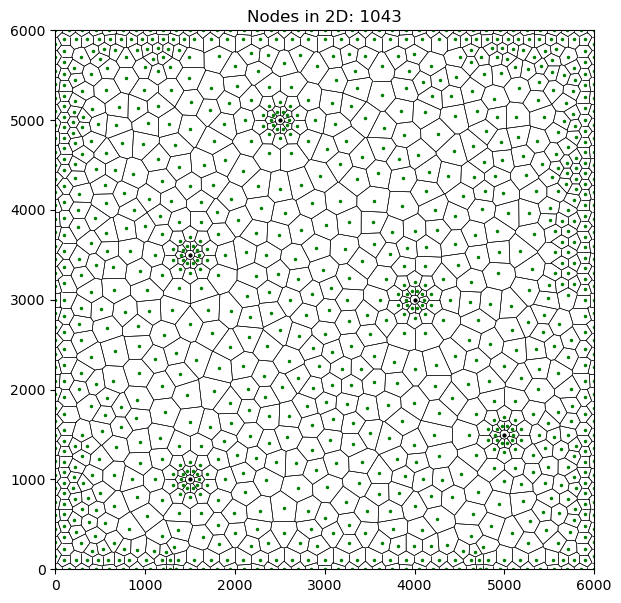

In [3]:
P.cell2dvor, P.xcycvor, P.verticesvor, P.vor, vornodes = createcell2d(P, grid = 'vor', fault = False)      
plot_cell2d_vor(P, xlim = [P.x0, P.x1], ylim = [P.y0, P.y1]) #xlim = [0, 3500], ylim = [0, 3500]

### 3. Geological model (Reference)

In [4]:
P.control_points = ([])
bore_data = pd.read_excel("loop_showcase_data.xls",sheet_name = "inverse_example")
P.data, P.strat = prepare_geomodel_loopshowcase(P, bore_data, include_fault = False)     # Prepare geomodel inputs
P.geomodel = create_geomodel_loopshowcase(P, include_fault = False) # Make geomodel

C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\skimage\util\dtype.py:27: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),


{'upper': 0, 'upper_unconformity': 1, 'lower': 2}


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


In [5]:
#P.data
#P.geomodel.feature_names()
#plot_bores(P)

### 4. Flow model (Reference)

In [6]:
P.hk = [1, 0.1, 10, 0.1] 
P.vk = [i/10 for i in P.hk]

# Initiate models
R = Model('loopshowcase', P, plan = 'vor', transect = 'con') 
R.create_lith_dis_arrays(P)     # Create lithology and discretisation arrays (DIS)
R.create_prop_arrays(P)         # Create property arrays (NPF)
R.create_flow_package_arrays(P) # Create flow packages (CHD, RCH, IC, WEL, OBS)
print(R.modelname, ' has ', R.nnodes_div, ' nodes.')

Creating lithology and discretisation arrays for  loopshowcase  ...
Time taken =  1.606103
Creating property arrays for  loopshowcase  ...
Time taken =  0.002106
Adding flow packages to  loopshowcase  ...
Time taken =  0.509975
loopshowcase  has  12516  nodes.


In [7]:
R.gwf, R.head_ss, R.obs_ss, R.runtime_ss = R.write_run_model(P, period = 'Steady')   

Writing simulation and gwf for  loopshowcase  ...
loopshowcase
Running simulation for  loopshowcase  ...
Period =  Steady 
Model success =  True
run_time =  24.880592


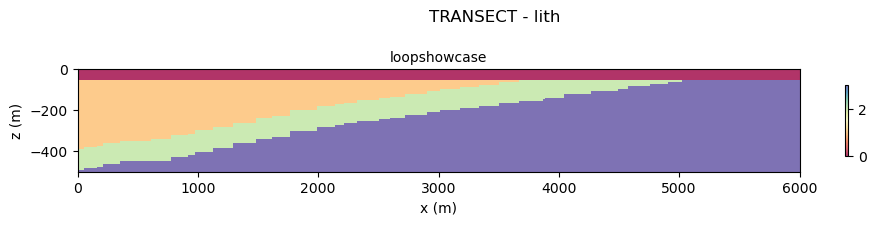

In [8]:
multiplot_vgrid_transect(P, models = [R], array = 'lith', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1) 

In [9]:
f = os.path.join(vtk_workspace, "test", R.modelname)
R.gwf.export(f, fmt="vtk")

'vtk_files\\test\\loopshowcase'

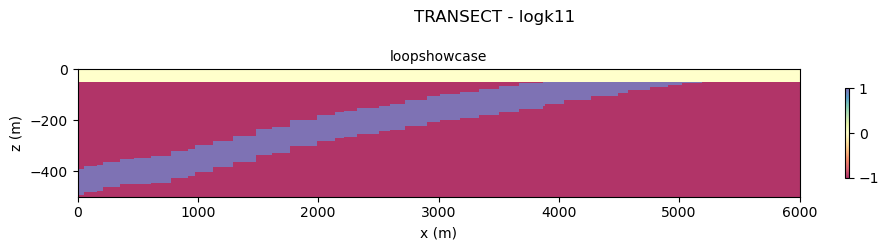

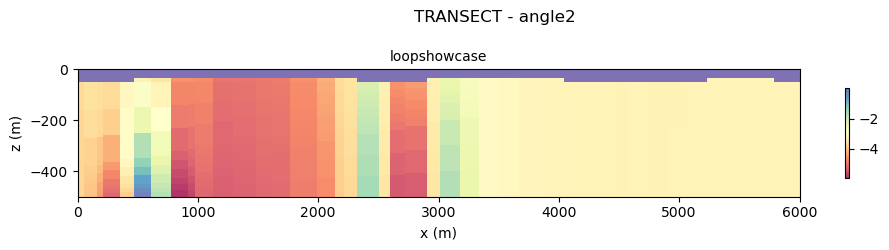

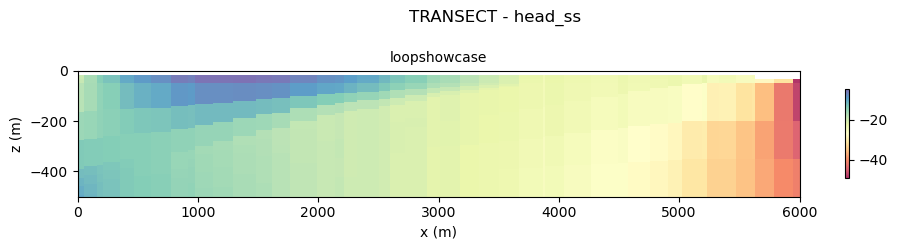

C:\Users\19904604\AppData\Local\Temp\ipykernel_25148\449695775.py:13: UserWarning: Warning: converting a masked element to nan.
  if math.isnan(h) == False:


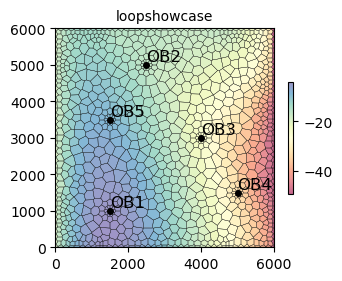

In [10]:
#plot_flow_features(P, [R])
multiplot_prop_transect(P, models = [R], array = 'logk11', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1)
multiplot_prop_transect(P, models = [R], array = 'angle2', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1,)#vmin = -6, vmax = 0)
multiplot_prop_transect(P, models = [R], array = 'head_ss', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1,)#vmin = vmin, vmax = vmax)
plot_bylayer(P, models = [R], layer = 2)#, vmin = -20, vmax = 5) 

### 14. Create "truth" observations and plot observations

In [11]:
models = [R]

# Reorganise observation data to make easier to work with my adding as variable to Model Class
# Obs data is by location then depth

# ------------------  STEADY ------------------
for i, M in enumerate(models):
    M.hobs_steady = np.zeros((P.nobs, len(P.zobs), 1), dtype = float)
    fname = str(M.modelname + "_steady.csv")
    csv_file = os.path.join(P.workspace, fname)
    data_set = pd.read_csv(csv_file)#, header=1)
    df = pd.DataFrame(data_set)
    a = df.to_numpy()
    hobs = a[0][1:(P.nobs*len(P.zobs)+1)]
    for ob_bore in range(P.nobs):
        for z in range(len(P.zobs)):
            n = ob_bore*len(P.zobs) + z
            M.hobs_steady[ob_bore, z] = hobs[n]
            
R.hobs_steady.shape #nobs, nz

(5, 3, 1)

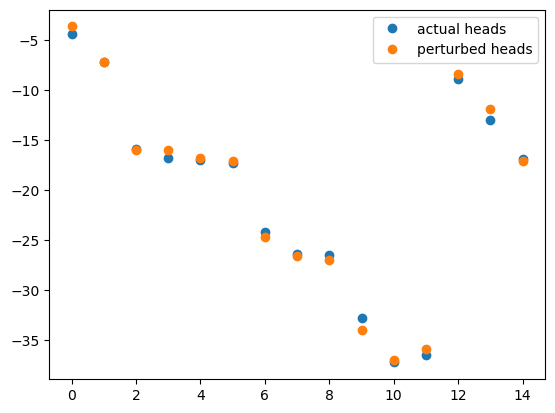

In [12]:
# CREATE SYNTHETIC OBSERVATIONS BY PERTURBING ACTUAL HEADS
err = 0.8
hobs_ref = np.copy(R.hobs_steady)    
for i in range(P.nobs):
    for j in range(len(P.zobs)):
        hobs_ref[i][j] += np.random.normal(0.,err) # Perturb samples either side of measurement
plt.plot(R.hobs_steady.flatten(), 'o', label = 'actual heads')
plt.plot(hobs_ref.flatten(),'o', label = 'perturbed heads')
plt.legend()

### 15. Set up Markov Chain Monte Carlo (MCMC)

#### Define statistics of parameters

In [13]:
P.hk

[1, 0.1, 10, 0.1]

In [14]:
array = [-0.2998780055, -0.586222, 1.1036, -1.897533, -0.93245, -1.7522, 0.1914, -1.9085]
barray = [10**i for i in array]
barray

[0.5013280382582636,
 0.25928536242314143,
 12.69404401961803,
 0.012660970590806979,
 0.1168288226271647,
 0.017692939806872792,
 1.5538174698831748,
 0.012345253151706898]

In [15]:
def Likelihood(obs,mod,err):
    return(np.sum(-(obs-mod)**2/(2*err**2)))

from DREAM import *

Unif = [] # True = Uniform, False = Normal
Log = []  # ?? Just put False
Mean = []
Width = []  # for uniform distributon the range,  for normal, the standard deviation
Min = []
Max = []

###K values
for i in range(len(P.hk)):
    Unif.append(True) # True if uniform, False if normal
    Log.append(True) # Ignore
    Mean.append(np.log10(P.hk[i]))
    Width.append(0.33) # SIGMA
    Min.append(np.log10(P.hk[i])-1) 
    Max.append(np.log10(P.hk[i])+1) 
    
for i in range(len(P.vk)):
    Unif.append(True) # True if uniform, False if normal
    Log.append(True) # Ignore
    Mean.append(np.log10(P.vk[i]))
    Width.append(0.33)
    Min.append(np.log10(P.vk[i])-1) 
    Max.append(np.log10(P.vk[i])+1)

#Control points z value
Unif.append(True)
Log.append(False)
Mean.append(-125)
Width.append(250)
Min.append(-250)
Max.append(0)

print(Mean)

[0.0, -1.0, 1.0, -1.0, -1.0, -2.0, 0.0, -2.0, -125]


#### Set up DREAM and define "run model" function

In [16]:
## DREAM for Steady State
err = 0.1
nchains = 5     #number of parallel chains 
npars = len(Mean)  #number of parameters
nburn = 20
nsamples = 100

D = DREAM(nchains, npars, nburn = nburn, npairs = 1) #nburn is burn in perion, npairs defines how you sample
D.par_set(Log,Unif,Mean,Width,Min,Max) #initialise the class
D.set_CR(ncr=3)  #crossover testing thingy. Use 3
D.k = 1  # Number of things to try each chain. Numbers other than 1 can give weird results for some models

#### Run first sample to get first likelihood

In [17]:
raw_data = pd.read_excel("loop_showcase_data.xls",sheet_name = "pinchout_example")

def update_model(P, loghk0, loghk1, loghk2, loghk3, logvk0, logvk1, logvk2, logvk3, cp):
    del P.hk
    del P.vk
    P.hk = [10**loghk0, 10**loghk1, 10**loghk2, 10**loghk3] #[1, 0.1, 10, 0.1] 
    P.vk = [10**logvk0, 10**logvk1, 10**logvk2, 10**logvk3] #[i/10 for i in P.hk]
    P.control_points = (['CP1', 'control', 3000, 3000, cp, -200, 'c', 'lower', np.nan, np.nan, np.nan],) 
    P.data, P.strat = prepare_geomodel_loopshowcase(P, data = raw_data, include_fault = False)   # Prepare geomodel inputs
    P.geomodel = create_geomodel_loopshowcase(P, include_fault = False) # Make geomodel
    M = Model('dreamy', P, plan = 'vor', transect = 'con') # Create flow model 
    M.create_lith_dis_arrays(P)                                 # Create lith and dis arrays
    M.create_prop_arrays(P)                                     # Create K arrays
    M.create_flow_package_arrays(P)                             # Create flow packages
    M.gwf, M.head_ss, M.obs_ss, M.runtime_ss = M.write_run_model(P, period = 'Steady')   
    hobs = process_obs(P, M)
    return(hobs)


------------------------------------------------------
Chain =  0
0.2684358005264242 -0.9460446692550482 0.9012374371473546 -0.7043510537438644 -1.283541620556102 -1.9552593698922078 0.06486330880369029 -1.8369826528626036 -219.81883460851182
update model
Hk before [1, 0.1, 10, 0.1]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.892041
Creating property arrays for  dreamy  ...
Time taken =  0.008134
Adding flow packages to  dreamy  ...
Time taken =  0.581773
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Period =  Steady 
Model success =  True
run_time =  22.408637
(5, 3, 1) (5, 3, 1)
------------------------------------------------------
Chain =  1
-0.0964216400315756 -1.2073353622367335 1.237493191336593 -0.6932832321239639 -0.8269247878279147 -2.184267195277079 0.06303126902158757 -1.699981265816735 -197.39112514261302
update model
Hk before [1.8553925162240024, 0.1132283896456763, 7.96594745057598, 0.1975372239734675]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.757909
Creating property arrays for  dreamy  ...
Time taken =  0.010285
Adding flow packages to  dreamy  ...
Time taken =  0.470505
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Period =  Steady 
Model success =  True
run_time =  18.620355
(5, 3, 1) (5, 3, 1)
------------------------------------------------------
Chain =  2
-0.12770714686434537 -0.8468720097710069 1.2482150788212545 -1.182474176736485 -0.7334294328818647 -2.0507026119063476 0.20785890330132756 -1.8344980072856962 -172.6220264994717
update model
Hk before [0.8009001222764209, 0.06203897841700643, 17.277988926819727, 0.20263607647718582]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.715875
Creating property arrays for  dreamy  ...
Time taken =  0.008158
Adding flow packages to  dreamy  ...
Time taken =  0.600109
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Period =  Steady 
Model success =  True
run_time =  23.988296
(5, 3, 1) (5, 3, 1)
------------------------------------------------------
Chain =  3
-0.17683813128841844 -0.7655367805696315 0.8683920781168833 -0.7405817838726205 -1.1723048202339599 -1.8192276393730187 0.006848392531087322 -2.1626412851805212 -136.8153743742916
update model
Hk before [0.7452343303782417, 0.14227480211273133, 17.70985799381038, 0.06569401771497792]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.745518
Creating property arrays for  dreamy  ...
Time taken =  0.00214
Adding flow packages to  dreamy  ...
Time taken =  0.490118
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Period =  Steady 
Model success =  True
run_time =  23.417487
(5, 3, 1) (5, 3, 1)
------------------------------------------------------
Chain =  4
-0.027618647249795847 -0.7497736265400929 0.7314913789580209 -0.8522713843298348 -1.0552773544221197 -2.2450872390658305 -0.008257968088891565 -2.0386934018861376 -7.795599938943269
update model
Hk before [0.6655211606871048, 0.17157863933464967, 7.3857070587002775, 0.18172648068741282]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.828675
Creating property arrays for  dreamy  ...
Time taken =  0.008067
Adding flow packages to  dreamy  ...
Time taken =  0.476951
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Period =  Steady 
Model success =  True
run_time =  16.384164
(5, 3, 1) (5, 3, 1)


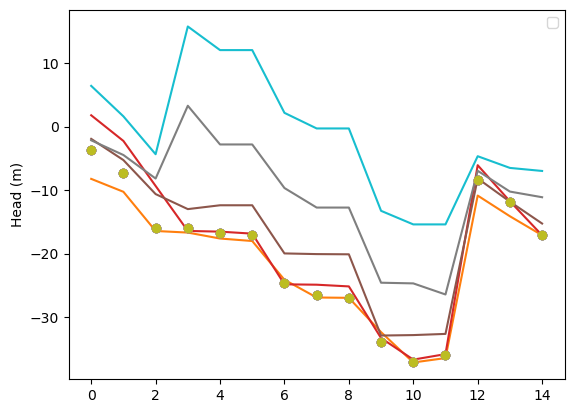

In [18]:
#h_mod_current = [] # list with 1 entry for each chain, that contains the last accepted parameters head result
#h_pred_current = [] # list with 1 entry for each hhaon that saves the predicted heads.    
    
for i in range(nchains):
    print('------------------------------------------------------')
    print("Chain = ", i)
    np.set_printoptions(precision=3)

    print(D.chains[i].current[0],
          D.chains[i].current[1],
          D.chains[i].current[2],
          D.chains[i].current[3],
          D.chains[i].current[4],
          D.chains[i].current[5],
          D.chains[i].current[6],
          D.chains[i].current[7],
          D.chains[i].current[8],)

    hmod = update_model(P,
                        D.chains[i].current[0],
                        D.chains[i].current[1],
                        D.chains[i].current[2],
                        D.chains[i].current[3],
                        D.chains[i].current[4],
                        D.chains[i].current[5],
                        D.chains[i].current[6],
                        D.chains[i].current[7],
                        D.chains[i].current[8],) 

    a = np.array(hobs_ref) #.flatten()
    b = np.array(hmod) #.flatten()
    print(a.shape, b.shape)
    D.chains[i].Lold = Likelihood(a,b,err)
    #D.chains[i].Lold = Likelihood(np.array(hobs_ref_past).flatten(), np.array(hmod).flatten(), err)

    plt.plot(np.array(hobs_ref).flatten(), 'o')
    plt.plot(np.array(hmod).flatten())
    plt.ylabel('Head (m)')
    plt.xlabel('')
    plt.legend()

#### Run all samples (LONG TIME TO RUN!)

In [29]:
fname = os.path.join(P.workspace, M.modelname + '_pars.dat')
f = open(fname,'w')  #saves the pars  
f.close()

hobs_ss, hobs_pred = [], [] # to save prediction results
for i in range(nsamples):
    for j in range(nchains):
        print("----------Sample = %i, Chain = %i----------" %(i, j))
        prop = D.propgenzs(D.chains[j].current,lookback = 10)
        Lnewdum = np.zeros(D.k)
        for k in range(D.k):
            print('range of m = ', D.k)
            print(prop[k,0],  prop[k,1],  prop[k,2],  prop[k,3],  prop[k,4],  prop[k,5],
                                 prop[k,6],  prop[k,7], prop[k,8]) 
            hmod  = update_model(P, prop[k,0],  prop[k,1],  prop[k,2],  prop[k,3],  prop[k,4],  prop[k,5],
                                 prop[k,6],  prop[k,7], prop[k,8]) 
            a = np.array(hobs_ref) #.flatten()
            b = np.array(hmod) #.flatten()
            Lnewdum[k] = Likelihood(a,b, err)
            #print(Lnewdum[k])
            #hk0, hk1, hk2, hk3, vk0, vk1, vk2, vk3, ss0, ss1, ss2, ss3
            print(prop[k,0],  prop[k,1],  prop[k,2],  prop[k,3],  prop[k,4],  prop[k,5],  prop[k,6],  prop[k,7], prop[k,8]) 
        L2dum = np.zeros_like(Lnewdum)
        kk = np.argmax(Lnewdum)
        prop2 = D.propgenzs(prop[kk,:],lookback = 10)
        prop2[-1,:] = D.chains[j].current
        L2dum[-1] = D.chains[j].Lold
        for m in range(D.k-1): 
            hmod = update_model(P, prop[m,0],  prop[m,1], prop[m,2],  prop[m,3],  
                                   prop[m,4],  prop[m,5], prop[m,6],  prop[m,7], prop[m,8])                                
            L2dum[m] = Likelihood(hobs_ref, hmod, err)

        tp = np.sum(Lnewdum)-np.sum(L2dum) # Transition Probability
        print('Last likelihood ' + str(D.chains[j].Lold) + 'Proposed likelihood', str(Lnewdum[kk]))
        if np.random.rand() < np.exp(tp): # If we accept parameters...

            D.chains[j].Lold = Lnewdum[kk]
            D.chains[j].current = prop[kk,:] 
            if i > nburn:                                      # If its past our burn period, we run a prediction...
                print('\nAccepted! Saving parameters and runnning prediction...')
                hobs_ss.append(hmod)           # We wants to save head and look at later....
                #pred = run_prediction(M, prop[kk,:])           # RUN PREDICTION
                #hobs_pred.append(hpred)                         # Save the prediction
        D.chains[j].pars = np.vstack((D.chains[j].pars,D.chains[j].current))
        D.chains[j].likelihood = np.append(D.chains[j].likelihood,D.chains[j].Lold)

    D.gen_mod()
    #print(D.rate)
    fname = os.path.join(P.workspace, M.modelname + '_pars.dat')
    f = open(fname,'a')
    for i in range(nchains):
        f.write('%g ' % D.chains[i].Lold)
        for j in range(npars):
            f.write('%g ' %  D.chains[i].current[j])
        f.write('\n')
    f.close()

----------Sample = 0, Chain = 0----------
range of m =  1
0.26843074062591127 -0.9461736452586471 0.9011342177435607 -0.7043333631578446 -1.2836418957640203 -1.9553574585526259 -0.0785878917890546 -1.9414959522715198 -219.8586554915002
update model
Hk before [0.9384940497696187, 0.17791287615635146, 5.389870494665228, 0.11442793115274762]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.008258
Creating property arrays for  dreamy  ...
Time taken =  0.010118
Adding flow packages to  dreamy  ...
Time taken =  0.497277
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  119.701821
0.26843074062591127 -0.9461736452586471 0.9011342177435607 -0.7043333631578446 -1.2836418957640203 -1.9553574585526259 -0.0785878917890546 -1.9414959522715198 -219.8586554915002
Last likelihood -2337.4162869289526Proposed likelihood -2368.1065208650516
----------Sample = 0, Chain = 1----------
range of m =  1
-0.0964541450182383 -1.2073211941280686 1.23753567684625 -0.6934759982477184 -0.8269491758534696 -2.1843167689040435 0.06305071550908418 -1.7000112931434508 -197.39129821244484
update model
Hk before [1.8553708994472617, 0.11319476827235386, 7.964054397182561, 0.19754527063436936]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.817486
Creating property arrays for  dreamy  ...
Time taken =  0.0
Adding flow packages to  dreamy  ...
Time taken =  0.499811
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  19.681888
-0.0964541450182383 -1.2073211941280686 1.23753567684625 -0.6934759982477184 -0.8269491758534696 -2.1843167689040435 0.06305071550908418 -1.7000112931434508 -197.39129821244484
Last likelihood -5560.496350908953Proposed likelihood -5562.73964005239
----------Sample = 0, Chain = 2----------
range of m =  1
-0.1838021075395009 -0.8926362099860944 1.5380594077103258 -1.3678193354777906 -0.55288633214557 -2.180489419208381 0.3206193784360324 -1.7196195478112273 -14.192335941720728
update model
Hk before [0.8008401807513358, 0.06204100236472389, 17.279679254702373, 0.2025461543045423]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.769607
Creating property arrays for  dreamy  ...
Time taken =  0.002136
Adding flow packages to  dreamy  ...
Time taken =  0.48179
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  19.096319
-0.1838021075395009 -0.8926362099860944 1.5380594077103258 -1.3678193354777906 -0.55288633214557 -2.180489419208381 0.3206193784360324 -1.7196195478112273 -14.192335941720728
Last likelihood -1843.784171677304Proposed likelihood -668338.2336169324
----------Sample = 0, Chain = 3----------
range of m =  1
-0.17673442340813494 -0.7655712254518249 0.8685017597089837 -0.740846407964947 -1.172402197209216 -1.8192550107867844 0.006832591300306715 -2.162717042881877 -136.85172983764025
update model
Hk before [0.6549345363265162, 0.1280453436432084, 34.519095522876704, 0.0428726831711664]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.795399
Creating property arrays for  dreamy  ...
Time taken =  0.002252
Adding flow packages to  dreamy  ...
Time taken =  0.500358
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  23.710042
-0.17673442340813494 -0.7655712254518249 0.8685017597089837 -0.740846407964947 -1.172402197209216 -1.8192550107867844 0.006832591300306715 -2.162717042881877 -136.85172983764025
Last likelihood -91593.28308524862Proposed likelihood -91604.09383589904
----------Sample = 0, Chain = 4----------
range of m =  1
0.138445422577469 -0.860054176805566 0.826781287330536 -0.7690926031364899 -1.1834610518502504 -2.0823912502452315 0.03273260740452766 -1.9255009385946285 -124.07250052433403
update model
Hk before [0.6656801036007804, 0.17156503158252934, 7.38757256343083, 0.181615784928804]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.766853
Creating property arrays for  dreamy  ...
Time taken =  0.00806
Adding flow packages to  dreamy  ...
Time taken =  0.471191
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  19.849725
0.138445422577469 -0.860054176805566 0.826781287330536 -0.7690926031364899 -1.1834610518502504 -2.0823912502452315 0.03273260740452766 -1.9255009385946285 -124.07250052433403
Last likelihood -329526.8458960008Proposed likelihood -91916.27470374445
----------Sample = 1, Chain = 0----------
range of m =  1
0.2687960410957412 -0.9004560288365145 0.6883354444334271 -0.45630276594800456 -1.5295572815722636 -1.9554104310306601 0.06484503224709262 -1.8371087182665324 -200.41524699267265
update model
Hk before [1.375451947523552, 0.13802120769545487, 6.7109080344123475, 0.17017956016128075]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.770958
Creating property arrays for  dreamy  ...
Time taken =  0.008144
Adding flow packages to  dreamy  ...
Time taken =  0.57415
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  22.688526
0.2687960410957412 -0.9004560288365145 0.6883354444334271 -0.45630276594800456 -1.5295572815722636 -1.9554104310306601 0.06484503224709262 -1.8371087182665324 -200.41524699267265
Last likelihood -2337.4162869289526Proposed likelihood -7719.453069405945
----------Sample = 1, Chain = 1----------
range of m =  1
-0.09635806012706856 -1.2073442293229402 1.2372945309018937 -0.693267464075112 -0.8270492310525028 -2.1842205108448662 0.0630224568610901 -1.6998966560333697 -197.32510977709762
update model
Hk before [1.8569321741508207, 0.1257604177006702, 4.879051973815252, 0.3497012897480769]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.007047
Creating property arrays for  dreamy  ...
Time taken =  0.010196
Adding flow packages to  dreamy  ...
Time taken =  0.481942
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  21.520545
-0.09635806012706856 -1.2073442293229402 1.2372945309018937 -0.693267464075112 -0.8270492310525028 -2.1842205108448662 0.0630224568610901 -1.6998966560333697 -197.32510977709762
Last likelihood -5560.496350908953Proposed likelihood -5566.652002240527
----------Sample = 1, Chain = 2----------
range of m =  1
-0.09997595867366922 -0.8926147721181509 1.4612482795235349 -1.4303515736584005 -0.48737071541502885 -2.1805677359398494 0.32058246916672317 -1.6502691176893094 -193.00972408279142
update model
Hk before [0.8010173811479447, 0.06203771176643419, 17.270087219577775, 0.2026434337743447]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.789367
Creating property arrays for  dreamy  ...
Time taken =  0.010214
Adding flow packages to  dreamy  ...
Time taken =  0.609348
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  25.23022
-0.09997595867366922 -0.8926147721181509 1.4612482795235349 -1.4303515736584005 -0.48737071541502885 -2.1805677359398494 0.32058246916672317 -1.6502691176893094 -193.00972408279142
Last likelihood -1843.784171677304Proposed likelihood -1847.4506671851855
----------Sample = 1, Chain = 3----------
range of m =  1
-0.17682199264009785 -0.7656102137901047 0.8682534061008386 -0.7404784432826793 -0.7877268955777782 -1.8190764733003084 0.1828065438553858 -2.162758397679737 -169.6209004737988
update model
Hk before [0.7943722077280388, 0.1280516644394281, 28.923329123739126, 0.037123458253516754]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.795494
Creating property arrays for  dreamy  ...
Time taken =  0.010175
Adding flow packages to  dreamy  ...
Time taken =  0.482429
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  26.367686
-0.17682199264009785 -0.7656102137901047 0.8682534061008386 -0.7404784432826793 -0.7877268955777782 -1.8190764733003084 0.1828065438553858 -2.162758397679737 -169.6209004737988
Last likelihood -91593.28308524862Proposed likelihood -33034.52956587658
----------Sample = 1, Chain = 4----------
range of m =  1
0.13837804227867567 -0.8600798952362402 0.8263841107856114 -0.7693145811344384 -0.9678182742363881 -2.0823492403063644 0.1315125702383314 -1.925447555641202 -142.74649187742037
update model
Hk before [0.665545892319617, 0.1715496302004593, 7.383349148495024, 0.18176972773982572]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.33846
Creating property arrays for  dreamy  ...
Time taken =  0.008038
Adding flow packages to  dreamy  ...
Time taken =  0.585031
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  30.080931
0.13837804227867567 -0.8600798952362402 0.8263841107856114 -0.7693145811344384 -0.9678182742363881 -2.0823492403063644 0.1315125702383314 -1.925447555641202 -142.74649187742037
Last likelihood -91916.27470374445Proposed likelihood -67272.75802002838
----------Sample = 2, Chain = 0----------
range of m =  1
0.31360888500490475 -1.1937510733502297 1.1084809975158991 -0.6780124709467067 -1.0897706619302685 -2.1600002199326287 0.09639157840005598 -1.5775705448704183 -2.892334574397154
update model
Hk before [1.3752385642595188, 0.13801303447680396, 6.704773494499779, 0.17009259966063212]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  3.294224
Creating property arrays for  dreamy  ...
Time taken =  0.015971
Adding flow packages to  dreamy  ...
Time taken =  1.058055
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  104.04428
0.31360888500490475 -1.1937510733502297 1.1084809975158991 -0.6780124709467067 -1.0897706619302685 -2.1600002199326287 0.09639157840005598 -1.5775705448704183 -2.892334574397154
Last likelihood -2337.4162869289526Proposed likelihood -96785.3983773913
----------Sample = 2, Chain = 1----------
range of m =  1
-0.09644687003736194 -1.2073179126633722 1.1178856156448798 -0.6933900270668095 -0.826893885525788 -2.1112835063056354 0.06304308618940074 -1.8033718152506637 -185.59133046640702
update model
Hk before [2.0587749957094346, 0.06401016204704703, 12.837515989021242, 0.20988796125570025]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.78414
Creating property arrays for  dreamy  ...
Time taken =  0.010226
Adding flow packages to  dreamy  ...
Time taken =  0.574012
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  18.652888
-0.09644687003736194 -1.2073179126633722 1.1178856156448798 -0.6933900270668095 -0.826893885525788 -2.1112835063056354 0.06304308618940074 -1.8033718152506637 -185.59133046640702
Last likelihood -5560.496350908953Proposed likelihood -9657.535104282864
----------Sample = 2, Chain = 2----------
range of m =  1
-0.10012406215487189 -0.8924099921714986 1.0518277736066368 -1.105992397804618 -0.48691030325156265 -2.2169044297907607 0.3206083510413766 -1.8681022687911057 -88.45499373408687
update model
Hk before [0.8008535959477987, 0.06204147113910764, 13.118543376979806, 0.20258625349168408]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.89771
Creating property arrays for  dreamy  ...
Time taken =  0.002127
Adding flow packages to  dreamy  ...
Time taken =  0.488589
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  86.971771
-0.10012406215487189 -0.8924099921714986 1.0518277736066368 -1.105992397804618 -0.48691030325156265 -2.2169044297907607 0.3206083510413766 -1.8681022687911057 -88.45499373408687
Last likelihood -1843.784171677304Proposed likelihood -270610.76151126355
----------Sample = 2, Chain = 3----------
range of m =  1
-0.1769287110043346 -0.5634341282897701 0.874274831940383 -1.0151035755165614 -0.7353906356806733 -1.7442450328443224 0.2638948650862947 -2.238032970386973 -155.20574526259713
update model
Hk before [0.7941013564138144, 0.12811205801410175, 11.267505366949177, 0.07834433565884867]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.795551
Creating property arrays for  dreamy  ...
Time taken =  0.010119
Adding flow packages to  dreamy  ...
Time taken =  0.480265
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  23.001999
-0.1769287110043346 -0.5634341282897701 0.874274831940383 -1.0151035755165614 -0.7353906356806733 -1.7442450328443224 0.2638948650862947 -2.238032970386973 -155.20574526259713
Last likelihood -33034.52956587658Proposed likelihood -75898.55019839313
----------Sample = 2, Chain = 4----------
range of m =  1
-0.11140413223870438 -0.8603613763287968 0.8079484510119379 -0.769642307281936 -0.6900999545003588 -2.0823814043481605 0.19757253091995716 -1.9254717202488747 -142.7192173957245
update model
Hk before [0.665382369074243, 0.2732535870422482, 7.486431099139054, 0.09658205115955688]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.767945
Creating property arrays for  dreamy  ...
Time taken =  0.010178
Adding flow packages to  dreamy  ...
Time taken =  0.481629
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  97.821128
-0.11140413223870438 -0.8603613763287968 0.8079484510119379 -0.769642307281936 -0.6900999545003588 -2.0823814043481605 0.19757253091995716 -1.9254717202488747 -142.7192173957245
Last likelihood -67272.75802002838Proposed likelihood -92226.49110415741
----------Sample = 3, Chain = 0----------
range of m =  1
0.26869202310840656 -0.9461722618110551 0.9011850761521951 -0.7045454615270978 -1.2834490565675867 -1.9552355043257503 0.06494169450401673 -1.8368582515652039 -219.8236186251212
update model
Hk before [0.773741458460384, 0.13792361249542534, 6.426114374269138, 0.16996429325242327]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.816374
Creating property arrays for  dreamy  ...
Time taken =  0.008067
Adding flow packages to  dreamy  ...
Time taken =  0.480063
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  23.988541
0.26869202310840656 -0.9461722618110551 0.9011850761521951 -0.7045454615270978 -1.2834490565675867 -1.9552355043257503 0.06494169450401673 -1.8368582515652039 -219.8236186251212
Last likelihood -2337.4162869289526Proposed likelihood -2337.9449425305934
----------Sample = 3, Chain = 1----------
range of m =  1
-0.0965827318126437 -1.2071297211204364 1.2376657765845576 -0.6932553588016588 -0.8265715551115101 -2.1842213866100892 0.06291780210355294 -1.6999944110285365 -197.42625995992563
update model
Hk before [1.856487473087276, 0.11319512885551931, 7.9649870888628405, 0.19744881810744047]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.908929
Creating property arrays for  dreamy  ...
Time taken =  0.010295
Adding flow packages to  dreamy  ...
Time taken =  0.48137
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  19.337096
-0.0965827318126437 -1.2071297211204364 1.2376657765845576 -0.6932553588016588 -0.8265715551115101 -2.1842213866100892 0.06291780210355294 -1.6999944110285365 -197.42625995992563
Last likelihood -5560.496350908953Proposed likelihood -5555.011394148923
----------Sample = 3, Chain = 2----------
range of m =  1
-0.1000902929669385 -0.892491314380969 1.461082651101002 -1.4307137602814317 -1.7910919285419031 -2.1806003790935633 0.6082960116617867 -1.6507850427564572 -193.09763165687514
update model
Hk before [0.800603101459337, 0.06206836121191701, 17.284856429638975, 0.2026490822190507]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.757401
Creating property arrays for  dreamy  ...
Time taken =  0.008035
Adding flow packages to  dreamy  ...
Time taken =  0.458208
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  24.909292
-0.1000902929669385 -0.892491314380969 1.461082651101002 -1.4307137602814317 -1.7910919285419031 -2.1806003790935633 0.6082960116617867 -1.6507850427564572 -193.09763165687514
Last likelihood -1843.784171677304Proposed likelihood -1709.3909816707433
----------Sample = 3, Chain = 3----------
range of m =  1
-0.14933847551278856 -0.8111462927290488 1.0811291209007177 -0.9882504548980334 -0.541503096189607 -1.94904412047955 0.29563096984437426 -1.9786315057154626 -190.37363703215948
update model
Hk before [0.7941631053000004, 0.1280880711096231, 28.912300634538695, 0.03709251147545109]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.82354
Creating property arrays for  dreamy  ...
Time taken =  0.010225
Adding flow packages to  dreamy  ...
Time taken =  0.48966
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  121.949835
-0.14933847551278856 -0.8111462927290488 1.0811291209007177 -0.9882504548980334 -0.541503096189607 -1.94904412047955 0.29563096984437426 -1.9786315057154626 -190.37363703215948
Last likelihood -33034.52956587658Proposed likelihood -6731.352550547882
----------Sample = 3, Chain = 4----------
range of m =  1
0.21099773388023924 -0.7173568924436996 0.09648144399912215 -0.19106402550731222 -1.5362636004429566 -2.1468697047752956 -0.19731663653728543 -2.313649888840178 -209.5954290111273
update model
Hk before [0.7090249607303464, 0.15447340059881534, 12.053942651144846, 0.10274236185024892]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.780337
Creating property arrays for  dreamy  ...
Time taken =  0.010157
Adding flow packages to  dreamy  ...
Time taken =  0.585662
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  28.93208
0.21099773388023924 -0.7173568924436996 0.09648144399912215 -0.19106402550731222 -1.5362636004429566 -2.1468697047752956 -0.19731663653728543 -2.313649888840178 -209.5954290111273
Last likelihood -67272.75802002838Proposed likelihood -19798.508498223426
----------Sample = 4, Chain = 0----------
range of m =  1
0.4023105065332954 -0.9278758847331452 0.5455308967794869 -0.3334003190542226 -1.673857027579106 -1.9001182943500325 -0.0963788525946483 -1.9910616081434096 -182.86909466446826
update model
Hk before [1.6255402737671745, 0.1917092673917539, 1.2487670876651236, 0.6440743063900669]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.782778
Creating property arrays for  dreamy  ...
Time taken =  0.010265
Adding flow packages to  dreamy  ...
Time taken =  0.488489
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  22.719568
0.4023105065332954 -0.9278758847331452 0.5455308967794869 -0.3334003190542226 -1.673857027579106 -1.9001182943500325 -0.0963788525946483 -1.9910616081434096 -182.86909466446826
Last likelihood -2337.9449425305934Proposed likelihood -12308.002269818413
----------Sample = 4, Chain = 1----------
range of m =  1
-0.09671925959024193 -1.2073769895619428 1.237757799258734 -0.6932372033669342 -0.8267515556088496 -2.1843554585286857 0.06290524861451031 -1.700147838252622 -197.47564533702493
update model
Hk before [2.5252856248906443, 0.11806580029266799, 3.5118090750262776, 0.46408729686638445]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.809856
Creating property arrays for  dreamy  ...
Time taken =  0.01013
Adding flow packages to  dreamy  ...
Time taken =  0.48241
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  20.593517
-0.09671925959024193 -1.2073769895619428 1.237757799258734 -0.6932372033669342 -0.8267515556088496 -2.1843554585286857 0.06290524861451031 -1.700147838252622 -197.47564533702493
Last likelihood -5555.011394148923Proposed likelihood -5564.330517062538
----------Sample = 4, Chain = 2----------
range of m =  1
-0.2663970297652618 -0.7820554188816102 1.3655270062733094 -1.513700705113828 -1.6632046585431697 -2.3430662094399475 0.5673570585530404 -1.764050951297368 -70.27895838207247
update model
Hk before [0.8003514579601204, 0.0620330322374576, 17.28851930657067, 0.20265755402618085]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.753957
Creating property arrays for  dreamy  ...
Time taken =  0.002061
Adding flow packages to  dreamy  ...
Time taken =  0.487752
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  18.683694
-0.2663970297652618 -0.7820554188816102 1.3655270062733094 -1.513700705113828 -1.6632046585431697 -2.3430662094399475 0.5673570585530404 -1.764050951297368 -70.27895838207247
Last likelihood -1709.3909816707433Proposed likelihood -756570.662809865
----------Sample = 4, Chain = 3----------
range of m =  1
-0.14925111251746662 -0.7554539837004096 1.0813285351890922 -0.9882388864798095 -0.23287174121778675 -1.949046825929146 0.3756706687690993 -1.9783866081518713 -163.15877660388867
update model
Hk before [0.54150562241595, 0.1651751010300097, 23.20208461488989, 0.030640743190181653]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.748636
Creating property arrays for  dreamy  ...
Time taken =  0.008063
Adding flow packages to  dreamy  ...
Time taken =  0.483306
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  21.948388
-0.14925111251746662 -0.7554539837004096 1.0813285351890922 -0.9882388864798095 -0.23287174121778675 -1.949046825929146 0.3756706687690993 -1.9783866081518713 -163.15877660388867
Last likelihood -6731.352550547882Proposed likelihood -26719.097569667952
----------Sample = 4, Chain = 4----------
range of m =  1
0.17240842504454384 -0.9740897389829293 0.37997754859129645 -0.10235182510087336 -1.4080164710601244 -2.1127366674587793 -0.15747246010480861 -2.1236613536256335 -62.79392883787392
update model
Hk before [0.7091676030560731, 0.17560869530733883, 12.059478711211385, 0.10274509866246033]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.675595
Creating property arrays for  dreamy  ...
Time taken =  0.008084
Adding flow packages to  dreamy  ...
Time taken =  0.470752
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  20.633656
0.17240842504454384 -0.9740897389829293 0.37997754859129645 -0.10235182510087336 -1.4080164710601244 -2.1127366674587793 -0.15747246010480861 -2.1236613536256335 -62.79392883787392
Last likelihood -19798.508498223426Proposed likelihood -13135.91242050613
----------Sample = 5, Chain = 0----------
range of m =  1
0.47561542019748615 -0.9463019868296045 0.9013012451386534 -0.29758079694988665 -1.7300547387274265 -1.9551668680832746 -0.07830145362674441 -1.9414959173999466 -235.46582975108166
update model
Hk before [1.487333723121682, 0.10614761999637916, 2.398708911489032, 0.7900383529053694]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.835345
Creating property arrays for  dreamy  ...
Time taken =  0.010133
Adding flow packages to  dreamy  ...
Time taken =  0.492311
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  16.211543
0.47561542019748615 -0.9463019868296045 0.9013012451386534 -0.29758079694988665 -1.7300547387274265 -1.9551668680832746 -0.07830145362674441 -1.9414959173999466 -235.46582975108166
Last likelihood -2337.9449425305934Proposed likelihood -15181.691285037003
----------Sample = 5, Chain = 1----------
range of m =  1
-0.09674640518006497 -1.2071276773822652 1.2380150142112283 -0.6935198900667823 -0.8266558757166247 -2.1842193262226757 0.06311811271833045 -1.6999504182159437 -197.37639319259867
update model
Hk before [2.9896160761858055, 0.11316132219228017, 7.967117920081199, 0.5039868477335187]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.750119
Creating property arrays for  dreamy  ...
Time taken =  0.008125
Adding flow packages to  dreamy  ...
Time taken =  0.494646
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  20.085829
-0.09674640518006497 -1.2071276773822652 1.2380150142112283 -0.6935198900667823 -0.8266558757166247 -2.1842193262226757 0.06311811271833045 -1.6999504182159437 -197.37639319259867
Last likelihood -5555.011394148923Proposed likelihood -5562.868517305117
----------Sample = 5, Chain = 2----------
range of m =  1
-0.1430220458847694 -0.8924196082365596 1.1287951083699468 -1.044465373595414 -1.4441074260715967 -2.1805184699856053 0.2706883428286326 -1.9378672214410468 -162.12152126526914
update model
Hk before [0.8003014335312618, 0.06206865329892891, 17.298761625933007, 0.20252568508307162]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.056081
Creating property arrays for  dreamy  ...
Time taken =  0.015626
Adding flow packages to  dreamy  ...
Time taken =  0.534199
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  21.965366
-0.1430220458847694 -0.8924196082365596 1.1287951083699468 -1.044465373595414 -1.4441074260715967 -2.1805184699856053 0.2706883428286326 -1.9378672214410468 -162.12152126526914
Last likelihood -1709.3909816707433Proposed likelihood -33225.135786411134
----------Sample = 5, Chain = 3----------
range of m =  1
-0.08092046203299931 -0.7765224509057037 0.8847672594100734 -0.9121687560452185 -0.8296491851875996 -2.1150373415372994 0.29552092506890854 -1.9788196097582167 -190.44689947288975
update model
Hk before [0.7194124578834473, 0.12810922141290654, 13.452255532572837, 0.0902681675631289]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.998859
Creating property arrays for  dreamy  ...
Time taken =  0.007183
Adding flow packages to  dreamy  ...
Time taken =  0.514606
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  27.313293
-0.08092046203299931 -0.7765224509057037 0.8847672594100734 -0.9121687560452185 -0.8296491851875996 -2.1150373415372994 0.29552092506890854 -1.9788196097582167 -190.44689947288975
Last likelihood -6731.352550547882Proposed likelihood -20028.490792278382
----------Sample = 5, Chain = 4----------
range of m =  1
0.18793280878241908 -0.9998342179159233 0.5002177815699381 -0.24198448907519793 -1.269767268928454 -2.1855266053058426 -0.09448486402103798 -2.020622482966138 -74.0599485480904
update model
Hk before [0.8300027627393765, 0.16729291518886577, 7.669503666641605, 0.12241404362775636]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.781432
Creating property arrays for  dreamy  ...
Time taken =  0.010271
Adding flow packages to  dreamy  ...
Time taken =  0.471283
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  16.051711
0.18793280878241908 -0.9998342179159233 0.5002177815699381 -0.24198448907519793 -1.269767268928454 -2.1855266053058426 -0.09448486402103798 -2.020622482966138 -74.0599485480904
Last likelihood -13135.91242050613Proposed likelihood -29885.80649811752
----------Sample = 6, Chain = 0----------
range of m =  1
0.26858796432953425 -1.0020111102315343 0.7065303074001561 -0.7046340851351256 -1.5919521794271632 -1.9550703891761136 0.06529512793553698 -1.8369821957536687 -219.851097707074
update model
Hk before [1.541461949533051, 0.10003818002226389, 3.1638638154740004, 0.5728164888898398]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.767298
Creating property arrays for  dreamy  ...
Time taken =  0.008059
Adding flow packages to  dreamy  ...
Time taken =  0.476503
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  22.732783
0.26858796432953425 -1.0020111102315343 0.7065303074001561 -0.7046340851351256 -1.5919521794271632 -1.9550703891761136 0.06529512793553698 -1.8369821957536687 -219.851097707074
Last likelihood -2337.9449425305934Proposed likelihood -3322.9212103419345
----------Sample = 6, Chain = 1----------
range of m =  1
-0.051379900286415245 -1.455064351297131 1.4446791678877267 -0.6665996667277605 -0.6329038737389381 -2.3888641299298783 0.09461470477950587 -1.4404452267316044 -229.87013589766454
update model
Hk before [1.8560427041907972, 0.0995379952963514, 5.087803238278715, 0.19740853014133128]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.691299
Creating property arrays for  dreamy  ...
Time taken =  0.010293
Adding flow packages to  dreamy  ...
Time taken =  0.562752
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  17.864634
-0.051379900286415245 -1.455064351297131 1.4446791678877267 -0.6665996667277605 -0.6329038737389381 -2.3888641299298783 0.09461470477950587 -1.4404452267316044 -229.87013589766454
Last likelihood -5555.011394148923Proposed likelihood -24799.975872587656
----------Sample = 6, Chain = 2----------
range of m =  1
-0.3070679608148952 -0.8623827465722719 1.7750129823365715 -1.8379800755268272 -1.3442797035314797 -2.30694135677795 0.7516648334031635 -1.5463933421070997 -178.8645102717641
update model
Hk before [0.8884236268527296, 0.035069990537632184, 27.840637005171025, 0.2154767086904567]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.748581
Creating property arrays for  dreamy  ...
Time taken =  0.010213
Adding flow packages to  dreamy  ...
Time taken =  0.560904
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  75.460919
-0.3070679608148952 -0.8623827465722719 1.7750129823365715 -1.8379800755268272 -1.3442797035314797 -2.30694135677795 0.7516648334031635 -1.5463933421070997 -178.8645102717641
Last likelihood -1709.3909816707433Proposed likelihood -7028.784653093655
----------Sample = 6, Chain = 3----------
range of m =  1
-0.14923406438553544 -0.8114528313289905 1.0805182254608758 -0.9886032323387199 -0.5416818001214043 -1.9491401217093025 0.29552164974688694 -1.978876957351706 -190.38570555133882
update model
Hk before [0.49309663541443766, 0.13728315562709434, 59.56799498846882, 0.014521782387949309]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.757162
Creating property arrays for  dreamy  ...
Time taken =  0.002052
Adding flow packages to  dreamy  ...
Time taken =  0.582708
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  133.415394
-0.14923406438553544 -0.8114528313289905 1.0805182254608758 -0.9886032323387199 -0.5416818001214043 -1.9491401217093025 0.29552164974688694 -1.978876957351706 -190.38570555133882
Last likelihood -6731.352550547882Proposed likelihood -6754.593246149989
----------Sample = 6, Chain = 4----------
range of m =  1
0.1725178694390102 -0.9562605112262217 0.37981793070851005 -0.1019137475566265 -1.408275947334844 -2.112509746747986 -0.15774879980555437 -2.1239765906769623 -62.76114012340341
update model
Hk before [0.7091954418167755, 0.15436440692155162, 12.03699902809648, 0.10265893810904521]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.779728
Creating property arrays for  dreamy  ...
Time taken =  0.00206
Adding flow packages to  dreamy  ...
Time taken =  0.480698
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  15.607574
0.1725178694390102 -0.9562605112262217 0.37981793070851005 -0.1019137475566265 -1.408275947334844 -2.112509746747986 -0.15774879980555437 -2.1239765906769623 -62.76114012340341
Last likelihood -13135.91242050613Proposed likelihood -12847.76773896484
----------Sample = 7, Chain = 0----------
range of m =  1
0.26865010029144504 -0.9460817540593937 0.9011522645084039 -0.7044539139043196 -1.283635849314205 -1.9552057748956773 0.06513730529947873 -1.8370125015271248 -219.88620385613322
update model
Hk before [1.4877085859346706, 0.11059601755654554, 2.3978274669799218, 0.7908356752087093]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.903193
Creating property arrays for  dreamy  ...
Time taken =  0.002145
Adding flow packages to  dreamy  ...
Time taken =  0.480651
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  22.861658
0.26865010029144504 -0.9460817540593937 0.9011522645084039 -0.7044539139043196 -1.283635849314205 -1.9552057748956773 0.06513730529947873 -1.8370125015271248 -219.88620385613322
Last likelihood -2337.9449425305934Proposed likelihood -2352.0876600964057
----------Sample = 7, Chain = 1----------
range of m =  1
-0.09658745829991816 -1.1797227203162821 1.2378912828223407 -0.8158941101750388 -0.8261864364980738 -2.1841075734575868 0.15485071465476422 -1.7299521434546867 -197.3990450252217
update model
Hk before [1.856308273416475, 0.11321872138237582, 7.964385344061079, 0.19749044395344612]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.730249
Creating property arrays for  dreamy  ...
Time taken =  0.007954
Adding flow packages to  dreamy  ...
Time taken =  0.480399
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  16.401882
-0.09658745829991816 -1.1797227203162821 1.2378912828223407 -0.8158941101750388 -0.8261864364980738 -2.1841075734575868 0.15485071465476422 -1.7299521434546867 -197.3990450252217
Last likelihood -5555.011394148923Proposed likelihood -5599.879858067929
----------Sample = 7, Chain = 2----------
range of m =  1
0.14977695859244236 -0.8928186620890811 1.461349392487878 -1.430462437446938 -1.791253459737547 -2.1804226159659255 0.608393491631537 -1.6510052056393365 -193.16537800747489
update model
Hk before [0.8005943884318002, 0.06611154090785404, 17.293833875252318, 0.15279385553115749]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.917512
Creating property arrays for  dreamy  ...
Time taken =  0.008696
Adding flow packages to  dreamy  ...
Time taken =  0.48595
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  28.230409
0.14977695859244236 -0.8928186620890811 1.461349392487878 -1.430462437446938 -1.791253459737547 -2.1804226159659255 0.608393491631537 -1.6510052056393365 -193.16537800747489
Last likelihood -1709.3909816707433Proposed likelihood -974.9715298987978
----------Sample = 7, Chain = 3----------
range of m =  1
-0.11955074414311576 -0.8112758925044778 1.1684983714324537 -0.9881878347821109 -0.5413141548829656 -1.9491882186867304 0.296005434627037 -1.9785413220859842 -190.35122487936775
update model
Hk before [1.4118122913956652, 0.12799156162079375, 28.930063872026796, 0.03711398283502924]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.049249
Creating property arrays for  dreamy  ...
Time taken =  0.009304
Adding flow packages to  dreamy  ...
Time taken =  0.623534
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  29.833509
-0.11955074414311576 -0.8112758925044778 1.1684983714324537 -0.9881878347821109 -0.5413141548829656 -1.9491882186867304 0.296005434627037 -1.9785413220859842 -190.35122487936775
Last likelihood -6731.352550547882Proposed likelihood -3909.0448182737596
----------Sample = 7, Chain = 4----------
range of m =  1
0.1705044307116408 -0.7797804436823245 0.504989943175375 -0.10223815441974679 -1.4087010490282144 -2.1107407641174065 -0.15732307353851788 -2.123736202560402 -62.667401217724226
update model
Hk before [0.7593626914913303, 0.15442731037185786, 14.740030135769139, 0.10275717714893227]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.833216
Creating property arrays for  dreamy  ...
Time taken =  0.008936
Adding flow packages to  dreamy  ...
Time taken =  0.502283
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  59.261642
0.1705044307116408 -0.7797804436823245 0.504989943175375 -0.10223815441974679 -1.4087010490282144 -2.1107407641174065 -0.15732307353851788 -2.123736202560402 -62.667401217724226
Last likelihood -12847.76773896484Proposed likelihood -11250.145016362105
----------Sample = 8, Chain = 0----------
range of m =  1
-0.023301392208560135 -0.9462690829908373 0.9009839099969702 -1.590290206010979 -1.2837723855750394 -1.7917368808035614 0.06489018382503109 -1.6920334400670285 -219.91467096591003
update model
Hk before [1.480827362725327, 0.1660426118905295, 3.1988210347123887, 0.7902451617757863]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.86329
Creating property arrays for  dreamy  ...
Time taken =  0.010263
Adding flow packages to  dreamy  ...
Time taken =  0.479897
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  23.045982
-0.023301392208560135 -0.9462690829908373 0.9009839099969702 -1.590290206010979 -1.2837723855750394 -1.7917368808035614 0.06489018382503109 -1.6920334400670285 -219.91467096591003
Last likelihood -2337.9449425305934Proposed likelihood -1417.2880967290264
----------Sample = 8, Chain = 1----------
range of m =  1
-0.09661436549580077 -1.1533850617704051 1.797694302946058 -1.4196330168067142 -0.8265449185032231 -2.4094316492455428 0.6063905895015523 -1.6999412586889642 -197.5504318637457
update model
Hk before [0.9477605070424431, 0.11316989605888461, 7.96129854373512, 0.025686787562710055]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.91675
Creating property arrays for  dreamy  ...
Time taken =  0.010144
Adding flow packages to  dreamy  ...
Time taken =  0.482184
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  27.482848
-0.09661436549580077 -1.1533850617704051 1.797694302946058 -1.4196330168067142 -0.8265449185032231 -2.4094316492455428 0.6063905895015523 -1.6999412586889642 -197.5504318637457
Last likelihood -5555.011394148923Proposed likelihood -12271.20002564419
----------Sample = 8, Chain = 2----------
range of m =  1
0.23002085002569703 -0.8926788953965852 1.461228114204689 -1.4312481039663187 -1.4461299991892036 -2.180374415937864 0.6078859665720532 -1.6509698544449862 -3.8839607867426764
update model
Hk before [0.8005447882558322, 0.0702449225875218, 62.76164281841705, 0.03805107959476726]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.757358
Creating property arrays for  dreamy  ...
Time taken =  0.008041
Adding flow packages to  dreamy  ...
Time taken =  0.555681
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  267.527167
0.23002085002569703 -0.8926788953965852 1.461228114204689 -1.4312481039663187 -1.4461299991892036 -2.180374415937864 0.6078859665720532 -1.6509698544449862 -3.8839607867426764
Last likelihood -974.9715298987978Proposed likelihood -321666.55542495125
----------Sample = 8, Chain = 3----------
range of m =  1
-0.07024039505648218 -0.892823107950781 1.5486396463229781 -1.430635828772947 -0.4868639243482269 -2.1806415463518567 0.3207010787583145 -1.650563817632621 -192.98411671584154
update model
Hk before [1.6983251853276764, 0.12803275909587958, 28.921986176412872, 0.037046901959301035]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.85952
Creating property arrays for  dreamy  ...
Time taken =  0.008532
Adding flow packages to  dreamy  ...
Time taken =  0.495785
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  25.185418
-0.07024039505648218 -0.892823107950781 1.5486396463229781 -1.430635828772947 -0.4868639243482269 -2.1806415463518567 0.3207010787583145 -1.650563817632621 -192.98411671584154
Last likelihood -3909.0448182737596Proposed likelihood -1628.1945641968032
----------Sample = 8, Chain = 4----------
range of m =  1
0.09145184436712535 -0.6979233164343861 0.0374976522142514 -1.6596243530051087 -1.4089783628719035 -1.879194891056186 -0.1818425672441705 -2.451552255035843 -60.131708796262885
update model
Hk before [0.8506670380699392, 0.1279902513810996, 35.37037353836936, 0.03709916809870056]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.705289
Creating property arrays for  dreamy  ...
Time taken =  0.00813
Adding flow packages to  dreamy  ...
Time taken =  0.574515
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  56.511356
0.09145184436712535 -0.6979233164343861 0.0374976522142514 -1.6596243530051087 -1.4089783628719035 -1.879194891056186 -0.1818425672441705 -2.451552255035843 -60.131708796262885
Last likelihood -11250.145016362105Proposed likelihood -1815510.5996244473
----------Sample = 9, Chain = 0----------
range of m =  1
0.021761460496918204 -1.1940864543919016 1.1076300184740944 -1.5632827258558097 -1.3054133994260733 -1.996489561236102 -0.0018349592886426993 -1.432590210670041 -234.67158386445112
update model
Hk before [1.2343884355774501, 0.20048259891117692, 1.090178598889348, 0.02189654767057132]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.773688
Creating property arrays for  dreamy  ...
Time taken =  0.010149
Adding flow packages to  dreamy  ...
Time taken =  0.487299
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  16.754762
0.021761460496918204 -1.1940864543919016 1.1076300184740944 -1.5632827258558097 -1.3054133994260733 -1.996489561236102 -0.0018349592886426993 -1.432590210670041 -234.67158386445112
Last likelihood -1417.2880967290264Proposed likelihood -9394.289255655056
----------Sample = 9, Chain = 1----------
range of m =  1
-0.09675297050038546 -1.2069421428807183 1.5698622034909866 -0.6933324525995757 -0.8264358177987117 -2.387128879308229 0.0634012052559644 -1.7002373583851045 -229.74669895834035
update model
Hk before [1.0513842345211057, 0.06396074970433677, 12.812386125472996, 0.02733488644912847]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.883962
Creating property arrays for  dreamy  ...
Time taken =  0.0
Adding flow packages to  dreamy  ...
Time taken =  0.995318
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  29.31132
-0.09675297050038546 -1.2069421428807183 1.5698622034909866 -0.6933324525995757 -0.8264358177987117 -2.387128879308229 0.0634012052559644 -1.7002373583851045 -229.74669895834035
Last likelihood -5555.011394148923Proposed likelihood -23771.212985087546
----------Sample = 9, Chain = 2----------
range of m =  1
0.1910428764228765 -0.7463845846043464 1.2727035989396316 -1.9332709746054673 -0.04752555403825065 -1.9604876864371708 0.6096348255122158 -1.6462876892803102 -206.53973190083005
update model
Hk before [0.8002893352989136, 0.06209517524964377, 37.141736405731336, 0.20261311215388045]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.882819
Creating property arrays for  dreamy  ...
Time taken =  0.010073
Adding flow packages to  dreamy  ...
Time taken =  0.566515
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  26.812332
0.1910428764228765 -0.7463845846043464 1.2727035989396316 -1.9332709746054673 -0.04752555403825065 -1.9604876864371708 0.6096348255122158 -1.6462876892803102 -206.53973190083005
Last likelihood -974.9715298987978Proposed likelihood -3649.2586539559106
----------Sample = 9, Chain = 3----------
range of m =  1
-0.07035343331793247 -0.8925647482576181 1.548848330535798 -1.8441430732203332 -0.29662896077132433 -2.180318384418025 0.3204785119647223 -1.6509664154431722 -193.0040729957943
update model
Hk before [1.5525402794340946, 0.17931450241001196, 18.737152821504377, 0.011660818225076489]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.772386
Creating property arrays for  dreamy  ...
Time taken =  0.008118
Adding flow packages to  dreamy  ...
Time taken =  0.571829
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  27.773503
-0.07035343331793247 -0.8925647482576181 1.548848330535798 -1.8441430732203332 -0.29662896077132433 -2.180318384418025 0.3204785119647223 -1.6509664154431722 -193.0040729957943
Last likelihood -1628.1945641968032Proposed likelihood -1633.2620821229195
----------Sample = 9, Chain = 4----------
range of m =  1
0.1271158093270616 -0.749520221654949 0.8196212547093382 -0.012223255790819875 -1.6931756865736658 -2.329307849070224 0.14725821543426562 -2.101048825153894 -48.57999954591361
update model
Hk before [0.8504456550817918, 0.12806641481687514, 35.38737355228123, 0.014317161594866243]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.872455
Creating property arrays for  dreamy  ...
Time taken =  0.008095
Adding flow packages to  dreamy  ...
Time taken =  0.495214
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  13.484462
0.1271158093270616 -0.749520221654949 0.8196212547093382 -0.012223255790819875 -1.6931756865736658 -2.329307849070224 0.14725821543426562 -2.101048825153894 -48.57999954591361
Last likelihood -11250.145016362105Proposed likelihood -6069.594957198661
----------Sample = 10, Chain = 0----------
range of m =  1
-0.02340801786398342 -0.9461714041032905 0.9012610197921584 -1.590824616006039 -1.2833790191638348 -1.883393976357027 0.06459002082675945 -1.6917218364256608 -219.78019076754467
update model
Hk before [1.3400339743585967, 0.17802450150108706, 6.60117512875527, 0.972247296540602]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.838422
Creating property arrays for  dreamy  ...
Time taken =  0.008146
Adding flow packages to  dreamy  ...
Time taken =  0.502473
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  32.046106
-0.02340801786398342 -0.9461714041032905 0.9012610197921584 -1.590824616006039 -1.2833790191638348 -1.883393976357027 0.06459002082675945 -1.6917218364256608 -219.78019076754467
Last likelihood -1417.2880967290264Proposed likelihood -976.9690768075408
----------Sample = 10, Chain = 1----------
range of m =  1
-0.0969943793210482 -1.3534815026061044 1.2378466675758537 -0.6873147970034822 -0.8262514858719018 -2.3123990349816212 0.06194698772339837 -1.700105396632577 -197.4392467319378
update model
Hk before [0.9475278465202392, 0.11319535240990661, 7.966380021602367, 0.025655198780962354]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.758548
Creating property arrays for  dreamy  ...
Time taken =  0.015626
Adding flow packages to  dreamy  ...
Time taken =  0.502415
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  16.603077
-0.0969943793210482 -1.3534815026061044 1.2378466675758537 -0.6873147970034822 -0.8262514858719018 -2.3123990349816212 0.06194698772339837 -1.700105396632577 -197.4392467319378
Last likelihood -5555.011394148923Proposed likelihood -14464.272334460054
----------Sample = 10, Chain = 2----------
range of m =  1
0.30774650624149086 -0.7942429964568088 0.6469033624450027 -0.7351267543012723 -0.3799600893308437 -2.1613918209666223 0.3178304527239681 -2.022656175785621 -202.57286203144315
update model
Hk before [0.7998446066021806, 0.04431170872521282, 17.292057364007583, 0.20544009300396102]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.850225
Creating property arrays for  dreamy  ...
Time taken =  0.008107
Adding flow packages to  dreamy  ...
Time taken =  0.480485
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  139.027618
0.30774650624149086 -0.7942429964568088 0.6469033624450027 -0.7351267543012723 -0.3799600893308437 -2.1613918209666223 0.3178304527239681 -2.022656175785621 -202.57286203144315
Last likelihood -974.9715298987978Proposed likelihood -17683.96572056438
----------Sample = 10, Chain = 3----------
range of m =  1
-0.06992453301368116 -0.8624327365795273 1.5486129204785957 -1.430834517997192 -0.7715190296734735 -2.3987967766057707 0.6257241879081393 -1.6276841194826364 -178.12871066670309
update model
Hk before [2.031171088682478, 0.16060423887020397, 4.435099448060385, 0.18402348274261057]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Creating lithology and discretisation arrays for  dreamy  ...
Time taken =  4.640959
Creating property arrays for  dreamy  ...
Time taken =  0.011526
Adding flow packages to  dreamy  ...
Time taken =  0.843075
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  27.190604
-0.06992453301368116 -0.8624327365795273 1.5486129204785957 -1.430834517997192 -0.7715190296734735 -2.3987967766057707 0.6257241879081393 -1.6276841194826364 -178.12871066670309
Last likelihood -1628.1945641968032Proposed likelihood -6220.199249183625
----------Sample = 10, Chain = 4----------
range of m =  1
0.12669918012063683 -0.7494553471389414 0.8201028567068931 -0.011814695525642446 -1.6936706374447936 -2.3295937009559844 0.1474032601040091 -2.101105055819469 -48.53597415093065
update model
Hk before [0.8512859525934781, 0.1372673543879071, 35.36819696451765, 0.03708219915404439]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.335707
Creating property arrays for  dreamy  ...
Time taken =  0.008461
Adding flow packages to  dreamy  ...
Time taken =  0.531165
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  13.776174
0.12669918012063683 -0.7494553471389414 0.8201028567068931 -0.011814695525642446 -1.6936706374447936 -2.3295937009559844 0.1474032601040091 -2.101105055819469 -48.53597415093065
Last likelihood -6069.594957198661Proposed likelihood -6063.1872433392255
----------Sample = 11, Chain = 0----------
range of m =  1
0.0738109736738362 -0.9163733136925297 1.2153883605140505 -1.5005823368501636 -1.5683425124964707 -2.049756829769902 0.36924717469216867 -1.6688091848486342 -204.55968606735894
update model
Hk before [1.3387490637596045, 0.1780510966260659, 6.608499427435617, 0.973162363460711]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.872416
Creating property arrays for  dreamy  ...
Time taken =  0.010254
Adding flow packages to  dreamy  ...
Time taken =  0.519448
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  31.685148
0.0738109736738362 -0.9163733136925297 1.2153883605140505 -1.5005823368501636 -1.5683425124964707 -2.049756829769902 0.36924717469216867 -1.6688091848486342 -204.55968606735894
Last likelihood -976.9690768075408Proposed likelihood -1061.3506073595547
----------Sample = 11, Chain = 1----------
range of m =  1
-0.09644156374361175 -1.1969610701774134 1.2377950141538763 -0.6932708495913054 -0.8272382483037365 -2.184616953966878 0.06300491956713142 -1.7002732481156626 -197.30235568423123
update model
Hk before [1.1852527555680061, 0.12123462858886054, 16.420574990748104, 0.03158040266377661]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.116309
Creating property arrays for  dreamy  ...
Time taken =  0.010084
Adding flow packages to  dreamy  ...
Time taken =  0.62607
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  23.416811
-0.09644156374361175 -1.1969610701774134 1.2377950141538763 -0.6932708495913054 -0.8272382483037365 -2.184616953966878 0.06300491956713142 -1.7002732481156626 -197.30235568423123
Last likelihood -5555.011394148923Proposed likelihood -5452.939161469108
----------Sample = 11, Chain = 2----------
range of m =  1
0.17627870685920624 -0.8928373781115156 1.4621117856143167 -1.4304477275574425 -1.7916074672921403 -2.180366388786944 0.46514027568260263 -1.650675037093612 -193.25616744943565
update model
Hk before [0.800863380991287, 0.0635387884979316, 17.290000831266394, 0.20264185408595103]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.767162
Creating property arrays for  dreamy  ...
Time taken =  0.008031
Adding flow packages to  dreamy  ...
Time taken =  0.471435
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  26.23886
0.17627870685920624 -0.8928373781115156 1.4621117856143167 -1.4304477275574425 -1.7916074672921403 -2.180366388786944 0.46514027568260263 -1.650675037093612 -193.25616744943565
Last likelihood -974.9715298987978Proposed likelihood -1088.6392822674138
----------Sample = 11, Chain = 3----------
range of m =  1
-0.0536992219371453 -0.893024393182146 1.5977091410849729 -1.4298068305202831 -1.754851299141222 -2.18058946317165 0.15934007289656582 -1.6506038864554735 -192.87138200806837
update model
Hk before [1.5006475615155896, 0.1279860459133139, 28.980894480167855, 0.037115239935579296]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.904821
Creating property arrays for  dreamy  ...
Time taken =  0.010207
Adding flow packages to  dreamy  ...
Time taken =  0.497993
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  118.153799
-0.0536992219371453 -0.893024393182146 1.5977091410849729 -1.4298068305202831 -1.754851299141222 -2.18058946317165 0.15934007289656582 -1.6506038864554735 -192.87138200806837
Last likelihood -1628.1945641968032Proposed likelihood -1477.3940829330195
----------Sample = 11, Chain = 4----------
range of m =  1
0.0421967990214006 -0.859937894182034 0.8655995787306464 -0.896925916961055 -1.4647123256401322 -2.028216276088033 0.1012758250482418 -1.8711342657261822 -143.62689722992687
update model
Hk before [0.8836917043231522, 0.1279309446682787, 39.60127248495314, 0.037170052069850586]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.879653
Creating property arrays for  dreamy  ...
Time taken =  0.010342
Adding flow packages to  dreamy  ...
Time taken =  0.773734
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  25.313324
0.0421967990214006 -0.859937894182034 0.8655995787306464 -0.896925916961055 -1.4647123256401322 -2.028216276088033 0.1012758250482418 -1.8711342657261822 -143.62689722992687
Last likelihood -6063.1872433392255Proposed likelihood -85193.77007190611
----------Sample = 12, Chain = 0----------
range of m =  1
-0.22800966108832485 -1.092526004083158 1.0901312282907252 -1.5846730549428087 -1.0275440617904137 -2.011820079764509 0.06473828936613436 -1.691932522981175 -206.69976591630453
update model
Hk before [1.102038581329514, 0.13805816790936998, 7.338369555050833, 0.1267868123528034]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.932451
Creating property arrays for  dreamy  ...
Time taken =  0.009755
Adding flow packages to  dreamy  ...
Time taken =  0.533768
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  29.451065
-0.22800966108832485 -1.092526004083158 1.0901312282907252 -1.5846730549428087 -1.0275440617904137 -2.011820079764509 0.06473828936613436 -1.691932522981175 -206.69976591630453
Last likelihood -976.9690768075408Proposed likelihood -2246.6429500096456
----------Sample = 12, Chain = 1----------
range of m =  1
-0.09617859444561735 -1.197319565080311 0.9235775747534319 -0.6925629162469517 -0.8271980868558794 -2.058438514301697 -0.24146599256466836 -1.7007254254052784 -213.32534123058065
update model
Hk before [0.591548474750549, 0.08081165403815285, 12.30640570291148, 0.026021177491933695]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.033369
Creating property arrays for  dreamy  ...
Time taken =  0.008058
Adding flow packages to  dreamy  ...
Time taken =  0.504438
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  24.24925
-0.09617859444561735 -1.197319565080311 0.9235775747534319 -0.6925629162469517 -0.8271980868558794 -2.058438514301697 -0.24146599256466836 -1.7007254254052784 -213.32534123058065
Last likelihood -5452.939161469108Proposed likelihood -2252.7146144443545
----------Sample = 12, Chain = 2----------
range of m =  1
0.1498247779979137 -0.8930199385227662 1.4608222222550207 -1.4299856945464409 -1.7909167321417514 -2.0518257318277495 0.6085587870932031 -1.7275987231551742 -193.2056234016467
update model
Hk before [0.8013484579692515, 0.06348636109212792, 8.386438658832068, 0.20297244523529615]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.889986
Creating property arrays for  dreamy  ...
Time taken =  0.010258
Adding flow packages to  dreamy  ...
Time taken =  0.583993
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  30.103944
0.1498247779979137 -0.8930199385227662 1.4608222222550207 -1.4299856945464409 -1.7909167321417514 -2.0518257318277495 0.6085587870932031 -1.7275987231551742 -193.2056234016467
Last likelihood -974.9715298987978Proposed likelihood -1773.9471385632528
----------Sample = 12, Chain = 3----------
range of m =  1
0.03710454593247519 -0.8928567605043345 1.5551120245464536 -0.9697924750816506 -1.5778544548924993 -2.2921049658870096 0.19698464294351503 -1.6512268296986177 -147.4262661108452
update model
Hk before [1.4119677521352711, 0.12793225689242416, 28.894968293796953, 0.037154746749237286]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.305782
Creating property arrays for  dreamy  ...
Time taken =  0.00806
Adding flow packages to  dreamy  ...
Time taken =  0.59959
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  22.097756
0.03710454593247519 -0.8928567605043345 1.5551120245464536 -0.9697924750816506 -1.5778544548924993 -2.2921049658870096 0.19698464294351503 -1.6512268296986177 -147.4262661108452
Last likelihood -1477.3940829330195Proposed likelihood -21308.056672916555
----------Sample = 12, Chain = 4----------
range of m =  1
0.13990260238000196 -0.7497741269987255 0.8200873629202711 -0.012954339162289486 -1.7478728809470807 -2.3296749701269395 0.14758490524307905 -1.848316788694033 -48.57641608732772
update model
Hk before [1.0891922585700573, 0.12798033407361611, 35.90145290822326, 0.10720314464284218]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.116837
Creating property arrays for  dreamy  ...
Time taken =  0.015127
Adding flow packages to  dreamy  ...
Time taken =  0.543343
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  43.062518
0.13990260238000196 -0.7497741269987255 0.8200873629202711 -0.012954339162289486 -1.7478728809470807 -2.3296749701269395 0.14758490524307905 -1.848316788694033 -48.57641608732772
Last likelihood -6063.1872433392255Proposed likelihood -5990.402887813731
----------Sample = 13, Chain = 0----------
range of m =  1
-0.02312715164965197 -1.2605179867438612 0.9006469394712334 -1.59150158803791 -0.31808920154676873 -1.8832780234421413 0.06511930084435798 -1.6917663468959152 -223.98035652587603
update model
Hk before [1.3800747256312569, 0.17792045191382083, 6.6082636683876075, 0.9706120100519186]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.060512
Creating property arrays for  dreamy  ...
Time taken =  0.010153
Adding flow packages to  dreamy  ...
Time taken =  0.609338
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  36.104155
-0.02312715164965197 -1.2605179867438612 0.9006469394712334 -1.59150158803791 -0.31808920154676873 -1.8832780234421413 0.06511930084435798 -1.6917663468959152 -223.98035652587603
Last likelihood -976.9690768075408Proposed likelihood -412.2100261237188
----------Sample = 13, Chain = 1----------
range of m =  1
-0.09404604770021324 -1.3918527904565712 0.7991381933728022 -0.693639847098805 -0.826686388989838 -2.060236421142533 -0.24180122009886554 -1.700590171180017 -213.45936386917526
update model
Hk before [0.9481408283654741, 0.054888582247651835, 7.95512374168285, 0.025615238976219586]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.261579
Creating property arrays for  dreamy  ...
Time taken =  0.010168
Adding flow packages to  dreamy  ...
Time taken =  0.601617
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  41.485997
-0.09404604770021324 -1.3918527904565712 0.7991381933728022 -0.693639847098805 -0.826686388989838 -2.060236421142533 -0.24180122009886554 -1.700590171180017 -213.45936386917526
Last likelihood -2252.7146144443545Proposed likelihood -8077.191552727938
----------Sample = 13, Chain = 2----------
range of m =  1
0.1495325850023224 -0.8925900854086585 1.461887130887409 -1.4307968420984996 -1.7906407363226196 -2.1806190151287796 0.6083023122935387 -1.6502660259465722 -197.41615827360945
update model
Hk before [0.8052930524581282, 0.04056460109336312, 6.29706524856621, 0.20246975293053185]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.413647
Creating property arrays for  dreamy  ...
Time taken =  0.010262
Adding flow packages to  dreamy  ...
Time taken =  0.838949
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  31.751152
0.1495325850023224 -0.8925900854086585 1.461887130887409 -1.4307968420984996 -1.7906407363226196 -2.1806190151287796 0.6083023122935387 -1.6502660259465722 -197.41615827360945
Last likelihood -974.9715298987978Proposed likelihood -1087.5507481271266
----------Sample = 13, Chain = 3----------
range of m =  1
-0.30368584493038175 -0.8928065437173068 1.5968939008775145 -1.4303928028521058 -1.7549376982954987 -2.180789933440634 0.15919680431204053 -1.6504886405637784 -192.79375460357414
update model
Hk before [1.4110181008086484, 0.12805894351899086, 28.96590692782993, 0.03708541624714458]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  3.134871
Creating property arrays for  dreamy  ...
Time taken =  0.022501
Adding flow packages to  dreamy  ...
Time taken =  0.982203
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  32.393982
-0.30368584493038175 -0.8928065437173068 1.5968939008775145 -1.4303928028521058 -1.7549376982954987 -2.180789933440634 0.15919680431204053 -1.6504886405637784 -192.79375460357414
Last likelihood -1477.3940829330195Proposed likelihood -3223.500259968374
----------Sample = 13, Chain = 4----------
range of m =  1
0.16638258687355537 -0.4353874099260288 1.1315688065069323 -0.750341125053319 -1.407961658457457 -2.326069404105639 0.4049146175015424 -1.7990587518286878 -43.98829951269618
update model
Hk before [0.49695167078753244, 0.1279951330936824, 39.52700429076702, 0.037119934152552894]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.585801
Creating property arrays for  dreamy  ...
Time taken =  0.01227
Adding flow packages to  dreamy  ...
Time taken =  0.756073
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  29.613853
0.16638258687355537 -0.4353874099260288 1.1315688065069323 -0.750341125053319 -1.407961658457457 -2.326069404105639 0.4049146175015424 -1.7990587518286878 -43.98829951269618
Last likelihood -5990.402887813731Proposed likelihood -112479.36695896702
----------Sample = 14, Chain = 0----------
range of m =  1
-0.06409330998320799 -1.4013530841371646 0.9137767702782751 -1.0876131897239276 -0.0612296394110884 -1.9812498530543154 -0.10696784166769539 -1.6969334477306977 -220.50433141680725
update model
Hk before [1.4668394677974947, 0.3669548144956166, 13.538445671167969, 0.1776883174288391]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.458924
Creating property arrays for  dreamy  ...
Time taken =  0.010157
Adding flow packages to  dreamy  ...
Time taken =  0.621188
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  33.531802
-0.06409330998320799 -1.4013530841371646 0.9137767702782751 -1.0876131897239276 -0.0612296394110884 -1.9812498530543154 -0.10696784166769539 -1.6969334477306977 -220.50433141680725
Last likelihood -412.2100261237188Proposed likelihood -1133.8998736276114
----------Sample = 14, Chain = 1----------
range of m =  1
-0.26395295004609315 -1.151410582914561 0.711097533183114 -0.4442582572578985 -0.12537279227235656 -2.058467999810092 -0.24108213717052032 -1.7004316985840007 -213.26867875726558
update model
Hk before [0.8627931531389897, 0.03968687614811187, 8.1992998753241, 0.08173099955192252]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.809322
Creating property arrays for  dreamy  ...
Time taken =  0.007081
Adding flow packages to  dreamy  ...
Time taken =  0.504548
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  99.950146
-0.26395295004609315 -1.151410582914561 0.711097533183114 -0.4442582572578985 -0.12537279227235656 -2.058467999810092 -0.24108213717052032 -1.7004316985840007 -213.26867875726558
Last likelihood -2252.7146144443545Proposed likelihood -9951.592625919964
----------Sample = 14, Chain = 2----------
range of m =  1
0.14967471351818168 -0.8933268854468077 1.4613084795097493 -1.4300661347345096 -1.7608398238610685 -2.1801008788597747 0.6226134051349951 -1.4675514660401274 -193.11029667121875
update model
Hk before [0.5445616455617931, 0.07056501157135646, 5.141591076747254, 0.3595354704581553]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  5.021321
Creating property arrays for  dreamy  ...
Time taken =  0.022684
Adding flow packages to  dreamy  ...
Time taken =  1.999548
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...
Period =  Steady 
Model success =  True
run_time =  69.736111


0.14967471351818168 -0.8933268854468077 1.4613084795097493 -1.4300661347345096 -1.7608398238610685 -2.1801008788597747 0.6226134051349951 -1.4675514660401274 -193.11029667121875
Last likelihood -974.9715298987978Proposed likelihood -979.9197971503672
----------Sample = 14, Chain = 3----------
range of m =  1
-0.06515738695056973 -0.8932845173261487 0.13470049992095579 -0.17459601843068873 -1.9698498623902423 -2.1805313561274504 0.5887494723684003 -1.385087165206542 -10.824415669852044
update model
Hk before [1.4114799503970836, 0.12784186997583305, 28.92733862597847, 0.03714786557028965]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  6.168138
Creating property arrays for  dreamy  ...
Time taken =  0.017818
Adding flow packages to  dreamy  ...
Time taken =  1.580405
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  29.183253
-0.06515738695056973 -0.8932845173261487 0.13470049992095579 -0.17459601843068873 -1.9698498623902423 -2.1805313561274504 0.5887494723684003 -1.385087165206542 -10.824415669852044
Last likelihood -1477.3940829330195Proposed likelihood -34757.32554357967
----------Sample = 14, Chain = 4----------
range of m =  1
0.13986273933697732 -0.7499991751814343 0.820103496513409 -0.013528169624475856 -1.7489564339136299 -2.3296395140865562 0.14753404296222386 -1.848482671523605 -48.45874388838931
update model
Hk before [0.8606817872951595, 0.12785434235162735, 1.3636424111493175, 0.6689659016174186]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  5.622652
Creating property arrays for  dreamy  ...
Time taken =  0.020324
Adding flow packages to  dreamy  ...
Time taken =  1.439841
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  40.82423
0.13986273933697732 -0.7499991751814343 0.820103496513409 -0.013528169624475856 -1.7489564339136299 -2.3296395140865562 0.14753404296222386 -1.848482671523605 -48.45874388838931
Last likelihood -5990.402887813731Proposed likelihood -5961.092759989564
----------Sample = 15, Chain = 0----------
range of m =  1
-0.013775257963475134 -1.2602912970347584 0.9014568286703073 -1.590616065586814 -0.31822430524781475 -1.8832447393787686 -0.02533784276681 -1.6913940608935902 -223.8196047886741
update model
Hk before [1.3799480570786462, 0.1778282787376942, 6.608509163143264, 0.9693303936251048]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.775049
Creating property arrays for  dreamy  ...
Time taken =  0.008062
Adding flow packages to  dreamy  ...
Time taken =  0.573744
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  30.889074
-0.013775257963475134 -1.2602912970347584 0.9014568286703073 -1.590616065586814 -0.31822430524781475 -1.8832447393787686 -0.02533784276681 -1.6913940608935902 -223.8196047886741
Last likelihood -412.2100261237188Proposed likelihood -423.625753940616
----------Sample = 15, Chain = 1----------
range of m =  1
-0.055122819109640384 -1.232772398954054 0.7345800862528664 -1.1967473219854408 -0.5421027888866572 -1.8892214741357927 -0.24028517403160304 -1.69597870867377 -228.7625447520752
update model
Hk before [0.9687790577779054, 0.054917240048275744, 7.969972606135431, 0.02566752149638925]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.036534
Creating property arrays for  dreamy  ...
Time taken =  0.015818
Adding flow packages to  dreamy  ...
Time taken =  0.565502
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  27.058295
-0.055122819109640384 -1.232772398954054 0.7345800862528664 -1.1967473219854408 -0.5421027888866572 -1.8892214741357927 -0.24028517403160304 -1.69597870867377 -228.7625447520752
Last likelihood -2252.7146144443545Proposed likelihood -2129.1320740956353
----------Sample = 15, Chain = 2----------
range of m =  1
0.03503637825450185 -1.0837315871883941 1.0534426984400327 -1.2987163242475772 -1.0907913531182318 -2.016999420897265 0.1323897668395693 -1.6759680423196783 -211.58362637265444
update model
Hk before [0.8807997463366843, 0.058509663585779026, 5.427253235886991, 0.06357006829644066]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.928231
Creating property arrays for  dreamy  ...
Time taken =  0.010216
Adding flow packages to  dreamy  ...
Time taken =  0.680177
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  30.656067
0.03503637825450185 -1.0837315871883941 1.0534426984400327 -1.2987163242475772 -1.0907913531182318 -2.016999420897265 0.1323897668395693 -1.6759680423196783 -211.58362637265444
Last likelihood -974.9715298987978Proposed likelihood -467.29642366626484
----------Sample = 15, Chain = 3----------
range of m =  1
0.043501129726473 -0.862889888221531 1.9123610332477574 -1.3392227530880279 -0.03847690991740249 -2.3470039487167336 0.464148140788171 -1.6277523292715383 -177.55157500756144
update model
Hk before [1.084017711906726, 0.0824647625518783, 11.309481602461613, 0.05026708206386754]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.985723
Creating property arrays for  dreamy  ...
Time taken =  0.0083
Adding flow packages to  dreamy  ...
Time taken =  0.521219
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  25.490409
0.043501129726473 -0.862889888221531 1.9123610332477574 -1.3392227530880279 -0.03847690991740249 -2.3470039487167336 0.464148140788171 -1.6277523292715383 -177.55157500756144
Last likelihood -1477.3940829330195Proposed likelihood -2295.224594958828
----------Sample = 15, Chain = 4----------
range of m =  1
0.18144960083539005 -0.6032374185222183 0.6311998968976129 -0.5169307445020055 -0.005289616384740459 -2.1093040241769945 0.1485186467895242 -1.8437245223192618 -61.37181470434268
update model
Hk before [1.1053533447251822, 0.1371229385978927, 81.72614865038932, 0.045790696235566634]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.919969
Creating property arrays for  dreamy  ...
Time taken =  0.011445
Adding flow packages to  dreamy  ...
Time taken =  0.516474
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  15.820897
0.18144960083539005 -0.6032374185222183 0.6311998968976129 -0.5169307445020055 -0.005289616384740459 -2.1093040241769945 0.1485186467895242 -1.8437245223192618 -61.37181470434268
Last likelihood -5961.092759989564Proposed likelihood -82386.40588892839
----------Sample = 16, Chain = 0----------
range of m =  1
-0.038330951101057734 -1.2605967511880707 0.7269595198577828 -1.1784792545117315 -0.5089507965591427 -1.8851988447489751 -0.07953906527289495 -1.719187445783506 -223.9942351468079
update model
Hk before [1.5186216982402765, 0.2493231363695925, 4.27759729931002, 0.30413699841736774]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.789939
Creating property arrays for  dreamy  ...
Time taken =  0.008132
Adding flow packages to  dreamy  ...
Time taken =  0.482549
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  29.011628
-0.038330951101057734 -1.2605967511880707 0.7269595198577828 -1.1784792545117315 -0.5089507965591427 -1.8851988447489751 -0.07953906527289495 -1.719187445783506 -223.9942351468079
Last likelihood -412.2100261237188Proposed likelihood -4537.738817053987
----------Sample = 16, Chain = 1----------
range of m =  1
-0.05505677425217604 -1.3789738272978538 0.7353557701870611 -1.1966621638502029 -0.5421382440161745 -1.8891382221817292 -0.24176782891957577 -1.695771324286412 -228.7556514355067
update model
Hk before [0.9155225566067307, 0.05487862845629587, 5.332851862069755, 0.06630110177916479]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.782439
Creating property arrays for  dreamy  ...
Time taken =  0.010087
Adding flow packages to  dreamy  ...
Time taken =  0.48751
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  29.403826
-0.05505677425217604 -1.3789738272978538 0.7353557701870611 -1.1966621638502029 -0.5421382440161745 -1.8891382221817292 -0.24176782891957577 -1.695771324286412 -228.7556514355067
Last likelihood -2129.1320740956353Proposed likelihood -2309.9992019698097
----------Sample = 16, Chain = 2----------
range of m =  1
0.05291109951805426 -1.0995065335826237 1.0525649576172704 -1.2975576785036016 -0.9647385169794492 -2.016707909668669 0.30348205956468194 -1.6735662003278393 -209.14923424138794
update model
Hk before [0.8809337031783984, 0.04178555478997047, 5.436955396753584, 0.06358253458253031]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.780411
Creating property arrays for  dreamy  ...
Time taken =  0.002144
Adding flow packages to  dreamy  ...
Time taken =  0.481923
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  25.200164
0.05291109951805426 -1.0995065335826237 1.0525649576172704 -1.2975576785036016 -0.9647385169794492 -2.016707909668669 0.30348205956468194 -1.6735662003278393 -209.14923424138794
Last likelihood -467.29642366626484Proposed likelihood -807.8843557991386
----------Sample = 16, Chain = 3----------
range of m =  1
-0.15412584818948455 -0.9735217643400935 0.03377985201028766 -1.4298151925229483 -1.7552550100569406 -2.097131556814924 0.1592654298474472 -1.6508987583687822 -19.71670100452741
update model
Hk before [1.1295646680735851, 0.07952313018803565, 11.286647397866332, 0.05040136767711263]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.640464
Creating property arrays for  dreamy  ...
Time taken =  0.008064
Adding flow packages to  dreamy  ...
Time taken =  0.577957
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  15.537582
-0.15412584818948455 -0.9735217643400935 0.03377985201028766 -1.4298151925229483 -1.7552550100569406 -2.097131556814924 0.1592654298474472 -1.6508987583687822 -19.71670100452741
Last likelihood -1477.3940829330195Proposed likelihood -2328651.4935471737
----------Sample = 16, Chain = 4----------
range of m =  1
0.04848173973869947 -0.7498215200967224 0.8657196521128757 -0.9000024908317318 -0.9461308634647105 -2.3298394350222003 0.14727833115700734 -1.8483377510654433 -146.15466182036508
update model
Hk before [0.7012520628414503, 0.10628653172480343, 1.0808859010943759, 0.037169336396280735]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.753294
Creating property arrays for  dreamy  ...
Time taken =  0.002066
Adding flow packages to  dreamy  ...
Time taken =  0.482073
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  24.319129
0.04848173973869947 -0.7498215200967224 0.8657196521128757 -0.9000024908317318 -0.9461308634647105 -2.3298394350222003 0.14727833115700734 -1.8483377510654433 -146.15466182036508
Last likelihood -5961.092759989564Proposed likelihood -82427.53417131442
----------Sample = 17, Chain = 0----------
range of m =  1
-0.0232552246091145 -1.4366440940742133 0.9005731725067447 -1.591456350303991 -0.31761232339533085 -1.8831939872484154 0.064615209239204 -1.6916610030218175 -223.96327098940705
update model
Hk before [1.118102812062561, 0.17790103711190097, 7.340398741948891, 0.1258918191434476]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.675993
Creating property arrays for  dreamy  ...
Time taken =  0.010105
Adding flow packages to  dreamy  ...
Time taken =  0.490314
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  26.424705
-0.0232552246091145 -1.4366440940742133 0.9005731725067447 -1.591456350303991 -0.31761232339533085 -1.8831939872484154 0.064615209239204 -1.6916610030218175 -223.96327098940705
Last likelihood -412.2100261237188Proposed likelihood -407.8107082640062
----------Sample = 17, Chain = 1----------
range of m =  1
-0.05527816763491601 -1.232885101979741 0.7797858788100391 -1.1961545120737442 -0.5428994246915159 -1.8893040377073638 -0.24032354140533377 -1.6959779899290617 -228.65863628005056
update model
Hk before [0.9478612639138589, 0.03658945206877224, 7.953772641173163, 0.025617907294069906]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.765847
Creating property arrays for  dreamy  ...
Time taken =  0.010239
Adding flow packages to  dreamy  ...
Time taken =  0.50237
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  30.037808
-0.05527816763491601 -1.232885101979741 0.7797858788100391 -1.1961545120737442 -0.5428994246915159 -1.8893040377073638 -0.24032354140533377 -1.6959779899290617 -228.65863628005056
Last likelihood -2129.1320740956353Proposed likelihood -991.5722268900314
----------Sample = 17, Chain = 2----------
range of m =  1
0.052129941874049096 -1.2898279302153919 0.6624884329251289 -1.3902170866032697 -0.28442024757000467 -1.8498352083845881 0.07939930830579647 -1.699115319881859 -228.62451187031215
update model
Hk before [0.8804847377933062, 0.05849448181202902, 6.022625779830935, 0.06365690038791712]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.764692
Creating property arrays for  dreamy  ...
Time taken =  0.010287
Adding flow packages to  dreamy  ...
Time taken =  0.471383
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  132.096227
0.052129941874049096 -1.2898279302153919 0.6624884329251289 -1.3902170866032697 -0.28442024757000467 -1.8498352083845881 0.07939930830579647 -1.699115319881859 -228.62451187031215
Last likelihood -467.29642366626484Proposed likelihood -5039.626811383098
----------Sample = 17, Chain = 3----------
range of m =  1
-0.053628866586747266 -0.8930908174908329 1.597250333424524 -1.430312925573061 -1.7562917654778452 -2.1806510839179594 0.15908534452828316 -1.6505036186967665 -192.89434149224053
update model
Hk before [1.1275347666186906, 0.051306462266009656, 4.59714744245249, 0.04071766954306592]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.786304
Creating property arrays for  dreamy  ...
Time taken =  0.008122
Adding flow packages to  dreamy  ...
Time taken =  0.481733
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  25.838745
-0.053628866586747266 -0.8930908174908329 1.597250333424524 -1.430312925573061 -1.7562917654778452 -2.1806510839179594 0.15908534452828316 -1.6505036186967665 -192.89434149224053
Last likelihood -1477.3940829330195Proposed likelihood -1476.9785978065506
----------Sample = 17, Chain = 4----------
range of m =  1
0.24854885722147618 -0.6571025667852303 0.5987884457766519 -1.1814407899907626 -1.8192059712405333 -2.508479915952196 0.022359650579001182 -2.090357605895031 -206.52758870817289
update model
Hk before [0.883834873251855, 0.12791137943065065, 39.559458062116576, 0.037126762035821055]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.791035
Creating property arrays for  dreamy  ...
Time taken =  0.010193
Adding flow packages to  dreamy  ...
Time taken =  0.486103
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  22.500406
0.24854885722147618 -0.6571025667852303 0.5987884457766519 -1.1814407899907626 -1.8192059712405333 -2.508479915952196 0.022359650579001182 -2.090357605895031 -206.52758870817289
Last likelihood -5961.092759989564Proposed likelihood -42404.039940465824
----------Sample = 18, Chain = 0----------
range of m =  1
-0.023536453007743003 -1.4366265471696271 0.9005185138797008 -1.5925754315812428 -0.3167623980690709 -1.8831582510489893 0.06448220159103518 -1.6920019706487441 -224.15223716119513
update model
Hk before [1.7723474193005289, 0.22024062620927998, 3.969981160025777, 0.06585052018445937]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.672959
Creating property arrays for  dreamy  ...
Time taken =  0.008076
Adding flow packages to  dreamy  ...
Time taken =  0.476998
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  71.9734
-0.023536453007743003 -1.4366265471696271 0.9005185138797008 -1.5925754315812428 -0.3167623980690709 -1.8831582510489893 0.06448220159103518 -1.6920019706487441 -224.15223716119513
Last likelihood -407.8107082640062Proposed likelihood -409.48760136792595
----------Sample = 18, Chain = 1----------
range of m =  1
-0.07845567665890274 -1.0893088248989773 0.1378969795309884 -1.779433333331166 -0.44476175256623884 -2.038347785719332 -0.7012527732910215 -2.146170471190375 -88.99950099259377
update model
Hk before [0.9472476728424833, 0.03659093043108473, 7.9527716730417355, 0.02555198056213983]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.871642
Creating property arrays for  dreamy  ...
Time taken =  0.010207
Adding flow packages to  dreamy  ...
Time taken =  0.488451
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  99.664781
-0.07845567665890274 -1.0893088248989773 0.1378969795309884 -1.779433333331166 -0.44476175256623884 -2.038347785719332 -0.7012527732910215 -2.146170471190375 -88.99950099259377
Last likelihood -991.5722268900314Proposed likelihood -2685554.00184072
----------Sample = 18, Chain = 2----------
range of m =  1
0.034905018418084535 -1.0833216649211674 1.0537413830597908 -1.2986718545624163 -1.0898318919186485 -2.017232867746345 0.1323343123300659 -1.9282827791505712 -211.5609285744626
update model
Hk before [0.8347267346921209, 0.0814125157313691, 1.373716072504823, 0.01661753746824218]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.766404
Creating property arrays for  dreamy  ...
Time taken =  0.010262
Adding flow packages to  dreamy  ...
Time taken =  0.569336
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  25.449296
0.034905018418084535 -1.0833216649211674 1.0537413830597908 -1.2986718545624163 -1.0898318919186485 -2.017232867746345 0.1323343123300659 -1.9282827791505712 -211.5609285744626
Last likelihood -467.29642366626484Proposed likelihood -464.23738637199006
----------Sample = 18, Chain = 3----------
range of m =  1
-0.22647462296050205 -0.8932105750679895 1.0359752972442242 -1.590404367421807 -0.2834677395532743 -2.1804646364354676 0.1589365330951604 -1.691289872169909 -193.01129863787932
update model
Hk before [1.08368988168485, 0.08254263621227155, 11.317262336992153, 0.05027222943703383]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.719093
Creating property arrays for  dreamy  ...
Time taken =  0.01014
Adding flow packages to  dreamy  ...
Time taken =  0.580619
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  23.935168
-0.22647462296050205 -0.8932105750679895 1.0359752972442242 -1.590404367421807 -0.2834677395532743 -2.1804646364354676 0.1589365330951604 -1.691289872169909 -193.01129863787932
Last likelihood -1476.9785978065506Proposed likelihood -19053.43554428494
----------Sample = 18, Chain = 4----------
range of m =  1
0.1402642309704757 -1.4369116866145886 0.900760966099976 -1.590439934643207 -0.3183048536193466 -1.8834126588685225 0.14758317700064 -1.8488206868906745 -48.4487382543461
update model
Hk before [0.5936430353984409, 0.12787611247311412, 10.863638292707993, 0.025680036257676633]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.756201
Creating property arrays for  dreamy  ...
Time taken =  0.010194
Adding flow packages to  dreamy  ...
Time taken =  0.498246
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  99.095959
0.1402642309704757 -1.4369116866145886 0.900760966099976 -1.590439934643207 -0.3183048536193466 -1.8834126588685225 0.14758317700064 -1.8488206868906745 -48.4487382543461
Last likelihood -5961.092759989564Proposed likelihood -537711.8675381434
----------Sample = 19, Chain = 0----------
range of m =  1
0.08521424822162865 -1.356580004800058 0.46425299723217434 -0.7972710559605283 -0.31432081567885994 -1.9667614566429883 0.05809705578982616 -1.8026294293283054 -138.47857616634153
update model
Hk before [1.3812243656591323, 0.03656691425387327, 7.957212681495506, 0.025677933237322034]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.684134
Creating property arrays for  dreamy  ...
Time taken =  0.010258
Adding flow packages to  dreamy  ...
Time taken =  0.570518
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  19.144798
0.08521424822162865 -1.356580004800058 0.46425299723217434 -0.7972710559605283 -0.31432081567885994 -1.9667614566429883 0.05809705578982616 -1.8026294293283054 -138.47857616634153
Last likelihood -407.8107082640062Proposed likelihood -183979.3491708941
----------Sample = 19, Chain = 1----------
range of m =  1
-0.055221146843285294 -1.2327126446696306 0.7797004394841466 -1.1957503734171233 -0.20413300584223337 -1.8893572600040838 -0.24036535727360675 -1.4577939469348018 -75.1472694576525
update model
Hk before [1.2167861233303798, 0.043996689061106764, 2.9124132434881673, 0.15948834228823774]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.737953
Creating property arrays for  dreamy  ...
Time taken =  0.010177
Adding flow packages to  dreamy  ...
Time taken =  0.480244
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  91.706688
-0.055221146843285294 -1.2327126446696306 0.7797004394841466 -1.1957503734171233 -0.20413300584223337 -1.8893572600040838 -0.24036535727360675 -1.4577939469348018 -75.1472694576525
Last likelihood -991.5722268900314Proposed likelihood -455484.03948793287
----------Sample = 19, Chain = 2----------
range of m =  1
0.029289929674106485 -1.003001026368923 0.6938806330492425 -0.5032197684556685 -1.0903864001344221 -2.0177528565238694 0.13271051416746182 -2.03967850754484 -126.47316606998702
update model
Hk before [0.8806003488243095, 0.05851771444471521, 6.021441057262347, 0.0637161647556067]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.715699
Creating property arrays for  dreamy  ...
Time taken =  0.010155
Adding flow packages to  dreamy  ...
Time taken =  0.497906
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  18.951409
0.029289929674106485 -1.003001026368923 0.6938806330492425 -0.5032197684556685 -1.0903864001344221 -2.0177528565238694 0.13271051416746182 -2.03967850754484 -126.47316606998702
Last likelihood -464.23738637199006Proposed likelihood -66165.31806595242
----------Sample = 19, Chain = 3----------
range of m =  1
-0.0536011825251507 -0.8127487129480567 1.160252654769211 -0.6354549195589979 -1.7562938850356098 -2.1807615640187814 0.15947612223537205 -1.6502458513869054 -192.87694970081546
update model
Hk before [1.0697688054370973, 0.099311370139078, 4.9417484309776025, 0.3138919886799785]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.754522
Creating property arrays for  dreamy  ...
Time taken =  0.002123
Adding flow packages to  dreamy  ...
Time taken =  0.50024
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  13.366182
-0.0536011825251507 -0.8127487129480567 1.160252654769211 -0.6354549195589979 -1.7562938850356098 -2.1807615640187814 0.15947612223537205 -1.6502458513869054 -192.87694970081546
Last likelihood -1476.9785978065506Proposed likelihood -2487.3040252191786
----------Sample = 19, Chain = 4----------
range of m =  1
0.13973128181701722 -0.5630951601212665 0.820191656905366 -1.2939926082772772 -0.1190245031346211 -2.5047429318538 0.15635040589912816 -1.8487093683045694 -48.67475910517033
update model
Hk before [0.8838912150198674, 0.1539044889210931, 14.462809131410626, 0.23149684708628604]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.749881
Creating property arrays for  dreamy  ...
Time taken =  0.002018
Adding flow packages to  dreamy  ...
Time taken =  0.498622
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  17.622413
0.13973128181701722 -0.5630951601212665 0.820191656905366 -1.2939926082772772 -0.1190245031346211 -2.5047429318538 0.15635040589912816 -1.8487093683045694 -48.67475910517033
Last likelihood -5961.092759989564Proposed likelihood -405611.48422315024
----------Sample = 20, Chain = 0----------
range of m =  1
-0.023278470044284565 -1.4361772123413894 0.9006708739380014 -1.5025005806863143 -0.3178052572598635 -1.8830446169981172 0.06447284345371118 -1.6686021914799498 -223.85289828093278
update model
Hk before [1.3795304208785084, 0.2734669455535022, 6.609850805554607, 0.050816809154372804]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.757677
Creating property arrays for  dreamy  ...
Time taken =  0.010198
Adding flow packages to  dreamy  ...
Time taken =  0.485879
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  26.197656
-0.023278470044284565 -1.4361772123413894 0.9006708739380014 -1.5025005806863143 -0.3178052572598635 -1.8830446169981172 0.06447284345371118 -1.6686021914799498 -223.85289828093278
Last likelihood -407.8107082640062Proposed likelihood -406.94154780709357
----------Sample = 20, Chain = 1----------
range of m =  1
-0.05504849394185512 -1.312944784679562 1.2147722407975623 -1.1962315957590504 -0.5479957787195604 -1.8897277253353304 -0.23393784254281882 -1.585150969032437 -228.69247388931973
update model
Hk before [0.94781053138369, 0.03662880815817853, 7.955562169752943, 0.03144122216314149]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.7579
Creating property arrays for  dreamy  ...
Time taken =  0.008047
Adding flow packages to  dreamy  ...
Time taken =  0.480676
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  16.215774
-0.05504849394185512 -1.312944784679562 1.2147722407975623 -1.1962315957590504 -0.5479957787195604 -1.8897277253353304 -0.23393784254281882 -1.585150969032437 -228.69247388931973
Last likelihood -991.5722268900314Proposed likelihood -11931.926048720767
----------Sample = 20, Chain = 2----------
range of m =  1
0.034923095148087814 -1.0833249321255976 1.053493888422863 -1.2991412706991294 -1.0887457570406514 -2.017178164119881 0.13192141169555266 -1.9282409194724033 -211.56876986872135
update model
Hk before [0.8809504993254296, 0.04864690504493335, 16.397296161610893, 0.06364560281624765]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.746529
Creating property arrays for  dreamy  ...
Time taken =  0.002142
Adding flow packages to  dreamy  ...
Time taken =  0.489348
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  25.465254
0.034923095148087814 -1.0833249321255976 1.053493888422863 -1.2991412706991294 -1.0887457570406514 -2.017178164119881 0.13192141169555266 -1.9282409194724033 -211.56876986872135
Last likelihood -464.23738637199006Proposed likelihood -466.41690854736316
----------Sample = 20, Chain = 3----------
range of m =  1
-0.17732788833729948 -0.8934420381301905 1.6461617452451318 -1.430320781064037 -1.023660140038578 -2.1807557863552307 -0.0022711080386705555 -1.65028753941354 -192.75869013650706
update model
Hk before [1.0837349892740797, 0.08254201524501655, 11.310814721609285, 0.050217921017773]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.763257
Creating property arrays for  dreamy  ...
Time taken =  0.010176
Adding flow packages to  dreamy  ...
Time taken =  0.478264
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  21.298383
-0.17732788833729948 -0.8934420381301905 1.6461617452451318 -1.430320781064037 -1.023660140038578 -2.1807557863552307 -0.0022711080386705555 -1.65028753941354 -192.75869013650706
Last likelihood -1476.9785978065506Proposed likelihood -2990.8567410682854
----------Sample = 20, Chain = 4----------
range of m =  1
0.14007572076766212 -0.9477136308606503 0.8201773947243319 -0.17716029807297315 -1.7491011816781363 -2.2545178306561255 0.10972745820845677 -1.8480495223053992 -48.39107829307266
update model
Hk before [0.6647710706497324, 0.12780797734424376, 44.27532372181323, 0.037126090495383283]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.74348
Creating property arrays for  dreamy  ...
Time taken =  0.002237
Adding flow packages to  dreamy  ...
Time taken =  0.491138
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  16.630618
0.14007572076766212 -0.9477136308606503 0.8201773947243319 -0.17716029807297315 -1.7491011816781363 -2.2545178306561255 0.10972745820845677 -1.8480495223053992 -48.39107829307266
Last likelihood -5961.092759989564Proposed likelihood -20254.68769915146
----------Sample = 21, Chain = 0----------
range of m =  1
-0.02360964974489703 -1.436558875616446 0.9008755251983135 -1.5038259766404583 -0.3173730712547245 -1.88299652107402 0.06419579390961713 -1.6683719980919338 -223.85364331563716
update model
Hk before [1.3806249604282101, 0.11279409632332689, 6.609633742375545, 0.6650276492219743]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.743449
Creating property arrays for  dreamy  ...
Time taken =  0.008127
Adding flow packages to  dreamy  ...
Time taken =  0.501974
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  25.71476
-0.02360964974489703 -1.436558875616446 0.9008755251983135 -1.5038259766404583 -0.3173730712547245 -1.88299652107402 0.06419579390961713 -1.6683719980919338 -223.85364331563716
Last likelihood -406.94154780709357Proposed likelihood -406.5526973764205

Accepted! Saving parameters and runnning prediction...
----------Sample = 21, Chain = 1----------
range of m =  1
-0.07251908372250576 -0.9277087748903305 1.1703692311548808 -1.105181543854283 -1.3499643238025458 -2.056478778652912 -0.1876686089504469 -1.6729614642654351 -210.19063678743373
update model
Hk before [0.9470880355475394, 0.03659663245615122, 7.959311928404439, 0.031345414947438824]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.057017
Creating property arrays for  dreamy  ...
Time taken =  0.002083
Adding flow packages to  dreamy  ...
Time taken =  0.582919
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  21.600325
-0.07251908372250576 -0.9277087748903305 1.1703692311548808 -1.105181543854283 -1.3499643238025458 -2.056478778652912 -0.1876686089504469 -1.6729614642654351 -210.19063678743373
Last likelihood -991.5722268900314Proposed likelihood -389.28359883826437

Accepted! Saving parameters and runnning prediction...
----------Sample = 21, Chain = 2----------
range of m =  1
0.05211357754927858 -1.289623870294821 0.6620558433653887 -1.3892201249997096 -0.28365293773772304 -1.8509674880066 0.07921492208604959 -1.9514916750566111 -229.31914235008938
update model
Hk before [0.846215383682779, 0.11811123893978438, 14.803664403522534, 0.07849074588713814]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.832808
Creating property arrays for  dreamy  ...
Time taken =  0.01014
Adding flow packages to  dreamy  ...
Time taken =  0.480169
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  120.128062
0.05211357754927858 -1.289623870294821 0.6620558433653887 -1.3892201249997096 -0.28365293773772304 -1.8509674880066 0.07921492208604959 -1.9514916750566111 -229.31914235008938
Last likelihood -464.23738637199006Proposed likelihood -4613.554473175262
----------Sample = 21, Chain = 3----------
range of m =  1
-0.03695342167329048 -1.1981017835224883 1.2059438227809438 -1.4725198938533515 -0.9498165716388065 -2.013596903887675 0.10524305972619166 -1.6604076640569532 -210.31340052757176
update model
Hk before [1.12749228162692, 0.051330575058333106, 4.592570621967094, 0.040811247942061625]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.664251
Creating property arrays for  dreamy  ...
Time taken =  0.008091
Adding flow packages to  dreamy  ...
Time taken =  0.491074
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  29.391451
-0.03695342167329048 -1.1981017835224883 1.2059438227809438 -1.4725198938533515 -0.9498165716388065 -2.013596903887675 0.10524305972619166 -1.6604076640569532 -210.31340052757176
Last likelihood -1476.9785978065506Proposed likelihood -521.5730654008156

Accepted! Saving parameters and runnning prediction...
----------Sample = 21, Chain = 4----------
range of m =  1
0.13971363048379765 -0.7500665990575965 0.8204920189064576 -0.014940950901539282 -1.4407494161706509 -2.25804254271545 0.1467383735605888 -1.8601029413471963 -48.50789911565698
update model
Hk before [0.9184310934513308, 0.06337211716485255, 16.067334040619272, 0.033688378365481116]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.77862
Creating property arrays for  dreamy  ...
Time taken =  0.010273
Adding flow packages to  dreamy  ...
Time taken =  0.480005
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  39.612523
0.13971363048379765 -0.7500665990575965 0.8204920189064576 -0.014940950901539282 -1.4407494161706509 -2.25804254271545 0.1467383735605888 -1.8601029413471963 -48.50789911565698
Last likelihood -5961.092759989564Proposed likelihood -6110.049692170838
----------Sample = 22, Chain = 0----------
range of m =  1
-0.023619815922859003 -1.4359729636633014 0.9009288387501622 -1.5037377692489846 -0.7518203331332477 -1.8827549078521997 0.06368490150146791 -1.6686148490842019 -216.45652694832157
update model
Hk before [1.3794743528018494, 0.17780067318044582, 6.614423819484726, 0.966182237581884]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.785635
Creating property arrays for  dreamy  ...
Time taken =  0.010293
Adding flow packages to  dreamy  ...
Time taken =  0.489169
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  26.405294
-0.023619815922859003 -1.4359729636633014 0.9009288387501622 -1.5037377692489846 -0.7518203331332477 -1.8827549078521997 0.06368490150146791 -1.6686148490842019 -216.45652694832157
Last likelihood -406.5526973764205Proposed likelihood -1932.640432048195
----------Sample = 22, Chain = 1----------
range of m =  1
-0.040024479533339104 -0.8279187188822521 1.2552971535150688 -0.940325311003686 -1.7841976448621166 -2.131505062291967 -0.14981572756873704 -1.6637680154077112 -203.39440819582995
update model
Hk before [0.947065865906373, 0.036646038736695134, 7.960289065470758, 0.03135178200528476]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.749401
Creating property arrays for  dreamy  ...
Time taken =  0.01027
Adding flow packages to  dreamy  ...
Time taken =  0.49898
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  17.990322
-0.040024479533339104 -0.8279187188822521 1.2552971535150688 -0.940325311003686 -1.7841976448621166 -2.131505062291967 -0.14981572756873704 -1.6637680154077112 -203.39440819582995
Last likelihood -389.28359883826437Proposed likelihood -795.9850265589196
----------Sample = 22, Chain = 2----------
range of m =  1
0.1319803824264312 -0.8776998060733822 1.3679438702010926 -1.2082014594036978 -1.9146890196710797 -2.184478945124664 0.4373077280020223 -1.9051017717337575 -194.7740824945372
update model
Hk before [0.9119594342115088, 0.14862137711094947, 18.00102162016962, 0.11472939118560925]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.806238
Creating property arrays for  dreamy  ...
Time taken =  0.010106
Adding flow packages to  dreamy  ...
Time taken =  0.660851
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  22.828161
0.1319803824264312 -0.8776998060733822 1.3679438702010926 -1.2082014594036978 -1.9146890196710797 -2.184478945124664 0.4373077280020223 -1.9051017717337575 -194.7740824945372
Last likelihood -464.23738637199006Proposed likelihood -920.4011805166984
----------Sample = 22, Chain = 3----------
range of m =  1
-0.037140552557119184 -1.1977548038896553 1.206756704645753 -1.471662954593227 -1.628334372782414 -2.0136348348297077 0.10462530125396519 -1.6608155883855724 -210.17273993439815
update model
Hk before [1.3551281982931467, 0.1325257265729458, 23.33156497159467, 0.06191537969852192]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.756132
Creating property arrays for  dreamy  ...
Time taken =  0.008035
Adding flow packages to  dreamy  ...
Time taken =  0.48984
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  23.016742
-0.037140552557119184 -1.1977548038896553 1.206756704645753 -1.471662954593227 -1.628334372782414 -2.0136348348297077 0.10462530125396519 -1.6608155883855724 -210.17273993439815
Last likelihood -521.5730654008156Proposed likelihood -485.89011310196327

Accepted! Saving parameters and runnning prediction...
----------Sample = 22, Chain = 4----------
range of m =  1
0.09962521370668725 -0.8140653500893137 0.9060160527508494 -0.11109013196687867 -1.7488166360911672 -2.3277834010497283 0.13185454308805653 -1.8482876666216113 -47.76409784503332
update model
Hk before [0.9180354407149234, 0.06342276855738227, 16.09743590886061, 0.033754917075218355]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.867189
Creating property arrays for  dreamy  ...
Time taken =  0.010137
Adding flow packages to  dreamy  ...
Time taken =  0.471465
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  18.569822
0.09962521370668725 -0.8140653500893137 0.9060160527508494 -0.11109013196687867 -1.7488166360911672 -2.3277834010497283 0.13185454308805653 -1.8482876666216113 -47.76409784503332
Last likelihood -5961.092759989564Proposed likelihood -13449.73021589735
----------Sample = 23, Chain = 0----------
range of m =  1
-0.02514184256766361 -1.7764251900936119 0.08313950693194753 -1.2691449753338095 -1.1061332721744708 -1.5915202930589223 -0.33621686578221877 -1.7136572729703086 -12.054074695996178
update model
Hk before [1.257839456345922, 0.15343860799991937, 8.054082108114734, 0.774301085370972]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.760012
Creating property arrays for  dreamy  ...
Time taken =  0.010177
Adding flow packages to  dreamy  ...
Time taken =  0.610451
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  94.5284
-0.02514184256766361 -1.7764251900936119 0.08313950693194753 -1.2691449753338095 -1.1061332721744708 -1.5915202930589223 -0.33621686578221877 -1.7136572729703086 -12.054074695996178
Last likelihood -406.5526973764205Proposed likelihood -1452293.0908927764
----------Sample = 23, Chain = 1----------
range of m =  1
-0.0721353127531296 -0.9280056868846088 1.1707173976777614 -1.104916274378388 -0.14839565181272274 -2.3722830401089294 -0.18795162565873622 -1.6734250960836687 -40.62072971977898
update model
Hk before [0.9437525920244456, 0.01673303848495761, 1.2109870723163338, 0.05380901283387329]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.703301
Creating property arrays for  dreamy  ...
Time taken =  0.010125
Adding flow packages to  dreamy  ...
Time taken =  0.704095
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  123.98098
-0.0721353127531296 -0.9280056868846088 1.1707173976777614 -1.104916274378388 -0.14839565181272274 -2.3722830401089294 -0.18795162565873622 -1.6734250960836687 -40.62072971977898
Last likelihood -389.28359883826437Proposed likelihood -369862.6800916557
----------Sample = 23, Chain = 2----------
range of m =  1
-0.1585571496961199 -1.2257066030112895 1.8306846430066412 -0.7170472212815278 -1.0969189103984034 -1.868336957236715 0.14377809738355038 -1.7308630261228197 -108.6302263719457
update model
Hk before [0.8469634853519111, 0.11803051800021906, 14.815537008682842, 0.07853870311440832]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.909002
Creating property arrays for  dreamy  ...
Time taken =  0.01013
Adding flow packages to  dreamy  ...
Time taken =  0.4807
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  135.554349
-0.1585571496961199 -1.2257066030112895 1.8306846430066412 -0.7170472212815278 -1.0969189103984034 -1.868336957236715 0.14377809738355038 -1.7308630261228197 -108.6302263719457
Last likelihood -464.23738637199006Proposed likelihood -39728.6055239203
----------Sample = 23, Chain = 3----------
range of m =  1
-0.0559580529722528 -1.2330055031305986 0.7794884109482605 -1.1453832825803423 -1.2212194738995763 -1.889798373134036 -0.24244273815259498 -1.683276152970408 -226.5316450517662
update model
Hk before [0.6941332532941977, 0.05946937811270344, 67.71496261136834, 0.1918460133204407]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.731316
Creating property arrays for  dreamy  ...
Time taken =  0.01015
Adding flow packages to  dreamy  ...
Time taken =  0.486089
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  25.422896
-0.0559580529722528 -1.2330055031305986 0.7794884109482605 -1.1453832825803423 -1.2212194738995763 -1.889798373134036 -0.24244273815259498 -1.683276152970408 -226.5316450517662
Last likelihood -485.89011310196327Proposed likelihood -1434.108008103319
----------Sample = 23, Chain = 4----------
range of m =  1
0.14015026215328164 -0.7497354375554421 0.8208338743059761 -1.5909483431514992 -1.749353364444372 -1.883086678405862 0.14748818238602876 -1.8485589039790162 -48.469009405838705
update model
Hk before [0.8791074227281195, 0.05847826740668707, 6.018502024463822, 0.07155116632785326]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.906307
Creating property arrays for  dreamy  ...
Time taken =  0.01021
Adding flow packages to  dreamy  ...
Time taken =  0.49022
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  28.510539
0.14015026215328164 -0.7497354375554421 0.8208338743059761 -1.5909483431514992 -1.749353364444372 -1.883086678405862 0.14748818238602876 -1.8485589039790162 -48.469009405838705
Last likelihood -5961.092759989564Proposed likelihood -599692.7078337718
----------Sample = 24, Chain = 0----------
range of m =  1
-0.02376129097007203 -1.23788810718873 0.9005262910831282 -1.5057518623099522 -0.3166421846954338 -1.8833759700854278 0.06447227341373057 -1.6728759581326629 -217.34748607530918
update model
Hk before [1.38086194831157, 0.1779363027941484, 6.619632420489442, 0.02564789085390436]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.81192
Creating property arrays for  dreamy  ...
Time taken =  0.010231
Adding flow packages to  dreamy  ...
Time taken =  0.460464
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  25.748066
-0.02376129097007203 -1.23788810718873 0.9005262910831282 -1.5057518623099522 -0.3166421846954338 -1.8833759700854278 0.06447227341373057 -1.6728759581326629 -217.34748607530918
Last likelihood -406.5526973764205Proposed likelihood -1515.2695747716714
----------Sample = 24, Chain = 1----------
range of m =  1
-0.06483973437881041 -0.9277922321489112 0.9995233824676112 -1.1060441336075026 -0.995015401653957 -2.0565341587692254 -0.20984326938721312 -1.6904503350032947 -210.20433417985672
update model
Hk before [0.946757401552148, 0.05782450088319451, 7.952914089948905, 0.03120672096242566]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.669295
Creating property arrays for  dreamy  ...
Time taken =  0.010129
Adding flow packages to  dreamy  ...
Time taken =  0.480184
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  26.359287
-0.06483973437881041 -0.9277922321489112 0.9995233824676112 -1.1060441336075026 -0.995015401653957 -2.0565341587692254 -0.20984326938721312 -1.6904503350032947 -210.20433417985672
Last likelihood -389.28359883826437Proposed likelihood -1518.5258073043412
----------Sample = 24, Chain = 2----------
range of m =  1
-0.0794236484737554 -1.083632258162436 1.130527389400811 -1.2989938281979803 -1.0700559610125986 -2.0173913552729674 -0.11939193466684916 -1.9280898432650382 -211.44714872269807
update model
Hk before [0.8613115392343754, 0.1180885439861054, 9.989031495555395, 0.07833500336045693]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.749354
Creating property arrays for  dreamy  ...
Time taken =  0.01015
Adding flow packages to  dreamy  ...
Time taken =  0.479697
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  25.961417
-0.0794236484737554 -1.083632258162436 1.130527389400811 -1.2989938281979803 -1.0700559610125986 -2.0173913552729674 -0.11939193466684916 -1.9280898432650382 -211.44714872269807
Last likelihood -464.23738637199006Proposed likelihood -294.74556404735756

Accepted! Saving parameters and runnning prediction...
----------Sample = 24, Chain = 3----------
range of m =  1
-0.14668176533082158 -1.4687287042217556 1.1843708807856788 -0.13699103430516635 -0.9519910121432469 -1.7662083450682102 -0.11282028961772764 -1.5751554074820415 -66.5436326677505
update model
Hk before [0.8328683362708801, 0.0824836255162164, 13.50602002810455, 0.050234972841354884]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.766354
Creating property arrays for  dreamy  ...
Time taken =  0.008077
Adding flow packages to  dreamy  ...
Time taken =  0.471983
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  22.360562
-0.14668176533082158 -1.4687287042217556 1.1843708807856788 -0.13699103430516635 -0.9519910121432469 -1.7662083450682102 -0.11282028961772764 -1.5751554074820415 -66.5436326677505
Last likelihood -485.89011310196327Proposed likelihood -13781.990355992593
----------Sample = 24, Chain = 4----------
range of m =  1
0.020409396587285536 -0.8494605942241069 1.016920941625395 -0.6264954182176132 -1.5235547143901997 -2.1765554175340687 -0.04097803301012471 -1.7502802882409685 -148.489859555053
update model
Hk before [0.7133755734541892, 0.03398374965334059, 15.288711332566402, 0.7294725695316533]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.664755
Creating property arrays for  dreamy  ...
Time taken =  0.010246
Adding flow packages to  dreamy  ...
Time taken =  0.561497
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  20.735185
0.020409396587285536 -0.8494605942241069 1.016920941625395 -0.6264954182176132 -1.5235547143901997 -2.1765554175340687 -0.04097803301012471 -1.7502802882409685 -148.489859555053
Last likelihood -5961.092759989564Proposed likelihood -34451.605986686554
----------Sample = 25, Chain = 0----------
range of m =  1
-0.023758291073200773 -1.4365683721346816 0.901280190995585 -1.2308339144344007 -0.3177308469593657 -1.8828174760922334 -0.07737917210148562 -1.66873866899785 -215.48437844488637
update model
Hk before [1.048116110620781, 0.1414293045343139, 10.397308774111526, 0.23632223308853345]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.740793
Creating property arrays for  dreamy  ...
Time taken =  0.010286
Adding flow packages to  dreamy  ...
Time taken =  0.469807
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  29.110541
-0.023758291073200773 -1.4365683721346816 0.901280190995585 -1.2308339144344007 -0.3177308469593657 -1.8828174760922334 -0.07737917210148562 -1.66873866899785 -215.48437844488637
Last likelihood -406.5526973764205Proposed likelihood -1831.4790226332234
----------Sample = 25, Chain = 1----------
range of m =  1
-0.0220743909342655 -0.8439590785276884 1.1705115927367706 -1.16362887038167 -1.6570477214321806 -2.0562698046531587 -0.1878298303114697 -1.8029555557177412 -210.25558453993534
update model
Hk before [0.9467639413183537, 0.03659583222312447, 7.966731691884348, 0.058771406678513285]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.818629
Creating property arrays for  dreamy  ...
Time taken =  0.010211
Adding flow packages to  dreamy  ...
Time taken =  0.480367
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  23.781837
-0.0220743909342655 -0.8439590785276884 1.1705115927367706 -1.16362887038167 -1.6570477214321806 -2.0562698046531587 -0.1878298303114697 -1.8029555557177412 -210.25558453993534
Last likelihood -389.28359883826437Proposed likelihood -561.5666054764781
----------Sample = 25, Chain = 2----------
range of m =  1
-0.020504966452901632 -0.8967838251790434 0.9993381280330779 -0.5783222024202103 -1.4404939209448655 -2.192959546293585 -0.11131810295738327 -1.8834603489813184 -120.12164778795857
update model
Hk before [0.9504419771217552, 0.14323228537828284, 14.808517835058748, 0.06860742659426299]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.759581
Creating property arrays for  dreamy  ...
Time taken =  0.010246
Adding flow packages to  dreamy  ...
Time taken =  0.558268
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  83.798733
-0.020504966452901632 -0.8967838251790434 0.9993381280330779 -0.5783222024202103 -1.4404939209448655 -2.192959546293585 -0.11131810295738327 -1.8834603489813184 -120.12164778795857
Last likelihood -294.74556404735756Proposed likelihood -61406.53018852773
----------Sample = 25, Chain = 3----------
range of m =  1
-0.03728553367843539 -1.483015862149632 1.0556878966375687 -1.6950775236608917 -1.0497907824269543 -1.916570040664365 0.24542661835758822 -1.6610113742685324 -218.66144432678644
update model
Hk before [0.9538828344799231, 0.12682830104836412, 9.98477144198949, 0.26404490852844603]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.757604
Creating property arrays for  dreamy  ...
Time taken =  0.010283
Adding flow packages to  dreamy  ...
Time taken =  0.498909
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  148.026773
-0.03728553367843539 -1.483015862149632 1.0556878966375687 -1.6950775236608917 -1.0497907824269543 -1.916570040664365 0.24542661835758822 -1.6610113742685324 -218.66144432678644
Last likelihood -485.89011310196327Proposed likelihood -571.1720434960553
----------Sample = 25, Chain = 4----------
range of m =  1
0.24828133166651112 -0.6695777170533366 0.3846345419870254 -1.2205710864759376 -1.7441935604996142 -2.4136072250869227 0.14085203513918734 -1.9593296616280995 -213.21183123797314
update model
Hk before [0.9177290228360224, 0.032883962013503555, 11.36810029868203, 0.020180061076998344]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.652203
Creating property arrays for  dreamy  ...
Time taken =  0.010149
Adding flow packages to  dreamy  ...
Time taken =  0.578681
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  22.835094
0.24828133166651112 -0.6695777170533366 0.3846345419870254 -1.2205710864759376 -1.7441935604996142 -2.4136072250869227 0.14085203513918734 -1.9593296616280995 -213.21183123797314
Last likelihood -5961.092759989564Proposed likelihood -81336.08730688883
----------Sample = 26, Chain = 0----------
range of m =  1
-0.1153308071106191 -1.7230775020679068 0.9466661804203728 -0.38907241738596055 -1.5134653775399398 -1.632725479145595 0.018286549835543422 -1.5802537141648112 -74.10125042397988
update model
Hk before [1.7712559888565917, 0.21400419317255012, 2.424568966044953, 0.060176775589097835]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.695169
Creating property arrays for  dreamy  ...
Time taken =  0.008081
Adding flow packages to  dreamy  ...
Time taken =  0.470602
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  20.480039
-0.1153308071106191 -1.7230775020679068 0.9466661804203728 -0.38907241738596055 -1.5134653775399398 -1.632725479145595 0.018286549835543422 -1.5802537141648112 -74.10125042397988
Last likelihood -406.5526973764205Proposed likelihood -48676.13687655545
----------Sample = 26, Chain = 1----------
range of m =  1
-0.08304471073313179 -0.9282423250213213 1.170613495920925 -1.105803722167225 -1.3495065458515447 -2.0558487691111513 -0.3821299388740334 -1.6852862607202377 -210.25095856525704
update model
Hk before [0.7667772038309253, 0.018920059503936788, 8.844355289032713, 0.4082513058972844]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.91935
Creating property arrays for  dreamy  ...
Time taken =  0.00806
Adding flow packages to  dreamy  ...
Time taken =  0.533032
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  24.780855
-0.08304471073313179 -0.9282423250213213 1.170613495920925 -1.105803722167225 -1.3495065458515447 -2.0558487691111513 -0.3821299388740334 -1.6852862607202377 -210.25095856525704
Last likelihood -389.28359883826437Proposed likelihood -436.8221618682237
----------Sample = 26, Chain = 2----------
range of m =  1
-0.07927415658582444 -1.0834524389455527 1.1298796723156008 -1.2997538243947853 -1.0710034135841926 -2.0175290746909122 -0.11956427755218493 -1.9280453902792223 -211.32928222277516
update model
Hk before [0.8259529131265547, 0.11796622311502813, 14.811992924513717, 0.07837837910041681]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.716363
Creating property arrays for  dreamy  ...
Time taken =  0.010143
Adding flow packages to  dreamy  ...
Time taken =  0.550632
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  25.469799
-0.07927415658582444 -1.0834524389455527 1.1298796723156008 -1.2997538243947853 -1.0710034135841926 -2.0175290746909122 -0.11956427755218493 -1.9280453902792223 -211.32928222277516
Last likelihood -294.74556404735756Proposed likelihood -291.0229723304143

Accepted! Saving parameters and runnning prediction...
----------Sample = 26, Chain = 3----------
range of m =  1
-0.037356240991237875 -1.3316110780132748 1.206621777905178 -1.48954252077948 -1.6273409755315213 -1.9401832650787643 0.08196090147584796 -1.6604716142897287 -218.68594991430228
update model
Hk before [0.8331550737184131, 0.08251778485418858, 13.485891843233045, 0.050147140727145066]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.740093
Creating property arrays for  dreamy  ...
Time taken =  0.01011
Adding flow packages to  dreamy  ...
Time taken =  0.564636
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  26.396689
-0.037356240991237875 -1.3316110780132748 1.206621777905178 -1.48954252077948 -1.6273409755315213 -1.9401832650787643 0.08196090147584796 -1.6604716142897287 -218.68594991430228
Last likelihood -485.89011310196327Proposed likelihood -3068.8320846317665
----------Sample = 26, Chain = 4----------
range of m =  1
0.1986699474067661 -0.5636539210394207 0.6884199118805743 -1.293173324401315 -0.11806237623580218 -2.3293902113154394 0.14731613808112098 -1.8038175568726753 -48.34276246934511
update model
Hk before [0.917579619899292, 0.0466003224708528, 16.092435529419078, 0.032393470517605154]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.888683
Creating property arrays for  dreamy  ...
Time taken =  0.008145
Adding flow packages to  dreamy  ...
Time taken =  0.574744
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  104.87675
0.1986699474067661 -0.5636539210394207 0.6884199118805743 -1.293173324401315 -0.11806237623580218 -2.3293902113154394 0.14731613808112098 -1.8038175568726753 -48.34276246934511
Last likelihood -5961.092759989564Proposed likelihood -415239.544123503
----------Sample = 27, Chain = 0----------
range of m =  1
-0.023559522799957596 -1.436367815518213 0.9010974528527838 -1.5029858386732722 -0.31757163231665597 -1.883024018866779 0.06477604640179685 -1.668180352010948 -223.90516916764463
update model
Hk before [1.5800467881043994, 0.2731153307102002, 4.880001009923078, 0.05091276406262155]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.741708
Creating property arrays for  dreamy  ...
Time taken =  0.01014
Adding flow packages to  dreamy  ...
Time taken =  0.478422
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  106.051641
-0.023559522799957596 -1.436367815518213 0.9010974528527838 -1.5029858386732722 -0.31757163231665597 -1.883024018866779 0.06477604640179685 -1.668180352010948 -223.90516916764463
Last likelihood -406.5526973764205Proposed likelihood -404.95360914456757

Accepted! Saving parameters and runnning prediction...
----------Sample = 27, Chain = 1----------
range of m =  1
-0.07222422564676631 -0.9274601409529338 1.1709352515451572 -1.1051788930814987 -1.3501868530758796 -2.149556094239483 -0.18714506433177952 -1.6734346433434524 -199.71913533458604
update model
Hk before [0.9471973562312972, 0.03661273603274765, 7.963380234352227, 0.031406111001849764]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.797974
Creating property arrays for  dreamy  ...
Time taken =  0.008071
Adding flow packages to  dreamy  ...
Time taken =  0.479727
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  23.830679
-0.07222422564676631 -0.9274601409529338 1.1709352515451572 -1.1051788930814987 -1.3501868530758796 -2.149556094239483 -0.18714506433177952 -1.6734346433434524 -199.71913533458604
Last likelihood -389.28359883826437Proposed likelihood -2895.9277837824134
----------Sample = 27, Chain = 2----------
range of m =  1
-0.08692657909642522 -1.0832788499903423 1.1297421466484996 -1.2984012370200382 -1.8062039787994624 -2.0911526204184523 -0.09708860316703423 -1.9233048198255864 -211.24691549229334
update model
Hk before [0.8467901046867782, 0.11817887707791051, 14.822970747392588, 0.0784912249670635]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.792926
Creating property arrays for  dreamy  ...
Time taken =  0.008169
Adding flow packages to  dreamy  ...
Time taken =  0.5587
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  23.675708
-0.08692657909642522 -1.0832788499903423 1.1297421466484996 -1.2984012370200382 -1.8062039787994624 -2.0911526204184523 -0.09708860316703423 -1.9233048198255864 -211.24691549229334
Last likelihood -291.0229723304143Proposed likelihood -909.4451488479584
----------Sample = 27, Chain = 3----------
range of m =  1
-0.044552528672745825 -1.0642029119067755 1.3780633867373537 -1.4538327967860907 -1.983225350768338 -2.087255277809638 0.12790996005771946 -1.6564159592753087 -201.76805481533978
update model
Hk before [0.8186031677519122, 0.08255077408096458, 13.48162201543529, 0.050303564826406445]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.662988
Creating property arrays for  dreamy  ...
Time taken =  0.010259
Adding flow packages to  dreamy  ...
Time taken =  0.479512
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  25.021388
-0.044552528672745825 -1.0642029119067755 1.3780633867373537 -1.4538327967860907 -1.983225350768338 -2.087255277809638 0.12790996005771946 -1.6564159592753087 -201.76805481533978
Last likelihood -485.89011310196327Proposed likelihood -1350.5028581314928
----------Sample = 27, Chain = 4----------
range of m =  1
0.10874886452693656 -0.7504123165477385 0.9490610859955402 -1.8975395805373898 -0.17271464569930517 -2.3298237610934094 0.04467720509732343 -1.9939072365451525 -48.35332949795272
update model
Hk before [0.9025005418593999, 0.08625754394406976, 23.88159817418937, 0.03516958172253845]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.739414
Creating property arrays for  dreamy  ...
Time taken =  0.010297
Adding flow packages to  dreamy  ...
Time taken =  0.480602
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  82.960161
0.10874886452693656 -0.7504123165477385 0.9490610859955402 -1.8975395805373898 -0.17271464569930517 -2.3298237610934094 0.04467720509732343 -1.9939072365451525 -48.35332949795272
Last likelihood -5961.092759989564Proposed likelihood -739189.7064701767
----------Sample = 28, Chain = 0----------
range of m =  1
-0.0234993662392772 -1.4371714314429473 0.8641608316605928 -1.1352831960432375 -0.3184875307119875 -1.9262693816885623 -0.22702828157371274 -1.680078911587566 -223.97870995159823
update model
Hk before [1.2845436439050075, 0.17765919235212607, 8.893261978624432, 0.012660778750102969]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.634558
Creating property arrays for  dreamy  ...
Time taken =  0.010286
Adding flow packages to  dreamy  ...
Time taken =  0.581578
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  24.472311
-0.0234993662392772 -1.4371714314429473 0.8641608316605928 -1.1352831960432375 -0.3184875307119875 -1.9262693816885623 -0.22702828157371274 -1.680078911587566 -223.97870995159823
Last likelihood -404.95360914456757Proposed likelihood -632.5451218879535
----------Sample = 28, Chain = 1----------
range of m =  1
-0.14503309366730135 -1.0422264384341746 1.1703672385673962 -1.2779730708613375 -1.3498109664708537 -2.0529435748411275 -0.2150754260425526 -1.6727588998077967 -208.73742009346014
update model
Hk before [0.9473285669284439, 0.03654505068547742, 7.314098953266178, 0.07323468264970967]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.825737
Creating property arrays for  dreamy  ...
Time taken =  0.010194
Adding flow packages to  dreamy  ...
Time taken =  0.56033
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  22.597097
-0.14503309366730135 -1.0422264384341746 1.1703672385673962 -1.2779730708613375 -1.3498109664708537 -2.0529435748411275 -0.2150754260425526 -1.6727588998077967 -208.73742009346014
Last likelihood -389.28359883826437Proposed likelihood -529.8190407409916
----------Sample = 28, Chain = 2----------
range of m =  1
-0.09581529880678843 -0.7786370797648763 1.5217282250449147 -1.2570811129907566 -1.8800725149972062 -2.1844945832516642 -0.06576616285874189 -1.918225201689963 -194.8968537186766
update model
Hk before [0.716088841458765, 0.09073473215905405, 14.80359648295256, 0.05272625541850528]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.807243
Creating property arrays for  dreamy  ...
Time taken =  0.008068
Adding flow packages to  dreamy  ...
Time taken =  0.565372
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  24.586907
-0.09581529880678843 -0.7786370797648763 1.5217282250449147 -1.2570811129907566 -1.8800725149972062 -2.1844945832516642 -0.06576616285874189 -1.918225201689963 -194.8968537186766
Last likelihood -291.0229723304143Proposed likelihood -1225.5616529789972
----------Sample = 28, Chain = 3----------
range of m =  1
-0.25613330057867423 -1.5309148081940935 1.2081438023471465 -0.7562836506571151 -0.9489920869193815 -1.701953965066576 -0.16227340713297633 -1.740293853804998 -210.0764627575979
update model
Hk before [0.802019081733677, 0.166480326996631, 33.24514450709662, 0.05532467699080699]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.827301
Creating property arrays for  dreamy  ...
Time taken =  0.00814
Adding flow packages to  dreamy  ...
Time taken =  0.532409
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  18.842444
-0.25613330057867423 -1.5309148081940935 1.2081438023471465 -0.7562836506571151 -0.9489920869193815 -1.701953965066576 -0.16227340713297633 -1.740293853804998 -210.0764627575979
Last likelihood -485.89011310196327Proposed likelihood -3857.043591626524
----------Sample = 28, Chain = 4----------
range of m =  1
0.09065400605739796 -0.7500467568347021 0.8200449087932765 -0.013743180563675194 -1.7492133761427793 -2.3295841628932457 -0.1043862364804377 -1.8531621841052692 -48.45332227093606
update model
Hk before [0.5544555045243629, 0.029449992722699245, 16.14893187123916, 0.17527353642671886]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.748544
Creating property arrays for  dreamy  ...
Time taken =  0.010258
Adding flow packages to  dreamy  ...
Time taken =  0.488349
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  20.339407
0.09065400605739796 -0.7500467568347021 0.8200449087932765 -0.013743180563675194 -1.7492133761427793 -2.3295841628932457 -0.1043862364804377 -1.8531621841052692 -48.45332227093606
Last likelihood -5961.092759989564Proposed likelihood -6233.9238291875445
----------Sample = 29, Chain = 0----------
range of m =  1
0.06776543634867228 -1.05095180835167 0.8555166099438928 -0.6681315824257263 -1.1209195908183651 -2.1335253429652 0.11141248254352934 -1.7695682378933961 -125.25923459653205
update model
Hk before [1.232122833882402, 0.17780879679548056, 6.607617714168186, 0.9688506153549078]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.740188
Creating property arrays for  dreamy  ...
Time taken =  0.008046
Adding flow packages to  dreamy  ...
Time taken =  0.471388
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  17.157385
0.06776543634867228 -1.05095180835167 0.8555166099438928 -0.6681315824257263 -1.1209195908183651 -2.1335253429652 0.11141248254352934 -1.7695682378933961 -125.25923459653205
Last likelihood -404.95360914456757Proposed likelihood -77133.52593072662
----------Sample = 29, Chain = 1----------
range of m =  1
-0.08166031817803628 -0.7559996904456905 1.3900448939781407 -1.081358942825654 -1.4208631091481254 -2.149939618831361 -0.18735623717575375 -1.6732552376501117 -201.0970131841123
update model
Hk before [1.1688679117100989, 0.08892997938646395, 7.169957971404934, 0.21471798236010875]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.918746
Creating property arrays for  dreamy  ...
Time taken =  0.010179
Adding flow packages to  dreamy  ...
Time taken =  0.568228
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  24.923369
-0.08166031817803628 -0.7559996904456905 1.3900448939781407 -1.081358942825654 -1.4208631091481254 -2.149939618831361 -0.18735623717575375 -1.6732552376501117 -201.0970131841123
Last likelihood -389.28359883826437Proposed likelihood -1378.0943953679844
----------Sample = 29, Chain = 2----------
range of m =  1
-0.06861057971724044 -1.08346503144056 1.3689353921852032 -1.2973514415459213 -1.2983229205261708 -2.018109205429903 -0.11937943351877416 -1.9279133443583174 -211.40880636852145
update model
Hk before [0.8285899889259979, 0.17538817519646244, 24.549626774735973, 0.08291651821988005]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.152827
Creating property arrays for  dreamy  ...
Time taken =  0.010117
Adding flow packages to  dreamy  ...
Time taken =  0.561812
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  21.104333
-0.06861057971724044 -1.08346503144056 1.3689353921852032 -1.2973514415459213 -1.2983229205261708 -2.018109205429903 -0.11937943351877416 -1.9279133443583174 -211.40880636852145
Last likelihood -291.0229723304143Proposed likelihood -3498.2704358040705
----------Sample = 29, Chain = 3----------
range of m =  1
-0.03720810201179065 -1.1980507569603254 1.2069886182907168 -1.4713378128860537 -1.6288659809963764 -1.8389134048899067 -0.0447735552885654 -1.6609065582235922 -210.07527748342298
update model
Hk before [0.8538654092030846, 0.08251539226166744, 23.38489327437176, 0.05042530786895635]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.853548
Creating property arrays for  dreamy  ...
Time taken =  0.010104
Adding flow packages to  dreamy  ...
Time taken =  0.451245
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  24.936043
-0.03720810201179065 -1.1980507569603254 1.2069886182907168 -1.4713378128860537 -1.6288659809963764 -1.8389134048899067 -0.0447735552885654 -1.6609065582235922 -210.07527748342298
Last likelihood -485.89011310196327Proposed likelihood -1830.530245846289
----------Sample = 29, Chain = 4----------
range of m =  1
0.048078380082866086 -1.134919190994529 0.8653629266191274 -0.8487891481756427 -0.9459854082157588 -2.079364533594627 0.10025433258708515 -1.7472310990505193 -138.06598364734216
update model
Hk before [0.9178926620853554, 0.06337956338253292, 16.106034249708454, 0.03378019771129039]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.835998
Creating property arrays for  dreamy  ...
Time taken =  0.008043
Adding flow packages to  dreamy  ...
Time taken =  0.602724
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  19.111628
0.048078380082866086 -1.134919190994529 0.8653629266191274 -0.8487891481756427 -0.9459854082157588 -2.079364533594627 0.10025433258708515 -1.7472310990505193 -138.06598364734216
Last likelihood -5961.092759989564Proposed likelihood -92184.15946047098
----------Sample = 30, Chain = 0----------
range of m =  1
-0.0036415272031594175 -1.5876552271718611 0.9214714058332174 -1.7083676920532458 -0.4733760767930964 -1.859079189170267 0.22870702739313833 -1.6616508500919651 -223.8665827543683
update model
Hk before [1.1170648338874296, 0.07329609022016685, 7.334371881465865, 0.14164813207677798]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.780835
Creating property arrays for  dreamy  ...
Time taken =  0.008207
Adding flow packages to  dreamy  ...
Time taken =  0.482288
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  27.72089
-0.0036415272031594175 -1.5876552271718611 0.9214714058332174 -1.7083676920532458 -0.4733760767930964 -1.859079189170267 0.22870702739313833 -1.6616508500919651 -223.8665827543683
Last likelihood -404.95360914456757Proposed likelihood -491.2052420285549
----------Sample = 30, Chain = 1----------
range of m =  1
0.019095562481421677 -0.5421308303965676 1.1254146965681429 -0.26963311890794756 -0.15146256348113418 -2.3069941405228125 -0.14087911693684316 -1.7738246007637288 -104.90165878700768
update model
Hk before [0.9916501291928775, 0.025843109802889133, 8.345865968676792, 0.019571869347174576]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.815085
Creating property arrays for  dreamy  ...
Time taken =  0.010478
Adding flow packages to  dreamy  ...
Time taken =  0.479751
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  21.162794
0.019095562481421677 -0.5421308303965676 1.1254146965681429 -0.26963311890794756 -0.15146256348113418 -2.3069941405228125 -0.14087911693684316 -1.7738246007637288 -104.90165878700768
Last likelihood -389.28359883826437Proposed likelihood -17056.303444235422
----------Sample = 30, Chain = 2----------
range of m =  1
-0.07926971030492716 -1.0837862169760013 1.1291111605371504 -1.2996236867576099 -1.0692016892926495 -2.018028852820334 -0.11948391030024864 -1.9282106349725618 -211.12972947382747
update model
Hk before [1.0449501255297828, 0.28699158950181985, 13.347953854243059, 0.5374856590492139]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.723978
Creating property arrays for  dreamy  ...
Time taken =  0.008129
Adding flow packages to  dreamy  ...
Time taken =  0.470215
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  28.822371
-0.07926971030492716 -1.0837862169760013 1.1291111605371504 -1.2996236867576099 -1.0692016892926495 -2.018028852820334 -0.11948391030024864 -1.9282106349725618 -211.12972947382747
Last likelihood -291.0229723304143Proposed likelihood -289.94507517452

Accepted! Saving parameters and runnning prediction...
----------Sample = 30, Chain = 3----------
range of m =  1
-0.01725368435123987 -1.3489282130828448 1.2069646341668412 -1.676452905191272 -1.7833147743070994 -2.0140262876911175 0.2686666751776507 -1.6538819690280522 -210.32952285914612
update model
Hk before [0.8331636035538269, 0.08245438998367986, 13.462048799805173, 0.05016216971910149]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.742225
Creating property arrays for  dreamy  ...
Time taken =  0.002145
Adding flow packages to  dreamy  ...
Time taken =  0.480193
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  24.580417
-0.01725368435123987 -1.3489282130828448 1.2069646341668412 -1.676452905191272 -1.7833147743070994 -2.0140262876911175 0.2686666751776507 -1.6538819690280522 -210.32952285914612
Last likelihood -485.89011310196327Proposed likelihood -514.366610710132
----------Sample = 30, Chain = 4----------
range of m =  1
0.1126884152832087 -0.4649296301051557 0.9715179531619463 -1.7897113223141392 -0.32901917485142773 -2.4268349555226147 0.006357450125518503 -1.8507897937864597 -41.25680155927161
update model
Hk before [0.9610507360133195, 0.04477873152809399, 16.105144810697876, 0.021064303074975445]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.092749
Creating property arrays for  dreamy  ...
Time taken =  0.010271
Adding flow packages to  dreamy  ...
Time taken =  0.560127
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  119.768396
0.1126884152832087 -0.4649296301051557 0.9715179531619463 -1.7897113223141392 -0.32901917485142773 -2.4268349555226147 0.006357450125518503 -1.8507897937864597 -41.25680155927161
Last likelihood -5961.092759989564Proposed likelihood -681339.9916775863
----------Sample = 31, Chain = 0----------
range of m =  1
-0.024114340361777935 -1.437283993616641 1.0522272863650108 -1.5009993408162936 -0.31761360435364316 -1.979893994361126 -0.07719587648299645 -1.6683318167756067 -216.21528612613074
update model
Hk before [1.2962489430675264, 0.3428233306262469, 9.36521933677531, 0.016228884808998572]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.044766
Creating property arrays for  dreamy  ...
Time taken =  0.010297
Adding flow packages to  dreamy  ...
Time taken =  0.510922
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  29.021274
-0.024114340361777935 -1.437283993616641 1.0522272863650108 -1.5009993408162936 -0.31761360435364316 -1.979893994361126 -0.07719587648299645 -1.6683318167756067 -216.21528612613074
Last likelihood -404.95360914456757Proposed likelihood -441.93893804779117
----------Sample = 31, Chain = 1----------
range of m =  1
-0.07961748179570201 -0.7935965251365599 1.341975635565668 -1.087518727221386 -0.08374254583673979 -2.1295759721000107 -0.16424176264175533 -1.6686861576690404 -202.6998066202287
update model
Hk before [0.9459880703396296, 0.036535580021050444, 11.277875250679319, 0.03155009412128125]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.884055
Creating property arrays for  dreamy  ...
Time taken =  0.010219
Adding flow packages to  dreamy  ...
Time taken =  0.517727
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  25.739316
-0.07961748179570201 -0.7935965251365599 1.341975635565668 -1.087518727221386 -0.08374254583673979 -2.1295759721000107 -0.16424176264175533 -1.6686861576690404 -202.6998066202287
Last likelihood -389.28359883826437Proposed likelihood -1315.6375669107167
----------Sample = 31, Chain = 2----------
range of m =  1
-0.07944529525474522 -1.0840527660745978 1.1296038011550287 -1.2997984889945535 -1.0691683160519343 -2.0187644994319447 -0.11958102144070785 -1.9281195257248525 -211.1494190964817
update model
Hk before [0.8324966953170815, 0.1608434851706285, 21.97736573703896, 0.08174877862757786]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.810826
Creating property arrays for  dreamy  ...
Time taken =  0.010285
Adding flow packages to  dreamy  ...
Time taken =  0.489273
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  27.730143
-0.07944529525474522 -1.0840527660745978 1.1296038011550287 -1.2997984889945535 -1.0691683160519343 -2.0187644994319447 -0.11958102144070785 -1.9281195257248525 -211.1494190964817
Last likelihood -289.94507517452Proposed likelihood -291.7520302340952
----------Sample = 31, Chain = 3----------
range of m =  1
0.0037266272670631894 -1.1332905310813826 1.1213938192682564 -1.3741135983565218 -1.32655581913839 -2.0158059414931633 0.1208432406242706 -1.8111391702439337 -211.0513096853409
update model
Hk before [0.8328268241865349, 0.08240379896524394, 13.47732809808107, 0.05014198365770893]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.744454
Creating property arrays for  dreamy  ...
Time taken =  0.010106
Adding flow packages to  dreamy  ...
Time taken =  0.478282
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  29.299945
0.0037266272670631894 -1.1332905310813826 1.1213938192682564 -1.3741135983565218 -1.32655581913839 -2.0158059414931633 0.1208432406242706 -1.8111391702439337 -211.0513096853409
Last likelihood -485.89011310196327Proposed likelihood -281.54057107021856

Accepted! Saving parameters and runnning prediction...
----------Sample = 31, Chain = 4----------
range of m =  1
0.13977688557756707 -0.7498551360028237 0.818919081656416 -0.014413776814678958 -1.7497660937444073 -2.330076691672841 0.14743059588435078 -1.8487250639606578 -48.27775448903524
update model
Hk before [1.0086177976421162, 0.07357147598634743, 13.224943316163095, 0.042255807134389076]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.203519
Creating property arrays for  dreamy  ...
Time taken =  0.002158
Adding flow packages to  dreamy  ...
Time taken =  0.51948
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  42.00242
0.13977688557756707 -0.7498551360028237 0.818919081656416 -0.014413776814678958 -1.7497660937444073 -2.330076691672841 0.14743059588435078 -1.8487250639606578 -48.27775448903524
Last likelihood -5961.092759989564Proposed likelihood -5998.922708105894
----------Sample = 32, Chain = 0----------
range of m =  1
-0.02385828427943579 -1.4360279775513876 0.8998845034611914 -1.502273516043784 -0.3177156880919889 -1.8829177294269244 0.06445631640613002 -1.6682327420010528 -223.9004798847806
update model
Hk before [1.3796752881996375, 0.17788726748468756, 6.5905108850109535, 0.9673557627440098]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.223582
Creating property arrays for  dreamy  ...
Time taken =  0.008067
Adding flow packages to  dreamy  ...
Time taken =  0.533571
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  34.006832
-0.02385828427943579 -1.4360279775513876 0.8998845034611914 -1.502273516043784 -0.3177156880919889 -1.8829177294269244 0.06445631640613002 -1.6682327420010528 -223.9004798847806
Last likelihood -404.95360914456757Proposed likelihood -406.4919490454369
----------Sample = 32, Chain = 1----------
range of m =  1
-0.09250795187247537 -0.776740569228443 1.1706289131886032 -0.8995614953607276 -1.34906610307562 -2.080881222456615 -0.18732078787561138 -1.672950705586142 -210.20827325522288
update model
Hk before [0.9465459807678996, 0.03664139692457662, 7.94117018676855, 0.03145766505340509]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.093103
Creating property arrays for  dreamy  ...
Time taken =  0.010152
Adding flow packages to  dreamy  ...
Time taken =  0.57788
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  26.570366
-0.09250795187247537 -0.776740569228443 1.1706289131886032 -0.8995614953607276 -1.34906610307562 -2.080881222456615 -0.18732078787561138 -1.672950705586142 -210.20827325522288
Last likelihood -389.28359883826437Proposed likelihood -593.6525360532071
----------Sample = 32, Chain = 2----------
range of m =  1
-0.07916495733679192 -1.3695268516816348 0.9783397273212627 -1.2984404833627068 -1.0678056586030436 -2.0185714816279026 -0.12012272356534275 -1.9256864836259444 -218.01860319861115
update model
Hk before [0.8081501318588533, 0.1672089157601067, 14.812518753237496, 0.1260197183480323]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.372515
Creating property arrays for  dreamy  ...
Time taken =  0.02025
Adding flow packages to  dreamy  ...
Time taken =  0.552286
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  34.176075
-0.07916495733679192 -1.3695268516816348 0.9783397273212627 -1.2984404833627068 -1.0678056586030436 -2.0185714816279026 -0.12012272356534275 -1.9256864836259444 -218.01860319861115
Last likelihood -289.94507517452Proposed likelihood -1328.5483594370562
----------Sample = 32, Chain = 3----------
range of m =  1
0.023324431885213083 -1.1326879956925096 1.122049444944778 -1.3733197020988228 -1.3253307158106444 -2.0159419425737295 0.12048815789215024 -1.8117242396154773 -210.96351480027934
update model
Hk before [0.8333645890384268, 0.042704451519583964, 9.51348696190446, 0.05029901919706073]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.168434
Creating property arrays for  dreamy  ...
Time taken =  0.00655
Adding flow packages to  dreamy  ...
Time taken =  0.711239
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  32.517482
0.023324431885213083 -1.1326879956925096 1.122049444944778 -1.3733197020988228 -1.3253307158106444 -2.0159419425737295 0.12048815789215024 -1.8117242396154773 -210.96351480027934
Last likelihood -281.54057107021856Proposed likelihood -288.4405523759616
----------Sample = 32, Chain = 4----------
range of m =  1
0.13981605541964917 -0.7504330458362068 0.8201933169594575 -1.2936634731513565 -0.13032018048550187 -2.5047550409195005 0.14693100753658098 -1.8483810335498922 -204.85642341021742
update model
Hk before [1.0551748514442405, 0.0736736190828902, 13.244923216415266, 0.04233312197300533]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.271996
Creating property arrays for  dreamy  ...
Time taken =  0.010074
Adding flow packages to  dreamy  ...
Time taken =  0.586701
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  34.18283
0.13981605541964917 -0.7504330458362068 0.8201933169594575 -1.2936634731513565 -0.13032018048550187 -2.5047550409195005 0.14693100753658098 -1.8483810335498922 -204.85642341021742
Last likelihood -5961.092759989564Proposed likelihood -21729.935758525142
----------Sample = 33, Chain = 0----------
range of m =  1
-0.18694336865412142 -1.4366019303268593 0.9819233060537204 -1.5035959392502791 -0.318322932513016 -1.4365402602007855 0.06490967538974904 -1.4874792919974396 -159.80226725412024
update model
Hk before [1.3797997293393447, 0.17765071271236177, 6.609876071201081, 0.05085533586153255]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.312381
Creating property arrays for  dreamy  ...
Time taken =  0.010073
Adding flow packages to  dreamy  ...
Time taken =  0.721704
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  28.266571
-0.18694336865412142 -1.4366019303268593 0.9819233060537204 -1.5035959392502791 -0.318322932513016 -1.4365402602007855 0.06490967538974904 -1.4874792919974396 -159.80226725412024
Last likelihood -404.95360914456757Proposed likelihood -71225.3167663226
----------Sample = 33, Chain = 1----------
range of m =  1
-0.024214245792045862 -1.436694210454906 1.1688875103662921 -1.5031508048404785 -1.3488647733036823 -1.8827968811662774 0.06397624829836915 -1.6727821384845727 -224.242822673873
update model
Hk before [0.6502144718024137, 0.03659300455071457, 9.592312217559265, 0.031362022405623705]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.14888
Creating property arrays for  dreamy  ...
Time taken =  0.008085
Adding flow packages to  dreamy  ...
Time taken =  0.591559
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  34.029355
-0.024214245792045862 -1.436694210454906 1.1688875103662921 -1.5031508048404785 -1.3488647733036823 -1.8827968811662774 0.06397624829836915 -1.6727821384845727 -224.242822673873
Last likelihood -389.28359883826437Proposed likelihood -5990.461743795129
----------Sample = 33, Chain = 2----------
range of m =  1
-0.07913275279195764 -1.0839524084600414 1.1290765867219392 -1.1049287454404586 -1.069982238969733 -2.0179020742161473 -0.1878927763995851 -1.928029043107295 -209.86041190380078
update model
Hk before [0.9457704795585669, 0.03658522999092885, 14.753243497632432, 0.031394183698806186]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.865086
Creating property arrays for  dreamy  ...
Time taken =  0.015648
Adding flow packages to  dreamy  ...
Time taken =  0.722009
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  106.871076
-0.07913275279195764 -1.0839524084600414 1.1290765867219392 -1.1049287454404586 -1.069982238969733 -2.0179020742161473 -0.1878927763995851 -1.928029043107295 -209.86041190380078
Last likelihood -289.94507517452Proposed likelihood -273.508416967191

Accepted! Saving parameters and runnning prediction...
----------Sample = 33, Chain = 3----------
range of m =  1
0.003679270761887398 -1.1323569461294665 0.8128378439997139 -1.3735205172963916 -1.3261652651697209 -2.015513897914012 0.388067953077303 -1.811541959000775 -45.35464744843456
update model
Hk before [0.8334263884015024, 0.0824228431958735, 13.460977140180113, 0.07853644785439585]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.2171
Creating property arrays for  dreamy  ...
Time taken =  0.010112
Adding flow packages to  dreamy  ...
Time taken =  0.907547
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  26.297515
0.003679270761887398 -1.1323569461294665 0.8128378439997139 -1.3735205172963916 -1.3261652651697209 -2.015513897914012 0.388067953077303 -1.811541959000775 -45.35464744843456
Last likelihood -281.54057107021856Proposed likelihood -606938.5662079443
----------Sample = 33, Chain = 4----------
range of m =  1
0.3030453881515201 -0.7503599926180294 0.7382318616208664 -0.5229976758345585 -1.1795426713835897 -2.7760984369693142 0.23002908218894724 -2.0288365467017706 -144.94642100600817
update model
Hk before [1.0085078215501886, 0.07372979966661691, 6.498869915387377, 0.04231355191289016]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.390087
Creating property arrays for  dreamy  ...
Time taken =  0.022692
Adding flow packages to  dreamy  ...
Time taken =  0.679425
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  33.988734
0.3030453881515201 -0.7503599926180294 0.7382318616208664 -0.5229976758345585 -1.1795426713835897 -2.7760984369693142 0.23002908218894724 -2.0288365467017706 -144.94642100600817
Last likelihood -5961.092759989564Proposed likelihood -36886.206976949405
----------Sample = 34, Chain = 0----------
range of m =  1
-0.02327469044431221 -1.499695263744538 0.9012957099286221 -1.5018897368817459 -0.3177025295347624 -1.88068433823621 0.19078493665505458 -1.5186850849109816 -223.9402332206018
update model
Hk before [2.0093027940338852, 0.17768059807447506, 5.473080823560311, 0.2999178569314842]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.235706
Creating property arrays for  dreamy  ...
Time taken =  0.0
Adding flow packages to  dreamy  ...
Time taken =  0.616858
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  50.568746
-0.02327469044431221 -1.499695263744538 0.9012957099286221 -1.5018897368817459 -0.3177025295347624 -1.88068433823621 0.19078493665505458 -1.5186850849109816 -223.9402332206018
Last likelihood -404.95360914456757Proposed likelihood -417.705851089185
----------Sample = 34, Chain = 1----------
range of m =  1
-0.04959262999435359 -0.8918340412124772 1.1228663900971683 -1.050056123053028 -1.1816666783093466 -2.058056127643425 -0.1783303809671926 -1.7571848095245701 -210.83309820790433
update model
Hk before [0.9478187800729914, 0.03164497349488445, 7.967016377483171, 0.03148547598050254]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.17679
Creating property arrays for  dreamy  ...
Time taken =  0.008052
Adding flow packages to  dreamy  ...
Time taken =  0.727854
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  33.874772
-0.04959262999435359 -0.8918340412124772 1.1228663900971683 -1.050056123053028 -1.1816666783093466 -2.058056127643425 -0.1783303809671926 -1.7571848095245701 -210.83309820790433
Last likelihood -389.28359883826437Proposed likelihood -260.3894523987578

Accepted! Saving parameters and runnning prediction...
----------Sample = 34, Chain = 2----------
range of m =  1
-0.07924930694347648 -1.0837342903068385 1.1288353219940364 -1.1051778829742827 -1.070868974769939 -2.0176060256058497 -0.18853582107826886 -1.9277549525635589 -209.92998003133843
update model
Hk before [0.89208732737687, 0.12828206987051838, 13.26986150064012, 0.08911357709052668]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.949676
Creating property arrays for  dreamy  ...
Time taken =  0.00921
Adding flow packages to  dreamy  ...
Time taken =  0.74449
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  44.352677
-0.07924930694347648 -1.0837342903068385 1.1288353219940364 -1.1051778829742827 -1.070868974769939 -2.0176060256058497 -0.18853582107826886 -1.9277549525635589 -209.92998003133843
Last likelihood -273.508416967191Proposed likelihood -273.3860137616115

Accepted! Saving parameters and runnning prediction...
----------Sample = 34, Chain = 3----------
range of m =  1
-0.11560413356655662 -1.232948229539028 1.3171451590047045 -1.9846256884745672 -1.1027940704117207 -2.0168195081293687 -0.06712447141527807 -1.7129642566789158 -211.27433162691597
update model
Hk before [0.8332027468959231, 0.08246424927957981, 13.453501205764224, 0.07849140752670504]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  3.816665
Creating property arrays for  dreamy  ...
Time taken =  0.008146
Adding flow packages to  dreamy  ...
Time taken =  0.541933
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  63.543101
-0.11560413356655662 -1.232948229539028 1.3171451590047045 -1.9846256884745672 -1.1027940704117207 -2.0168195081293687 -0.06712447141527807 -1.7129642566789158 -211.27433162691597
Last likelihood -281.54057107021856Proposed likelihood -1914.1931511218422
----------Sample = 34, Chain = 4----------
range of m =  1
0.11724278336626733 -0.7503804479689953 0.8199774287455841 -0.013452872808921799 -1.7490346034174258 -2.3301444447847866 0.14800989485738963 -1.8485043411098137 -47.931992140953284
update model
Hk before [0.7662947787307683, 0.058485979872302536, 20.75607154456111, 0.010360347238791921]


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...
Time taken =  3.864038
Creating property arrays for  dreamy  ...
Time taken =  0.020217
Adding flow packages to  dreamy  ...
Time taken =  1.133507
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  41.377992
0.11724278336626733 -0.7503804479689953 0.8199774287455841 -0.013452872808921799 -1.7490346034174258 -2.3301444447847866 0.14800989485738963 -1.8485043411098137 -47.931992140953284
Last likelihood -5961.092759989564Proposed likelihood -6159.93897258206
----------Sample = 35, Chain = 0----------
range of m =  1
-0.02339952243384701 -1.4365469759792953 0.9013340076185211 -1.5030574223085056 -0.31533704503603316 -1.8834285552065657 0.0648853501025544 -1.6675536256851347 -223.810964515544
update model
Hk before [1.3099139987387878, 0.17767222948230324, 6.606591111854365, 0.9694984681055668]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  3.385185
Creating property arrays for  dreamy  ...
Time taken =  0.015624
Adding flow packages to  dreamy  ...
Time taken =  0.951788
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  56.665498
-0.02339952243384701 -1.4365469759792953 0.9013340076185211 -1.5030574223085056 -0.31533704503603316 -1.8834285552065657 0.0648853501025544 -1.6675536256851347 -223.810964515544
Last likelihood -404.95360914456757Proposed likelihood -407.9561437271713
----------Sample = 35, Chain = 1----------
range of m =  1
-0.06500649752946304 -0.8919919940709117 1.123617321165961 -1.0511337216189225 -1.1804688597317812 -2.057353496880889 -0.17875118263400308 -1.7573130741931329 -210.8351716943293
update model
Hk before [0.9475463817208689, 0.03659763521495088, 7.96771896936261, 0.03140093484046984]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  3.73148
Creating property arrays for  dreamy  ...
Time taken =  0.018127
Adding flow packages to  dreamy  ...
Time taken =  1.238995
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  169.220605
-0.06500649752946304 -0.8919919940709117 1.123617321165961 -1.0511337216189225 -1.1804688597317812 -2.057353496880889 -0.17875118263400308 -1.7573130741931329 -210.8351716943293
Last likelihood -260.3894523987578Proposed likelihood -249.62315056805065

Accepted! Saving parameters and runnning prediction...
----------Sample = 35, Chain = 2----------
range of m =  1
-0.07950259280802525 -1.08364748631294 1.2521243422500417 -1.1042145114717263 -1.0696193099987967 -2.0176802254243142 -0.1879933139866468 -2.007506877482957 -202.23151528743725
update model
Hk before [0.860980870854865, 0.12823542217828504, 13.29282603646063, 0.08889273701727936]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.363293
Creating property arrays for  dreamy  ...
Time taken =  0.010186
Adding flow packages to  dreamy  ...
Time taken =  0.777129
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  33.652597
-0.07950259280802525 -1.08364748631294 1.2521243422500417 -1.1042145114717263 -1.0696193099987967 -2.0176802254243142 -0.1879933139866468 -2.007506877482957 -202.23151528743725
Last likelihood -273.3860137616115Proposed likelihood -1424.6079782971196
----------Sample = 35, Chain = 3----------
range of m =  1
-0.00422229748591124 -1.241278789878773 1.124990184905485 -1.4048176047081657 -1.2651374763363348 -1.9936629418072083 0.1148091000001605 -1.9073816550183098 -210.37355980317625
update model
Hk before [0.832716954516025, 0.08248073335181062, 17.869991348573688, 0.07866571394375065]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.826465
Creating property arrays for  dreamy  ...
Time taken =  0.031271
Adding flow packages to  dreamy  ...
Time taken =  0.920107
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  33.435601
-0.00422229748591124 -1.241278789878773 1.124990184905485 -1.4048176047081657 -1.2651374763363348 -1.9936629418072083 0.1148091000001605 -1.9073816550183098 -210.37355980317625
Last likelihood -281.54057107021856Proposed likelihood -305.5132027950468
----------Sample = 35, Chain = 4----------
range of m =  1
0.13997723022122638 -0.7503012183363329 0.6235298725442255 -1.4003985861497021 -1.7497661680771863 -2.4831979937219866 0.1474220876229975 -1.947399955661686 -48.55611824688852
update model
Hk before [0.990324908542491, 0.057374803363410276, 13.334912947990732, 0.0393715393596868]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.470632
Creating property arrays for  dreamy  ...
Time taken =  0.010542
Adding flow packages to  dreamy  ...
Time taken =  0.763366
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  25.793148
0.13997723022122638 -0.7503012183363329 0.6235298725442255 -1.4003985861497021 -1.7497661680771863 -2.4831979937219866 0.1474220876229975 -1.947399955661686 -48.55611824688852
Last likelihood -5961.092759989564Proposed likelihood -621110.0004247552
----------Sample = 36, Chain = 0----------
range of m =  1
-0.05458159466616317 -1.4367949079683247 1.0287501608287357 -1.5045150376250989 -0.7394196084436127 -1.9584642445366724 -0.03772091230584518 -1.6683695142263681 -224.0265157726242
update model
Hk before [1.3803118938459515, 0.17770464571181283, 4.202714346650228, 0.03977419639561079]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.665081
Creating property arrays for  dreamy  ...
Time taken =  0.009999
Adding flow packages to  dreamy  ...
Time taken =  0.667786
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  33.903129
-0.05458159466616317 -1.4367949079683247 1.0287501608287357 -1.5045150376250989 -0.7394196084436127 -1.9584642445366724 -0.03772091230584518 -1.6683695142263681 -224.0265157726242
Last likelihood -404.95360914456757Proposed likelihood -1460.5851963077598
----------Sample = 36, Chain = 1----------
range of m =  1
-0.06479711597241251 -0.8918451095786181 1.2472176660204544 -1.051848313734918 -1.182768934378443 -2.0574849844890766 -0.14704519071915187 -1.7573179930942715 -203.02782305860657
update model
Hk before [0.8818980967364929, 0.03657674815481298, 10.684400545238029, 0.03129572106965928]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.380006
Creating property arrays for  dreamy  ...
Time taken =  0.005512
Adding flow packages to  dreamy  ...
Time taken =  0.652983
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  26.48494
-0.06479711597241251 -0.8918451095786181 1.2472176660204544 -1.051848313734918 -1.182768934378443 -2.0574849844890766 -0.14704519071915187 -1.7573179930942715 -203.02782305860657
Last likelihood -249.62315056805065Proposed likelihood -989.7902133035539
----------Sample = 36, Chain = 2----------
range of m =  1
-0.0328165460336114 -1.1112777591669283 1.1244624669549295 -1.256236187047523 -1.214918891821772 -2.015989574167505 -0.015648554860338473 -1.8620643423408927 -210.3407283635578
update model
Hk before [0.8613960660425974, 0.1282788005339631, 17.669231710364855, 0.08874659236092924]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.185765
Creating property arrays for  dreamy  ...
Time taken =  0.010231
Adding flow packages to  dreamy  ...
Time taken =  0.598389
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  33.777927
-0.0328165460336114 -1.1112777591669283 1.1244624669549295 -1.256236187047523 -1.214918891821772 -2.015989574167505 -0.015648554860338473 -1.8620643423408927 -210.3407283635578
Last likelihood -273.3860137616115Proposed likelihood -275.9660279443338
----------Sample = 36, Chain = 3----------
range of m =  1
0.031594890868807346 -1.13320035603679 0.9700089469780134 -1.5973907554313465 -0.7485157944364216 -2.015774269825446 0.2625923954519722 -1.8081028669822492 -218.76999072015815
update model
Hk before [0.927221416023133, 0.07739666381865329, 13.318719329310685, 0.05543241668844175]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.44942
Creating property arrays for  dreamy  ...
Time taken =  0.021611
Adding flow packages to  dreamy  ...
Time taken =  0.71415
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  34.945976
0.031594890868807346 -1.13320035603679 0.9700089469780134 -1.5973907554313465 -0.7485157944364216 -2.015774269825446 0.2625923954519722 -1.8081028669822492 -218.76999072015815
Last likelihood -281.54057107021856Proposed likelihood -549.4634371222036
----------Sample = 36, Chain = 4----------
range of m =  1
0.048046661194290276 -1.1358379991843766 0.820027137888437 -0.8484664279949314 -0.9488470918126657 -2.3296353872715923 0.14690517854459717 -1.8486229308908986 -48.36175375913024
update model
Hk before [1.0754615569434942, 0.07358675363829079, 9.332735271331906, 0.02527023290049483]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.114672
Creating property arrays for  dreamy  ...
Time taken =  0.010157
Adding flow packages to  dreamy  ...
Time taken =  0.592434
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  100.230671
0.048046661194290276 -1.1358379991843766 0.820027137888437 -0.8484664279949314 -0.9488470918126657 -2.3296353872715923 0.14690517854459717 -1.8486229308908986 -48.36175375913024
Last likelihood -5961.092759989564Proposed likelihood -236221.33988921568
----------Sample = 37, Chain = 0----------
range of m =  1
-0.023221880982428732 -1.4359662732884102 0.9006327947598933 -1.5031946959803775 -0.09536348409074953 -1.8826362262429122 -0.12330286024921014 -1.5694736811891123 -54.1798078968028
update model
Hk before [1.1169832515450144, 0.07314118643424476, 6.607347342454715, 0.14175342860077061]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.249216
Creating property arrays for  dreamy  ...
Time taken =  0.010091
Adding flow packages to  dreamy  ...
Time taken =  0.652917
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  22.706257
-0.023221880982428732 -1.4359662732884102 0.9006327947598933 -1.5031946959803775 -0.09536348409074953 -1.8826362262429122 -0.12330286024921014 -1.5694736811891123 -54.1798078968028
Last likelihood -404.95360914456757Proposed likelihood -684310.917098452
----------Sample = 37, Chain = 1----------
range of m =  1
-0.03343802662675863 -1.0900279679692715 0.9953508251776381 -1.1668523629741858 -0.7580180539883157 -1.9818095606671868 -0.07457207890945786 -1.611319166496767 -216.97410680721063
update model
Hk before [0.9479340402136929, 0.03664660327904171, 7.954864652283129, 0.031391011066088645]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.072142
Creating property arrays for  dreamy  ...
Time taken =  0.010301
Adding flow packages to  dreamy  ...
Time taken =  0.589436
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  30.830124
-0.03343802662675863 -1.0900279679692715 0.9953508251776381 -1.1668523629741858 -0.7580180539883157 -1.9818095606671868 -0.07457207890945786 -1.611319166496767 -216.97410680721063
Last likelihood -249.62315056805065Proposed likelihood -280.0865499724766
----------Sample = 37, Chain = 2----------
range of m =  1
-0.079173073216422 -1.0834880967688139 1.1297695116422912 -1.105652630027747 -1.071840898421914 -1.8405028930809693 -0.21264819178455854 -1.822075181284662 -61.28847034634691
update model
Hk before [0.9258955000241821, 0.0812778172678589, 9.89351975242209, 0.06810008234094696]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.107158
Creating property arrays for  dreamy  ...
Time taken =  0.010113
Adding flow packages to  dreamy  ...
Time taken =  0.649745
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  23.642589
-0.079173073216422 -1.0834880967688139 1.1297695116422912 -1.105652630027747 -1.071840898421914 -1.8405028930809693 -0.21264819178455854 -1.822075181284662 -61.28847034634691
Last likelihood -273.3860137616115Proposed likelihood -321400.2441802233
----------Sample = 37, Chain = 3----------
range of m =  1
0.00370800447560105 -1.1332939402715694 1.1669407407059293 -0.2081146380264931 -1.3274252181725719 -2.015669919827036 0.12102978749864528 -1.8110681538443643 -48.64550419457868
update model
Hk before [0.8333490156803057, 0.08251100999537543, 13.4824715222593, 0.07840565187894018]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.013838
Creating property arrays for  dreamy  ...
Time taken =  0.010183
Adding flow packages to  dreamy  ...
Time taken =  0.588881
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  23.067857
0.00370800447560105 -1.1332939402715694 1.1669407407059293 -0.2081146380264931 -1.3274252181725719 -2.015669919827036 0.12102978749864528 -1.8110681538443643 -48.64550419457868
Last likelihood -281.54057107021856Proposed likelihood -24444.1199451194
----------Sample = 37, Chain = 4----------
range of m =  1
0.13980672661071283 -0.7500721863128563 0.8193662633916208 -0.014261002929224909 -1.7490261716747737 -2.5800851391652495 0.1939745689057764 -1.9494139357201283 -48.29176957118074
update model
Hk before [1.0085745484713804, 0.07357089845616926, 14.687258569630778, 0.6192775866284466]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.552051
Creating property arrays for  dreamy  ...
Time taken =  0.010103
Adding flow packages to  dreamy  ...
Time taken =  0.689917
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  17.689849
0.13980672661071283 -0.7500721863128563 0.8193662633916208 -0.014261002929224909 -1.7490261716747737 -2.5800851391652495 0.1939745689057764 -1.9494139357201283 -48.29176957118074
Last likelihood -5961.092759989564Proposed likelihood -6000.535875191873
----------Sample = 38, Chain = 0----------
range of m =  1
-0.023732611767723844 -1.4356822358911538 0.5910052841880203 -1.5029843825405602 -0.995674734911928 -1.8828597215110814 0.06436570239433742 -1.668361983903171 -81.34350254183606
update model
Hk before [1.3797700910401347, 0.17779838576626575, 6.597300457621757, 0.9676961140529067]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.136047
Creating property arrays for  dreamy  ...
Time taken =  0.00808
Adding flow packages to  dreamy  ...
Time taken =  0.605312
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  39.569175
-0.023732611767723844 -1.4356822358911538 0.5910052841880203 -1.5029843825405602 -0.995674734911928 -1.8828597215110814 0.06436570239433742 -1.668361983903171 -81.34350254183606
Last likelihood -404.95360914456757Proposed likelihood -821693.4703286806
----------Sample = 38, Chain = 1----------
range of m =  1
0.07090699015300693 -0.5084531950316057 0.8222737857540754 -1.6880650358440887 -1.602906644115902 -2.371667346486161 -0.1522794394772798 -1.7943755899916443 -43.154499955601025
update model
Hk before [0.9468199239758996, 0.03667057874002535, 3.899467312436426, 0.03140621630261723]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.963525
Creating property arrays for  dreamy  ...
Time taken =  0.019776
Adding flow packages to  dreamy  ...
Time taken =  1.281577
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  44.585063
0.07090699015300693 -0.5084531950316057 0.8222737857540754 -1.6880650358440887 -1.602906644115902 -2.371667346486161 -0.1522794394772798 -1.7943755899916443 -43.154499955601025
Last likelihood -249.62315056805065Proposed likelihood -842405.8557325625
----------Sample = 38, Chain = 2----------
range of m =  1
-0.25625301098748793 -1.0833138503345705 1.1284564909813664 -1.106168633172315 -0.9479821346338401 -2.017762561663189 -0.23155928855016225 -1.7405956255696013 -209.94030247528343
update model
Hk before [1.1773538007940358, 0.31013216074648253, 6.6416163590811035, 0.020508550391279017]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  5.118293
Creating property arrays for  dreamy  ...
Time taken =  0.030296
Adding flow packages to  dreamy  ...
Time taken =  1.747458
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  53.362199
-0.25625301098748793 -1.0833138503345705 1.1284564909813664 -1.106168633172315 -0.9479821346338401 -2.017762561663189 -0.23155928855016225 -1.7405956255696013 -209.94030247528343
Last likelihood -273.3860137616115Proposed likelihood -838.5436795711912
----------Sample = 38, Chain = 3----------
range of m =  1
0.0036235951276393794 -1.1330746361200332 1.121423483036258 -1.376151100924513 -1.325088799492067 -2.0161852962038225 0.12087562160434612 -1.810513152233452 -211.02366871991754
update model
Hk before [0.5543026935840201, 0.08254412147724462, 13.441770959388926, 0.0783125502175683]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  3.862425
Creating property arrays for  dreamy  ...
Time taken =  0.006513
Adding flow packages to  dreamy  ...
Time taken =  1.117858
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  46.850683
0.0036235951276393794 -1.1330746361200332 1.121423483036258 -1.376151100924513 -1.325088799492067 -2.0161852962038225 0.12087562160434612 -1.810513152233452 -211.02366871991754
Last likelihood -281.54057107021856Proposed likelihood -283.2309035884001

Accepted! Saving parameters and runnning prediction...
----------Sample = 38, Chain = 4----------
range of m =  1
0.2163548402418679 -0.7504768729465524 0.7721771306162362 -0.01423193091055578 -1.7479586082895526 -2.330210785613597 0.45620150867873727 -1.986572574991328 -48.223279906074076
update model
Hk before [1.0083785412669, 0.07360805867461163, 13.22584665494536, 0.042058027348622795]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.416499
Creating property arrays for  dreamy  ...
Time taken =  0.010266
Adding flow packages to  dreamy  ...
Time taken =  0.791864
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  90.246145
0.2163548402418679 -0.7504768729465524 0.7721771306162362 -0.01423193091055578 -1.7479586082895526 -2.330210785613597 0.45620150867873727 -1.986572574991328 -48.223279906074076
Last likelihood -5961.092759989564Proposed likelihood -5558.836402587393

Accepted! Saving parameters and runnning prediction...
----------Sample = 39, Chain = 0----------
range of m =  1
-0.02386944894216241 -1.4358735565795222 0.9011363676911112 -1.5042021501723195 -0.3174359459294582 -1.8829221672207854 0.06433245935677004 -1.6679556414403578 -223.94820939930779
update model
Hk before [1.6457158059034063, 0.17763278587961076, 5.918029567170275, 0.9677608945700577]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.703089
Creating property arrays for  dreamy  ...
Time taken =  0.01027
Adding flow packages to  dreamy  ...
Time taken =  0.753252
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  60.323567
-0.02386944894216241 -1.4358735565795222 0.9011363676911112 -1.5042021501723195 -0.3174359459294582 -1.8829221672207854 0.06433245935677004 -1.6679556414403578 -223.94820939930779
Last likelihood -404.95360914456757Proposed likelihood -405.20749015358365

Accepted! Saving parameters and runnning prediction...
----------Sample = 39, Chain = 1----------
range of m =  1
-0.09238271431774124 -0.6065026674330427 1.2741619843154322 -0.8274275917478229 -1.7587205146161868 -2.1545312084785877 -0.3206662663355266 -1.760062656097617 -202.80373523731905
update model
Hk before [0.9465216476685054, 0.0366544277283618, 7.964093822831141, 0.03131827619536492]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  3.3989
Creating property arrays for  dreamy  ...
Time taken =  0.012899
Adding flow packages to  dreamy  ...
Time taken =  0.895824
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  44.01528
-0.09238271431774124 -0.6065026674330427 1.2741619843154322 -0.8274275917478229 -1.7587205146161868 -2.1545312084785877 -0.3206662663355266 -1.760062656097617 -202.80373523731905
Last likelihood -249.62315056805065Proposed likelihood -929.8919437741797
----------Sample = 39, Chain = 2----------
range of m =  1
-0.0641955445191142 -1.0825581692519224 1.1281474819266961 -1.0341220171259278 -1.6372196390513942 -2.017512122847448 -0.18863318489842942 -1.9278926498661346 -210.00938123381806
update model
Hk before [0.8083832118197342, 0.24745562625834508, 18.800179001452406, 0.1487895424494372]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.457851
Creating property arrays for  dreamy  ...
Time taken =  0.018145
Adding flow packages to  dreamy  ...
Time taken =  0.640778
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  30.66048
-0.0641955445191142 -1.0825581692519224 1.1281474819266961 -1.0341220171259278 -1.6372196390513942 -2.017512122847448 -0.18863318489842942 -1.9278926498661346 -210.00938123381806
Last likelihood -273.3860137616115Proposed likelihood -264.5349625779578

Accepted! Saving parameters and runnning prediction...
----------Sample = 39, Chain = 3----------
range of m =  1
0.0034623480278037594 -1.2482673441445797 1.0937388690412817 -1.3770776037570578 -1.3119466291086113 -1.9935121348058888 0.12080659044571462 -1.8883655620996291 -210.91478029044126
update model
Hk before [0.8625900723264864, 0.08268787492983541, 13.432210277026174, 0.09244384120259894]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.885717
Creating property arrays for  dreamy  ...
Time taken =  0.010127
Adding flow packages to  dreamy  ...
Time taken =  0.539949
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  30.082415
0.0034623480278037594 -1.2482673441445797 1.0937388690412817 -1.3770776037570578 -1.3119466291086113 -1.9935121348058888 0.12080659044571462 -1.8883655620996291 -210.91478029044126
Last likelihood -283.2309035884001Proposed likelihood -357.4661018569332
----------Sample = 39, Chain = 4----------
range of m =  1
0.21630589750186371 -0.7500973297796584 0.7715214920896359 -0.01484097485178541 -1.7484248355422791 -2.330257212205906 0.4558641197019566 -1.986696853787609 -48.208400651192825
update model
Hk before [1.0080042147656643, 0.05645893164339893, 12.409059559497873, 0.041968398427225204]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.009484
Creating property arrays for  dreamy  ...
Time taken =  0.00806
Adding flow packages to  dreamy  ...
Time taken =  0.570251
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  58.372701
0.21630589750186371 -0.7500973297796584 0.7715214920896359 -0.01484097485178541 -1.7484248355422791 -2.330257212205906 0.4558641197019566 -1.986696853787609 -48.208400651192825
Last likelihood -5558.836402587393Proposed likelihood -5579.109581321186
----------Sample = 40, Chain = 0----------
range of m =  1
0.07543000647509152 -1.1840805420992082 0.6842441112353137 -0.6856357398339897 -0.38567478392568905 -2.0604138002983587 0.08790155304372109 -1.7736701900138383 -123.44878327052601
update model
Hk before [1.6455303527010607, 0.17778809243169685, 5.909102074404678, 0.966404681583802]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.974182
Creating property arrays for  dreamy  ...
Time taken =  0.008129
Adding flow packages to  dreamy  ...
Time taken =  0.562708
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  30.586511
0.07543000647509152 -1.1840805420992082 0.6842441112353137 -0.6856357398339897 -0.38567478392568905 -2.0604138002983587 0.08790155304372109 -1.7736701900138383 -123.44878327052601
Last likelihood -405.20749015358365Proposed likelihood -109689.00364876649
----------Sample = 40, Chain = 1----------
range of m =  1
-0.06497274497530937 -1.089175599409949 0.9963221682878186 -1.2725035802214608 -0.758359308078381 -1.981724155439444 -0.036714848157749204 -1.6115799872706416 -210.74007218824983
update model
Hk before [1.1896795777537326, 0.06545147797483368, 4.83330399383709, 0.20623589710752538]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.854516
Creating property arrays for  dreamy  ...
Time taken =  0.002065
Adding flow packages to  dreamy  ...
Time taken =  0.577554
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  28.598314
-0.06497274497530937 -1.089175599409949 0.9963221682878186 -1.2725035802214608 -0.758359308078381 -1.981724155439444 -0.036714848157749204 -1.6115799872706416 -210.74007218824983
Last likelihood -249.62315056805065Proposed likelihood -1499.4585393969414
----------Sample = 40, Chain = 2----------
range of m =  1
-0.06405662867051064 -1.0827965361954863 1.1281800815385004 -1.0313181257833064 -1.6375588669329695 -2.0170143611324005 -0.1889260273963479 -1.9280577623263426 -209.99440705517492
update model
Hk before [0.861047787276706, 0.08143749391196647, 9.91567236437269, 0.05339448718402189]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.992217
Creating property arrays for  dreamy  ...
Time taken =  0.008029
Adding flow packages to  dreamy  ...
Time taken =  0.546611
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  31.259946
-0.06405662867051064 -1.0827965361954863 1.1281800815385004 -1.0313181257833064 -1.6375588669329695 -2.0170143611324005 -0.1889260273963479 -1.9280577623263426 -209.99440705517492
Last likelihood -264.5349625779578Proposed likelihood -262.7449412148517

Accepted! Saving parameters and runnning prediction...
----------Sample = 40, Chain = 3----------
range of m =  1
0.003844832141378842 -1.4382779757885131 0.9956209920367494 -1.6304258287907467 -1.3257532353645023 -1.918086755156803 0.2561922024234518 -1.7608700107675213 -211.1251280962209
update model
Hk before [0.862866029317114, 0.08264250330114795, 13.433218581975742, 0.09304260778106704]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.863578
Creating property arrays for  dreamy  ...
Time taken =  0.008081
Adding flow packages to  dreamy  ...
Time taken =  0.561655
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  30.766749
0.003844832141378842 -1.4382779757885131 0.9956209920367494 -1.6304258287907467 -1.3257532353645023 -1.918086755156803 0.2561922024234518 -1.7608700107675213 -211.1251280962209
Last likelihood -283.2309035884001Proposed likelihood -1619.335410669918
----------Sample = 40, Chain = 4----------
range of m =  1
0.05016168412565995 -0.9373566883549351 0.9724557282712574 -0.015250520522255562 -1.366825142718659 -2.3306041856133985 0.13344768024908218 -1.953543901288345 -48.415530825714605
update model
Hk before [1.0088923573507547, 0.03645205561544116, 9.899676249506433, 0.023419314089921383]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.9508
Creating property arrays for  dreamy  ...
Time taken =  0.010155
Adding flow packages to  dreamy  ...
Time taken =  0.531215
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  23.410252
0.05016168412565995 -0.9373566883549351 0.9724557282712574 -0.015250520522255562 -1.366825142718659 -2.3306041856133985 0.13344768024908218 -1.953543901288345 -48.415530825714605
Last likelihood -5558.836402587393Proposed likelihood -9363.895954727295
----------Sample = 41, Chain = 0----------
range of m =  1
-0.008900016979347941 -1.436508103796825 1.0246871657856835 -1.5059452209786042 -0.8823927856085255 -1.9567570867299273 0.0962995727343737 -1.7479817706842364 -215.8554612772158
update model
Hk before [1.1224362499537286, 0.11551631109096269, 9.385463569216997, 0.9654937782401669]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.963699
Creating property arrays for  dreamy  ...
Time taken =  0.010122
Adding flow packages to  dreamy  ...
Time taken =  0.630503
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  31.727436
-0.008900016979347941 -1.436508103796825 1.0246871657856835 -1.5059452209786042 -0.8823927856085255 -1.9567570867299273 0.0962995727343737 -1.7479817706842364 -215.8554612772158
Last likelihood -405.20749015358365Proposed likelihood -392.7269340506029

Accepted! Saving parameters and runnning prediction...
----------Sample = 41, Chain = 1----------
range of m =  1
-0.06935412967725486 -0.8922284161406403 1.1240040970844383 -1.049292023200941 -1.1802099425718728 -2.0573575644983966 -0.17898195651250487 -1.7574545136822215 -210.3979536866647
update model
Hk before [0.9797155089770426, 0.036600911088079724, 10.584909904394639, 0.03119283004921867]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.940435
Creating property arrays for  dreamy  ...
Time taken =  0.010229
Adding flow packages to  dreamy  ...
Time taken =  0.662461
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  26.401012
-0.06935412967725486 -0.8922284161406403 1.1240040970844383 -1.049292023200941 -1.1802099425718728 -2.0573575644983966 -0.17898195651250487 -1.7574545136822215 -210.3979536866647
Last likelihood -249.62315056805065Proposed likelihood -238.1138903398127

Accepted! Saving parameters and runnning prediction...
----------Sample = 41, Chain = 2----------
range of m =  1
-0.06344188068782168 -1.08302594947416 1.1274737871346643 -1.0314499205408372 -1.638369320443806 -2.016580800329318 -0.18950619081103845 -1.9289107743461116 -210.07020556462362
update model
Hk before [0.8524047680195, 0.1281656321291722, 13.30466969392007, 0.0892705019640161]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.932665
Creating property arrays for  dreamy  ...
Time taken =  0.010269
Adding flow packages to  dreamy  ...
Time taken =  0.569933
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  31.721382
-0.06344188068782168 -1.08302594947416 1.1274737871346643 -1.0314499205408372 -1.638369320443806 -2.016580800329318 -0.18950619081103845 -1.9289107743461116 -210.07020556462362
Last likelihood -262.7449412148517Proposed likelihood -264.8504242743274
----------Sample = 41, Chain = 3----------
range of m =  1
0.00366195199372055 -1.1330436678161238 1.006319427788203 -0.5384737009308171 -1.3249849388527783 -2.2256683620400772 0.12135941862966634 -1.809919270351594 -211.25756768038335
update model
Hk before [0.8640882892703494, 0.08259885945635963, 13.411389853633136, 0.0930143765509104]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.965455
Creating property arrays for  dreamy  ...
Time taken =  0.010211
Adding flow packages to  dreamy  ...
Time taken =  0.559616
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  23.320143
0.00366195199372055 -1.1330436678161238 1.006319427788203 -0.5384737009308171 -1.3249849388527783 -2.2256683620400772 0.12135941862966634 -1.809919270351594 -211.25756768038335
Last likelihood -283.2309035884001Proposed likelihood -3037.1242867291166
----------Sample = 41, Chain = 4----------
range of m =  1
0.11029752047697174 -0.8294875259961519 0.9424974853691791 -0.5947066632787759 -1.4292641100486025 -2.1777922987638 0.2732731936750505 -1.9351486482076576 -147.68640800856588
update model
Hk before [1.0084676051402823, 0.07361330764299845, 10.146574016760594, 0.2894185071580256]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.957098
Creating property arrays for  dreamy  ...
Time taken =  0.010218
Adding flow packages to  dreamy  ...
Time taken =  0.650536
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  26.717146
0.11029752047697174 -0.8294875259961519 0.9424974853691791 -0.5947066632787759 -1.4292641100486025 -2.1777922987638 0.2732731936750505 -1.9351486482076576 -147.68640800856588
Last likelihood -5558.836402587393Proposed likelihood -33789.16502656922
----------Sample = 42, Chain = 0----------
range of m =  1
0.007816998763213049 -1.3280247264268783 1.0206528916997302 -1.4758572231424414 -0.9459930969142532 -1.9795818888936043 0.10148446196522014 -1.6523710385409913 -216.14627681462062
update model
Hk before [1.2891323903045881, 0.14808547884421608, 8.759866455230938, 0.2542689541499111]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.235649
Creating property arrays for  dreamy  ...
Time taken =  0.008997
Adding flow packages to  dreamy  ...
Time taken =  0.582426
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  31.571567
0.007816998763213049 -1.3280247264268783 1.0206528916997302 -1.4758572231424414 -0.9459930969142532 -1.9795818888936043 0.10148446196522014 -1.6523710385409913 -216.14627681462062
Last likelihood -392.7269340506029Proposed likelihood -389.6461025638994

Accepted! Saving parameters and runnning prediction...
----------Sample = 42, Chain = 1----------
range of m =  1
-0.06943139393173568 -0.8922891866663819 1.1234849452520133 -1.0492162030544525 -1.1823361076168548 -2.0572830038557335 -0.17874792731336595 -1.7573456598527972 -210.4605635662602
update model
Hk before [1.018162268587704, 0.04698673560857825, 10.4870392077866, 0.03343049266671378]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.954903
Creating property arrays for  dreamy  ...
Time taken =  0.002129
Adding flow packages to  dreamy  ...
Time taken =  0.581415
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  26.823473
-0.06943139393173568 -0.8922891866663819 1.1234849452520133 -1.0492162030544525 -1.1823361076168548 -2.0572830038557335 -0.17874792731336595 -1.7573456598527972 -210.4605635662602
Last likelihood -238.1138903398127Proposed likelihood -238.96532281711796
----------Sample = 42, Chain = 2----------
range of m =  1
-0.05813760763039694 -0.9756547434760061 1.12540667057474 -1.00085258723253 -1.6973489941273783 -2.0394714741861373 -0.18369451936752673 -1.8324600283361874 -210.40300891306498
update model
Hk before [0.8522531322896519, 0.12814769925582647, 13.288774910048863, 0.08928608837757411]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.018739
Creating property arrays for  dreamy  ...
Time taken =  0.01016
Adding flow packages to  dreamy  ...
Time taken =  0.531254
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  25.082797
-0.05813760763039694 -0.9756547434760061 1.12540667057474 -1.00085258723253 -1.6973489941273783 -2.0394714741861373 -0.18369451936752673 -1.8324600283361874 -210.40300891306498
Last likelihood -262.7449412148517Proposed likelihood -262.9458552098217

Accepted! Saving parameters and runnning prediction...
----------Sample = 42, Chain = 3----------
range of m =  1
0.0032098318548264343 -1.1331877147655733 0.9977451244828306 -1.3754073144043875 -1.3236321573581875 -1.9411742612536549 0.089959113422778 -1.730340361582907 -210.77223709455888
update model
Hk before [0.8747065776674754, 0.10576579947074026, 13.34770717922385, 0.09980387710756201]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.079592
Creating property arrays for  dreamy  ...
Time taken =  0.010238
Adding flow packages to  dreamy  ...
Time taken =  0.569186
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  25.260509
0.0032098318548264343 -1.1331877147655733 0.9977451244828306 -1.3754073144043875 -1.3236321573581875 -1.9411742612536549 0.089959113422778 -1.730340361582907 -210.77223709455888
Last likelihood -283.2309035884001Proposed likelihood -1335.6845585333647
----------Sample = 42, Chain = 4----------
range of m =  1
0.2162008129549072 -0.750282723701232 0.8988247307894227 -0.014409823301054222 -1.7490692785446504 -2.4048090956787336 0.45644882886715377 -1.9876569394405121 -48.08953450441623
update model
Hk before [1.0074182911757943, 0.07358889560345032, 9.948214126045782, 0.04213011897733951]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.878953
Creating property arrays for  dreamy  ...
Time taken =  0.008134
Adding flow packages to  dreamy  ...
Time taken =  0.521471
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  33.739633
0.2162008129549072 -0.750282723701232 0.8988247307894227 -0.014409823301054222 -1.7490692785446504 -2.4048090956787336 0.45644882886715377 -1.9876569394405121 -48.08953450441623
Last likelihood -5558.836402587393Proposed likelihood -5883.757336069269
----------Sample = 43, Chain = 0----------
range of m =  1
-0.033920722538962104 -0.7842993904352733 1.2430174066761643 -1.02386022522409 -1.8061080504497666 -2.154102245155341 -0.1412478582238324 -1.741450344787894 -203.47679394307195
update model
Hk before [1.6451322382875893, 0.1777122135090022, 7.921815634472284, 0.9673645689152944]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.916875
Creating property arrays for  dreamy  ...
Time taken =  0.010107
Adding flow packages to  dreamy  ...
Time taken =  0.746122
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  24.401508
-0.033920722538962104 -0.7842993904352733 1.2430174066761643 -1.02386022522409 -1.8061080504497666 -2.154102245155341 -0.1412478582238324 -1.741450344787894 -203.47679394307195
Last likelihood -389.6461025638994Proposed likelihood -690.4883923783991
----------Sample = 43, Chain = 1----------
range of m =  1
-0.288189697266008 -0.8929794685287242 1.1241575519440314 -1.0484548926205732 -1.1811744507304185 -2.0572621026400166 -0.17933549079461072 -1.8365801571941827 -106.9735188396628
update model
Hk before [0.9248669866167802, 0.16432385301088878, 17.499168245032543, 0.09465417504833058]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.989164
Creating property arrays for  dreamy  ...
Time taken =  0.008137
Adding flow packages to  dreamy  ...
Time taken =  0.655922
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  21.985417
-0.288189697266008 -0.8929794685287242 1.1241575519440314 -1.0484548926205732 -1.1811744507304185 -2.0572621026400166 -0.17933549079461072 -1.8365801571941827 -106.9735188396628
Last likelihood -238.1138903398127Proposed likelihood -234470.02406584192
----------Sample = 43, Chain = 2----------
range of m =  1
-0.05803825965360528 -0.9762960221831396 1.1256461213411937 -1.0004177394731477 -1.7017071102996646 -2.04025441707042 -0.18377870287118833 -1.832255930808834 -210.54262442645262
update model
Hk before [0.5150036448940986, 0.12794417889265175, 13.309371634772406, 0.08944274255423205]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.052744
Creating property arrays for  dreamy  ...
Time taken =  0.008074
Adding flow packages to  dreamy  ...
Time taken =  0.540227
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  23.134577
-0.05803825965360528 -0.9762960221831396 1.1256461213411937 -1.0004177394731477 -1.7017071102996646 -2.04025441707042 -0.18377870287118833 -1.832255930808834 -210.54262442645262
Last likelihood -262.9458552098217Proposed likelihood -271.52564483386084
----------Sample = 43, Chain = 3----------
range of m =  1
-0.023844610920021422 -1.4357250038761713 0.900557409824396 -1.506116352810854 -1.3248816002967598 -2.0166492424370857 0.12014449694664926 -1.6675021923556286 -211.0307190838772
update model
Hk before [0.8749066959574693, 0.10560974106524129, 13.355068543710104, 0.0999038581775311]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.849113
Creating property arrays for  dreamy  ...
Time taken =  0.008112
Adding flow packages to  dreamy  ...
Time taken =  0.548836
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  26.333812
-0.023844610920021422 -1.4357250038761713 0.900557409824396 -1.506116352810854 -1.3248816002967598 -2.0166492424370857 0.12014449694664926 -1.6675021923556286 -211.0307190838772
Last likelihood -283.2309035884001Proposed likelihood -7055.497311322617
----------Sample = 43, Chain = 4----------
range of m =  1
0.22177589878623102 -0.7511662319172919 0.7757734738190061 -0.014518154147600262 -0.20491773523275691 -2.2903612313439266 0.45584562677517493 -2.156707151015823 -48.17144851844756
update model
Hk before [0.94657578236032, 0.0366669677120063, 7.953483964890892, 0.03118054107297051]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.076531
Creating property arrays for  dreamy  ...
Time taken =  0.008089
Adding flow packages to  dreamy  ...
Time taken =  0.540384
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  20.215301
0.22177589878623102 -0.7511662319172919 0.7757734738190061 -0.014518154147600262 -0.20491773523275691 -2.2903612313439266 0.45584562677517493 -2.156707151015823 -48.17144851844756
Last likelihood -5558.836402587393Proposed likelihood -5788.11969263999
----------Sample = 44, Chain = 0----------
range of m =  1
0.008233751526966978 -1.329046376489366 0.8507720457641208 -0.8938151656680259 -0.9467450066453831 -1.979892845034945 0.10187185846783568 -1.652410352096301 -132.4834125736774
update model
Hk before [1.6663871147216442, 0.17735105165124004, 5.967239566826517, 0.967123298629843]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.892182
Creating property arrays for  dreamy  ...
Time taken =  0.008051
Adding flow packages to  dreamy  ...
Time taken =  0.566129
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  25.68904
0.008233751526966978 -1.329046376489366 0.8507720457641208 -0.8938151656680259 -0.9467450066453831 -1.979892845034945 0.10187185846783568 -1.652410352096301 -132.4834125736774
Last likelihood -389.6461025638994Proposed likelihood -116326.64691881303
----------Sample = 44, Chain = 1----------
range of m =  1
-0.11222371593530157 -0.8922892638724745 1.124665655775677 -1.048100131629747 -1.1806952372062387 -2.057108075218129 -0.17890799117770284 -1.757586178675708 -210.55421269652786
update model
Hk before [1.0191397748967284, 0.046876332219996375, 7.09205419656579, 0.12769821726737735]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.961644
Creating property arrays for  dreamy  ...
Time taken =  0.008078
Adding flow packages to  dreamy  ...
Time taken =  0.589646
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  27.82271
-0.11222371593530157 -0.8922892638724745 1.124665655775677 -1.048100131629747 -1.1806952372062387 -2.057108075218129 -0.17890799117770284 -1.757586178675708 -210.55421269652786
Last likelihood -238.1138903398127Proposed likelihood -245.48172996105828
----------Sample = 44, Chain = 2----------
range of m =  1
-0.09820619302855135 -0.9765805648792614 1.1261734573182958 -0.7491700308553946 -1.699463064406186 -2.060423870914341 -0.18311474542790224 -1.8330993484884484 -210.39371155335593
update model
Hk before [0.7722826605257848, 0.12814767647455094, 13.324952077250522, 0.0895158352614825]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.206645
Creating property arrays for  dreamy  ...
Time taken =  0.008065
Adding flow packages to  dreamy  ...
Time taken =  0.547133
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  16.193538
-0.09820619302855135 -0.9765805648792614 1.1261734573182958 -0.7491700308553946 -1.699463064406186 -2.060423870914341 -0.18311474542790224 -1.8330993484884484 -210.39371155335593
Last likelihood -262.9458552098217Proposed likelihood -420.234510912359
----------Sample = 44, Chain = 3----------
range of m =  1
0.15749085466885468 -1.0069406035620228 0.9227147241686425 -0.8229356254315434 -1.35373666700955 -2.1795341521626694 0.4798744074562432 -1.8967938182143163 -123.03691071900039
update model
Hk before [0.7976159076743035, 0.10554056993927206, 13.371294597317759, 0.1781681084006633]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.973645
Creating property arrays for  dreamy  ...
Time taken =  0.008072
Adding flow packages to  dreamy  ...
Time taken =  0.668474
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  23.572119
0.15749085466885468 -1.0069406035620228 0.9227147241686425 -0.8229356254315434 -1.35373666700955 -2.1795341521626694 0.4798744074562432 -1.8967938182143163 -123.03691071900039
Last likelihood -283.2309035884001Proposed likelihood -84680.05029587189
----------Sample = 44, Chain = 4----------
range of m =  1
0.10483782789415508 -0.8771088365257823 0.9435137394178098 -0.5697220192974548 -1.719610460912219 -2.1674735041289472 0.2708262033333386 -1.9774839456942133 -150.6373801704862
update model
Hk before [1.4371127904557754, 0.0984145693590304, 8.369793133448495, 0.15033647902136404]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.955992
Creating property arrays for  dreamy  ...
Time taken =  0.002131
Adding flow packages to  dreamy  ...
Time taken =  0.58033
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  21.185035
0.10483782789415508 -0.8771088365257823 0.9435137394178098 -0.5697220192974548 -1.719610460912219 -2.1674735041289472 0.2708262033333386 -1.9774839456942133 -150.6373801704862
Last likelihood -5558.836402587393Proposed likelihood -30506.875494421347
----------Sample = 45, Chain = 0----------
range of m =  1
0.007927667837547484 -1.3277398384296593 1.0208357075641181 -1.4758912066754193 -1.0068702773262816 -1.979657610397168 0.10689878375363229 -1.5568039469149597 -215.9583826955045
update model
Hk before [1.273027624546997, 0.1327061847240083, 8.780388644515073, 0.2693258137443885]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.893013
Creating property arrays for  dreamy  ...
Time taken =  0.008154
Adding flow packages to  dreamy  ...
Time taken =  0.637996
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  28.949235
0.007927667837547484 -1.3277398384296593 1.0208357075641181 -1.4758912066754193 -1.0068702773262816 -1.979657610397168 0.10689878375363229 -1.5568039469149597 -215.9583826955045
Last likelihood -389.6461025638994Proposed likelihood -397.45791326695337
----------Sample = 45, Chain = 1----------
range of m =  1
-0.06958862967229963 -0.8930958744694579 1.1219094612647593 -1.0493011420647012 -1.1782378459883356 -2.0578903858343125 -0.1784926585668495 -1.6616570862255546 -210.2669592965285
update model
Hk before [1.0184217548082821, 0.047017568025230785, 10.491454646608329, 0.03342787683379593]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.052792
Creating property arrays for  dreamy  ...
Time taken =  0.010137
Adding flow packages to  dreamy  ...
Time taken =  0.526268
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  26.541369
-0.06958862967229963 -0.8930958744694579 1.1219094612647593 -1.0493011420647012 -1.1782378459883356 -2.0578903858343125 -0.1784926585668495 -1.6616570862255546 -210.2669592965285
Last likelihood -238.1138903398127Proposed likelihood -235.13011195492496

Accepted! Saving parameters and runnning prediction...
----------Sample = 45, Chain = 2----------
range of m =  1
-0.06352222703744896 -1.0834670374967665 1.1257279198253647 -0.9993115019021467 -1.6347951007916053 -2.0169689874299435 -0.1897654894705032 -1.8326406810379579 -210.49128527580007
update model
Hk before [0.8519446310242423, 0.12790989002341044, 13.24065474330242, 0.08926862757455702]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.864456
Creating property arrays for  dreamy  ...
Time taken =  0.008069
Adding flow packages to  dreamy  ...
Time taken =  0.503545
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  24.100929
-0.06352222703744896 -1.0834670374967665 1.1257279198253647 -0.9993115019021467 -1.6347951007916053 -2.0169689874299435 -0.1897654894705032 -1.8326406810379579 -210.49128527580007
Last likelihood -262.9458552098217Proposed likelihood -281.69421245942596
----------Sample = 45, Chain = 3----------
range of m =  1
0.0042080138080687075 -1.1339302175497101 1.1203036440003187 -1.37634655759069 -1.3265670008584007 -2.0168241367752455 0.12096148917464454 -1.81116595887564 -210.9537739454804
update model
Hk before [0.8639284440017556, 0.08251501111445196, 13.357584180663405, 0.10015865827493918]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.968653
Creating property arrays for  dreamy  ...
Time taken =  0.010165
Adding flow packages to  dreamy  ...
Time taken =  0.564779
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  32.343848
0.0042080138080687075 -1.1339302175497101 1.1203036440003187 -1.37634655759069 -1.3265670008584007 -2.0168241367752455 0.12096148917464454 -1.81116595887564 -210.9537739454804
Last likelihood -283.2309035884001Proposed likelihood -282.68464800093705

Accepted! Saving parameters and runnning prediction...
----------Sample = 45, Chain = 4----------
range of m =  1
0.16969195810464233 -0.7224608365234894 0.7766948968177168 -1.862636711647445 -1.6051899752482117 -2.331119635227168 0.28273750938650277 -2.052067106508477 -47.51924764785915
update model
Hk before [1.0097364032061724, 0.07346318993497054, 13.191787413223183, 0.04203910315643174]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.220667
Creating property arrays for  dreamy  ...
Time taken =  0.010207
Adding flow packages to  dreamy  ...
Time taken =  0.591904
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  31.04369
0.16969195810464233 -0.7224608365234894 0.7766948968177168 -1.862636711647445 -1.6051899752482117 -2.331119635227168 0.28273750938650277 -2.052067106508477 -47.51924764785915
Last likelihood -5558.836402587393Proposed likelihood -742181.1219715576
----------Sample = 46, Chain = 0----------
range of m =  1
-0.03079532482239084 -1.193262576180474 1.020100777812342 -1.2934884525799952 -0.8659135391332391 -2.0023526979881066 0.10144870592370493 -1.6529956891030235 -216.00008562063135
update model
Hk before [1.4780596393999517, 0.1894694364956235, 5.979913429688436, 0.013720289917385843]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.093948
Creating property arrays for  dreamy  ...
Time taken =  0.008066
Adding flow packages to  dreamy  ...
Time taken =  0.60479
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  31.814881
-0.03079532482239084 -1.193262576180474 1.020100777812342 -1.2934884525799952 -0.8659135391332391 -2.0023526979881066 0.10144870592370493 -1.6529956891030235 -216.00008562063135
Last likelihood -389.6461025638994Proposed likelihood -424.724091047207
----------Sample = 46, Chain = 1----------
range of m =  1
0.08824539637866502 -0.8936778539751163 1.1230016721650826 -0.4676570866982982 -1.497309261310042 -2.2109492265177297 0.17858436844345407 -1.7901727185963507 -132.21781393655627
update model
Hk before [0.9315467932804901, 0.0640822015883184, 10.473715618892953, 0.05087583467983943]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.009132
Creating property arrays for  dreamy  ...
Time taken =  0.008143
Adding flow packages to  dreamy  ...
Time taken =  0.554165
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  21.642045
0.08824539637866502 -0.8936778539751163 1.1230016721650826 -0.4676570866982982 -1.497309261310042 -2.2109492265177297 0.17858436844345407 -1.7901727185963507 -132.21781393655627
Last likelihood -235.13011195492496Proposed likelihood -25190.10593225347
----------Sample = 46, Chain = 2----------
range of m =  1
-0.02102470806204212 -1.1731097414674114 1.065340440761296 -1.0008204921907613 -1.2746210401380498 -2.04011655776719 -0.18440612826004654 -1.7315672809360128 -210.31178101929964
update model
Hk before [1.225308359335852, 0.12773859823321637, 13.273995686096347, 0.3406770777428683]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.013487
Creating property arrays for  dreamy  ...
Time taken =  0.008068
Adding flow packages to  dreamy  ...
Time taken =  0.589926
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  28.643447
-0.02102470806204212 -1.1731097414674114 1.065340440761296 -1.0008204921907613 -1.2746210401380498 -2.04011655776719 -0.18440612826004654 -1.7315672809360128 -210.31178101929964
Last likelihood -262.9458552098217Proposed likelihood -564.2367216689304
----------Sample = 46, Chain = 3----------
range of m =  1
0.004140670026858724 -1.1349912615095226 1.1186408811976485 -1.5587493589920596 -1.4073439573046729 -1.9940440553067662 0.2890543115728908 -1.8405848434754861 -210.73548792285985
update model
Hk before [0.9527419586905095, 0.06712592116297397, 11.62359423175577, 0.09981125304279016]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.181711
Creating property arrays for  dreamy  ...
Time taken =  0.010105
Adding flow packages to  dreamy  ...
Time taken =  0.791096
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  29.850594
0.004140670026858724 -1.1349912615095226 1.1186408811976485 -1.5587493589920596 -1.4073439573046729 -1.9940440553067662 0.2890543115728908 -1.8405848434754861 -210.73548792285985
Last likelihood -282.68464800093705Proposed likelihood -314.52182342031296
----------Sample = 46, Chain = 4----------
range of m =  1
0.3425277693219856 -0.7504121274718571 0.7716929412916886 -1.1791323053376193 -0.2358997987612499 -2.3302125571828993 0.6577021645830954 -2.1202740345525943 -205.36124704319408
update model
Hk before [1.0095798407851388, 0.07328392785360881, 13.141377202022106, 0.027621715069415093]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.005264
Creating property arrays for  dreamy  ...
Time taken =  0.010201
Adding flow packages to  dreamy  ...
Time taken =  0.560122
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  30.420646
0.3425277693219856 -0.7504121274718571 0.7716929412916886 -1.1791323053376193 -0.2358997987612499 -2.3302125571828993 0.6577021645830954 -2.1202740345525943 -205.36124704319408
Last likelihood -5558.836402587393Proposed likelihood -13154.305572487683
----------Sample = 47, Chain = 0----------
range of m =  1
0.008051152575965472 -1.5856400894307467 0.8958557749404995 -1.7595059067121928 -0.1709707995508658 -1.9787713042484363 0.10128759620378634 -1.5602532359254904 -216.3196151687062
update model
Hk before [2.200532409881081, 0.1776592696984362, 5.911435308834676, 0.0662014793946208]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.025571
Creating property arrays for  dreamy  ...
Time taken =  0.010249
Adding flow packages to  dreamy  ...
Time taken =  0.64161
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  31.686724
0.008051152575965472 -1.5856400894307467 0.8958557749404995 -1.7595059067121928 -0.1709707995508658 -1.9787713042484363 0.10128759620378634 -1.5602532359254904 -216.3196151687062
Last likelihood -389.6461025638994Proposed likelihood -3504.202347110241
----------Sample = 47, Chain = 1----------
range of m =  1
-0.11043655877151609 -0.757617965588061 1.1234613579092076 -0.8671443857231513 -1.0945869399946704 -2.0809543637660273 -0.34715007483615107 -1.632598917292048 -209.98751344277161
update model
Hk before [1.018711368031088, 0.025963301137298684, 7.867844626817874, 0.01739779035651695]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.988049
Creating property arrays for  dreamy  ...
Time taken =  0.008148
Adding flow packages to  dreamy  ...
Time taken =  0.642451
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  23.416426
-0.11043655877151609 -0.757617965588061 1.1234613579092076 -0.8671443857231513 -1.0945869399946704 -2.0809543637660273 -0.34715007483615107 -1.632598917292048 -209.98751344277161
Last likelihood -235.13011195492496Proposed likelihood -305.9709760756197
----------Sample = 47, Chain = 2----------
range of m =  1
0.09544538153714859 -0.8494229282379555 0.927371884909593 -0.4459421531448986 -1.7267080513178257 -2.20274678355086 0.1760525271160685 -1.9188269581703636 -108.24142610036218
update model
Hk before [0.7754672144271952, 0.17473585702743213, 13.2880531915133, 0.13578619361954977]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.905269
Creating property arrays for  dreamy  ...
Time taken =  0.010277
Adding flow packages to  dreamy  ...
Time taken =  0.531112
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  24.493517
0.09544538153714859 -0.8494229282379555 0.927371884909593 -0.4459421531448986 -1.7267080513178257 -2.20274678355086 0.1760525271160685 -1.9188269581703636 -108.24142610036218
Last likelihood -262.9458552098217Proposed likelihood -44383.49982805615
----------Sample = 47, Chain = 3----------
range of m =  1
-0.14936079994392 -1.2611485593803162 1.3194666520841583 -1.3773123526379116 -1.2965764691810355 -1.8535076584718424 0.12144214750104212 -1.724717016536872 -63.903692283623684
update model
Hk before [1.2457915521151517, 0.14144157110794295, 8.46002964589262, 0.35814413776015874]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.895831
Creating property arrays for  dreamy  ...
Time taken =  0.010231
Adding flow packages to  dreamy  ...
Time taken =  0.568882
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  24.60817
-0.14936079994392 -1.2611485593803162 1.3194666520841583 -1.3773123526379116 -1.2965764691810355 -1.8535076584718424 0.12144214750104212 -1.724717016536872 -63.903692283623684
Last likelihood -282.68464800093705Proposed likelihood -512110.520724621
----------Sample = 47, Chain = 4----------
range of m =  1
0.2161394499758502 -0.7513858797820998 0.7722299975516423 -0.01496703331685728 -1.7482310723881629 -2.3305132485913562 0.4563557494172181 -1.986999865062868 -48.37338739326855
update model
Hk before [0.7089885150172475, 0.05480894475564434, 20.867318851041052, 0.04194571940919579]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.076674
Creating property arrays for  dreamy  ...
Time taken =  0.012608
Adding flow packages to  dreamy  ...
Time taken =  0.60331
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  61.19717
0.2161394499758502 -0.7513858797820998 0.7722299975516423 -0.01496703331685728 -1.7482310723881629 -2.3305132485913562 0.4563557494172181 -1.986999865062868 -48.37338739326855
Last likelihood -5558.836402587393Proposed likelihood -5590.230498725844
----------Sample = 48, Chain = 0----------
range of m =  1
-0.20039356671013278 -1.9051619749266164 1.268959942030795 -0.9384584303245291 -0.14341353811315263 -1.628853538569641 -0.253304180280807 -1.3180347370254217 -135.80320631953185
update model
Hk before [1.6448998082480135, 0.17726137763451605, 5.918750016412627, 0.9661242133362864]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.94212
Creating property arrays for  dreamy  ...
Time taken =  0.009732
Adding flow packages to  dreamy  ...
Time taken =  0.626427
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  28.219521
-0.20039356671013278 -1.9051619749266164 1.268959942030795 -0.9384584303245291 -0.14341353811315263 -1.628853538569641 -0.253304180280807 -1.3180347370254217 -135.80320631953185
Last likelihood -389.6461025638994Proposed likelihood -60181.67668103677
----------Sample = 48, Chain = 1----------
range of m =  1
-0.06912125364816722 -0.8936430801057114 1.1203632278285836 -1.049669644314623 -0.9434127558854849 -2.0580010288849153 -0.17811563192796626 -1.6616117437726727 -210.40245149894392
update model
Hk before [0.6303858167898336, 0.012440505428384123, 18.576331049025328, 0.11522363439777039]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.996813
Creating property arrays for  dreamy  ...
Time taken =  0.008999
Adding flow packages to  dreamy  ...
Time taken =  0.55507
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  27.401135
-0.06912125364816722 -0.8936430801057114 1.1203632278285836 -1.049669644314623 -0.9434127558854849 -2.0580010288849153 -0.17811563192796626 -1.6616117437726727 -210.40245149894392
Last likelihood -235.13011195492496Proposed likelihood -237.83513091671213
----------Sample = 48, Chain = 2----------
range of m =  1
-0.33825915529626843 -0.9760479857257127 1.4821413162721078 -1.000323338290732 -1.5871717720109637 -2.0395314279229115 -0.1838181942785747 -1.7737774143326224 -210.31126908752304
update model
Hk before [0.8528619644060705, 0.12774882664586357, 13.19359740886092, 0.08919291457496652]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.816072
Creating property arrays for  dreamy  ...
Time taken =  0.008584
Adding flow packages to  dreamy  ...
Time taken =  0.540114
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  14.38011
-0.33825915529626843 -0.9760479857257127 1.4821413162721078 -1.000323338290732 -1.5871717720109637 -2.0395314279229115 -0.1838181942785747 -1.7737774143326224 -210.31126908752304
Last likelihood -262.9458552098217Proposed likelihood -5416.5415796528905
----------Sample = 48, Chain = 3----------
range of m =  1
0.06992005791209205 -1.4862816466318012 1.0161503482712906 -1.8526649351944533 -0.5763847941564763 -1.9561920084884044 0.40592458378223367 -1.6311797308677012 -216.35471947678394
update model
Hk before [0.45892407866836216, 0.10567007466119725, 30.34878550996552, 0.09992557631534932]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.816336
Creating property arrays for  dreamy  ...
Time taken =  0.00823
Adding flow packages to  dreamy  ...
Time taken =  0.489006
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  30.229958
0.06992005791209205 -1.4862816466318012 1.0161503482712906 -1.8526649351944533 -0.5763847941564763 -1.9561920084884044 0.40592458378223367 -1.6311797308677012 -216.35471947678394
Last likelihood -282.68464800093705Proposed likelihood -418.9897888318428
----------Sample = 48, Chain = 4----------
range of m =  1
0.21625522752890444 -0.8346349853473929 0.7709781813427029 -0.015744814119584373 -1.746139944195714 -2.3296911175975867 0.4564909082814334 -1.9865692522726908 -48.06693069681914
update model
Hk before [1.174681307384869, 0.03263761036166894, 10.378876596364805, 0.014038964143047053]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.800801
Creating property arrays for  dreamy  ...
Time taken =  0.007739
Adding flow packages to  dreamy  ...
Time taken =  0.48812
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  68.932057
0.21625522752890444 -0.8346349853473929 0.7709781813427029 -0.015744814119584373 -1.746139944195714 -2.3296911175975867 0.4564909082814334 -1.9865692522726908 -48.06693069681914
Last likelihood -5558.836402587393Proposed likelihood -5790.874221835317
----------Sample = 49, Chain = 0----------
range of m =  1
0.12728044400479308 -1.1140801955122948 0.8246769366945881 -0.7112669895391664 -1.1843771985885008 -2.1558738841782796 0.28994975935127715 -1.751500052684327 -130.5758027496599
update model
Hk before [1.6453383767074772, 0.14634066177644572, 5.901714296186578, 0.9643955236430587]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.874713
Creating property arrays for  dreamy  ...
Time taken =  0.004057
Adding flow packages to  dreamy  ...
Time taken =  0.647876
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  22.603411
0.12728044400479308 -1.1140801955122948 0.8246769366945881 -0.7112669895391664 -1.1843771985885008 -2.1558738841782796 0.28994975935127715 -1.751500052684327 -130.5758027496599
Last likelihood -389.6461025638994Proposed likelihood -77068.36240364697
----------Sample = 49, Chain = 1----------
range of m =  1
-0.0691034639384574 -1.00006449571501 1.12431878282665 -1.039523563768019 -1.4352177364540721 -2.0352809036943795 -0.18341941636103157 -1.757604739787934 -210.06619802920167
update model
Hk before [1.3405420579105547, 0.07689884280858923, 6.678469342642716, 0.19441645076650874]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.814403
Creating property arrays for  dreamy  ...
Time taken =  0.009206
Adding flow packages to  dreamy  ...
Time taken =  0.875417
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  26.722406
-0.0691034639384574 -1.00006449571501 1.12431878282665 -1.039523563768019 -1.4352177364540721 -2.0352809036943795 -0.18341941636103157 -1.757604739787934 -210.06619802920167
Last likelihood -235.13011195492496Proposed likelihood -247.49073563931347
----------Sample = 49, Chain = 2----------
range of m =  1
-0.17526150370771845 -1.3000048380730191 1.2635627000487315 -1.819704362491882 -1.2470986212007242 -1.8420651245172919 -0.3825559411686844 -1.6450898398745704 -55.161706694493716
update model
Hk before [0.8528969003266254, 0.09998515041546556, 13.314313627363772, 0.09130118961323648]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.761374
Creating property arrays for  dreamy  ...
Time taken =  0.010239
Adding flow packages to  dreamy  ...
Time taken =  0.471291
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  18.057708
-0.17526150370771845 -1.3000048380730191 1.2635627000487315 -1.819704362491882 -1.2470986212007242 -1.8420651245172919 -0.3825559411686844 -1.6450898398745704 -55.161706694493716
Last likelihood -262.9458552098217Proposed likelihood -1396845.4478403244
----------Sample = 49, Chain = 3----------
range of m =  1
0.004368725440728836 -1.1344172289823355 1.1771642674300051 -1.3758294638020976 -1.3263556049467646 -2.0168866539147543 0.120767790206221 -1.8108940082750287 -211.05305796037348
update model
Hk before [0.6679416057468893, 0.05011816503950934, 18.346900262290127, 0.015145919265377982]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.769154
Creating property arrays for  dreamy  ...
Time taken =  0.00217
Adding flow packages to  dreamy  ...
Time taken =  0.481047
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  24.547033
0.004368725440728836 -1.1344172289823355 1.1771642674300051 -1.3758294638020976 -1.3263556049467646 -2.0168866539147543 0.120767790206221 -1.8108940082750287 -211.05305796037348
Last likelihood -282.68464800093705Proposed likelihood -455.398603501723
----------Sample = 49, Chain = 4----------
range of m =  1
0.25085606917243325 -0.8403986303361181 0.7698105862739845 -0.2243249003270263 -1.5383235816885232 -2.317694318366539 0.6262990623717987 -1.9741464375372515 -48.49156616385209
update model
Hk before [1.0101101275378193, 0.07338085556916661, 15.03710621647121, 0.042089186927836766]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.860447
Creating property arrays for  dreamy  ...
Time taken =  0.008113
Adding flow packages to  dreamy  ...
Time taken =  0.52045
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  16.052039
0.25085606917243325 -0.8403986303361181 0.7698105862739845 -0.2243249003270263 -1.5383235816885232 -2.317694318366539 0.6262990623717987 -1.9741464375372515 -48.49156616385209
Last likelihood -5558.836402587393Proposed likelihood -21654.74369547277
----------Sample = 50, Chain = 0----------
range of m =  1
0.007566327036183057 -1.5251534135225062 1.0218778329157088 -1.476900710729426 -0.9476397412689177 -1.9791088075949617 0.10148747891978328 -1.6526087151895232 -219.4537914900208
update model
Hk before [1.781788161865469, 0.1444113638807798, 5.885868923607487, 0.5965888051572636]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.753258
Creating property arrays for  dreamy  ...
Time taken =  0.010197
Adding flow packages to  dreamy  ...
Time taken =  0.488935
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  30.198146
0.007566327036183057 -1.5251534135225062 1.0218778329157088 -1.476900710729426 -0.9476397412689177 -1.9791088075949617 0.10148747891978328 -1.6526087151895232 -219.4537914900208
Last likelihood -389.6461025638994Proposed likelihood -521.0705716914817
----------Sample = 50, Chain = 1----------
range of m =  1
-0.06724080591668706 -1.003129200458849 1.0642120791693062 -1.1073955607145933 -0.9655132322337089 -2.0379064127529065 -0.1899170355227624 -1.5733340118949715 -213.4554063181692
update model
Hk before [1.0175747620404842, 0.02984328225646059, 10.516659984522434, 0.033350265008911174]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.755931
Creating property arrays for  dreamy  ...
Time taken =  0.008142
Adding flow packages to  dreamy  ...
Time taken =  0.554837
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  25.497475
-0.06724080591668706 -1.003129200458849 1.0642120791693062 -1.1073955607145933 -0.9655132322337089 -2.0379064127529065 -0.1899170355227624 -1.5733340118949715 -213.4554063181692
Last likelihood -235.13011195492496Proposed likelihood -285.99137929293596
----------Sample = 50, Chain = 2----------
range of m =  1
-0.058322253413380494 -0.9759290690770757 1.1249871191694558 -1.0014753368915252 -1.698170820404549 -2.039850315101524 -0.1838928693061791 -1.8324586336121518 -210.55319828659435
update model
Hk before [0.8565627699374594, 0.09928206452545717, 11.593433604755242, 0.07809162125568492]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.740125
Creating property arrays for  dreamy  ...
Time taken =  0.002057
Adding flow packages to  dreamy  ...
Time taken =  0.563283
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  20.029569
-0.058322253413380494 -0.9759290690770757 1.1249871191694558 -1.0014753368915252 -1.698170820404549 -2.039850315101524 -0.1838928693061791 -1.8324586336121518 -210.55319828659435
Last likelihood -262.9458552098217Proposed likelihood -269.2414107309516
----------Sample = 50, Chain = 3----------
range of m =  1
0.0015073306904145448 -1.0247434253179817 1.1766961781782013 -1.31864728280206 -1.539496378079227 -2.0370539829923553 0.13135345974282786 -1.8993644779651941 -208.66823936691773
update model
Hk before [0.8743347641669291, 0.10569901274859023, 13.334818815597892, 0.0996608674844053]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.802292
Creating property arrays for  dreamy  ...
Time taken =  0.008159
Adding flow packages to  dreamy  ...
Time taken =  0.493861
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  21.622954
0.0015073306904145448 -1.0247434253179817 1.1766961781782013 -1.31864728280206 -1.539496378079227 -2.0370539829923553 0.13135345974282786 -1.8993644779651941 -208.66823936691773
Last likelihood -282.68464800093705Proposed likelihood -294.7619197174759
----------Sample = 50, Chain = 4----------
range of m =  1
0.18137164027235128 -0.7498188476059161 0.7749598928913615 -0.010742964073914963 -1.7481350581402377 -2.3302026798090014 0.4563561613080688 -1.985995201106086 -48.09547099396906
update model
Hk before [1.003476787229919, 0.09446187781104447, 15.020907723881194, 0.04801232278681309]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.771993
Creating property arrays for  dreamy  ...
Time taken =  0.002138
Adding flow packages to  dreamy  ...
Time taken =  0.481787
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  18.358227
0.18137164027235128 -0.7498188476059161 0.7749598928913615 -0.010742964073914963 -1.7481350581402377 -2.3302026798090014 0.4563561613080688 -1.985995201106086 -48.09547099396906
Last likelihood -5558.836402587393Proposed likelihood -5590.502269215695
----------Sample = 51, Chain = 0----------
range of m =  1
0.008094709679176663 -1.4376662898062091 1.0215664530845798 -1.4745773893733558 -0.732785017203539 -1.9799832832090303 0.0904236007156243 -1.5634913682535105 -218.8388873276964
update model
Hk before [1.5183491136649958, 0.17790213185376108, 5.956071366518858, 0.9755668532938043]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.697693
Creating property arrays for  dreamy  ...
Time taken =  0.002165
Adding flow packages to  dreamy  ...
Time taken =  0.571578
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  30.07107
0.008094709679176663 -1.4376662898062091 1.0215664530845798 -1.4745773893733558 -0.732785017203539 -1.9799832832090303 0.0904236007156243 -1.5634913682535105 -218.8388873276964
Last likelihood -389.6461025638994Proposed likelihood -451.12151776607885
----------Sample = 51, Chain = 1----------
range of m =  1
-0.10600607835651998 -0.695226476361334 1.1804849953847478 -0.7829694121911728 -1.6009099395745239 -2.0912381665286954 -0.33852372495569405 -1.762039318518532 -206.48209102621217
update model
Hk before [1.0188135437281098, 0.036503433015120115, 10.50912246725991, 0.03352915516418055]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.113343
Creating property arrays for  dreamy  ...
Time taken =  0.010083
Adding flow packages to  dreamy  ...
Time taken =  0.79549
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  28.303903
-0.10600607835651998 -0.695226476361334 1.1804849953847478 -0.7829694121911728 -1.6009099395745239 -2.0912381665286954 -0.33852372495569405 -1.762039318518532 -206.48209102621217
Last likelihood -235.13011195492496Proposed likelihood -534.3634798417226
----------Sample = 51, Chain = 2----------
range of m =  1
-0.05818192882153299 -1.0844620650893615 1.125086417005037 -1.0010384799956804 -1.6977922007876156 -2.0396520709861234 -0.19456282026108068 -1.7434825285158375 -210.58016689318757
update model
Hk before [0.7834186780140642, 0.2017314098175228, 15.152524517261263, 0.1648278477392666]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.269251
Creating property arrays for  dreamy  ...
Time taken =  0.008174
Adding flow packages to  dreamy  ...
Time taken =  0.743172
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  20.846671
-0.05818192882153299 -1.0844620650893615 1.125086417005037 -1.0010384799956804 -1.6977922007876156 -2.0396520709861234 -0.19456282026108068 -1.7434825285158375 -210.58016689318757
Last likelihood -262.9458552098217Proposed likelihood -340.86850938459264
----------Sample = 51, Chain = 3----------
range of m =  1
0.004071317009884073 -1.2139682223158428 1.317508271302903 -1.3773810971237492 -1.3255514043045713 -1.863591295502804 0.12093690784101915 -1.8108502774497255 -211.05941419273302
update model
Hk before [0.8746173155172615, 0.08232617443438582, 13.337868060033072, 0.09976116680565777]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.780146
Creating property arrays for  dreamy  ...
Time taken =  0.008077
Adding flow packages to  dreamy  ...
Time taken =  0.482251
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  146.339629
0.004071317009884073 -1.2139682223158428 1.317508271302903 -1.3773810971237492 -1.3255514043045713 -1.863591295502804 0.12093690784101915 -1.8108502774497255 -211.05941419273302
Last likelihood -282.68464800093705Proposed likelihood -4067.0813968711836
----------Sample = 51, Chain = 4----------
range of m =  1
0.22271615627998986 -0.7964568375006476 0.7722646573451385 -1.9863007397344146 -0.036275069322726505 -2.3200506094433226 0.45373669346183193 -2.028804006662224 -48.16724690099651
update model
Hk before [1.0094186326177146, 0.06109867296711473, 20.773432889855737, 0.04193908034554545]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.786517
Creating property arrays for  dreamy  ...
Time taken =  0.008054
Adding flow packages to  dreamy  ...
Time taken =  0.477243
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  35.084612
0.22271615627998986 -0.7964568375006476 0.7722646573451385 -1.9863007397344146 -0.036275069322726505 -2.3200506094433226 0.45373669346183193 -2.028804006662224 -48.16724690099651
Last likelihood -5558.836402587393Proposed likelihood -670138.3931586127
----------Sample = 52, Chain = 0----------
range of m =  1
0.042748455800156 -1.3289589515865472 1.0216639806840657 -1.478185131749534 -0.9459961969000101 -1.9793518526260787 0.10165434108674527 -1.652781353321652 -216.40538629008034
update model
Hk before [1.6699987892346961, 0.1597876326629598, 5.919222393677393, 0.010320464879134602]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.695102
Creating property arrays for  dreamy  ...
Time taken =  0.010502
Adding flow packages to  dreamy  ...
Time taken =  0.49049
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  28.370242
0.042748455800156 -1.3289589515865472 1.0216639806840657 -1.478185131749534 -0.9459961969000101 -1.9793518526260787 0.10165434108674527 -1.652781353321652 -216.40538629008034
Last likelihood -389.6461025638994Proposed likelihood -342.33047801118363

Accepted! Saving parameters and runnning prediction...
----------Sample = 52, Chain = 1----------
range of m =  1
-0.047430751753627744 -1.0029006859046246 1.0652070519690653 -1.1070844767632577 -0.9654716649867369 -2.036996105045308 -0.18972110671270093 -1.57326825727358 -213.6755508861549
update model
Hk before [1.103439320599872, 0.04688576952918105, 10.51148271962372, 0.03325177768656254]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.769963
Creating property arrays for  dreamy  ...
Time taken =  0.008142
Adding flow packages to  dreamy  ...
Time taken =  0.490377
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  22.842544
-0.047430751753627744 -1.0029006859046246 1.0652070519690653 -1.1070844767632577 -0.9654716649867369 -2.036996105045308 -0.18972110671270093 -1.57326825727358 -213.6755508861549
Last likelihood -235.13011195492496Proposed likelihood -261.8040619676269
----------Sample = 52, Chain = 2----------
range of m =  1
-0.17773119820170116 -0.975370342919197 1.1252377526023813 -1.762920096838061 -1.4601118510976558 -2.039501779540733 -0.37245871797662433 -1.8325682399085579 -210.46595865327876
update model
Hk before [0.8965391276994306, 0.0993343179329298, 11.620024720325265, 0.07814757810920146]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.803315
Creating property arrays for  dreamy  ...
Time taken =  0.010205
Adding flow packages to  dreamy  ...
Time taken =  0.477934
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  27.778657
-0.17773119820170116 -0.975370342919197 1.1252377526023813 -1.762920096838061 -1.4601118510976558 -2.039501779540733 -0.37245871797662433 -1.8325682399085579 -210.46595865327876
Last likelihood -262.9458552098217Proposed likelihood -549.1174384536771
----------Sample = 52, Chain = 3----------
range of m =  1
0.04516640130351622 -1.2694399159532515 1.1183410637152067 -1.5602031881135667 -1.4091196220109818 -1.9937120908286634 0.28869800537376206 -1.895669539278389 -211.4377526793569
update model
Hk before [0.664154014044683, 0.1058350835732514, 13.3425166246373, 0.017261554474664192]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.829075
Creating property arrays for  dreamy  ...
Time taken =  0.007956
Adding flow packages to  dreamy  ...
Time taken =  0.651122
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  30.734167
0.04516640130351622 -1.2694399159532515 1.1183410637152067 -1.5602031881135667 -1.4091196220109818 -1.9937120908286634 0.28869800537376206 -1.895669539278389 -211.4377526793569
Last likelihood -282.68464800093705Proposed likelihood -328.52880970001695
----------Sample = 52, Chain = 4----------
range of m =  1
0.21673564155973976 -0.9949283120582243 0.7723950992085273 -0.2559823259506164 -1.6197713587309972 -2.2862452353057074 0.4566181872879705 -1.9862869797349902 -48.17669292029217
update model
Hk before [1.1095998805262437, 0.05377248214689388, 13.132308113878842, 0.02752940417013019]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.105292
Creating property arrays for  dreamy  ...
Time taken =  0.015638
Adding flow packages to  dreamy  ...
Time taken =  0.519432
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  16.548889
0.21673564155973976 -0.9949283120582243 0.7723950992085273 -0.2559823259506164 -1.6197713587309972 -2.2862452353057074 0.4566181872879705 -1.9862869797349902 -48.17669292029217
Last likelihood -5558.836402587393Proposed likelihood -28571.41636343854
----------Sample = 53, Chain = 0----------
range of m =  1
0.042774766449346316 -1.3277311502791491 1.0242160535423017 -1.4799819055923482 -0.9493926042264453 -1.9791540937023002 0.10083360548234047 -1.6520997377421374 -216.9379477006707
update model
Hk before [1.6471594474968352, 0.10117464470207083, 5.921000519802084, 0.5546482844666735]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.80959
Creating property arrays for  dreamy  ...
Time taken =  0.010241
Adding flow packages to  dreamy  ...
Time taken =  0.550279
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  30.066462
0.042774766449346316 -1.3277311502791491 1.0242160535423017 -1.4799819055923482 -0.9493926042264453 -1.9791540937023002 0.10083360548234047 -1.6520997377421374 -216.9379477006707
Last likelihood -342.33047801118363Proposed likelihood -343.30936723371735

Accepted! Saving parameters and runnning prediction...
----------Sample = 53, Chain = 1----------
range of m =  1
-0.06909837955364818 -0.8928091589262469 1.121576925363819 -1.04798265781156 -1.1770576960939838 -2.0584990640601277 -0.17847802090896006 -1.6618386616370302 -210.09059952259653
update model
Hk before [1.1035061717470005, 0.04701850863076618, 10.573433873450995, 0.03311449179883422]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.855201
Creating property arrays for  dreamy  ...
Time taken =  0.008144
Adding flow packages to  dreamy  ...
Time taken =  0.515346
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  28.673914
-0.06909837955364818 -0.8928091589262469 1.121576925363819 -1.04798265781156 -1.1770576960939838 -2.0584990640601277 -0.17847802090896006 -1.6618386616370302 -210.09059952259653
Last likelihood -235.13011195492496Proposed likelihood -234.30420437439028

Accepted! Saving parameters and runnning prediction...
----------Sample = 53, Chain = 2----------
range of m =  1
-0.34417786722148636 -1.1181597185093621 1.4747289794248397 -0.03558317697265778 -1.1263062625418938 -1.7672746588367891 -0.8178427044320903 -1.5076643970169072 -130.51138510220835
update model
Hk before [0.8529068854441172, 0.12799436234244688, 13.23052035753673, 0.08954005198480261]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.855336
Creating property arrays for  dreamy  ...
Time taken =  0.008094
Adding flow packages to  dreamy  ...
Time taken =  0.575415
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  21.616652
-0.34417786722148636 -1.1181597185093621 1.4747289794248397 -0.03558317697265778 -1.1263062625418938 -1.7672746588367891 -0.8178427044320903 -1.5076643970169072 -130.51138510220835
Last likelihood -262.9458552098217Proposed likelihood -5607.004489808255
----------Sample = 53, Chain = 3----------
range of m =  1
-0.2040821172615428 -1.7115600539483566 1.368298269711554 -0.8371078788038488 -0.5223762492760671 -1.666093074600756 -0.2339268421327918 -1.476874733293478 -110.86467668848923
update model
Hk before [0.4527121316794194, 0.07617987952185214, 29.83520178242253, 0.9213334161649586]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.852649
Creating property arrays for  dreamy  ...
Time taken =  0.008118
Adding flow packages to  dreamy  ...
Time taken =  0.485881
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  12.331779
-0.2040821172615428 -1.7115600539483566 1.368298269711554 -0.8371078788038488 -0.5223762492760671 -1.666093074600756 -0.2339268421327918 -1.476874733293478 -110.86467668848923
Last likelihood -282.68464800093705Proposed likelihood -79488.58350295025
----------Sample = 53, Chain = 4----------
range of m =  1
0.21620333664866462 -0.7506963204355567 0.7721164619661349 -0.013095461632032105 -1.7483714387191287 -2.306950791513071 0.4562091597640602 -1.986228968395281 -48.83466385091072
update model
Hk before [0.6250544950585337, 0.01942853016846561, 23.350612116422163, 0.14550975892626583]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.671959
Creating property arrays for  dreamy  ...
Time taken =  0.010215
Adding flow packages to  dreamy  ...
Time taken =  0.489031
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  73.570375
0.21620333664866462 -0.7506963204355567 0.7721164619661349 -0.013095461632032105 -1.7483714387191287 -2.306950791513071 0.4562091597640602 -1.986228968395281 -48.83466385091072
Last likelihood -5558.836402587393Proposed likelihood -5565.975393786893
----------Sample = 54, Chain = 0----------
range of m =  1
0.04309236408321079 -1.3273925782186125 1.0239347972831379 -1.4797607852390566 -0.9503527754850736 -1.979005033105393 0.10071685478653386 -1.6522060737929576 -216.90875489965413
update model
Hk before [1.645141798211088, 0.17754305132481105, 5.917202907373044, 0.970296664319155]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.816548
Creating property arrays for  dreamy  ...
Time taken =  0.01005
Adding flow packages to  dreamy  ...
Time taken =  0.485581
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  137.645193
0.04309236408321079 -1.3273925782186125 1.0239347972831379 -1.4797607852390566 -0.9503527754850736 -1.979005033105393 0.10071685478653386 -1.6522060737929576 -216.90875489965413
Last likelihood -343.30936723371735Proposed likelihood -342.41410931290886

Accepted! Saving parameters and runnning prediction...
----------Sample = 54, Chain = 1----------
range of m =  1
-0.10415656593989438 -0.8041061856323819 1.1242918587415245 -0.8357258742334633 -1.3843366689833132 -2.0709376781482756 -0.3493282287816541 -1.6742422456802364 -209.9537523711244
update model
Hk before [1.1043134560756815, 0.047055178127711414, 10.566588560341668, 0.03313135628321744]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.754451
Creating property arrays for  dreamy  ...
Time taken =  0.00214
Adding flow packages to  dreamy  ...
Time taken =  0.58896
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  19.359162
-0.10415656593989438 -0.8041061856323819 1.1242918587415245 -0.8357258742334633 -1.3843366689833132 -2.0709376781482756 -0.3493282287816541 -1.6742422456802364 -209.9537523711244
Last likelihood -234.30420437439028Proposed likelihood -292.4765448352783
----------Sample = 54, Chain = 2----------
range of m =  1
0.058559051825164826 -0.9753892157440329 1.1244542116980627 -1.0001242543820854 -0.14604999730817303 -2.0391075738937947 -0.18357565010083746 -2.019664701996163 -210.4794689642041
update model
Hk before [0.7867621057893981, 0.1569978895279325, 13.313488232115137, 0.145973535144305]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.834387
Creating property arrays for  dreamy  ...
Time taken =  0.010284
Adding flow packages to  dreamy  ...
Time taken =  0.491398
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  24.332912
0.058559051825164826 -0.9753892157440329 1.1244542116980627 -1.0001242543820854 -0.14604999730817303 -2.0391075738937947 -0.18357565010083746 -2.019664701996163 -210.4794689642041
Last likelihood -262.9458552098217Proposed likelihood -480.38914053976345
----------Sample = 54, Chain = 3----------
range of m =  1
0.164492696207834 -1.0536140657593356 0.9246568541991053 -0.7953645687403812 -1.643935832850518 -2.1700033341515446 0.47592554769292084 -1.993185942852428 -109.17485386632494
update model
Hk before [1.144350468691845, 0.10583048447361351, 13.318466163754122, 0.09997139346365719]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.853501
Creating property arrays for  dreamy  ...
Time taken =  0.010117
Adding flow packages to  dreamy  ...
Time taken =  0.481186
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  25.033855
0.164492696207834 -1.0536140657593356 0.9246568541991053 -0.7953645687403812 -1.643935832850518 -2.1700033341515446 0.47592554769292084 -1.993185942852428 -109.17485386632494
Last likelihood -282.68464800093705Proposed likelihood -97768.05911676334
----------Sample = 54, Chain = 4----------
range of m =  1
0.21649231890539644 -0.75069646704894 0.7714959465574135 -0.014766908643185915 -1.7491723089833797 -2.330407401013427 0.4565603181963483 -1.986222781355982 -48.373464908869956
update model
Hk before [1.4604701876273416, 0.08838649950030554, 8.407305990611615, 0.16019001101971161]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.957839
Creating property arrays for  dreamy  ...
Time taken =  0.010241
Adding flow packages to  dreamy  ...
Time taken =  0.490942
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  50.174518
0.21649231890539644 -0.75069646704894 0.7714959465574135 -0.014766908643185915 -1.7491723089833797 -2.330407401013427 0.4565603181963483 -1.986222781355982 -48.373464908869956
Last likelihood -5558.836402587393Proposed likelihood -5576.520409641888
----------Sample = 55, Chain = 0----------
range of m =  1
0.09979270476743429 -1.524386202245455 1.0235425322805343 -1.749159949873645 -0.5316321772862084 -1.9455235895362861 0.2606506261731244 -1.652158881667428 -220.58572274970848
update model
Hk before [1.6462368501103062, 0.1775429913880996, 5.908754506741967, 0.9665695099149272]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.733529
Creating property arrays for  dreamy  ...
Time taken =  0.006537
Adding flow packages to  dreamy  ...
Time taken =  0.499398
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  27.709531
0.09979270476743429 -1.524386202245455 1.0235425322805343 -1.749159949873645 -0.5316321772862084 -1.9455235895362861 0.2606506261731244 -1.652158881667428 -220.58572274970848
Last likelihood -342.41410931290886Proposed likelihood -816.7118145995075
----------Sample = 55, Chain = 1----------
range of m =  1
-0.06901582173900164 -0.9382821314019143 1.1207654115742727 -1.0488923933407774 -1.1772547767675885 -2.0583005573651865 -0.1772308373376965 -1.661619881879305 -210.36034109950265
update model
Hk before [1.2583246513089508, 0.029896049075602723, 10.557048877618827, 0.01781722441435062]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.755589
Creating property arrays for  dreamy  ...
Time taken =  0.010152
Adding flow packages to  dreamy  ...
Time taken =  0.481911
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  25.330077
-0.06901582173900164 -0.9382821314019143 1.1207654115742727 -1.0488923933407774 -1.1772547767675885 -2.0583005573651865 -0.1772308373376965 -1.661619881879305 -210.36034109950265
Last likelihood -234.30420437439028Proposed likelihood -253.65479389615004
----------Sample = 55, Chain = 2----------
range of m =  1
-0.0581811340044636 -0.975871412583663 1.1252370260457119 -1.0018907844735865 -1.6963477210240738 -2.0390432913199494 -0.18364883568554352 -1.832495246093338 -210.05191433901612
update model
Hk before [0.8530690353784445, 0.11527041815196125, 13.205821161093697, 0.08935268485731662]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.742572
Creating property arrays for  dreamy  ...
Time taken =  0.010103
Adding flow packages to  dreamy  ...
Time taken =  0.479301
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  24.276496
-0.0581811340044636 -0.975871412583663 1.1252370260457119 -1.0018907844735865 -1.6963477210240738 -2.0390432913199494 -0.18364883568554352 -1.832495246093338 -210.05191433901612
Last likelihood -262.9458552098217Proposed likelihood -251.85295385483812

Accepted! Saving parameters and runnning prediction...
----------Sample = 55, Chain = 3----------
range of m =  1
0.004374979168479606 -1.054062702204803 0.924449699187844 -1.3787301703622992 -1.646080329086183 -2.1685634548272437 0.4767695654700311 -1.9935220307314008 -106.76236864170801
update model
Hk before [0.8746189161855561, 0.10571304617345817, 13.342494303178622, 0.09956557714358753]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.857589
Creating property arrays for  dreamy  ...
Time taken =  0.008147
Adding flow packages to  dreamy  ...
Time taken =  0.470843
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  103.987525
0.004374979168479606 -1.054062702204803 0.924449699187844 -1.3787301703622992 -1.646080329086183 -2.1685634548272437 0.4767695654700311 -1.9935220307314008 -106.76236864170801
Last likelihood -282.68464800093705Proposed likelihood -327525.94329896086
----------Sample = 55, Chain = 4----------
range of m =  1
0.3702178372904907 -0.6237521205886124 0.7729313345159062 -0.012415766311061692 -1.7785517641865156 -2.493621472152065 0.45656913761635765 -2.0736474578831197 -48.03383702426094
update model
Hk before [1.0101246729660496, 0.08829524130520064, 8.403296728837935, 0.04180900476979502]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.812475
Creating property arrays for  dreamy  ...
Time taken =  0.015627
Adding flow packages to  dreamy  ...
Time taken =  0.496721
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  14.75617
0.3702178372904907 -0.6237521205886124 0.7729313345159062 -0.012415766311061692 -1.7785517641865156 -2.493621472152065 0.45656913761635765 -2.0736474578831197 -48.03383702426094
Last likelihood -5558.836402587393Proposed likelihood -6118.290920330263
----------Sample = 56, Chain = 0----------
range of m =  1
0.042993845657552536 -1.327089337973785 1.080867257627842 -1.4764187059691953 -0.9491948871452554 -2.0230480523914394 0.10165229312588273 -1.6577814453053774 -213.23745569067006
update model
Hk before [2.34540494941079, 0.2378197287383679, 5.9283158568221985, 0.9718164221830619]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.692723
Creating property arrays for  dreamy  ...
Time taken =  0.008043
Adding flow packages to  dreamy  ...
Time taken =  0.489028
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  25.286779
0.042993845657552536 -1.327089337973785 1.080867257627842 -1.4764187059691953 -0.9491948871452554 -2.0230480523914394 0.10165229312588273 -1.6577814453053774 -213.23745569067006
Last likelihood -342.41410931290886Proposed likelihood -387.10351987740813
----------Sample = 56, Chain = 1----------
range of m =  1
-0.0690897596121722 -0.8924367198849935 1.1244439975899938 -1.0498968156662292 -1.3845466294322692 -2.0714979313310087 -0.17827401114239236 -1.6617027136753566 -209.8850499884942
update model
Hk before [1.1040629742283323, 0.04708804524223081, 12.04667676687633, 0.0333872995809089]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.818847
Creating property arrays for  dreamy  ...
Time taken =  0.008111
Adding flow packages to  dreamy  ...
Time taken =  0.477906
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  27.944378
-0.0690897596121722 -0.8924367198849935 1.1244439975899938 -1.0498968156662292 -1.3845466294322692 -2.0714979313310087 -0.17827401114239236 -1.6617027136753566 -209.8850499884942
Last likelihood -234.30420437439028Proposed likelihood -237.16392189221173
----------Sample = 56, Chain = 2----------
range of m =  1
-0.05161247329619978 -1.0205803681303716 1.1258272296804073 -1.0029739042901433 -1.9858315572742775 -2.0288881072101366 -0.1864821725270785 -1.9283332614990822 -209.92757968480066
update model
Hk before [0.8529238142348472, 0.12810417387750558, 13.318152932389964, 0.08914627162330879]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.873843
Creating property arrays for  dreamy  ...
Time taken =  0.008078
Adding flow packages to  dreamy  ...
Time taken =  0.498363
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  16.211734
-0.05161247329619978 -1.0205803681303716 1.1258272296804073 -1.0029739042901433 -1.9858315572742775 -2.0288881072101366 -0.1864821725270785 -1.9283332614990822 -209.92757968480066
Last likelihood -251.85295385483812Proposed likelihood -286.5946605603348
----------Sample = 56, Chain = 3----------
range of m =  1
0.004414193379898837 -1.1327090902416932 1.120299374818402 -1.3773086911673864 -1.3277249261451478 -2.0169608139903827 0.12042036720813551 -1.8112548745168893 -210.85868917586103
update model
Hk before [0.8879479863600196, 0.09537172368831831, 13.360639000572622, 0.09931757241662315]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.789593
Creating property arrays for  dreamy  ...
Time taken =  0.010296
Adding flow packages to  dreamy  ...
Time taken =  0.480259
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  25.141822
0.004414193379898837 -1.1327090902416932 1.120299374818402 -1.3773086911673864 -1.3277249261451478 -2.0169608139903827 0.12042036720813551 -1.8112548745168893 -210.85868917586103
Last likelihood -282.68464800093705Proposed likelihood -284.7396570488459
----------Sample = 56, Chain = 4----------
range of m =  1
0.21696413158265845 -0.7505495942735945 0.7724612490874755 -0.013666405862695602 -1.748010454520737 -2.329823871394277 0.457013954017172 -1.986472884346981 -48.18665877231622
update model
Hk before [1.0102158853404175, 0.0736700406951752, 13.1916577365503, 0.04194607304864804]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.691559
Creating property arrays for  dreamy  ...
Time taken =  0.010171
Adding flow packages to  dreamy  ...
Time taken =  0.490007
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  54.252114
0.21696413158265845 -0.7505495942735945 0.7724612490874755 -0.013666405862695602 -1.748010454520737 -2.329823871394277 0.457013954017172 -1.986472884346981 -48.18665877231622
Last likelihood -5558.836402587393Proposed likelihood -5538.271211702668

Accepted! Saving parameters and runnning prediction...
----------Sample = 57, Chain = 0----------
range of m =  1
-0.0001525828524677766 -1.3275806651506674 1.024229927932929 -1.482251438807576 -1.0802742105342824 -1.9801389256044217 -0.05717153612342659 -1.6572924209418345 -216.7690715791594
update model
Hk before [1.6480262752776664, 0.17760304428491114, 5.921902449977317, 0.9690219041796982]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.800642
Creating property arrays for  dreamy  ...
Time taken =  0.00813
Adding flow packages to  dreamy  ...
Time taken =  0.477796
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  23.296172
-0.0001525828524677766 -1.3275806651506674 1.024229927932929 -1.482251438807576 -1.0802742105342824 -1.9801389256044217 -0.05717153612342659 -1.6572924209418345 -216.7690715791594
Last likelihood -342.41410931290886Proposed likelihood -344.45419746678584
----------Sample = 57, Chain = 1----------
range of m =  1
-0.06919407457065403 -0.8932171063991846 1.1212682848091002 -1.0507377138676501 -1.178925590536591 -2.0583441084565988 -0.17877800142818534 -1.6614071014567808 -210.38578240935163
update model
Hk before [0.9996487267093755, 0.04703480359331157, 10.573771667968952, 0.03294189368165705]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.786938
Creating property arrays for  dreamy  ...
Time taken =  0.009957
Adding flow packages to  dreamy  ...
Time taken =  0.573268
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  25.488955
-0.06919407457065403 -0.8932171063991846 1.1212682848091002 -1.0507377138676501 -1.178925590536591 -2.0583441084565988 -0.17877800142818534 -1.6614071014567808 -210.38578240935163
Last likelihood -234.30420437439028Proposed likelihood -237.2439716664155
----------Sample = 57, Chain = 2----------
range of m =  1
-0.05784542256027473 -0.9748119118326095 1.124484362720408 -0.9998134027199872 -1.6943738268590205 -2.039022962781219 -0.18411934276469694 -1.8322825538142278 -209.77235806414114
update model
Hk before [0.8527189715958692, 0.12787418936564426, 13.221121148815081, 0.08897383007431221]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.858293
Creating property arrays for  dreamy  ...
Time taken =  0.010213
Adding flow packages to  dreamy  ...
Time taken =  0.578311
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  24.190842
-0.05784542256027473 -0.9748119118326095 1.124484362720408 -0.9998134027199872 -1.6943738268590205 -2.039022962781219 -0.18411934276469694 -1.8322825538142278 -209.77235806414114
Last likelihood -251.85295385483812Proposed likelihood -231.14967615411837

Accepted! Saving parameters and runnning prediction...
----------Sample = 57, Chain = 3----------
range of m =  1
0.004078054592112061 -1.1334015567498819 1.3151620309846155 -0.13965450251869704 -1.0899171436839152 -1.841618022632873 -0.06757254841603774 -1.712820338961176 -210.83212436795029
update model
Hk before [0.8752952616274934, 0.10597125756792733, 13.319390834288429, 0.10004297484307603]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.926319
Creating property arrays for  dreamy  ...
Time taken =  0.009583
Adding flow packages to  dreamy  ...
Time taken =  0.650276
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  19.120643
0.004078054592112061 -1.1334015567498819 1.3151620309846155 -0.13965450251869704 -1.0899171436839152 -1.841618022632873 -0.06757254841603774 -1.712820338961176 -210.83212436795029
Last likelihood -282.68464800093705Proposed likelihood -10435.85374642761
----------Sample = 57, Chain = 4----------
range of m =  1
0.21667393200950133 -0.6701484724800072 0.5765648388575122 -0.013587120502636472 -1.7474869507075947 -2.3299784860140096 0.45641883677722955 -1.9858662152860425 -194.28383007131555
update model
Hk before [1.0094342927149034, 0.07355267013309924, 20.661508725253626, 0.7250125052401958]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.807343
Creating property arrays for  dreamy  ...
Time taken =  0.008139
Adding flow packages to  dreamy  ...
Time taken =  0.575363
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  25.402562
0.21667393200950133 -0.6701484724800072 0.5765648388575122 -0.013587120502636472 -1.7474869507075947 -2.3299784860140096 0.45641883677722955 -1.9858662152860425 -194.28383007131555
Last likelihood -5538.271211702668Proposed likelihood -811.8491008069395

Accepted! Saving parameters and runnning prediction...
----------Sample = 58, Chain = 0----------
range of m =  1
0.04274680841511456 -1.4072732102278103 1.219250939432668 -1.4815799383849604 -0.950895689616258 -1.9796209237941984 0.10010993751700445 -1.6537171436527287 -78.90575296713915
update model
Hk before [1.6469254167831717, 0.21372313082161037, 3.7719405474365124, 0.9691988262158513]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.95131
Creating property arrays for  dreamy  ...
Time taken =  0.008141
Adding flow packages to  dreamy  ...
Time taken =  0.503322
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  39.149786
0.04274680841511456 -1.4072732102278103 1.219250939432668 -1.4815799383849604 -0.950895689616258 -1.9796209237941984 0.10010993751700445 -1.6537171436527287 -78.90575296713915
Last likelihood -342.41410931290886Proposed likelihood -360356.0776205141
----------Sample = 58, Chain = 1----------
range of m =  1
-0.06882021703309388 -1.0356807721724537 1.4717989295787752 -1.0471223348300707 -0.6093118439123417 -1.7866622633617786 -0.17980245943180287 -1.3369869873292535 -147.2785209427571
update model
Hk before [1.1034351349929648, 0.03914955137899697, 16.56726959367521, 0.03299286740220507]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.768618
Creating property arrays for  dreamy  ...
Time taken =  0.010302
Adding flow packages to  dreamy  ...
Time taken =  0.490422
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  20.065234
-0.06882021703309388 -1.0356807721724537 1.4717989295787752 -1.0471223348300707 -0.6093118439123417 -1.7866622633617786 -0.17980245943180287 -1.3369869873292535 -147.2785209427571
Last likelihood -234.30420437439028Proposed likelihood -26939.17115486428
----------Sample = 58, Chain = 2----------
range of m =  1
-0.05822695517405377 -0.974799560691014 1.1232752816053153 -1.001796676154825 -1.6962839252270954 -2.039462315949606 -0.183995088827477 -1.8324902439277013 -210.0578065675782
update model
Hk before [0.8534533412076268, 0.09211263962277472, 29.634590443955545, 0.08971760366546787]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.784177
Creating property arrays for  dreamy  ...
Time taken =  0.002064
Adding flow packages to  dreamy  ...
Time taken =  0.491903
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  27.924095
-0.05822695517405377 -0.974799560691014 1.1232752816053153 -1.001796676154825 -1.6962839252270954 -2.039462315949606 -0.183995088827477 -1.8324902439277013 -210.0578065675782
Last likelihood -231.14967615411837Proposed likelihood -249.69543367050213
----------Sample = 58, Chain = 3----------
range of m =  1
0.0039143758628822755 -1.13453710998329 1.1204782556003674 -1.3748838314635448 -1.3270085380421068 -2.016396265713377 0.12174794599978245 -1.8107789518145994 -211.137180897228
update model
Hk before [0.8745266425111851, 0.10597427138614002, 13.282361057941715, 0.09958715458639134]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.789799
Creating property arrays for  dreamy  ...
Time taken =  0.010143
Adding flow packages to  dreamy  ...
Time taken =  0.480366
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  27.554002
0.0039143758628822755 -1.13453710998329 1.1204782556003674 -1.3748838314635448 -1.3270085380421068 -2.016396265713377 0.12174794599978245 -1.8107789518145994 -211.137180897228
Last likelihood -282.68464800093705Proposed likelihood -283.3468750219603
----------Sample = 58, Chain = 4----------
range of m =  1
0.3290724885665493 -0.6707425188778836 0.5767961339972902 -0.44568870461677673 -1.5191643059283353 -2.2506107562335136 0.7344370723859391 -1.9761535002576722 -194.2057086881815
update model
Hk before [1.0090539245589345, 0.07336060259162816, 13.197092344148928, 0.04218093172452182]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.856482
Creating property arrays for  dreamy  ...
Time taken =  0.010716
Adding flow packages to  dreamy  ...
Time taken =  0.553642
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  23.654491
0.3290724885665493 -0.6707425188778836 0.5767961339972902 -0.44568870461677673 -1.5191643059283353 -2.2506107562335136 0.7344370723859391 -1.9761535002576722 -194.2057086881815
Last likelihood -811.8491008069395Proposed likelihood -13238.244745596814
----------Sample = 59, Chain = 0----------
range of m =  1
0.045162481485294864 -1.3274475601589684 0.968908776237337 -1.535419339832124 -0.9504165975519707 -1.9788868917552527 0.08996259779821952 -1.6522135369094069 -219.784981740698
update model
Hk before [2.133400971718148, 0.21343099111171016, 3.7739499302680515, 0.3583532069514949]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.769608
Creating property arrays for  dreamy  ...
Time taken =  0.002075
Adding flow packages to  dreamy  ...
Time taken =  0.490223
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  30.521399
0.045162481485294864 -1.3274475601589684 0.968908776237337 -1.535419339832124 -0.9504165975519707 -1.9788868917552527 0.08996259779821952 -1.6522135369094069 -219.784981740698
Last likelihood -342.41410931290886Proposed likelihood -422.37676989563545
----------Sample = 59, Chain = 1----------
range of m =  1
-0.06911166262244511 -0.8928016988401037 1.121963119601121 -1.0475515649783376 -1.1788874270485155 -2.058418837303388 -0.17798954572174702 -1.6616924969551832 -210.05076883990534
update model
Hk before [1.1095898656391496, 0.0470492212911814, 9.3091231635471, 0.02914611406246535]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.9383
Creating property arrays for  dreamy  ...
Time taken =  0.007628
Adding flow packages to  dreamy  ...
Time taken =  0.488704
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  27.948901
-0.06911166262244511 -0.8928016988401037 1.121963119601121 -1.0475515649783376 -1.1788874270485155 -2.058418837303388 -0.17798954572174702 -1.6616924969551832 -210.05076883990534
Last likelihood -234.30420437439028Proposed likelihood -232.91735081603403

Accepted! Saving parameters and runnning prediction...
----------Sample = 59, Chain = 2----------
range of m =  1
0.03933619083468257 -0.6505049664245874 0.9826956406618214 -0.17741450031448155 -0.14289114309723816 -2.2361568913118837 0.015888111168411354 -2.0197348566464157 -118.8784176084102
update model
Hk before [0.8528807993480322, 0.12799656098233225, 13.24229076546637, 0.08962897606835149]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.987887
Creating property arrays for  dreamy  ...
Time taken =  0.002125
Adding flow packages to  dreamy  ...
Time taken =  0.509152
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  20.265554
0.03933619083468257 -0.6505049664245874 0.9826956406618214 -0.17741450031448155 -0.14289114309723816 -2.2361568913118837 0.015888111168411354 -2.0197348566464157 -118.8784176084102
Last likelihood -231.14967615411837Proposed likelihood -10893.542304355447
----------Sample = 59, Chain = 3----------
range of m =  1
-0.015550555589820098 -1.1351250722540003 1.1184389285654903 -1.3724802145172705 -1.3242546172280516 -2.017592792739101 0.12117271053814366 -1.8114692910513772 -210.48956023706418
update model
Hk before [1.094803534509177, 0.22361196271726652, 9.609386038211774, 0.6646385076118925]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.743098
Creating property arrays for  dreamy  ...
Time taken =  0.0
Adding flow packages to  dreamy  ...
Time taken =  0.4739
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  28.263057
-0.015550555589820098 -1.1351250722540003 1.1184389285654903 -1.3724802145172705 -1.3242546172280516 -2.017592792739101 0.12117271053814366 -1.8114692910513772 -210.48956023706418
Last likelihood -282.68464800093705Proposed likelihood -311.92840933776995
----------Sample = 59, Chain = 4----------
range of m =  1
0.09966146288191638 -0.9941886124596396 0.7168980965501827 -0.01188332038415515 -1.746936249452664 -2.133258945787609 0.45760329035913705 -1.9860366242376828 -194.46388252273925
update model
Hk before [0.9648269911595498, 0.07326135177490098, 13.135267709811487, 0.04241503068071904]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.785623
Creating property arrays for  dreamy  ...
Time taken =  0.010232
Adding flow packages to  dreamy  ...
Time taken =  0.481524
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  14.801846
0.09966146288191638 -0.9941886124596396 0.7168980965501827 -0.01188332038415515 -1.746936249452664 -2.133258945787609 0.45760329035913705 -1.9860366242376828 -194.46388252273925
Last likelihood -811.8491008069395Proposed likelihood -1236.5422006345373
----------Sample = 60, Chain = 0----------
range of m =  1
-0.020290240015503135 -1.0830938778236123 1.0780026682632915 -1.2379675507516987 -1.0775025630056536 -1.97987098849772 -0.05531192533324174 -1.6568157880276166 -216.83400112039845
update model
Hk before [1.2579444485751068, 0.10134711434409766, 5.210724316133845, 0.9730086017708695]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.247879
Creating property arrays for  dreamy  ...
Time taken =  0.008071
Adding flow packages to  dreamy  ...
Time taken =  0.652669
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  97.181791
-0.020290240015503135 -1.0830938778236123 1.0780026682632915 -1.2379675507516987 -1.0775025630056536 -1.97987098849772 -0.05531192533324174 -1.6568157880276166 -216.83400112039845
Last likelihood -342.41410931290886Proposed likelihood -597.6334902461973
----------Sample = 60, Chain = 1----------
range of m =  1
-0.06929944681179116 -0.8929358912107711 1.120699703901948 -1.0484498523367214 -1.180077864141722 -2.0576375991143294 -0.1780187449796248 -1.6617401475069828 -210.16225671119875
update model
Hk before [0.9543545754638344, 0.08258594111258377, 11.967478839879051, 0.05781392427116334]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.773003
Creating property arrays for  dreamy  ...
Time taken =  0.002142
Adding flow packages to  dreamy  ...
Time taken =  0.481219
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  29.002976
-0.06929944681179116 -0.8929358912107711 1.120699703901948 -1.0484498523367214 -1.180077864141722 -2.0576375991143294 -0.1780187449796248 -1.6617401475069828 -210.16225671119875
Last likelihood -232.91735081603403Proposed likelihood -233.36743255619913

Accepted! Saving parameters and runnning prediction...
----------Sample = 60, Chain = 2----------
range of m =  1
-0.03875680659817639 -0.97521252051872 1.1252237501081008 -1.0003630475087633 -1.6934059228541773 -2.038384298873563 -0.18412829599793454 -1.8319252976285902 -209.94793708881747
update model
Hk before [0.852512102723982, 0.1279570175174281, 13.203823304416085, 0.08944378060432427]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.875744
Creating property arrays for  dreamy  ...
Time taken =  0.008123
Adding flow packages to  dreamy  ...
Time taken =  0.527438
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  28.168641
-0.03875680659817639 -0.97521252051872 1.1252237501081008 -1.0003630475087633 -1.6934059228541773 -2.038384298873563 -0.18412829599793454 -1.8319252976285902 -209.94793708881747
Last likelihood -231.14967615411837Proposed likelihood -243.9501245605282
----------Sample = 60, Chain = 3----------
range of m =  1
-0.0524176283999244 -0.9364746685505563 1.1763306919285017 -1.1085940738311957 -1.7443323242731228 -2.050094813237538 -0.03883445750241371 -1.9114190876804222 -206.6609503019497
update model
Hk before [0.9146252640092231, 0.10587355097950614, 13.342086443023938, 0.0999164401525279]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.229867
Creating property arrays for  dreamy  ...
Time taken =  0.0
Adding flow packages to  dreamy  ...
Time taken =  0.575021
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  19.822244
-0.0524176283999244 -0.9364746685505563 1.1763306919285017 -1.1085940738311957 -1.7443323242731228 -2.050094813237538 -0.03883445750241371 -1.9114190876804222 -206.6609503019497
Last likelihood -282.68464800093705Proposed likelihood -249.00957556029303

Accepted! Saving parameters and runnning prediction...
----------Sample = 60, Chain = 4----------
range of m =  1
0.21648749753188198 -0.6696855905248038 0.5768873434772793 -1.3985741673992165 -1.7490886892829227 -2.329802005048437 0.4561359298282874 -1.9859323665233815 -193.93122082297253
update model
Hk before [0.8863033107568054, 0.11575115452458673, 15.008271998483034, 0.07787641058517689]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.763808
Creating property arrays for  dreamy  ...
Time taken =  0.008029
Adding flow packages to  dreamy  ...
Time taken =  0.561124
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  26.754979
0.21648749753188198 -0.6696855905248038 0.5768873434772793 -1.3985741673992165 -1.7490886892829227 -2.329802005048437 0.4561359298282874 -1.9859323665233815 -193.93122082297253
Last likelihood -811.8491008069395Proposed likelihood -79475.8111600516
----------Sample = 61, Chain = 0----------
range of m =  1
-0.07623420584349203 -1.542537215115214 1.2189830702541917 -0.2448725370495759 -0.7160707302664329 -1.803462327748946 -0.08695776478465589 -1.5535419486211335 -72.71769209652052
update model
Hk before [1.6462185743112319, 0.2139510437327991, 3.774742609368635, 0.03994163444591917]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.863964
Creating property arrays for  dreamy  ...
Time taken =  0.010273
Adding flow packages to  dreamy  ...
Time taken =  0.486823
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  30.642721
-0.07623420584349203 -1.542537215115214 1.2189830702541917 -0.2448725370495759 -0.7160707302664329 -1.803462327748946 -0.08695776478465589 -1.5535419486211335 -72.71769209652052
Last likelihood -342.41410931290886Proposed likelihood -21259.865329197633
----------Sample = 61, Chain = 1----------
range of m =  1
-0.18816016510923705 -1.1534391330020477 1.425923862493202 -1.8131568265179534 -0.9436085644802938 -1.8818459861010153 -0.3667297330809841 -1.5641418861582765 -220.61249208218723
update model
Hk before [0.8390074055194311, 0.028672316691924694, 16.557054192042795, 0.5690199104332204]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.785666
Creating property arrays for  dreamy  ...
Time taken =  0.010215
Adding flow packages to  dreamy  ...
Time taken =  0.48157
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  15.105203
-0.18816016510923705 -1.1534391330020477 1.425923862493202 -1.8131568265179534 -0.9436085644802938 -1.8818459861010153 -0.3667297330809841 -1.5641418861582765 -220.61249208218723
Last likelihood -233.36743255619913Proposed likelihood -14134.732161546213
----------Sample = 61, Chain = 2----------
range of m =  1
-0.21217461823163447 -1.1472233792317654 1.431271803439118 -0.9988546574823534 -1.6639465859754312 -1.8764680430376282 -0.5430408542358887 -1.7458745807139813 -217.71262777982585
update model
Hk before [0.6483952652998476, 0.07023617738535512, 26.66391170273415, 0.01537599303088447]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.779459
Creating property arrays for  dreamy  ...
Time taken =  0.008142
Adding flow packages to  dreamy  ...
Time taken =  0.574166
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  15.138663
-0.21217461823163447 -1.1472233792317654 1.431271803439118 -0.9988546574823534 -1.6639465859754312 -1.8764680430376282 -0.5430408542358887 -1.7458745807139813 -217.71262777982585
Last likelihood -231.14967615411837Proposed likelihood -13577.14925740223
----------Sample = 61, Chain = 3----------
range of m =  1
0.045085032853872574 -0.5671740891124107 0.9247462969144267 -0.28348577919843554 -0.1903967984619399 -2.247430702916581 0.1610765165247462 -2.0991606342873004 -193.23929191648995
update model
Hk before [0.6135152774318215, 0.07124864686705329, 26.994283425922937, 0.10026407292066769]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.784822
Creating property arrays for  dreamy  ...
Time taken =  0.010287
Adding flow packages to  dreamy  ...
Time taken =  0.589418
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  15.437149
0.045085032853872574 -0.5671740891124107 0.9247462969144267 -0.28348577919843554 -0.1903967984619399 -2.247430702916581 0.1610765165247462 -2.0991606342873004 -193.23929191648995
Last likelihood -249.00957556029303Proposed likelihood -1627.04240681196
----------Sample = 61, Chain = 4----------
range of m =  1
0.21679426661428483 -0.6687157869179294 0.5759946447002274 -0.01158613970152109 -1.7471207150107257 -2.33028374414004 0.45686905048291476 -1.9857448839554739 -194.12655341140993
update model
Hk before [1.1093920078307307, 0.2709105455751659, 8.409037649076401, 0.5206120557589337]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.783579
Creating property arrays for  dreamy  ...
Time taken =  0.008073
Adding flow packages to  dreamy  ...
Time taken =  0.486224
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  13.674521
0.21679426661428483 -0.6687157869179294 0.5759946447002274 -0.01158613970152109 -1.7471207150107257 -2.33028374414004 0.45686905048291476 -1.9857448839554739 -194.12655341140993
Last likelihood -811.8491008069395Proposed likelihood -826.2289950390352
----------Sample = 62, Chain = 0----------
range of m =  1
0.04313470204971613 -1.3273008116036218 1.3602353105820375 -1.480179836025493 -0.9495407674339418 -1.979089353177875 -0.17599932692592793 -1.6520151194932593 -224.29962976291887
update model
Hk before [1.6473818112025085, 0.21442934208559475, 3.7669915386541195, 0.9736746436586685]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.999575
Creating property arrays for  dreamy  ...
Time taken =  0.010117
Adding flow packages to  dreamy  ...
Time taken =  0.547559
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  23.565855
0.04313470204971613 -1.3273008116036218 1.3602353105820375 -1.480179836025493 -0.9495407674339418 -1.979089353177875 -0.17599932692592793 -1.6520151194932593 -224.29962976291887
Last likelihood -342.41410931290886Proposed likelihood -12236.652758316352
----------Sample = 62, Chain = 1----------
range of m =  1
0.028293944689471884 -0.8934080745103883 0.8681274548913663 -0.22918915284265007 -1.6266553805198931 -2.057435098041912 -0.17815847610289337 -1.6620210434381353 -210.15429161700575
update model
Hk before [1.1044211172758676, 0.047065121958071394, 22.921092330514526, 0.03309940325264379]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.020121
Creating property arrays for  dreamy  ...
Time taken =  0.008165
Adding flow packages to  dreamy  ...
Time taken =  0.594937
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  13.697579
0.028293944689471884 -0.8934080745103883 0.8681274548913663 -0.22918915284265007 -1.6266553805198931 -2.057435098041912 -0.17815847610289337 -1.6620210434381353 -210.15429161700575
Last likelihood -233.36743255619913Proposed likelihood -311.41839611212237
----------Sample = 62, Chain = 2----------
range of m =  1
-0.058155230042617134 -0.9749304267492905 1.123863459874353 -1.0001550673760835 -1.6943592930936873 -2.0393645775486813 -0.1843325482792187 -1.83217967575541 -209.78298612124968
update model
Hk before [1.0673182726805632, 0.12781797284607627, 7.381208188940589, 0.5899440796601007]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.778155
Creating property arrays for  dreamy  ...
Time taken =  0.002143
Adding flow packages to  dreamy  ...
Time taken =  0.471832
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  24.489793
-0.058155230042617134 -0.9749304267492905 1.123863459874353 -1.0001550673760835 -1.6943592930936873 -2.0393645775486813 -0.1843325482792187 -1.83217967575541 -209.78298612124968
Last likelihood -231.14967615411837Proposed likelihood -230.9078348847301

Accepted! Saving parameters and runnning prediction...
----------Sample = 62, Chain = 3----------
range of m =  1
-0.05269019575827461 -0.9364141011031947 1.1764142359981555 -0.9222054537716652 -1.7447996730592417 -2.0507179159204765 -0.03834594142342731 -1.9110398700367104 -206.7310494510522
update model
Hk before [0.8746710853280761, 0.10594234294478681, 13.300361951652928, 0.09996430079082667]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.816457
Creating property arrays for  dreamy  ...
Time taken =  0.008071
Adding flow packages to  dreamy  ...
Time taken =  0.46882
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  17.324601
-0.05269019575827461 -0.9364141011031947 1.1764142359981555 -0.9222054537716652 -1.7447996730592417 -2.0507179159204765 -0.03834594142342731 -1.9110398700367104 -206.7310494510522
Last likelihood -249.00957556029303Proposed likelihood -252.70756179486176
----------Sample = 62, Chain = 4----------
range of m =  1
0.16041270977927297 -0.47215431367670585 0.6331203609561016 -1.7461525861033298 -0.16596885751775137 -2.3636730142633646 0.2971194276818238 -2.0865470585158596 -190.35780294483104
update model
Hk before [0.8857472328651786, 0.11576729850324474, 15.011159377395966, 0.11961745174234006]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.712971
Creating property arrays for  dreamy  ...
Time taken =  0.01005
Adding flow packages to  dreamy  ...
Time taken =  0.566771
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  22.736229
0.16041270977927297 -0.47215431367670585 0.6331203609561016 -1.7461525861033298 -0.16596885751775137 -2.3636730142633646 0.2971194276818238 -2.0865470585158596 -190.35780294483104
Last likelihood -811.8491008069395Proposed likelihood -87638.68732788702
----------Sample = 63, Chain = 0----------
range of m =  1
0.04291450800541948 -1.3270662945294096 0.9696041467397175 -1.4191713699453925 -0.3794566051735916 -1.9869845898184566 -0.03987813566698492 -1.4028836137205964 -216.8358160992196
update model
Hk before [1.4468140241444851, 0.3371674848961834, 4.296554855644921, 0.017941031714160793]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.787504
Creating property arrays for  dreamy  ...
Time taken =  0.010277
Adding flow packages to  dreamy  ...
Time taken =  0.486892
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  30.785656
0.04291450800541948 -1.3270662945294096 0.9696041467397175 -1.4191713699453925 -0.3794566051735916 -1.9869845898184566 -0.03987813566698492 -1.4028836137205964 -216.8358160992196
Last likelihood -342.41410931290886Proposed likelihood -635.1837192921882
----------Sample = 63, Chain = 1----------
range of m =  1
-0.35579741143940513 -0.8928097438891882 1.6644082838009684 -0.08376265610379763 -0.6133094872370549 -1.7857498889626613 -0.17744140463643399 -1.3377704351182191 -209.85116811653367
update model
Hk before [1.103861300554292, 0.047090543776252436, 9.324040402980225, 0.03809154868142546]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.90648
Creating property arrays for  dreamy  ...
Time taken =  0.010283
Adding flow packages to  dreamy  ...
Time taken =  0.511693
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  13.666494
-0.35579741143940513 -0.8928097438891882 1.6644082838009684 -0.08376265610379763 -0.6133094872370549 -1.7857498889626613 -0.17744140463643399 -1.3377704351182191 -209.85116811653367
Last likelihood -233.36743255619913Proposed likelihood -21495.816364728827
----------Sample = 63, Chain = 2----------
range of m =  1
0.21748954128637124 -0.749465032172098 0.769966448318852 -0.011040574982416097 -1.6938064759048177 -2.3298562408511554 0.4568843409397443 -1.8326000562197282 -209.82349328102924
update model
Hk before [0.4407604203337589, 0.12799418994350706, 46.175146691309884, 0.8245886333096724]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.787083
Creating property arrays for  dreamy  ...
Time taken =  0.010232
Adding flow packages to  dreamy  ...
Time taken =  0.490649
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  16.944338
0.21748954128637124 -0.749465032172098 0.769966448318852 -0.011040574982416097 -1.6938064759048177 -2.3298562408511554 0.4568843409397443 -1.8326000562197282 -209.82349328102924
Last likelihood -230.9078348847301Proposed likelihood -2025.4804673376836
----------Sample = 63, Chain = 3----------
range of m =  1
-0.05215240131928855 -1.2880352391308885 1.0763937505482741 -1.1083461695095822 -1.00110216548749 -2.049830529252662 0.24607608063675002 -1.9110134532521885 -206.2942382828451
update model
Hk before [1.6500212649008046, 0.17804712602174447, 5.887981656423742, 0.974898551274638]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.782943
Creating property arrays for  dreamy  ...
Time taken =  0.010239
Adding flow packages to  dreamy  ...
Time taken =  0.489694
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  28.663561
-0.05215240131928855 -1.2880352391308885 1.0763937505482741 -1.1083461695095822 -1.00110216548749 -2.049830529252662 0.24607608063675002 -1.9110134532521885 -206.2942382828451
Last likelihood -249.00957556029303Proposed likelihood -1932.6295676446123
----------Sample = 63, Chain = 4----------
range of m =  1
0.2166333011393227 -0.6701267374927644 0.5770543902266388 -0.49294783341369347 -1.7469748995122665 -2.330111076371637 0.45695107196980633 -1.985907392901126 -194.17046062128705
update model
Hk before [0.8868447485234336, 0.051518684006014046, 11.923225303672364, 0.07792087674971114]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.721502
Creating property arrays for  dreamy  ...
Time taken =  0.008105
Adding flow packages to  dreamy  ...
Time taken =  0.480529
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  24.20601
0.2166333011393227 -0.6701267374927644 0.5770543902266388 -0.49294783341369347 -1.7469748995122665 -2.330111076371637 0.45695107196980633 -1.985907392901126 -194.17046062128705
Last likelihood -811.8491008069395Proposed likelihood -20138.12137987482
----------Sample = 64, Chain = 0----------
range of m =  1
-0.019360070388156635 -1.0836349405472716 1.0241485877175958 -1.47913429989393 -0.9527865999192365 -1.9792573573205796 0.10099609288778816 -1.652131916957737 -217.05910308571694
update model
Hk before [1.6467713441769318, 0.21373382721762163, 3.7761948031983925, 0.32140465803145074]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.795186
Creating property arrays for  dreamy  ...
Time taken =  0.008479
Adding flow packages to  dreamy  ...
Time taken =  0.490519
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  26.030099
-0.019360070388156635 -1.0836349405472716 1.0241485877175958 -1.47913429989393 -0.9527865999192365 -1.9792573573205796 0.10099609288778816 -1.652131916957737 -217.05910308571694
Last likelihood -342.41410931290886Proposed likelihood -290.6094331559876

Accepted! Saving parameters and runnning prediction...
----------Sample = 64, Chain = 1----------
range of m =  1
-0.05993936151976487 -0.9173140215204785 1.152087624170708 -1.0816374988756796 -1.4956097009234701 -2.054053650694037 -0.10047827718046509 -1.8019881533198803 -208.40404584960842
update model
Hk before [0.9564007975641774, 0.08248311606433013, 10.571791462457469, 0.03317918393957067]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.82256
Creating property arrays for  dreamy  ...
Time taken =  0.008147
Adding flow packages to  dreamy  ...
Time taken =  0.530078
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  27.314386
-0.05993936151976487 -0.9173140215204785 1.152087624170708 -1.0816374988756796 -1.4956097009234701 -2.054053650694037 -0.10047827718046509 -1.8019881533198803 -208.40404584960842
Last likelihood -233.36743255619913Proposed likelihood -226.05534063331814

Accepted! Saving parameters and runnning prediction...
----------Sample = 64, Chain = 2----------
range of m =  1
-0.05794382256639405 -1.0633011533472634 1.1199737964579182 -1.0030855768811866 -1.6932282438973887 -2.0259871227562423 -0.18423570205721906 -1.8321342418013715 -209.77650240338392
update model
Hk before [0.8710852069645517, 0.1209723113308985, 14.193438626132302, 0.08286335269929655]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.92632
Creating property arrays for  dreamy  ...
Time taken =  0.010056
Adding flow packages to  dreamy  ...
Time taken =  0.770349
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  20.185463
-0.05794382256639405 -1.0633011533472634 1.1199737964579182 -1.0030855768811866 -1.6932282438973887 -2.0259871227562423 -0.18423570205721906 -1.8321342418013715 -209.77650240338392
Last likelihood -230.9078348847301Proposed likelihood -254.33569247415562
----------Sample = 64, Chain = 3----------
range of m =  1
-0.052094083046338134 -0.9590817953600538 1.1751870533187008 -1.107913444826231 -1.7150442332117994 -2.043999262167948 -0.12022813592301701 -1.8673053123327534 -208.33386235628367
update model
Hk before [0.8750969646052967, 0.08643683309372822, 13.181772027683817, 0.0992920376118306]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.806765
Creating property arrays for  dreamy  ...
Time taken =  0.010282
Adding flow packages to  dreamy  ...
Time taken =  0.530707
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  27.364669
-0.052094083046338134 -0.9590817953600538 1.1751870533187008 -1.107913444826231 -1.7150442332117994 -2.043999262167948 -0.12022813592301701 -1.8673053123327534 -208.33386235628367
Last likelihood -249.00957556029303Proposed likelihood -273.3272472843539
----------Sample = 64, Chain = 4----------
range of m =  1
0.2168236155802815 -0.6692208948589541 0.46618884322779797 -0.012572269742715202 -1.7470469265709636 -2.329635479842775 0.4566270184903013 -1.9859474954614538 -194.09538156114897
update model
Hk before [0.8869638445030569, 0.10987988713099653, 14.968802328447222, 0.07799855466621392]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.804502
Creating property arrays for  dreamy  ...
Time taken =  0.008082
Adding flow packages to  dreamy  ...
Time taken =  0.484336
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  13.683823
0.2168236155802815 -0.6692208948589541 0.46618884322779797 -0.012572269742715202 -1.7470469265709636 -2.329635479842775 0.4566270184903013 -1.9859474954614538 -194.09538156114897
Last likelihood -811.8491008069395Proposed likelihood -806.9727950505387

Accepted! Saving parameters and runnning prediction...
----------Sample = 65, Chain = 0----------
range of m =  1
-0.019033042328289836 -1.2540812142864755 1.022849503315415 -0.03267514507274161 -0.9542775780117796 -1.816013784292384 0.09986984906026351 -1.652373613984281 -225.66841985692494
update model
Hk before [1.6474931425421564, 0.21418009415077396, 2.9254241564896453, 0.9714662791110138]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.811647
Creating property arrays for  dreamy  ...
Time taken =  0.008177
Adding flow packages to  dreamy  ...
Time taken =  0.521013
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  14.685207
-0.019033042328289836 -1.2540812142864755 1.022849503315415 -0.03267514507274161 -0.9542775780117796 -1.816013784292384 0.09986984906026351 -1.652373613984281 -225.66841985692494
Last likelihood -290.6094331559876Proposed likelihood -10988.157667659783
----------Sample = 65, Chain = 1----------
range of m =  1
-0.03794620886575522 -1.0256879529321625 1.098985008088104 -1.139961550884985 -1.285025450219923 -2.0321797388718945 -0.11329491486902594 -1.7133363456937483 -211.69202946469835
update model
Hk before [0.9571212480863552, 0.055708156337556304, 10.540215815004183, 0.9275233571042426]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.789049
Creating property arrays for  dreamy  ...
Time taken =  0.00211
Adding flow packages to  dreamy  ...
Time taken =  0.488941
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  29.562477
-0.03794620886575522 -1.0256879529321625 1.098985008088104 -1.139961550884985 -1.285025450219923 -2.0321797388718945 -0.11329491486902594 -1.7133363456937483 -211.69202946469835
Last likelihood -226.05534063331814Proposed likelihood -248.65696235524175
----------Sample = 65, Chain = 2----------
range of m =  1
-0.09261979982307518 -0.8848045237169913 1.1259145937005253 -0.7913714107889336 -1.9005957798769255 -2.0522034360449797 -0.3559593333369053 -1.8315131093873398 -209.01406349189605
update model
Hk before [0.9163339789958408, 0.09425666014472064, 12.559866060969073, 0.0724500098938673]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.762906
Creating property arrays for  dreamy  ...
Time taken =  0.002143
Adding flow packages to  dreamy  ...
Time taken =  0.584105
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  15.144632
-0.09261979982307518 -0.8848045237169913 1.1259145937005253 -0.7913714107889336 -1.9005957798769255 -2.0522034360449797 -0.3559593333369053 -1.8315131093873398 -209.01406349189605
Last likelihood -230.9078348847301Proposed likelihood -274.5238091637783
----------Sample = 65, Chain = 3----------
range of m =  1
-0.20639750861682976 -1.10723436719881 1.1759018333822329 -1.662171351130918 -1.7462028411799446 -1.8871164787313155 -0.03806823518133005 -1.8249260881855003 -206.79355116302074
update model
Hk before [0.8079420281382109, 0.130375346685416, 13.363326938351403, 0.16166968391352948]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.86996
Creating property arrays for  dreamy  ...
Time taken =  0.010235
Adding flow packages to  dreamy  ...
Time taken =  0.580842
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  26.690512
-0.20639750861682976 -1.10723436719881 1.1759018333822329 -1.662171351130918 -1.7462028411799446 -1.8871164787313155 -0.03806823518133005 -1.8249260881855003 -206.79355116302074
Last likelihood -249.00957556029303Proposed likelihood -407.21679366925946
----------Sample = 65, Chain = 4----------
range of m =  1
0.3705428190232946 -0.49734564836983136 0.15980367807436244 -1.4564825053992325 -1.7739107180983122 -2.493457051532689 0.8156860514955431 -2.072000538692184 -186.09783731854338
update model
Hk before [0.6217309559190538, 0.07812061126100146, 14.993458895637609, 0.021768507252234774]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.785617
Creating property arrays for  dreamy  ...
Time taken =  0.008023
Adding flow packages to  dreamy  ...
Time taken =  0.482338
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  37.958347
0.3705428190232946 -0.49734564836983136 0.15980367807436244 -1.4564825053992325 -1.7739107180983122 -2.493457051532689 0.8156860514955431 -2.072000538692184 -186.09783731854338
Last likelihood -806.9727950505387Proposed likelihood -246198.81750254735
----------Sample = 66, Chain = 0----------
range of m =  1
-0.0756870776538551 -0.8871176349468983 1.079701289046937 -1.211290417113652 -1.369287068483512 -2.012893508246168 -0.058369219515395025 -1.7528100082947835 -212.75237051312124
update model
Hk before [2.347160668281417, 0.31816642755897434, 1.4447865103396682, 0.03495565904356354]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.79033
Creating property arrays for  dreamy  ...
Time taken =  0.008075
Adding flow packages to  dreamy  ...
Time taken =  0.47315
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  26.057288
-0.0756870776538551 -0.8871176349468983 1.079701289046937 -1.211290417113652 -1.369287068483512 -2.012893508246168 -0.058369219515395025 -1.7528100082947835 -212.75237051312124
Last likelihood -290.6094331559876Proposed likelihood -240.42680116742858

Accepted! Saving parameters and runnning prediction...
----------Sample = 66, Chain = 1----------
range of m =  1
-0.10119135718618301 -0.7821546684155638 1.1510885051880668 -0.8974095764859253 -1.4144113176133284 -2.0777010937622067 -0.10124856848434356 -1.7179384876539763 -208.6522263096805
update model
Hk before [0.8400650608611143, 0.12968279587826997, 12.014377925752308, 0.061476563522621805]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.775728
Creating property arrays for  dreamy  ...
Time taken =  0.010236
Adding flow packages to  dreamy  ...
Time taken =  0.563419
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  21.485458
-0.10119135718618301 -0.7821546684155638 1.1510885051880668 -0.8974095764859253 -1.4144113176133284 -2.0777010937622067 -0.10124856848434356 -1.7179384876539763 -208.6522263096805
Last likelihood -226.05534063331814Proposed likelihood -278.35416320774095
----------Sample = 66, Chain = 2----------
range of m =  1
-0.05826377568435238 -0.9743708756914616 1.1231740565860002 -1.0013347607835061 -1.6968069197466806 -2.0397307931027715 -0.1843868308277589 -1.8321642385312578 -210.0073136618117
update model
Hk before [0.7921522184701518, 0.16513735779492292, 14.160823350017722, 0.12664569263175413]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.814779
Creating property arrays for  dreamy  ...
Time taken =  0.010292
Adding flow packages to  dreamy  ...
Time taken =  0.573196
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  27.490739
-0.05826377568435238 -0.9743708756914616 1.1231740565860002 -1.0013347607835061 -1.6968069197466806 -2.0397307931027715 -0.1843868308277589 -1.8321642385312578 -210.0073136618117
Last likelihood -230.9078348847301Proposed likelihood -246.88897762730727
----------Sample = 66, Chain = 3----------
range of m =  1
-0.05261647307978275 -1.1062570667909577 1.1764387591702403 -1.110078379431911 -1.7444636389195793 -1.887768007930474 -0.3987084064901217 -1.9111430506294578 -206.50282599027352
update model
Hk before [0.8744525012231664, 0.10607892850510821, 13.279265576339991, 0.09969313177771016]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.772614
Creating property arrays for  dreamy  ...
Time taken =  0.008137
Adding flow packages to  dreamy  ...
Time taken =  0.481423
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  24.088981
-0.05261647307978275 -1.1062570667909577 1.1764387591702403 -1.110078379431911 -1.7444636389195793 -1.887768007930474 -0.3987084064901217 -1.9111430506294578 -206.50282599027352
Last likelihood -249.00957556029303Proposed likelihood -865.8463482836141
----------Sample = 66, Chain = 4----------
range of m =  1
0.37116442278454226 -0.5435722269682008 0.2696020431261946 -1.4602598921393375 -1.7783674618784615 -2.493018206907437 0.8172461860051287 -2.0727241982450586 -96.50275411283036
update model
Hk before [0.8858976036479226, 0.07829660537498928, 15.0120070318181, 0.07761070358294485]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.881043
Creating property arrays for  dreamy  ...
Time taken =  0.009112
Adding flow packages to  dreamy  ...
Time taken =  0.51177
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  43.1349
0.37116442278454226 -0.5435722269682008 0.2696020431261946 -1.4602598921393375 -1.7783674618784615 -2.493018206907437 0.8172461860051287 -2.0727241982450586 -96.50275411283036
Last likelihood -806.9727950505387Proposed likelihood -439979.88585965184
----------Sample = 67, Chain = 0----------
range of m =  1
-0.0757512974694432 -1.1173779971941535 1.0086141578926744 -1.2110272386261707 -1.0615997727369568 -2.0123408174703403 -0.058852222543912903 -1.753070551787558 -212.67813042816113
update model
Hk before [2.350522554263684, 0.2860406610447492, 1.860381632687613, 0.034652941695349174]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.810967
Creating property arrays for  dreamy  ...
Time taken =  0.008113
Adding flow packages to  dreamy  ...
Time taken =  0.572216
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  26.140549
-0.0757512974694432 -1.1173779971941535 1.0086141578926744 -1.2110272386261707 -1.0615997727369568 -2.0123408174703403 -0.058852222543912903 -1.753070551787558 -212.67813042816113
Last likelihood -240.42680116742858Proposed likelihood -1022.5564010940127
----------Sample = 67, Chain = 1----------
range of m =  1
-0.21387449747405693 -1.0878144032430357 1.4602848776139445 -1.633845469755969 -1.4656466839048337 -1.8906243202853315 -0.46069074596574217 -1.7161829870727747 -218.47710176563234
update model
Hk before [0.8399408482888027, 0.07631712525247843, 10.20032848870247, 0.06151382904849173]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.879444
Creating property arrays for  dreamy  ...
Time taken =  0.009907
Adding flow packages to  dreamy  ...
Time taken =  0.58108
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  216.742918
-0.21387449747405693 -1.0878144032430357 1.4602848776139445 -1.633845469755969 -1.4656466839048337 -1.8906243202853315 -0.46069074596574217 -1.7161829870727747 -218.47710176563234
Last likelihood -226.05534063331814Proposed likelihood -14766.33352234976
----------Sample = 67, Chain = 2----------
range of m =  1
-0.2128538060863864 -1.1135457978509735 1.4469846401114852 -1.5979039921643037 -1.552249889514862 -1.8840852255115066 -0.1839995772589248 -1.7285485603165498 -218.42001341342512
update model
Hk before [0.6111186005940499, 0.08169314143111232, 28.859239184606974, 0.023235634173806443]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.789907
Creating property arrays for  dreamy  ...
Time taken =  0.010247
Adding flow packages to  dreamy  ...
Time taken =  0.481143
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  16.195449
-0.2128538060863864 -1.1135457978509735 1.4469846401114852 -1.5979039921643037 -1.552249889514862 -1.8840852255115066 -0.1839995772589248 -1.7285485603165498 -218.42001341342512
Last likelihood -230.9078348847301Proposed likelihood -11666.83220921339
----------Sample = 67, Chain = 3----------
range of m =  1
-0.05229779906418206 -0.786723303975881 1.1765311659462199 -1.1052516411106725 -1.7465357047155976 -2.2069743839200564 0.24003937077383897 -1.9527792824471355 -199.34138010845658
update model
Hk before [0.6125565582161696, 0.07699352477483784, 27.988823285521235, 0.025240386904803347]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.78011
Creating property arrays for  dreamy  ...
Time taken =  0.008141
Adding flow packages to  dreamy  ...
Time taken =  0.474391
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  25.778027
-0.05229779906418206 -0.786723303975881 1.1765311659462199 -1.1052516411106725 -1.7465357047155976 -2.2069743839200564 0.24003937077383897 -1.9527792824471355 -199.34138010845658
Last likelihood -249.00957556029303Proposed likelihood -2407.5526515633637
----------Sample = 67, Chain = 4----------
range of m =  1
0.22574069070972075 -0.6937816011324708 0.498586807655727 -0.04834711450382152 -1.7479005111473105 -2.3246749070881862 0.5346658869433583 -1.9857753299381191 -192.24960587012643
update model
Hk before [0.8865478908624301, 0.16340927231606486, 15.015201543423998, 0.07847807811868135]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.885067
Creating property arrays for  dreamy  ...
Time taken =  0.008826
Adding flow packages to  dreamy  ...
Time taken =  0.490184
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  14.756201
0.22574069070972075 -0.6937816011324708 0.498586807655727 -0.04834711450382152 -1.7479005111473105 -2.3246749070881862 0.5346658869433583 -1.9857753299381191 -192.24960587012643
Last likelihood -806.9727950505387Proposed likelihood -1061.4554363323023
----------Sample = 68, Chain = 0----------
range of m =  1
-0.3624307438021924 -1.1089711094275747 1.6240770677500167 -0.24395170138914768 -1.3701290043759646 -1.7406666595309097 -0.6920783958895602 -1.4281860178522245 -212.8900772922174
update model
Hk before [1.68166966705347, 0.20240367744055768, 3.1520043462199396, 0.8946494216076115]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.079946
Creating property arrays for  dreamy  ...
Time taken =  0.010004
Adding flow packages to  dreamy  ...
Time taken =  0.603773
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  44.7508
-0.3624307438021924 -1.1089711094275747 1.6240770677500167 -0.24395170138914768 -1.3701290043759646 -1.7406666595309097 -0.6920783958895602 -1.4281860178522245 -212.8900772922174
Last likelihood -240.42680116742858Proposed likelihood -27882.00188060573
----------Sample = 68, Chain = 1----------
range of m =  1
-0.048763526072225616 -0.9994517909890984 1.1539337182620228 -1.030108035434079 -0.01036966089443414 -2.034350050181811 -0.1059771699941961 -1.9723518720365854 -208.21007684646136
update model
Hk before [0.4340794800375153, 0.07780883100879384, 42.08012950750993, 0.5702276847227526]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.820931
Creating property arrays for  dreamy  ...
Time taken =  0.009566
Adding flow packages to  dreamy  ...
Time taken =  0.515198
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  115.576336
-0.048763526072225616 -0.9994517909890984 1.1539337182620228 -1.030108035434079 -0.01036966089443414 -2.034350050181811 -0.1059771699941961 -1.9723518720365854 -208.21007684646136
Last likelihood -226.05534063331814Proposed likelihood -266.49840764202713
----------Sample = 68, Chain = 2----------
range of m =  1
-0.05835685240023875 -0.9743059893774079 1.0993310927761302 -0.9753037739651901 -1.6926027775118928 -2.039576943701996 -0.1831903912143096 -1.8327822522909014 -211.86989571931352
update model
Hk before [0.8937920222154956, 0.10012630949296658, 14.253900349118362, 0.0933022172602555]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.83131
Creating property arrays for  dreamy  ...
Time taken =  0.010286
Adding flow packages to  dreamy  ...
Time taken =  0.501671
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  110.277875
-0.05835685240023875 -0.9743059893774079 1.0993310927761302 -0.9753037739651901 -1.6926027775118928 -2.039576943701996 -0.1831903912143096 -1.8327822522909014 -211.86989571931352
Last likelihood -230.9078348847301Proposed likelihood -265.25250692286113
----------Sample = 68, Chain = 3----------
range of m =  1
-0.15517917531151917 -0.9368388803064429 1.1768100319908699 -1.1111557159509393 -1.7428053415200861 -2.125507813193134 -0.03906570900100411 -2.061107296718185 -199.010913914119
update model
Hk before [0.8742651112164569, 0.10609477854504387, 12.569878874668515, 0.10585130729031078]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.810772
Creating property arrays for  dreamy  ...
Time taken =  0.015676
Adding flow packages to  dreamy  ...
Time taken =  0.492467
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  24.262646
-0.15517917531151917 -0.9368388803064429 1.1768100319908699 -1.1111557159509393 -1.7428053415200861 -2.125507813193134 -0.03906570900100411 -2.061107296718185 -199.010913914119
Last likelihood -249.00957556029303Proposed likelihood -3701.6745059154932
----------Sample = 68, Chain = 4----------
range of m =  1
0.11609902165144517 -0.6683193868304237 0.566414502751203 -1.531852955429613 -0.48985077598076465 -2.329857310425506 0.1713285050628891 -2.165580275992465 -186.8536726275444
update model
Hk before [0.699553324260704, 0.1156541229929665, 15.024846092602719, 0.07741841648987917]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.826021
Creating property arrays for  dreamy  ...
Time taken =  0.002061
Adding flow packages to  dreamy  ...
Time taken =  0.511884
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  19.426964
0.11609902165144517 -0.6683193868304237 0.566414502751203 -1.531852955429613 -0.48985077598076465 -2.329857310425506 0.1713285050628891 -2.165580275992465 -186.8536726275444
Last likelihood -806.9727950505387Proposed likelihood -130622.95683803853
----------Sample = 69, Chain = 0----------
range of m =  1
-0.07586169500703505 -0.8874856820534917 1.0793782423497493 -1.209631667576439 -1.3709957451466073 -2.012094128832474 -0.05903995605074268 -1.752942311027319 -212.48016217837042
update model
Hk before [1.3064687365963408, 0.21462515072901042, 3.6848049391323383, 0.029386444575261284]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.773839
Creating property arrays for  dreamy  ...
Time taken =  0.002053
Adding flow packages to  dreamy  ...
Time taken =  0.572511
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  24.511266
-0.07586169500703505 -0.8874856820534917 1.0793782423497493 -1.209631667576439 -1.3709957451466073 -2.012094128832474 -0.05903995605074268 -1.752942311027319 -212.48016217837042
Last likelihood -240.42680116742858Proposed likelihood -239.9105791136845

Accepted! Saving parameters and runnning prediction...
----------Sample = 69, Chain = 1----------
range of m =  1
-0.2142905204024183 -1.088978064927346 1.5221500556439043 -1.0817552752099504 -1.4653514038118103 -1.8908801849197097 -0.10000322827267817 -1.7152944642538202 -216.90387650536775
update model
Hk before [0.8397273626918266, 0.12957294147962156, 12.005444443692278, 0.06171181682308652]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.781598
Creating property arrays for  dreamy  ...
Time taken =  0.00811
Adding flow packages to  dreamy  ...
Time taken =  0.479346
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  15.711357
-0.2142905204024183 -1.088978064927346 1.5221500556439043 -1.0817552752099504 -1.4653514038118103 -1.8908801849197097 -0.10000322827267817 -1.7152944642538202 -216.90387650536775
Last likelihood -226.05534063331814Proposed likelihood -12899.229819970858
----------Sample = 69, Chain = 2----------
range of m =  1
-0.057933519657876284 -1.0213289372628531 1.1250745165001623 -0.9715650427428361 -1.694997762986939 -2.0284759612391743 -0.188306951528599 -1.9273996765375894 -209.5856261386665
update model
Hk before [0.6105334731569372, 0.08147454336317886, 33.27745123141602, 0.08284088403083677]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.77013
Creating property arrays for  dreamy  ...
Time taken =  0.008468
Adding flow packages to  dreamy  ...
Time taken =  0.478309
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  23.198668
-0.057933519657876284 -1.0213289372628531 1.1250745165001623 -0.9715650427428361 -1.694997762986939 -2.0284759612391743 -0.188306951528599 -1.9273996765375894 -209.5856261386665
Last likelihood -230.9078348847301Proposed likelihood -232.6055254450408
----------Sample = 69, Chain = 3----------
range of m =  1
-0.046317875244922105 -0.9828569182244564 1.175069689879225 -1.1076852027461124 -0.031556091749269655 -2.0389422891237388 -0.04187287880758556 -1.9116072179144452 -206.46162869122836
update model
Hk before [0.8751177250599935, 0.09520747836794602, 13.33750258177861, 0.10676648801856836]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.762827
Creating property arrays for  dreamy  ...
Time taken =  0.010208
Adding flow packages to  dreamy  ...
Time taken =  0.484132
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  23.234445
-0.046317875244922105 -0.9828569182244564 1.175069689879225 -1.1076852027461124 -0.031556091749269655 -2.0389422891237388 -0.04187287880758556 -1.9116072179144452 -206.46162869122836
Last likelihood -249.00957556029303Proposed likelihood -282.4940232308163
----------Sample = 69, Chain = 4----------
range of m =  1
0.21656947506097804 -0.670224120686888 0.46539681325982096 -0.07383684403650667 -1.746260302178047 -2.329730614965118 0.5393919654403667 -2.0304275971914723 -191.92080472058655
update model
Hk before [0.8988394488317415, 0.1040262832253031, 14.964757716222561, 0.07803955733136905]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.773544
Creating property arrays for  dreamy  ...
Time taken =  0.010203
Adding flow packages to  dreamy  ...
Time taken =  0.49858
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  14.485848
0.21656947506097804 -0.670224120686888 0.46539681325982096 -0.07383684403650667 -1.746260302178047 -2.329730614965118 0.5393919654403667 -2.0304275971914723 -191.92080472058655
Last likelihood -806.9727950505387Proposed likelihood -1906.6589613117947
----------Sample = 70, Chain = 0----------
range of m =  1
-0.07713360216126186 -0.8544078741547451 1.0793995698934713 -1.2551374676324145 -1.259324660151099 -2.020345796100513 -0.01154673367064877 -1.7356088457087413 -211.49144128272638
update model
Hk before [1.6465293442481597, 0.21368590639379065, 2.920093874424658, 0.8436516416986062]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.683276
Creating property arrays for  dreamy  ...
Time taken =  0.008136
Adding flow packages to  dreamy  ...
Time taken =  0.566491
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  27.110316
-0.07713360216126186 -0.8544078741547451 1.0793995698934713 -1.2551374676324145 -1.259324660151099 -2.020345796100513 -0.01154673367064877 -1.7356088457087413 -211.49144128272638
Last likelihood -239.9105791136845Proposed likelihood -290.1585204931765
----------Sample = 70, Chain = 1----------
range of m =  1
-0.06352587582356813 -0.9170962850189492 1.1289501236104085 -1.1732095775269378 -1.4953381039679088 -2.0291462100519264 -0.03301554548606381 -1.8021008788418613 -209.78283459294462
update model
Hk before [0.8372716723312736, 0.13982734962632248, 12.00603402734825, 0.05557283242293619]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.769532
Creating property arrays for  dreamy  ...
Time taken =  0.0
Adding flow packages to  dreamy  ...
Time taken =  0.580691
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  23.717704
-0.06352587582356813 -0.9170962850189492 1.1289501236104085 -1.1732095775269378 -1.4953381039679088 -2.0291462100519264 -0.03301554548606381 -1.8021008788418613 -209.78283459294462
Last likelihood -226.05534063331814Proposed likelihood -227.2673974654585
----------Sample = 70, Chain = 2----------
range of m =  1
-0.21233383041916207 -0.9763332637664003 1.4286124496694548 -0.9999019878826222 -1.6959949265529413 -2.039511075347279 -0.5431875161489172 -1.7459402152764214 -209.78862628665075
update model
Hk before [0.8639211856160206, 0.12103297683079298, 13.457057980951172, 0.0671104919610952]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.751329
Creating property arrays for  dreamy  ...
Time taken =  0.002057
Adding flow packages to  dreamy  ...
Time taken =  0.491215
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  15.946237
-0.21233383041916207 -0.9763332637664003 1.4286124496694548 -0.9999019878826222 -1.6959949265529413 -2.039511075347279 -0.5431875161489172 -1.7459402152764214 -209.78862628665075
Last likelihood -230.9078348847301Proposed likelihood -5714.631232271925
----------Sample = 70, Chain = 3----------
range of m =  1
-0.051917376660408215 -0.9367222670171842 1.1762505097122253 -1.1087512994982056 -1.7451755345538575 -2.0499374019850807 -0.038891380131968946 -1.9114123422243319 -206.4351961388985
update model
Hk before [0.613290404192356, 0.10560068521604354, 26.829492001217606, 0.1000225706708334]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.827407
Creating property arrays for  dreamy  ...
Time taken =  0.010175
Adding flow packages to  dreamy  ...
Time taken =  0.472006
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  21.619434
-0.051917376660408215 -0.9367222670171842 1.1762505097122253 -1.1087512994982056 -1.7451755345538575 -2.0499374019850807 -0.038891380131968946 -1.9114123422243319 -206.4351961388985
Last likelihood -249.00957556029303Proposed likelihood -249.2321717505798
----------Sample = 70, Chain = 4----------
range of m =  1
0.21722891739956907 -0.6696252154414751 0.8360222536170615 -0.012771857529166803 -1.7454831152967762 -2.330212432339361 0.09719452667987927 -1.9860577158679087 -194.22958912214185
update model
Hk before [0.887324807103275, 0.11568518168495472, 15.005501331392097, 0.07784822244320114]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.765613
Creating property arrays for  dreamy  ...
Time taken =  0.010134
Adding flow packages to  dreamy  ...
Time taken =  0.479726
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  13.539728
0.21722891739956907 -0.6696252154414751 0.8360222536170615 -0.012771857529166803 -1.7454831152967762 -2.330212432339361 0.09719452667987927 -1.9860577158679087 -194.22958912214185
Last likelihood -806.9727950505387Proposed likelihood -1124.8193454839495
----------Sample = 71, Chain = 0----------
range of m =  1
-0.07893872683831847 -0.9100795384180257 1.0493461806809028 -1.1470678683870712 -1.3421169718004005 -2.0066242215023338 -0.14036283559185553 -1.709127512029311 -214.41256451617986
update model
Hk before [1.64903136987512, 0.21398078901059547, 6.855233523498652, 0.9710199270026836]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.788923
Creating property arrays for  dreamy  ...
Time taken =  0.002062
Adding flow packages to  dreamy  ...
Time taken =  0.487614
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  28.327953
-0.07893872683831847 -0.9100795384180257 1.0493461806809028 -1.1470678683870712 -1.3421169718004005 -2.0066242215023338 -0.14036283559185553 -1.709127512029311 -214.41256451617986
Last likelihood -239.9105791136845Proposed likelihood -225.99461476752302

Accepted! Saving parameters and runnning prediction...
----------Sample = 71, Chain = 1----------
range of m =  1
-0.04956421256049814 -0.9674153071236714 1.1777332690583482 -0.9622704831519029 -1.6768267410537072 -2.069757738848617 -0.17068678346083285 -1.8458101208644548 -206.90688623395812
update model
Hk before [0.8337988142185095, 0.123004347512996, 11.203305548621378, 0.07127416393367807]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.929968
Creating property arrays for  dreamy  ...
Time taken =  0.008067
Adding flow packages to  dreamy  ...
Time taken =  0.486849
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  20.703853
-0.04956421256049814 -0.9674153071236714 1.1777332690583482 -0.9622704831519029 -1.6768267410537072 -2.069757738848617 -0.17068678346083285 -1.8458101208644548 -206.90688623395812
Last likelihood -226.05534063331814Proposed likelihood -276.11992378599666
----------Sample = 71, Chain = 2----------
range of m =  1
-0.05806752177253674 -0.9755656107048767 1.1224197686608357 -1.2679122496429032 -1.2775252025424346 -2.0393919212730456 -0.024204488516716596 -1.8323029120061955 -209.5432479402583
update model
Hk before [0.8921457017359538, 0.1077915440242703, 15.056820363773864, 0.10907607876130723]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.804174
Creating property arrays for  dreamy  ...
Time taken =  0.010193
Adding flow packages to  dreamy  ...
Time taken =  0.488372
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  25.014899
-0.05806752177253674 -0.9755656107048767 1.1224197686608357 -1.2679122496429032 -1.2775252025424346 -2.0393919212730456 -0.024204488516716596 -1.8323029120061955 -209.5432479402583
Last likelihood -230.9078348847301Proposed likelihood -283.73245234589314
----------Sample = 71, Chain = 3----------
range of m =  1
-0.052327651397711714 -0.8152633186928814 1.176341765578153 -0.4386242092594217 -1.7452484840062779 -2.0504114938959743 -0.03906467279697408 -2.042515716154824 -206.73048201899329
update model
Hk before [0.874847748026106, 0.10578750862583178, 13.25622200374968, 0.05396196430873249]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.780655
Creating property arrays for  dreamy  ...
Time taken =  0.010266
Adding flow packages to  dreamy  ...
Time taken =  0.486909
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  18.471592
-0.052327651397711714 -0.8152633186928814 1.176341765578153 -0.4386242092594217 -1.7452484840062779 -2.0504114938959743 -0.03906467279697408 -2.042515716154824 -206.73048201899329
Last likelihood -249.00957556029303Proposed likelihood -1189.071171543644
----------Sample = 71, Chain = 4----------
range of m =  1
0.21514306444951883 -0.6369164626262902 0.483039594550065 -0.057807664304139264 -1.6345734257539537 -2.3379228549122626 0.5026200147642018 -1.968522042955311 -192.9722384362232
update model
Hk before [0.8864869538372913, 0.15301594237522906, 15.008654684590649, 0.36423006450189643]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.697886
Creating property arrays for  dreamy  ...
Time taken =  0.010044
Adding flow packages to  dreamy  ...
Time taken =  0.570067
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  14.275586
0.21514306444951883 -0.6369164626262902 0.483039594550065 -0.057807664304139264 -1.6345734257539537 -2.3379228549122626 0.5026200147642018 -1.968522042955311 -192.9722384362232
Last likelihood -806.9727950505387Proposed likelihood -1538.751702230519
----------Sample = 72, Chain = 0----------
range of m =  1
-0.07916482890891988 -0.9104603505388664 1.0496818005639938 -1.1488738850211673 -1.3434718016647564 -2.007048292453162 -0.1404194044702833 -1.7090870167749763 -214.50917274274832
update model
Hk before [1.6411303021394306, 0.2307190938627667, 3.041162275257177, 0.8753713645042165]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.858753
Creating property arrays for  dreamy  ...
Time taken =  0.008146
Adding flow packages to  dreamy  ...
Time taken =  0.483623
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  27.276432
-0.07916482890891988 -0.9104603505388664 1.0496818005639938 -1.1488738850211673 -1.3434718016647564 -2.007048292453162 -0.1404194044702833 -1.7090870167749763 -214.50917274274832
Last likelihood -225.99461476752302Proposed likelihood -222.87203392917124

Accepted! Saving parameters and runnning prediction...
----------Sample = 72, Chain = 1----------
range of m =  1
-0.05968562163187392 -1.0656084815794575 1.4886389054465117 -1.0802268654703984 -1.4938643651557293 -2.0545567465318517 -0.10011489933841133 -1.7599244795827333 -208.0877198651351
update model
Hk before [0.8333648354777924, 0.12289653813976636, 11.211966734754611, 0.07097838525061616]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.777552
Creating property arrays for  dreamy  ...
Time taken =  0.010284
Adding flow packages to  dreamy  ...
Time taken =  0.481052
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  15.745587
-0.05968562163187392 -1.0656084815794575 1.4886389054465117 -1.0802268654703984 -1.4938643651557293 -2.0545567465318517 -0.10011489933841133 -1.7599244795827333 -208.0877198651351
Last likelihood -226.05534063331814Proposed likelihood -4492.131567414794
----------Sample = 72, Chain = 2----------
range of m =  1
-0.06815288082142806 -0.9746463411261644 1.1235177202540918 -1.0008272846879787 -1.5139056026577085 -2.039875029917168 -0.11409570045355845 -1.8324934328693607 -209.58528164933185
update model
Hk before [0.8715942938940715, 0.08597882752118573, 30.806254961672263, 0.08313293902625826]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.78533
Creating property arrays for  dreamy  ...
Time taken =  0.008071
Adding flow packages to  dreamy  ...
Time taken =  0.48088
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  24.59959
-0.06815288082142806 -0.9746463411261644 1.1235177202540918 -1.0008272846879787 -1.5139056026577085 -2.039875029917168 -0.11409570045355845 -1.8324934328693607 -209.58528164933185
Last likelihood -230.9078348847301Proposed likelihood -225.05807006836648

Accepted! Saving parameters and runnning prediction...
----------Sample = 72, Chain = 3----------
range of m =  1
-0.052421699831566776 -0.9361041073735572 1.1752834545786162 -1.1215165407247418 -1.8841128587133282 -2.0502580592568465 -0.004482169745536903 -1.9722226285430493 -205.88754134612978
update model
Hk before [0.8547657643327049, 0.10601166582018134, 13.289777814940233, 0.09980969197677385]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.769384
Creating property arrays for  dreamy  ...
Time taken =  0.010161
Adding flow packages to  dreamy  ...
Time taken =  0.562694
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  24.298067
-0.052421699831566776 -0.9361041073735572 1.1752834545786162 -1.1215165407247418 -1.8841128587133282 -2.0502580592568465 -0.004482169745536903 -1.9722226285430493 -205.88754134612978
Last likelihood -249.00957556029303Proposed likelihood -285.71795642725067
----------Sample = 72, Chain = 4----------
range of m =  1
0.21685073593132548 -0.6909675991650003 0.43641315511968215 -0.014318535427964244 -1.7197165522957172 -2.3296769581795624 0.45786198693399777 -1.9857952236137424 -194.11508284188895
update model
Hk before [0.8862950018636926, 0.11584996118734885, 14.97212535379065, 0.075593326899397]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.846274
Creating property arrays for  dreamy  ...
Time taken =  0.008542
Adding flow packages to  dreamy  ...
Time taken =  0.58778
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  24.400617
0.21685073593132548 -0.6909675991650003 0.43641315511968215 -0.014318535427964244 -1.7197165522957172 -2.3296769581795624 0.45786198693399777 -1.9857952236137424 -194.11508284188895
Last likelihood -806.9727950505387Proposed likelihood -1358.2981079080987
----------Sample = 73, Chain = 0----------
range of m =  1
-0.07907123174372753 -0.9101891987995908 1.0511463525605744 -1.1489869132987898 -1.342434392186245 -2.007466341841175 -0.14030635196322921 -1.7087839855941263 -214.4770016590103
update model
Hk before [1.647596026620453, 0.20371940582836803, 2.731575162385105, 0.9675679284777223]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.816808
Creating property arrays for  dreamy  ...
Time taken =  0.008069
Adding flow packages to  dreamy  ...
Time taken =  0.591193
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  27.440915
-0.07907123174372753 -0.9101891987995908 1.0511463525605744 -1.1489869132987898 -1.342434392186245 -2.007466341841175 -0.14030635196322921 -1.7087839855941263 -214.4770016590103
Last likelihood -222.87203392917124Proposed likelihood -224.4839040059104

Accepted! Saving parameters and runnning prediction...
----------Sample = 73, Chain = 1----------
range of m =  1
-0.05995858662869966 -0.6122367686502581 1.152237815298747 -1.0812851453944983 -1.495079121433436 -2.053225656812693 -0.10086072790431151 -1.9559778302257511 -208.48087932485168
update model
Hk before [0.8335444578197547, 0.12297329254586424, 11.249840175879685, 0.07095991501649415]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.914651
Creating property arrays for  dreamy  ...
Time taken =  0.010185
Adding flow packages to  dreamy  ...
Time taken =  0.682445
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  23.499714
-0.05995858662869966 -0.6122367686502581 1.152237815298747 -1.0812851453944983 -1.495079121433436 -2.053225656812693 -0.10086072790431151 -1.9559778302257511 -208.48087932485168
Last likelihood -226.05534063331814Proposed likelihood -960.9552590966629
----------Sample = 73, Chain = 2----------
range of m =  1
-0.3380623708991896 -1.2410211255845554 1.7224586654001606 -0.09313170034947005 -1.5092744679648822 -1.7598669965433968 -0.6086586844727082 -1.757793493224886 -221.93568638114422
update model
Hk before [0.8710466470978445, 0.2442098806365512, 14.198347961375786, 0.08293060899518757]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.750775
Creating property arrays for  dreamy  ...
Time taken =  0.010265
Adding flow packages to  dreamy  ...
Time taken =  0.573538
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  22.153678
-0.3380623708991896 -1.2410211255845554 1.7224586654001606 -0.09313170034947005 -1.5092744679648822 -1.7598669965433968 -0.6086586844727082 -1.757793493224886 -221.93568638114422
Last likelihood -225.05807006836648Proposed likelihood -37574.26615963212
----------Sample = 73, Chain = 3----------
range of m =  1
-0.05264190495877215 -0.9363642624402804 1.1768765894703537 -1.1082448431225413 -0.28686972119464427 -2.050332961282772 -0.24109303302195914 -2.061333219169202 -206.7228809740711
update model
Hk before [0.45913207016971735, 0.05740885358776367, 52.778697150945646, 0.8069902723210941]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.799895
Creating property arrays for  dreamy  ...
Time taken =  0.010198
Adding flow packages to  dreamy  ...
Time taken =  0.597167
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  29.375828
-0.05264190495877215 -0.9363642624402804 1.1768765894703537 -1.1082448431225413 -0.28686972119464427 -2.050332961282772 -0.24109303302195914 -2.061333219169202 -206.7228809740711
Last likelihood -249.00957556029303Proposed likelihood -273.9471991578296
----------Sample = 73, Chain = 4----------
range of m =  1
0.2560977981320402 -0.7778139045014038 0.36583678087422217 -0.4920989331326333 -1.009059270850849 -2.269758183254184 0.7434792025809368 -1.8059233470097307 -202.0985189735022
update model
Hk before [0.8858457278310851, 0.11578058446168517, 15.027148890725861, 0.0779390587952351]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.966093
Creating property arrays for  dreamy  ...
Time taken =  0.020121
Adding flow packages to  dreamy  ...
Time taken =  1.136191
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  38.03608
0.2560977981320402 -0.7778139045014038 0.36583678087422217 -0.4920989331326333 -1.009059270850849 -2.269758183254184 0.7434792025809368 -1.8059233470097307 -202.0985189735022
Last likelihood -806.9727950505387Proposed likelihood -31472.23455335045
----------Sample = 74, Chain = 0----------
range of m =  1
-0.07933462189329951 -0.9101749052333077 1.0504101034374012 -1.1497797987239666 -1.342619260116157 -2.0073831171274663 -0.14106628436597604 -1.7082969658268137 -214.75087898068776
update model
Hk before [1.8034238054767242, 0.1667961782269514, 2.321864015667055, 0.3220335109081359]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.988097
Creating property arrays for  dreamy  ...
Time taken =  0.010236
Adding flow packages to  dreamy  ...
Time taken =  0.479035
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  31.742358
-0.07933462189329951 -0.9101749052333077 1.0504101034374012 -1.1497797987239666 -1.342619260116157 -2.0073831171274663 -0.14106628436597604 -1.7082969658268137 -214.75087898068776
Last likelihood -224.4839040059104Proposed likelihood -225.76315854103362
----------Sample = 74, Chain = 1----------
range of m =  1
-0.055974953632417154 -0.9289419990323772 1.1661917054669073 -1.0969343978262978 -1.6365518408936048 -2.0514742989162165 -0.06583896915087875 -1.8638172940726188 -207.05497707731035
update model
Hk before [0.8330390845150891, 0.12297733992824396, 11.230784745621493, 0.07083048266907474]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.938117
Creating property arrays for  dreamy  ...
Time taken =  0.010291
Adding flow packages to  dreamy  ...
Time taken =  0.495627
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  189.756092
-0.055974953632417154 -0.9289419990323772 1.1661917054669073 -1.0969343978262978 -1.6365518408936048 -2.0514742989162165 -0.06583896915087875 -1.8638172940726188 -207.05497707731035
Last likelihood -226.05534063331814Proposed likelihood -240.03452727937136
----------Sample = 74, Chain = 2----------
range of m =  1
0.06433042872802515 -0.7419132095256846 1.1232248246886885 -1.0027201270667458 -1.5119435215105879 -2.0402314272184965 -0.11460042508355571 -1.8326940895975279 -209.53846426870626
update model
Hk before [0.8790732127454209, 0.11777632558487, 14.661949031751076, 0.07999550827658386]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.870228
Creating property arrays for  dreamy  ...
Time taken =  0.017646
Adding flow packages to  dreamy  ...
Time taken =  1.082914
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  39.395761
0.06433042872802515 -0.7419132095256846 1.1232248246886885 -1.0027201270667458 -1.5119435215105879 -2.0402314272184965 -0.11460042508355571 -1.8326940895975279 -209.53846426870626
Last likelihood -225.05807006836648Proposed likelihood -1058.2505164843722
----------Sample = 74, Chain = 3----------
range of m =  1
-0.04853470568045844 -0.947375329304379 1.1908431514730509 -1.1235989071750356 -1.8842646488100065 -2.047625699120451 -0.004296358959028747 -1.972456875230519 -205.80381521351566
update model
Hk before [1.1596593361044423, 0.18117021114379517, 13.280817985021546, 0.09937562496921923]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.076422
Creating property arrays for  dreamy  ...
Time taken =  0.008822
Adding flow packages to  dreamy  ...
Time taken =  0.499592
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  30.2107
-0.04853470568045844 -0.947375329304379 1.1908431514730509 -1.1235989071750356 -1.8842646488100065 -2.047625699120451 -0.004296358959028747 -1.972456875230519 -205.80381521351566
Last likelihood -249.00957556029303Proposed likelihood -267.11586386160786
----------Sample = 74, Chain = 4----------
range of m =  1
0.21705009372792702 -0.6694954354354837 0.4675539781776181 -0.014608408924651229 -1.9312399428949412 -2.329737984930294 0.4569079444447383 -1.9861601974272014 -192.00778558752845
update model
Hk before [0.8942630660272142, 0.11288199355866038, 15.518264556286939, 0.075231737625761]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  3.001795
Creating property arrays for  dreamy  ...
Time taken =  0.005234
Adding flow packages to  dreamy  ...
Time taken =  1.040711
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  24.423972
0.21705009372792702 -0.6694954354354837 0.4675539781776181 -0.014608408924651229 -1.9312399428949412 -2.329737984930294 0.4569079444447383 -1.9861601974272014 -192.00778558752845
Last likelihood -806.9727950505387Proposed likelihood -1149.963240473847
----------Sample = 75, Chain = 0----------
range of m =  1
0.07199495137727543 -0.7595178640514271 0.6520692616645366 -0.5344180401627021 -1.3453834050223117 -2.1645664192078775 0.1376797843667459 -1.7514477269090638 -206.84704734226597
update model
Hk before [1.6483525098982683, 0.21404474233941312, 2.9346342250619246, 0.9669223326218687]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.189838
Creating property arrays for  dreamy  ...
Time taken =  0.008836
Adding flow packages to  dreamy  ...
Time taken =  0.518364
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  16.244379
0.07199495137727543 -0.7595178640514271 0.6520692616645366 -0.5344180401627021 -1.3453834050223117 -2.1645664192078775 0.1376797843667459 -1.7514477269090638 -206.84704734226597
Last likelihood -224.4839040059104Proposed likelihood -11491.514103946436
----------Sample = 75, Chain = 1----------
range of m =  1
-0.0598176036065354 -0.9184518398997862 1.151731367481652 -1.7518714363452768 -1.284142048970917 -2.0538805630945096 -0.10071199604297605 -1.671880671076261 -219.89322545305515
update model
Hk before [1.180306914641688, 0.17397311353384112, 4.4881696194817655, 0.2921339021826926]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.905282
Creating property arrays for  dreamy  ...
Time taken =  0.00815
Adding flow packages to  dreamy  ...
Time taken =  0.557766
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  26.55893
-0.0598176036065354 -0.9184518398997862 1.151731367481652 -1.7518714363452768 -1.284142048970917 -2.0538805630945096 -0.10071199604297605 -1.671880671076261 -219.89322545305515
Last likelihood -226.05534063331814Proposed likelihood -2045.5807981787416
----------Sample = 75, Chain = 2----------
range of m =  1
-0.06875018296175735 -0.9753583607598834 1.123336335979806 -1.0017250290307038 -1.5141583560557457 -2.0402623197173155 -0.14899268886735412 -1.8336196307022528 -209.88509390514255
update model
Hk before [0.8713294568697422, 0.12065578792743588, 14.181800361605223, 0.01770633039035984]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  3.012693
Creating property arrays for  dreamy  ...
Time taken =  0.01661
Adding flow packages to  dreamy  ...
Time taken =  0.549534
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  29.120551
-0.06875018296175735 -0.9753583607598834 1.123336335979806 -1.0017250290307038 -1.5141583560557457 -2.0402623197173155 -0.14899268886735412 -1.8336196307022528 -209.88509390514255
Last likelihood -225.05807006836648Proposed likelihood -225.90704154276412

Accepted! Saving parameters and runnning prediction...
----------Sample = 75, Chain = 3----------
range of m =  1
0.10163310179809078 -0.7649007640598589 0.8075763908299596 -1.1116172193166955 -1.7756248804309438 -2.2125834246722134 0.32097644465798 -1.911383112768721 -206.74181282554147
update model
Hk before [0.8535909796862015, 0.10583800359728855, 13.28422846193878, 0.09960358519306384]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.705377
Creating property arrays for  dreamy  ...
Time taken =  0.010268
Adding flow packages to  dreamy  ...
Time taken =  0.489681
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  26.142695
0.10163310179809078 -0.7649007640598589 0.8075763908299596 -1.1116172193166955 -1.7756248804309438 -2.2125834246722134 0.32097644465798 -1.911383112768721 -206.74181282554147
Last likelihood -249.00957556029303Proposed likelihood -12959.798689575791
----------Sample = 75, Chain = 4----------
range of m =  1
0.2081262834580687 -0.6522341883289524 0.46609619870718566 -0.08584961297500884 -1.6779839849425693 -2.306751296535938 0.4802739657493711 -1.9587386139001384 -196.9199781721036
update model
Hk before [1.2636683312818895, 0.17183009726946744, 6.420611478117681, 0.07733619144594708]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.978111
Creating property arrays for  dreamy  ...
Time taken =  0.010213
Adding flow packages to  dreamy  ...
Time taken =  0.59936
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  27.570294
0.2081262834580687 -0.6522341883289524 0.46609619870718566 -0.08584961297500884 -1.6779839849425693 -2.306751296535938 0.4802739657493711 -1.9587386139001384 -196.9199781721036
Last likelihood -806.9727950505387Proposed likelihood -2397.6106496189705
----------Sample = 76, Chain = 0----------
range of m =  1
-0.239056656538345 -0.910295727131491 1.4197263911368898 -1.1490619443003767 -1.3422668110087967 -2.007826511942962 -0.14088399085780673 -1.7084257569257957 -223.6336131001686
update model
Hk before [1.6148280456929518, 0.22272338150520307, 2.924800166031139, 0.8206356639676696]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.702857
Creating property arrays for  dreamy  ...
Time taken =  0.010315
Adding flow packages to  dreamy  ...
Time taken =  0.491342
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  17.836979
-0.239056656538345 -0.910295727131491 1.4197263911368898 -1.1490619443003767 -1.3422668110087967 -2.007826511942962 -0.14088399085780673 -1.7084257569257957 -223.6336131001686
Last likelihood -224.4839040059104Proposed likelihood -12542.736336728118
----------Sample = 76, Chain = 1----------
range of m =  1
-0.059968052979072546 -0.9317498085396534 1.1522690523435164 -1.080535630653968 -1.4944192902445101 -2.078175500259279 -0.04345113367546964 -1.8014564913776334 -208.3502446042125
update model
Hk before [0.5766912253655166, 0.12294313205861397, 26.28611424714843, 0.07094765666685657]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.871814
Creating property arrays for  dreamy  ...
Time taken =  0.010144
Adding flow packages to  dreamy  ...
Time taken =  0.492349
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  27.3953
-0.059968052979072546 -0.9317498085396534 1.1522690523435164 -1.080535630653968 -1.4944192902445101 -2.078175500259279 -0.04345113367546964 -1.8014564913776334 -208.3502446042125
Last likelihood -226.05534063331814Proposed likelihood -272.0964548501528
----------Sample = 76, Chain = 2----------
range of m =  1
-0.06413334635969942 -0.98580077005871 1.1379749514539064 -1.0169602807213691 -1.654851322145134 -2.0374969147135276 -0.11409622413219746 -1.8950360810214961 -208.68377606932657
update model
Hk before [0.8710276610337073, 0.11701733186659408, 14.199369227820297, 0.08307385599440793]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.890251
Creating property arrays for  dreamy  ...
Time taken =  0.01013
Adding flow packages to  dreamy  ...
Time taken =  0.489345
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  24.577444
-0.06413334635969942 -0.98580077005871 1.1379749514539064 -1.0169602807213691 -1.654851322145134 -2.0374969147135276 -0.11409622413219746 -1.8950360810214961 -208.68377606932657
Last likelihood -225.90704154276412Proposed likelihood -231.46361416208694
----------Sample = 76, Chain = 3----------
range of m =  1
-0.057103676498429574 -0.9374920939162242 1.1633486673197053 -1.0923429356327803 -1.6047127390976703 -2.0523521659252966 -0.07441592087804175 -1.8497724806359248 -207.57554368891977
update model
Hk before [0.8627136183514532, 0.1033235287435957, 13.739627274911843, 0.09617002285977348]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.800488
Creating property arrays for  dreamy  ...
Time taken =  0.004479
Adding flow packages to  dreamy  ...
Time taken =  0.519858
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  26.392842
-0.057103676498429574 -0.9374920939162242 1.1633486673197053 -1.0923429356327803 -1.6047127390976703 -2.0523521659252966 -0.07441592087804175 -1.8497724806359248 -207.57554368891977
Last likelihood -249.00957556029303Proposed likelihood -233.7357137780128

Accepted! Saving parameters and runnning prediction...
----------Sample = 76, Chain = 4----------
range of m =  1
0.23144591966168568 -0.6836395426189057 0.5357647328738646 -1.9870064871290825 -1.9724639509892725 -2.3539118791260947 0.5133863476419972 -2.099338103920238 -189.52880284847492
update model
Hk before [0.876791485022651, 0.1154803007029359, 14.566280449604967, 0.08084572581066667]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.760783
Creating property arrays for  dreamy  ...
Time taken =  0.008145
Adding flow packages to  dreamy  ...
Time taken =  0.481823
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  28.109788
0.23144591966168568 -0.6836395426189057 0.5357647328738646 -1.9870064871290825 -1.9724639509892725 -2.3539118791260947 0.5133863476419972 -2.099338103920238 -189.52880284847492
Last likelihood -806.9727950505387Proposed likelihood -126941.59258422803
----------Sample = 77, Chain = 0----------
range of m =  1
-0.24331848907086326 -1.032259034555322 1.395938682560191 -1.8217454929306942 -1.1285351776002306 -1.829746808135055 -0.4284899214379622 -1.5777859177373863 -224.85256102051244
update model
Hk before [1.7039071277834261, 0.20718602457880975, 3.4337188520454562, 0.010303707295072963]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.769889
Creating property arrays for  dreamy  ...
Time taken =  0.008935
Adding flow packages to  dreamy  ...
Time taken =  0.510391
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  17.175809
-0.24331848907086326 -1.032259034555322 1.395938682560191 -1.8217454929306942 -1.1285351776002306 -1.829746808135055 -0.4284899214379622 -1.5777859177373863 -224.85256102051244
Last likelihood -224.4839040059104Proposed likelihood -19449.48529258784
----------Sample = 77, Chain = 1----------
range of m =  1
-0.059511875705341985 -0.9215043656576258 1.1522921196501459 -1.0823523171602938 -1.4930400905377512 -2.0536612060408985 -0.09962240168029492 -1.8546462733278426 -208.7140825996342
update model
Hk before [0.5710596974827623, 0.09284124708171199, 24.885059447507214, 0.015074902331163938]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.811013
Creating property arrays for  dreamy  ...
Time taken =  0.008134
Adding flow packages to  dreamy  ...
Time taken =  0.510978
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  23.79543
-0.059511875705341985 -0.9215043656576258 1.1522921196501459 -1.0823523171602938 -1.4930400905377512 -2.0536612060408985 -0.09962240168029492 -1.8546462733278426 -208.7140825996342
Last likelihood -226.05534063331814Proposed likelihood -230.77374396332058
----------Sample = 77, Chain = 2----------
range of m =  1
-0.07280550150828893 -0.9651108468330069 1.111038894497543 -0.9865220778625738 -1.3754804683443733 -2.042746555783083 -0.18351491347367202 -1.7720860350140692 -210.92833356231978
update model
Hk before [0.8719430578332896, 0.11981070793998981, 14.200123439343376, 0.08272707760768173]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.798221
Creating property arrays for  dreamy  ...
Time taken =  0.008082
Adding flow packages to  dreamy  ...
Time taken =  0.482004
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  23.186931
-0.07280550150828893 -0.9651108468330069 1.111038894497543 -0.9865220778625738 -1.3754804683443733 -2.042746555783083 -0.18351491347367202 -1.7720860350140692 -210.92833356231978
Last likelihood -225.90704154276412Proposed likelihood -238.85780588594068
----------Sample = 77, Chain = 3----------
range of m =  1
-0.05757626763516142 -0.9376574218173397 1.1635314007792372 -1.0888402654258669 -1.6045126425468728 -2.052926054490619 -0.07441477083163159 -1.8498064079000611 -207.63905956172187
update model
Hk before [0.8456574875037803, 0.10836502940346296, 12.913349176658599, 0.10315206395611645]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.769109
Creating property arrays for  dreamy  ...
Time taken =  0.008158
Adding flow packages to  dreamy  ...
Time taken =  0.473932
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  26.682935
-0.05757626763516142 -0.9376574218173397 1.1635314007792372 -1.0888402654258669 -1.6045126425468728 -2.052926054490619 -0.07441477083163159 -1.8498064079000611 -207.63905956172187
Last likelihood -233.7357137780128Proposed likelihood -231.41119039768998

Accepted! Saving parameters and runnning prediction...
----------Sample = 77, Chain = 4----------
range of m =  1
0.05685192448981722 -0.6683568032292263 0.8345068511050454 -0.011826442596845817 -1.6166031250171813 -2.166603640814526 0.11657982695839708 -1.9003248354547204 -204.1313217883049
update model
Hk before [0.8758378958519869, 0.11543634784840129, 14.572410637728392, 0.08150039893647056]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.751607
Creating property arrays for  dreamy  ...
Time taken =  0.010153
Adding flow packages to  dreamy  ...
Time taken =  0.470958
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  13.715817
0.05685192448981722 -0.6683568032292263 0.8345068511050454 -0.011826442596845817 -1.6166031250171813 -2.166603640814526 0.11657982695839708 -1.9003248354547204 -204.1313217883049
Last likelihood -806.9727950505387Proposed likelihood -1275.0765389286053
----------Sample = 78, Chain = 0----------
range of m =  1
-0.0790265734078249 -0.9100668360277039 1.049897699936939 -0.05206489651359596 -1.3469101550930178 -2.0075391706249026 -0.1407481031932771 -1.709138399274688 -214.56904066889405
update model
Hk before [1.1398610782976006, 0.21460666061539935, 6.831354945291055, 0.9731360411069939]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.783841
Creating property arrays for  dreamy  ...
Time taken =  0.008153
Adding flow packages to  dreamy  ...
Time taken =  0.471552
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  14.436611
-0.0790265734078249 -0.9100668360277039 1.049897699936939 -0.05206489651359596 -1.3469101550930178 -2.0075391706249026 -0.1407481031932771 -1.709138399274688 -214.56904066889405
Last likelihood -224.4839040059104Proposed likelihood -4650.308749431929
----------Sample = 78, Chain = 1----------
range of m =  1
-0.06017978513358492 -0.9166568854304858 1.7368348799207252 -0.2168873940623537 -1.0898234513861775 -2.054598183341538 -0.10048439864883077 -1.801894617977895 -208.46105077587197
update model
Hk before [0.8336301752854495, 0.12300794523792284, 11.217541888192216, 0.8870234544457605]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.67542
Creating property arrays for  dreamy  ...
Time taken =  0.010119
Adding flow packages to  dreamy  ...
Time taken =  0.477482
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  15.16446
-0.06017978513358492 -0.9166568854304858 1.7368348799207252 -0.2168873940623537 -1.0898234513861775 -2.054598183341538 -0.10048439864883077 -1.801894617977895 -208.46105077587197
Last likelihood -226.05534063331814Proposed likelihood -14735.67719262708
----------Sample = 78, Chain = 2----------
range of m =  1
-0.047477711921752555 -0.9749658264307864 1.1967046730646393 -1.000973785266659 -1.5133655419769798 -2.0405389871201085 -0.14862009745259955 -1.9570266622122583 -209.55480917301725
update model
Hk before [0.8706031112825023, 0.12115549451176177, 54.55504017379869, 0.6068936674648806]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.753604
Creating property arrays for  dreamy  ...
Time taken =  0.002055
Adding flow packages to  dreamy  ...
Time taken =  0.479328
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  22.534975
-0.047477711921752555 -0.9749658264307864 1.1967046730646393 -1.000973785266659 -1.5133655419769798 -2.0405389871201085 -0.14862009745259955 -1.9570266622122583 -209.55480917301725
Last likelihood -225.90704154276412Proposed likelihood -565.5304064448109
----------Sample = 78, Chain = 3----------
range of m =  1
0.2284493845740137 -0.6313924235183372 0.5055760997811838 -0.1008630824968102 -1.8375515772236253 -2.3422854974261123 0.5312130930598749 -2.00133639967713 -190.39975353523087
update model
Hk before [0.8964421903590232, 0.10593370785382518, 15.72912895719588, 0.09977602884664204]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.823041
Creating property arrays for  dreamy  ...
Time taken =  0.010113
Adding flow packages to  dreamy  ...
Time taken =  0.499478
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  15.602441
0.2284493845740137 -0.6313924235183372 0.5055760997811838 -0.1008630824968102 -1.8375515772236253 -2.3422854974261123 0.5312130930598749 -2.00133639967713 -190.39975353523087
Last likelihood -231.41119039768998Proposed likelihood -3148.1039183323815
----------Sample = 78, Chain = 4----------
range of m =  1
0.21699427128822243 -0.6316865465383301 0.5062278632721398 -0.09843660487480485 -1.6568860568780264 -2.343138328293746 0.5666806556474311 -2.003514263971726 -192.2941780944903
update model
Hk before [1.6921910142989078, 0.2336724846635818, 3.2031413198080583, 0.7927512171679567]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.84291
Creating property arrays for  dreamy  ...
Time taken =  0.008144
Adding flow packages to  dreamy  ...
Time taken =  0.473685
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  16.417124
0.21699427128822243 -0.6316865465383301 0.5062278632721398 -0.09843660487480485 -1.6568860568780264 -2.343138328293746 0.5666806556474311 -2.003514263971726 -192.2941780944903
Last likelihood -806.9727950505387Proposed likelihood -2796.4719899973516
----------Sample = 79, Chain = 0----------
range of m =  1
-0.07950660269737916 -0.9095748398854829 0.6532848333824147 -1.1470343306492359 -1.3440893589838718 -2.008483521905568 -0.1405097083162104 -1.7090495769470266 -214.76969976076944
update model
Hk before [1.6481406510120447, 0.23351428511914482, 3.207952013889938, 0.7971928504664905]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.056995
Creating property arrays for  dreamy  ...
Time taken =  0.009985
Adding flow packages to  dreamy  ...
Time taken =  1.014698
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  31.262944
-0.07950660269737916 -0.9095748398854829 0.6532848333824147 -1.1470343306492359 -1.3440893589838718 -2.008483521905568 -0.1405097083162104 -1.7090495769470266 -214.76969976076944
Last likelihood -224.4839040059104Proposed likelihood -24932.811441419988
----------Sample = 79, Chain = 1----------
range of m =  1
-0.0510610970864176 -0.9342218227180417 1.1935550302207045 -1.0102105318404186 -1.5637597867793835 -2.077431490516 -0.12339280353896104 -1.8286069704199073 -206.17731842227678
update model
Hk before [0.8327092659830715, 0.12314737534837769, 4.500749411616326, 0.07127966818626001]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.878712
Creating property arrays for  dreamy  ...
Time taken =  0.008059
Adding flow packages to  dreamy  ...
Time taken =  0.533188
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  23.787466
-0.0510610970864176 -0.9342218227180417 1.1935550302207045 -1.0102105318404186 -1.5637597867793835 -2.077431490516 -0.12339280353896104 -1.8286069704199073 -206.17731842227678
Last likelihood -226.05534063331814Proposed likelihood -268.396450750444
----------Sample = 79, Chain = 2----------
range of m =  1
-0.06855147855932461 -0.9751738366102857 1.1230259636666318 -1.0040692365238109 -1.513809017308204 -2.0403198920504724 -0.14873092728282072 -1.8335714353581964 -209.7351383817761
update model
Hk before [0.8890760327404847, 0.11635315856066629, 15.61546891798312, 0.09767636029400172]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.753063
Creating property arrays for  dreamy  ...
Time taken =  0.008073
Adding flow packages to  dreamy  ...
Time taken =  0.490887
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  26.723882
-0.06855147855932461 -0.9751738366102857 1.1230259636666318 -1.0040692365238109 -1.513809017308204 -2.0403198920504724 -0.14873092728282072 -1.8335714353581964 -209.7351383817761
Last likelihood -225.90704154276412Proposed likelihood -222.74234645896314

Accepted! Saving parameters and runnning prediction...
----------Sample = 79, Chain = 3----------
range of m =  1
-0.05738878745998436 -0.9365057635023978 1.1632285271686669 -1.0883610933112138 -1.6044292885261726 -2.0529030594717352 -0.0739359837083337 -1.8500267346377581 -207.5731790329983
update model
Hk before [0.8539816157642647, 0.10588298187336177, 13.2747381645714, 0.0990673996094555]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.079151
Creating property arrays for  dreamy  ...
Time taken =  0.010163
Adding flow packages to  dreamy  ...
Time taken =  0.502337
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  26.250029
-0.05738878745998436 -0.9365057635023978 1.1632285271686669 -1.0883610933112138 -1.6044292885261726 -2.0529030594717352 -0.0739359837083337 -1.8500267346377581 -207.5731790329983
Last likelihood -231.41119039768998Proposed likelihood -234.0970918598686
----------Sample = 79, Chain = 4----------
range of m =  1
0.21709866151347965 -0.6696229022070345 0.13789566878297235 -0.014367673427065212 -1.974750053559864 -2.5109185970662176 0.456188844357062 -1.986697125741097 -181.23529895771404
update model
Hk before [0.8762160671073004, 0.11574286718068369, 14.5622514941948, 0.08159037076932694]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.709867
Creating property arrays for  dreamy  ...
Time taken =  0.010078
Adding flow packages to  dreamy  ...
Time taken =  0.470725
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  14.125401
0.21709866151347965 -0.6696229022070345 0.13789566878297235 -0.014367673427065212 -1.974750053559864 -2.5109185970662176 0.456188844357062 -1.986697125741097 -181.23529895771404
Last likelihood -806.9727950505387Proposed likelihood -3308.330908020746
----------Sample = 80, Chain = 0----------
range of m =  1
-0.07421288899110363 -0.8774951058940405 1.0674039442999188 -1.196981738279451 -1.3303688044505522 -2.014687180661745 -0.11382145491463436 -1.6908962961839977 -213.74085949292254
update model
Hk before [1.6485368578721775, 0.21398192876500097, 1.3737119264864543, 0.9674584597545564]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.888944
Creating property arrays for  dreamy  ...
Time taken =  0.010088
Adding flow packages to  dreamy  ...
Time taken =  0.497708
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  25.705279
-0.07421288899110363 -0.8774951058940405 1.0674039442999188 -1.196981738279451 -1.3303688044505522 -2.014687180661745 -0.11382145491463436 -1.6908962961839977 -213.74085949292254
Last likelihood -224.4839040059104Proposed likelihood -242.75234489257372
----------Sample = 80, Chain = 1----------
range of m =  1
-0.05539129927285249 -0.8857497838969136 1.1680207872590274 -1.1267152287546618 -1.4837369426724913 -2.0620670138502004 -0.09251916496519788 -1.78536451160433 -207.78962908705597
update model
Hk before [0.8429214605744254, 0.13258820591678194, 11.678953903680739, 0.06353576475489323]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.779879
Creating property arrays for  dreamy  ...
Time taken =  0.002055
Adding flow packages to  dreamy  ...
Time taken =  0.584973
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  24.748133
-0.05539129927285249 -0.8857497838969136 1.1680207872590274 -1.1267152287546618 -1.4837369426724913 -2.0620670138502004 -0.09251916496519788 -1.78536451160433 -207.78962908705597
Last likelihood -226.05534063331814Proposed likelihood -243.35048437191983
----------Sample = 80, Chain = 2----------
range of m =  1
-0.07448857367004215 -0.9758809958624666 1.1232961075817536 -1.0047489010139252 -1.4129789277820992 -2.0401409101704497 -0.10942976998187035 -1.8334718170096782 -209.75967391342036
update model
Hk before [0.8802554055964028, 0.1300918878596062, 14.72382975522058, 0.07469383728486836]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.855603
Creating property arrays for  dreamy  ...
Time taken =  0.010221
Adding flow packages to  dreamy  ...
Time taken =  0.634177
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  25.568937
-0.07448857367004215 -0.9758809958624666 1.1232961075817536 -1.0047489010139252 -1.4129789277820992 -2.0401409101704497 -0.10942976998187035 -1.8334718170096782 -209.75967391342036
Last likelihood -222.74234645896314Proposed likelihood -226.23260576365576
----------Sample = 80, Chain = 3----------
range of m =  1
-0.05778085094914084 -0.9373123962758784 1.1631127327966153 -0.5320593023611839 -1.7348088141103692 -2.0532602814590764 0.2650046287713035 -1.9350358496561435 -207.55326658260705
update model
Hk before [0.8423865544188276, 0.1057107135018275, 13.282998010015678, 0.09891248183670039]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.770406
Creating property arrays for  dreamy  ...
Time taken =  0.01025
Adding flow packages to  dreamy  ...
Time taken =  0.479875
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  13.527945
-0.05778085094914084 -0.9373123962758784 1.1631127327966153 -0.5320593023611839 -1.7348088141103692 -2.0532602814590764 0.2650046287713035 -1.9350358496561435 -207.55326658260705
Last likelihood -231.41119039768998Proposed likelihood -528.3834225061466
----------Sample = 80, Chain = 4----------
range of m =  1
0.06239954008041358 -0.8393227152139514 0.4667975727876567 -0.5645133935210576 -1.7174495180366838 -2.329885115029322 0.0961590586799282 -1.9864529224291363 -204.11867541355622
update model
Hk before [0.8754254116282646, 0.11552809277069731, 14.558369331143282, 0.2937248547009833]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.797106
Creating property arrays for  dreamy  ...
Time taken =  0.008046
Adding flow packages to  dreamy  ...
Time taken =  0.47052
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  19.908789
0.06239954008041358 -0.8393227152139514 0.4667975727876567 -0.5645133935210576 -1.7174495180366838 -2.329885115029322 0.0961590586799282 -1.9864529224291363 -204.11867541355622
Last likelihood -806.9727950505387Proposed likelihood -45183.78656664642
----------Sample = 81, Chain = 0----------
range of m =  1
-0.08326831934821824 -0.8997204476174409 1.0378242851543782 -1.1514522487116934 -1.2037272152461986 -2.007398223718638 -0.14087098461234443 -1.7088966344558902 -214.40265390909866
update model
Hk before [1.1545148942849108, 0.1447695701138328, 2.9295274569961873, 0.2725753676146881]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.976401
Creating property arrays for  dreamy  ...
Time taken =  0.010125
Adding flow packages to  dreamy  ...
Time taken =  0.542526
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  27.734449
-0.08326831934821824 -0.8997204476174409 1.0378242851543782 -1.1514522487116934 -1.2037272152461986 -2.007398223718638 -0.14087098461234443 -1.7088966344558902 -214.40265390909866
Last likelihood -224.4839040059104Proposed likelihood -233.21560931126413
----------Sample = 81, Chain = 1----------
range of m =  1
-0.21467875264315442 -1.0567052771566956 1.5348523136502281 -1.6793597641474978 -1.351885639621776 -1.899565161128015 -0.4122883661018258 -1.698944132204796 -217.1095154066606
update model
Hk before [0.8255277577160224, 0.12597360343246738, 10.90998830774501, 0.07055824195639168]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.877692
Creating property arrays for  dreamy  ...
Time taken =  0.015659
Adding flow packages to  dreamy  ...
Time taken =  0.497039
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  16.213196
-0.21467875264315442 -1.0567052771566956 1.5348523136502281 -1.6793597641474978 -1.351885639621776 -1.899565161128015 -0.4122883661018258 -1.698944132204796 -217.1095154066606
Last likelihood -226.05534063331814Proposed likelihood -16533.5978381831
----------Sample = 81, Chain = 2----------
range of m =  1
-0.07813802366702695 -0.996809171509436 1.0930649753956252 -0.945629467789549 -1.3855139487025812 -2.0351909272649436 -0.21029220877401333 -1.790293489490701 -211.27361239562285
update model
Hk before [0.6099879380988742, 0.0877596177310867, 34.265124461693105, 0.02092378437455693]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.796462
Creating property arrays for  dreamy  ...
Time taken =  0.008048
Adding flow packages to  dreamy  ...
Time taken =  0.470449
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  26.159276
-0.07813802366702695 -0.996809171509436 1.0930649753956252 -0.945629467789549 -1.3855139487025812 -2.0351909272649436 -0.21029220877401333 -1.790293489490701 -211.27361239562285
Last likelihood -222.74234645896314Proposed likelihood -242.7193541487539
----------Sample = 81, Chain = 3----------
range of m =  1
-0.05817963721935973 -0.9326890516867127 1.1632174732631217 -1.089654494000983 -1.5168835304368369 -2.0529817607438914 -0.0739865447557971 -1.7977621068161977 -207.44736369973228
update model
Hk before [0.8353374963965462, 0.10073742106757934, 12.389819384590039, 0.11333669190444923]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.686735
Creating property arrays for  dreamy  ...
Time taken =  0.008151
Adding flow packages to  dreamy  ...
Time taken =  0.499776
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  23.207088
-0.05817963721935973 -0.9326890516867127 1.1632174732631217 -1.089654494000983 -1.5168835304368369 -2.0529817607438914 -0.0739865447557971 -1.7977621068161977 -207.44736369973228
Last likelihood -231.41119039768998Proposed likelihood -236.48321198448696
----------Sample = 81, Chain = 4----------
range of m =  1
0.2164363287666153 -0.6686705934324984 0.4660459183776548 -0.012598140481001463 -1.6632545564863084 -2.303730107139775 0.45552279531685447 -1.9336088887523346 -193.92442145260046
update model
Hk before [0.8746219305430388, 0.11676453343320983, 14.561880852359087, 0.08134774264337373]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.797462
Creating property arrays for  dreamy  ...
Time taken =  0.008079
Adding flow packages to  dreamy  ...
Time taken =  0.492324
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  14.503162
0.2164363287666153 -0.6686705934324984 0.4660459183776548 -0.012598140481001463 -1.6632545564863084 -2.303730107139775 0.45552279531685447 -1.9336088887523346 -193.92442145260046
Last likelihood -806.9727950505387Proposed likelihood -1399.6471672615057
----------Sample = 82, Chain = 0----------
range of m =  1
-0.08947646689130362 -0.9049262785905972 0.9949539975125378 -1.1862634449666507 -1.257709561612379 -1.9814247291212057 -0.16269004754524824 -1.6566235246655847 -217.64250655874395
update model
Hk before [1.646024627546512, 0.2144516571597912, 2.9244615676613592, 0.971408410999962]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.811056
Creating property arrays for  dreamy  ...
Time taken =  0.008074
Adding flow packages to  dreamy  ...
Time taken =  0.483611
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  25.505399
-0.08947646689130362 -0.9049262785905972 0.9949539975125378 -1.1862634449666507 -1.257709561612379 -1.9814247291212057 -0.16269004754524824 -1.6566235246655847 -217.64250655874395
Last likelihood -224.4839040059104Proposed likelihood -249.18937036918186
----------Sample = 82, Chain = 1----------
range of m =  1
-0.0597079843374859 -1.0558880726756095 1.1522936142588325 -1.0804026982770967 -1.495357607471532 -1.8995845246741108 -0.100022588173096 -1.801992247364637 -208.5130972977682
update model
Hk before [0.813810957546415, 0.12447258858319961, 9.884483880700184, 0.06512332332405557]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.789217
Creating property arrays for  dreamy  ...
Time taken =  0.00809
Adding flow packages to  dreamy  ...
Time taken =  0.491847
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  27.735418
-0.0597079843374859 -1.0558880726756095 1.1522936142588325 -1.0804026982770967 -1.495357607471532 -1.8995845246741108 -0.100022588173096 -1.801992247364637 -208.5130972977682
Last likelihood -226.05534063331814Proposed likelihood -744.5359444599285
----------Sample = 82, Chain = 2----------
range of m =  1
-0.06845636074967812 -0.9758648913679445 1.1228752125987136 -1.0043146695960266 -1.5144745065184324 -2.0410209570851325 -0.16864071449675394 -1.8348900014374534 -210.07960319272124
update model
Hk before [0.8715494148877583, 0.08792490896329512, 14.200172308636557, 0.08309928780591551]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.773233
Creating property arrays for  dreamy  ...
Time taken =  0.010288
Adding flow packages to  dreamy  ...
Time taken =  0.477688
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  27.275098
-0.06845636074967812 -0.9758648913679445 1.1228752125987136 -1.0043146695960266 -1.5144745065184324 -2.0410209570851325 -0.16864071449675394 -1.8348900014374534 -210.07960319272124
Last likelihood -222.74234645896314Proposed likelihood -242.22857982407902
----------Sample = 82, Chain = 3----------
range of m =  1
-0.05782033182130018 -0.9381494556091876 1.1624199759445235 -1.0438896443376102 -1.615826171022069 -2.0533798383928903 -0.10107084215289189 -1.8492043808526528 -208.1992453623738
update model
Hk before [0.8541686726117473, 0.10571463353591114, 13.270131074783079, 0.09901142941379339]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.884103
Creating property arrays for  dreamy  ...
Time taken =  0.008981
Adding flow packages to  dreamy  ...
Time taken =  0.532948
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  20.675432
-0.05782033182130018 -0.9381494556091876 1.1624199759445235 -1.0438896443376102 -1.615826171022069 -2.0533798383928903 -0.10107084215289189 -1.8492043808526528 -208.1992453623738
Last likelihood -231.41119039768998Proposed likelihood -242.586613352218
----------Sample = 82, Chain = 4----------
range of m =  1
0.22137190597053266 -0.6701810838926853 0.482125460369175 -0.057574369676728354 -1.7365297931063615 -2.336427692857756 0.4563930482148823 -1.9863017498356053 -193.8456908954008
update model
Hk before [0.8753458320129539, 0.11530563833332988, 14.535165327808171, 0.09038791232145722]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.700654
Creating property arrays for  dreamy  ...
Time taken =  0.008117
Adding flow packages to  dreamy  ...
Time taken =  0.574147
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  15.854874
0.22137190597053266 -0.6701810838926853 0.482125460369175 -0.057574369676728354 -1.7365297931063615 -2.336427692857756 0.4563930482148823 -1.9863017498356053 -193.8456908954008
Last likelihood -806.9727950505387Proposed likelihood -2001.2186455693031
----------Sample = 83, Chain = 0----------
range of m =  1
-0.09009439531315631 -0.8458086122575338 0.9799345908787023 -1.29938413800807 -1.1716279982591797 -2.0074170839980088 -0.14109071599023051 -1.5855474072870792 -219.43749116635007
update model
Hk before [1.6648377158022007, 0.21370708283612708, 3.0347677509212585, 0.8758417234565777]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.783182
Creating property arrays for  dreamy  ...
Time taken =  0.008149
Adding flow packages to  dreamy  ...
Time taken =  0.502172
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  27.16793
-0.09009439531315631 -0.8458086122575338 0.9799345908787023 -1.29938413800807 -1.1716279982591797 -2.0074170839980088 -0.14109071599023051 -1.5855474072870792 -219.43749116635007
Last likelihood -224.4839040059104Proposed likelihood -283.6129911919154
----------Sample = 83, Chain = 1----------
range of m =  1
-0.05986371336740729 -0.9174898595292797 1.1538369406712652 -1.0837422931794236 -1.4957869042639482 -2.053596106605305 -0.10149515734367143 -1.8019523589195063 -208.3850783851532
update model
Hk before [0.8126538640157445, 0.14262359781626385, 9.548487653541459, 0.05018984587000876]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.805528
Creating property arrays for  dreamy  ...
Time taken =  0.002063
Adding flow packages to  dreamy  ...
Time taken =  0.488511
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  29.881787
-0.05986371336740729 -0.9174898595292797 1.1538369406712652 -1.0837422931794236 -1.4957869042639482 -2.053596106605305 -0.10149515734367143 -1.8019523589195063 -208.3850783851532
Last likelihood -226.05534063331814Proposed likelihood -227.68697256503685
----------Sample = 83, Chain = 2----------
range of m =  1
-0.06845234087610572 -0.9757267460023052 1.1232168004453 -1.0058588432226612 -1.514577710100371 -2.040309970223818 -0.14780591174411145 -1.833620320125828 -209.9663183191399
update model
Hk before [0.871236951296155, 0.12092334173634416, 14.250724383258117, 0.08246272970052276]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.801469
Creating property arrays for  dreamy  ...
Time taken =  0.00856
Adding flow packages to  dreamy  ...
Time taken =  0.494011
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  26.959571
-0.06845234087610572 -0.9757267460023052 1.1232168004453 -1.0058588432226612 -1.514577710100371 -2.040309970223818 -0.14780591174411145 -1.833620320125828 -209.9663183191399
Last likelihood -222.74234645896314Proposed likelihood -226.71310874199975
----------Sample = 83, Chain = 3----------
range of m =  1
-0.05782585353107163 -0.6692313916179152 0.4671290064647297 -0.011360365485988134 -1.7454513749624587 -2.3293114340675674 0.4582952270227615 -1.9857290946254376 -193.45289720122332
update model
Hk before [0.8541765789198117, 0.10574826580677778, 13.280572604212328, 0.0986600103707264]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.859961
Creating property arrays for  dreamy  ...
Time taken =  0.015181
Adding flow packages to  dreamy  ...
Time taken =  0.541837
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  30.050769
-0.05782585353107163 -0.6692313916179152 0.4671290064647297 -0.011360365485988134 -1.7454513749624587 -2.3293114340675674 0.4582952270227615 -1.9857290946254376 -193.45289720122332
Last likelihood -231.41119039768998Proposed likelihood -3367.65990285853
----------Sample = 83, Chain = 4----------
range of m =  1
0.21690192971902558 -0.36286566925830327 1.8102689312167457 -1.023732918032441 -1.9803001648467433 -2.3294896647491474 0.4563043989887484 -1.9863706340497 -180.53717290029158
update model
Hk before [0.8753347027559426, 0.21417491754884282, 2.9317639916102256, 0.9741809539825957]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.079517
Creating property arrays for  dreamy  ...
Time taken =  0.001659
Adding flow packages to  dreamy  ...
Time taken =  0.577693
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  25.143061
0.21690192971902558 -0.36286566925830327 1.8102689312167457 -1.023732918032441 -1.9803001648467433 -2.3294896647491474 0.4563043989887484 -1.9863706340497 -180.53717290029158
Last likelihood -806.9727950505387Proposed likelihood -5928.475275638886
----------Sample = 84, Chain = 0----------
range of m =  1
0.08120086890562316 -0.7384639052424824 0.6824968637886313 -0.5956565720859343 -1.474108835953887 -2.169435690584706 0.19987356425469335 -1.7941773193041848 -206.35800910348388
update model
Hk before [1.64779025347855, 0.43364498749385616, 64.60541658444588, 0.09468192562781827]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.660354
Creating property arrays for  dreamy  ...
Time taken =  0.013568
Adding flow packages to  dreamy  ...
Time taken =  0.663919
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  35.823988
0.08120086890562316 -0.7384639052424824 0.6824968637886313 -0.5956565720859343 -1.474108835953887 -2.169435690584706 0.19987356425469335 -1.7941773193041848 -206.35800910348388
Last likelihood -224.4839040059104Proposed likelihood -11644.485697203165
----------Sample = 84, Chain = 1----------
range of m =  1
-0.06124216461469132 -0.9054896004768033 1.1459688707093794 -1.0754090769778768 -1.4354313835490717 -2.0546293691267197 -0.10049669054977585 -1.7757833592156531 -208.88588374421684
update model
Hk before [1.2055934197930016, 0.18261485162550586, 4.813897776825591, 0.25371341320664903]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.089417
Creating property arrays for  dreamy  ...
Time taken =  0.010292
Adding flow packages to  dreamy  ...
Time taken =  0.582142
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  33.003033
-0.06124216461469132 -0.9054896004768033 1.1459688707093794 -1.0754090769778768 -1.4354313835490717 -2.0546293691267197 -0.10049669054977585 -1.7757833592156531 -208.88588374421684
Last likelihood -226.05534063331814Proposed likelihood -227.33314894491718
----------Sample = 84, Chain = 2----------
range of m =  1
-0.2280503948125539 -1.1467555472819584 1.4902514627722865 -1.0053498151264362 -1.3829403753402745 -2.040681044154189 -0.48826163960893926 -1.748050257289061 -217.66372352649162
update model
Hk before [0.868476027990801, 0.12431124027931469, 13.994870067709439, 0.08406029756329517]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.010159
Creating property arrays for  dreamy  ...
Time taken =  0.01812
Adding flow packages to  dreamy  ...
Time taken =  0.938367
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  25.090622
-0.2280503948125539 -1.1467555472819584 1.4902514627722865 -1.0053498151264362 -1.3829403753402745 -2.040681044154189 -0.48826163960893926 -1.748050257289061 -217.66372352649162
Last likelihood -222.74234645896314Proposed likelihood -12095.307211017318
----------Sample = 84, Chain = 3----------
range of m =  1
-0.069980787369123 -0.9222161553411266 1.1008686306344373 -1.1211444296485755 -1.4590859882199898 -2.027705874482672 -0.11130696860578106 -1.7706178040038791 -211.77594050701455
update model
Hk before [0.5914929943254853, 0.07132543889281272, 30.920852762874727, 0.09877571564033101]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  3.809805
Creating property arrays for  dreamy  ...
Time taken =  0.020187
Adding flow packages to  dreamy  ...
Time taken =  1.20194
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  57.00287
-0.069980787369123 -0.9222161553411266 1.1008686306344373 -1.1211444296485755 -1.4590859882199898 -2.027705874482672 -0.11130696860578106 -1.7706178040038791 -211.77594050701455
Last likelihood -231.41119039768998Proposed likelihood -221.23332332357518

Accepted! Saving parameters and runnning prediction...
----------Sample = 84, Chain = 4----------
range of m =  1
0.21665868713134684 -0.805551925766092 0.7947636695671336 -0.6522751113950632 -1.5212225540641906 -2.148553614681384 0.45734956658421966 -1.8298476389025264 -205.48408964749424
update model
Hk before [0.8511756922904415, 0.11961450425221412, 12.614459031839331, 0.07565812433430844]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  3.494897
Creating property arrays for  dreamy  ...
Time taken =  0.010117
Adding flow packages to  dreamy  ...
Time taken =  1.009812
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  38.137838
0.21665868713134684 -0.805551925766092 0.7947636695671336 -0.6522751113950632 -1.5212225540641906 -2.148553614681384 0.45734956658421966 -1.8298476389025264 -205.48408964749424
Last likelihood -806.9727950505387Proposed likelihood -5368.671418054519
----------Sample = 85, Chain = 0----------
range of m =  1
-0.08987462990123934 -0.905865950765521 0.9947569146234445 -1.1877906938456533 -1.2564423197813324 -1.9813985730686048 -0.1626948875502542 -1.656534353928026 -217.54089823076268
update model
Hk before [1.6468676063856287, 0.15647612197197722, 6.233955094498919, 0.22270239552763826]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.842155
Creating property arrays for  dreamy  ...
Time taken =  0.010195
Adding flow packages to  dreamy  ...
Time taken =  0.581632
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  26.680993
-0.08987462990123934 -0.905865950765521 0.9947569146234445 -1.1877906938456533 -1.2564423197813324 -1.9813985730686048 -0.1626948875502542 -1.656534353928026 -217.54089823076268
Last likelihood -224.4839040059104Proposed likelihood -246.97957290043155
----------Sample = 85, Chain = 1----------
range of m =  1
-0.0609219525586289 -0.9214143320473677 1.1229886386913073 -1.1017475582828016 -1.4944641518603168 -2.03890608611339 -0.10802454721698972 -1.7833831434633594 -210.37931144005827
update model
Hk before [0.813065194145117, 0.12420356148596219, 9.879999318328608, 0.06489471151617195]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.005675
Creating property arrays for  dreamy  ...
Time taken =  0.008071
Adding flow packages to  dreamy  ...
Time taken =  0.585688
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  33.328171
-0.0609219525586289 -0.9214143320473677 1.1229886386913073 -1.1017475582828016 -1.4944641518603168 -2.03890608611339 -0.10802454721698972 -1.7833831434633594 -210.37931144005827
Last likelihood -226.05534063331814Proposed likelihood -234.79037329240754
----------Sample = 85, Chain = 2----------
range of m =  1
-0.056404682448032116 -0.991105031422506 1.1852888082007644 -0.9701039522954881 -1.6617408903288997 -2.0662673185943516 -0.11154947037786038 -1.9127648012818477 -206.30527157149533
update model
Hk before [0.8691166049582434, 0.11983554847846313, 13.273597330404794, 0.07911383582078843]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.76601
Creating property arrays for  dreamy  ...
Time taken =  0.002065
Adding flow packages to  dreamy  ...
Time taken =  0.481241
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  22.812149
-0.056404682448032116 -0.991105031422506 1.1852888082007644 -0.9701039522954881 -1.6617408903288997 -2.0662673185943516 -0.11154947037786038 -1.9127648012818477 -206.30527157149533
Last likelihood -222.74234645896314Proposed likelihood -282.8562956168239
----------Sample = 85, Chain = 3----------
range of m =  1
-0.07057814546727759 -0.9229629251545611 1.1015074285086173 -1.7187289052168895 -1.3145511775225698 -1.8733146176161508 -0.4240425338078099 -1.6672384645857212 -218.5121293885581
update model
Hk before [0.8782038112861601, 0.10206926056900287, 15.321059818236316, 0.10712628581345097]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.768141
Creating property arrays for  dreamy  ...
Time taken =  0.002134
Adding flow packages to  dreamy  ...
Time taken =  0.487854
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  26.141099
-0.07057814546727759 -0.9229629251545611 1.1015074285086173 -1.7187289052168895 -1.3145511775225698 -1.8733146176161508 -0.4240425338078099 -1.6672384645857212 -218.5121293885581
Last likelihood -221.23332332357518Proposed likelihood -2495.0752516526813
----------Sample = 85, Chain = 4----------
range of m =  1
0.05074965999650133 -0.8036972629290593 0.7949205219702524 -0.6464222399970511 -1.5216002380616747 -2.1488569058093727 0.12317226051675521 -1.8303491426064782 -203.99694364070245
update model
Hk before [0.8500057322949367, 0.1194090037175409, 12.633027121289338, 0.01911045797051411]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.758035
Creating property arrays for  dreamy  ...
Time taken =  0.010266
Adding flow packages to  dreamy  ...
Time taken =  0.479866
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  25.137491
0.05074965999650133 -0.8036972629290593 0.7949205219702524 -0.6464222399970511 -1.5216002380616747 -2.1488569058093727 0.12317226051675521 -1.8303491426064782 -203.99694364070245
Last likelihood -806.9727950505387Proposed likelihood -9208.051123681837
----------Sample = 86, Chain = 0----------
range of m =  1
-0.23999770088953115 -1.0510988145605422 1.4074880615937218 -1.1473856152718502 -1.3425880776550774 -2.007655006397982 -0.4583188627693447 -1.5884469779392587 -223.67849195644828
update model
Hk before [1.1239569056668628, 0.15714578511091487, 6.236206993787387, 0.22572401159563005]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.859372
Creating property arrays for  dreamy  ...
Time taken =  0.008059
Adding flow packages to  dreamy  ...
Time taken =  0.521392
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  15.098561
-0.23999770088953115 -1.0510988145605422 1.4074880615937218 -1.1473856152718502 -1.3425880776550774 -2.007655006397982 -0.4583188627693447 -1.5884469779392587 -223.67849195644828
Last likelihood -224.4839040059104Proposed likelihood -13824.677945112122
----------Sample = 86, Chain = 1----------
range of m =  1
-0.05936238145272138 -0.9171221065522834 1.1177000869204348 -1.0810663603324087 -1.4936235090353718 -2.039884824144212 -0.09989747177113768 -1.8026328448978712 -208.68606610141993
update model
Hk before [0.5754429836652619, 0.08889988218903894, 25.55571649487754, 0.07122203603026421]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.98991
Creating property arrays for  dreamy  ...
Time taken =  0.01019
Adding flow packages to  dreamy  ...
Time taken =  0.48021
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  24.483201
-0.05936238145272138 -0.9171221065522834 1.1177000869204348 -1.0810663603324087 -1.4936235090353718 -2.039884824144212 -0.09989747177113768 -1.8026328448978712 -208.68606610141993
Last likelihood -226.05534063331814Proposed likelihood -248.71175945943162
----------Sample = 86, Chain = 2----------
range of m =  1
-0.07349262298943593 -0.9739375623938872 1.122845594586865 -0.9567546251284342 -1.5244257839775877 -2.032616296139716 -0.1750830603211509 -1.833828140585242 -209.77548044465627
update model
Hk before [0.8722432525596719, 0.12102578087443212, 13.112940388855211, 0.08297239757452492]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.718274
Creating property arrays for  dreamy  ...
Time taken =  0.010128
Adding flow packages to  dreamy  ...
Time taken =  0.582618
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  30.230497
-0.07349262298943593 -0.9739375623938872 1.122845594586865 -0.9567546251284342 -1.5244257839775877 -2.032616296139716 -0.1750830603211509 -1.833828140585242 -209.77548044465627
Last likelihood -222.74234645896314Proposed likelihood -216.75636040469195

Accepted! Saving parameters and runnning prediction...
----------Sample = 86, Chain = 3----------
range of m =  1
-0.07008990158228441 -0.9217349253647925 1.1016402701655403 -1.1222920769433056 -1.4574372231083845 -2.028064933534744 -0.11145922403769454 -1.770436324510865 -214.02196628458046
update model
Hk before [0.8443205835809068, 0.10618482059132962, 13.269226109341444, 0.1104702596737511]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.881408
Creating property arrays for  dreamy  ...
Time taken =  0.00816
Adding flow packages to  dreamy  ...
Time taken =  0.519608
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  22.412577
-0.07008990158228441 -0.9217349253647925 1.1016402701655403 -1.1222920769433056 -1.4574372231083845 -2.028064933534744 -0.11145922403769454 -1.770436324510865 -214.02196628458046
Last likelihood -221.23332332357518Proposed likelihood -365.075627687062
----------Sample = 86, Chain = 4----------
range of m =  1
0.2041558120184321 -0.6536424603574872 0.4022796031983573 -0.04538610800136039 -1.5998061775486183 -2.305031527929977 0.41911751896098826 -1.9065112462853997 -197.499711146783
update model
Hk before [0.8509618657198805, 0.11974711931118516, 12.636891892804806, 0.07545845746931235]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.743687
Creating property arrays for  dreamy  ...
Time taken =  0.008053
Adding flow packages to  dreamy  ...
Time taken =  0.471568
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  14.799966
0.2041558120184321 -0.6536424603574872 0.4022796031983573 -0.04538610800136039 -1.5998061775486183 -2.305031527929977 0.41911751896098826 -1.9065112462853997 -197.499711146783
Last likelihood -806.9727950505387Proposed likelihood -1937.1753615847524
----------Sample = 87, Chain = 0----------
range of m =  1
-0.07796994448906391 -0.921184728728534 1.0569368493550801 -1.1506364098049808 -1.4042470000916238 -2.006322398899024 -0.12386149722900625 -1.7350426274957762 -214.00888875121785
update model
Hk before [1.6001320056947717, 0.22200233361915706, 2.5251059381245464, 0.9007699551131549]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.772559
Creating property arrays for  dreamy  ...
Time taken =  0.010089
Adding flow packages to  dreamy  ...
Time taken =  0.485242
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  25.952202
-0.07796994448906391 -0.921184728728534 1.0569368493550801 -1.1506364098049808 -1.4042470000916238 -2.006322398899024 -0.12386149722900625 -1.7350426274957762 -214.00888875121785
Last likelihood -224.4839040059104Proposed likelihood -221.71551618042838

Accepted! Saving parameters and runnning prediction...
----------Sample = 87, Chain = 1----------
range of m =  1
-0.05959373134744248 -0.9176762322121784 1.5430878071996723 -1.6829420617753812 -1.496216608389475 -2.054502354803941 -0.39722195819219647 -1.8017422520223179 -208.61082700630595
update model
Hk before [0.835660848449562, 0.11989892002774526, 11.40083996197447, 0.07069091290547135]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.773044
Creating property arrays for  dreamy  ...
Time taken =  0.008086
Adding flow packages to  dreamy  ...
Time taken =  0.580979
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  21.573552
-0.05959373134744248 -0.9176762322121784 1.5430878071996723 -1.6829420617753812 -1.496216608389475 -2.054502354803941 -0.39722195819219647 -1.8017422520223179 -208.61082700630595
Last likelihood -226.05534063331814Proposed likelihood -7733.462268793366
----------Sample = 87, Chain = 2----------
range of m =  1
-0.07184923048832664 -0.9866136019515491 1.1301211122774022 -0.9590263502282499 -1.584009909884088 -2.0321737675292963 -0.1593374972387103 -1.859951306699137 -209.35972454493816
update model
Hk before [0.8717787298575713, 0.12087145995210809, 34.92109130432692, 0.02075190345344115]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.883969
Creating property arrays for  dreamy  ...
Time taken =  0.0065
Adding flow packages to  dreamy  ...
Time taken =  0.547353
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  28.069853
-0.07184923048832664 -0.9866136019515491 1.1301211122774022 -0.9590263502282499 -1.584009909884088 -2.0321737675292963 -0.1593374972387103 -1.859951306699137 -209.35972454493816
Last likelihood -216.75636040469195Proposed likelihood -222.33512852936863
----------Sample = 87, Chain = 3----------
range of m =  1
-0.06934351784324533 -0.9231447583724243 1.0988038593381486 -1.1214519677171086 -1.4572739256642335 -2.0281310028909703 -0.1103153156618812 -1.7714572521415206 -211.949878301114
update model
Hk before [0.8475215883560151, 0.10313032777399629, 13.493391221162257, 0.10989391607676617]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.820402
Creating property arrays for  dreamy  ...
Time taken =  0.008095
Adding flow packages to  dreamy  ...
Time taken =  0.522483
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  24.24252
-0.06934351784324533 -0.9231447583724243 1.0988038593381486 -1.1214519677171086 -1.4572739256642335 -2.0281310028909703 -0.1103153156618812 -1.7714572521415206 -211.949878301114
Last likelihood -221.23332332357518Proposed likelihood -223.2516936536375
----------Sample = 87, Chain = 4----------
range of m =  1
0.22193114866416844 -0.6769117268107854 0.49577448005052566 -1.9967589426565786 -1.8134475051585333 -2.3421124405665132 0.47336729522445975 -2.0210448090842323 -192.66164384162525
update model
Hk before [0.8524255964868137, 0.11935901924949699, 12.55462830250872, 0.07560456731709306]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.009426
Creating property arrays for  dreamy  ...
Time taken =  0.010276
Adding flow packages to  dreamy  ...
Time taken =  0.648735
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  35.384659
0.22193114866416844 -0.6769117268107854 0.49577448005052566 -1.9967589426565786 -1.8134475051585333 -2.3421124405665132 0.47336729522445975 -2.0210448090842323 -192.66164384162525
Last likelihood -806.9727950505387Proposed likelihood -138159.8655524207
----------Sample = 88, Chain = 0----------
range of m =  1
-0.07808751001182737 -0.9215757087143457 1.0578223687108492 -1.1497702085624524 -1.4043655601334277 -2.005552491675387 -0.12378504177208309 -1.736188558149148 -213.82367634133394
update model
Hk before [1.6669829146986654, 0.21042060899310544, 3.1316590976062626, 0.010074907264946226]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.829953
Creating property arrays for  dreamy  ...
Time taken =  0.010131
Adding flow packages to  dreamy  ...
Time taken =  0.478824
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  24.427932
-0.07808751001182737 -0.9215757087143457 1.0578223687108492 -1.1497702085624524 -1.4043655601334277 -2.005552491675387 -0.12378504177208309 -1.736188558149148 -213.82367634133394
Last likelihood -221.71551618042838Proposed likelihood -218.33041964105817

Accepted! Saving parameters and runnning prediction...
----------Sample = 88, Chain = 1----------
range of m =  1
0.2253555828905529 -0.6122981546115309 0.4949108357366836 -0.09126567835636892 -1.729657632110078 -2.3430433266111232 0.5050658025619623 -1.9543631608574523 -194.34570591539028
update model
Hk before [0.8354346618132605, 0.11979102783708778, 11.424109803811938, 0.07083204677660368]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.787287
Creating property arrays for  dreamy  ...
Time taken =  0.010112
Adding flow packages to  dreamy  ...
Time taken =  0.486447
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  21.724253
0.2253555828905529 -0.6122981546115309 0.4949108357366836 -0.09126567835636892 -1.729657632110078 -2.3430433266111232 0.5050658025619623 -1.9543631608574523 -194.34570591539028
Last likelihood -226.05534063331814Proposed likelihood -2012.9955266476393
----------Sample = 88, Chain = 2----------
range of m =  1
-0.36881654009362524 -1.2264842537515215 1.7141602614035307 -0.0981848410486359 -1.1841616070506995 -1.7086591892681748 -0.7558667452746296 -1.5844389124651495 -231.33999230119136
update model
Hk before [1.6801791183322394, 0.2441753648886343, 3.1254376229523166, 0.8104651065548379]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.773797
Creating property arrays for  dreamy  ...
Time taken =  0.010284
Adding flow packages to  dreamy  ...
Time taken =  0.480703
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  25.6232
-0.36881654009362524 -1.2264842537515215 1.7141602614035307 -0.0981848410486359 -1.1841616070506995 -1.7086591892681748 -0.7558667452746296 -1.5844389124651495 -231.33999230119136
Last likelihood -216.75636040469195Proposed likelihood -46252.6081242997
----------Sample = 88, Chain = 3----------
range of m =  1
-0.07039644468327301 -0.9224882047108024 1.1006350614249119 -1.122295953410641 -1.4583805717306184 -2.0274059259145636 -0.11068504044465065 -1.7706077863592489 -211.52504327502416
update model
Hk before [0.427743540570619, 0.0593629871085145, 51.77978721504009, 0.7976551232255296]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.736825
Creating property arrays for  dreamy  ...
Time taken =  0.00807
Adding flow packages to  dreamy  ...
Time taken =  0.491386
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  68.167866
-0.07039644468327301 -0.9224882047108024 1.1006350614249119 -1.122295953410641 -1.4583805717306184 -2.0274059259145636 -0.11068504044465065 -1.7706077863592489 -211.52504327502416
Last likelihood -221.23332332357518Proposed likelihood -220.05037440086065

Accepted! Saving parameters and runnning prediction...
----------Sample = 88, Chain = 4----------
range of m =  1
0.2168655509520843 -0.6692928834519536 0.4657632046168938 -0.01571062857447573 -1.7465113082944719 -2.3291840921947053 0.456157910734153 -1.986005555744311 -193.95846767533124
update model
Hk before [0.8503614333865546, 0.11953959917780367, 12.60767663602961, 0.07545778393798215]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.839129
Creating property arrays for  dreamy  ...
Time taken =  0.006637
Adding flow packages to  dreamy  ...
Time taken =  0.497097
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  16.264241
0.2168655509520843 -0.6692928834519536 0.4657632046168938 -0.01571062857447573 -1.7465113082944719 -2.3291840921947053 0.456157910734153 -1.986005555744311 -193.95846767533124
Last likelihood -806.9727950505387Proposed likelihood -925.3174739209921
----------Sample = 89, Chain = 0----------
range of m =  1
-0.07888569820093468 -1.0622755657788325 1.4129459499243866 -1.151439609675193 -1.2441490062896288 -2.0058752234199564 -0.442164639561711 -1.6160649186727 -223.04020208594235
update model
Hk before [1.647652231768553, 0.21414459463039487, 2.922558443137558, 0.9644714391465691]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.800004
Creating property arrays for  dreamy  ...
Time taken =  0.002159
Adding flow packages to  dreamy  ...
Time taken =  0.504541
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  15.79419
-0.07888569820093468 -1.0622755657788325 1.4129459499243866 -1.151439609675193 -1.2441490062896288 -2.0058752234199564 -0.442164639561711 -1.6160649186727 -223.04020208594235
Last likelihood -218.33041964105817Proposed likelihood -14476.285996155233
----------Sample = 89, Chain = 1----------
range of m =  1
-0.06495855395852454 -0.8875504696365611 1.1153669668014536 -1.162103424435427 -1.4323881224958466 -2.0344089779715064 -0.08699738044516066 -1.7474447357082357 -210.51280497126288
update model
Hk before [0.8339006297292442, 0.08664119510959392, 25.87890819421355, 0.07056029540447677]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.662636
Creating property arrays for  dreamy  ...
Time taken =  0.013957
Adding flow packages to  dreamy  ...
Time taken =  0.478102
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  25.435895
-0.06495855395852454 -0.8875504696365611 1.1153669668014536 -1.162103424435427 -1.4323881224958466 -2.0344089779715064 -0.08699738044516066 -1.7474447357082357 -210.51280497126288
Last likelihood -226.05534063331814Proposed likelihood -240.01487770394058
----------Sample = 89, Chain = 2----------
range of m =  1
-0.07385023627311499 -0.9630549829574193 1.1173825500958166 -0.9502984101081837 -1.4631974048970793 -2.0328025134474523 -0.1755074965795328 -1.8336266523078668 -209.87952176265222
update model
Hk before [0.8610759233542976, 0.12955361336947255, 13.042683836123476, 0.06884883177585711]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.270627
Creating property arrays for  dreamy  ...
Time taken =  0.011849
Adding flow packages to  dreamy  ...
Time taken =  0.673093
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  26.606995
-0.07385023627311499 -0.9630549829574193 1.1173825500958166 -0.9502984101081837 -1.4631974048970793 -2.0328025134474523 -0.1755074965795328 -1.8336266523078668 -209.87952176265222
Last likelihood -216.75636040469195Proposed likelihood -211.12000495322692

Accepted! Saving parameters and runnning prediction...
----------Sample = 89, Chain = 3----------
range of m =  1
-0.07817087364716102 -0.9226000926018598 1.0813244561204196 -1.0472300072705956 -1.4386366405259874 -2.02768921859717 -0.11048243500172307 -1.7706863190197069 -212.289143665974
update model
Hk before [0.8436256266128281, 0.10887922403106905, 13.103356293756294, 0.11212477637724068]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.84212
Creating property arrays for  dreamy  ...
Time taken =  0.00214
Adding flow packages to  dreamy  ...
Time taken =  0.490798
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  23.854121
-0.07817087364716102 -0.9226000926018598 1.0813244561204196 -1.0472300072705956 -1.4386366405259874 -2.02768921859717 -0.11048243500172307 -1.7706863190197069 -212.289143665974
Last likelihood -220.05037440086065Proposed likelihood -212.6470717738484

Accepted! Saving parameters and runnning prediction...
----------Sample = 89, Chain = 4----------
range of m =  1
0.2165361960662221 -0.669746913538169 0.46594158331825186 -0.0123970424828615 -1.8777218413713703 -2.3293679643636342 0.4568929118028448 -2.071148431586322 -194.12591261939102
update model
Hk before [0.8352743139626878, 0.11950880599151924, 12.059365444262674, 0.08969536318958214]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.763636
Creating property arrays for  dreamy  ...
Time taken =  0.010226
Adding flow packages to  dreamy  ...
Time taken =  0.481419
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  14.779942
0.2165361960662221 -0.669746913538169 0.46594158331825186 -0.0123970424828615 -1.8777218413713703 -2.3293679643636342 0.4568929118028448 -2.071148431586322 -194.12591261939102
Last likelihood -806.9727950505387Proposed likelihood -960.5901202543422
----------Sample = 90, Chain = 0----------
range of m =  1
-0.07796088510372831 -0.922149705684724 1.0737753909245353 -1.1521685049806834 -1.4028665832065492 -2.013172937734125 -0.12449410481118454 -1.7357164796603581 -213.93497474844534
update model
Hk before [1.6464031792970775, 0.21392083566658054, 2.923759078370111, 0.9718583212095095]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.801716
Creating property arrays for  dreamy  ...
Time taken =  0.002103
Adding flow packages to  dreamy  ...
Time taken =  0.520233
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  27.796216
-0.07796088510372831 -0.922149705684724 1.0737753909245353 -1.1521685049806834 -1.4028665832065492 -2.013172937734125 -0.12449410481118454 -1.7357164796603581 -213.93497474844534
Last likelihood -218.33041964105817Proposed likelihood -238.51232123112402
----------Sample = 90, Chain = 1----------
range of m =  1
0.10564049218510473 -0.9173097841729734 1.1533579484381296 -0.4446670535622769 -1.4948706755137664 -2.0532361270443618 0.23534711037391115 -1.956892016757715 -208.2104901500128
update model
Hk before [0.8356782805213776, 0.11963280738785728, 11.85155649052186, 0.07044197031665618]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.804757
Creating property arrays for  dreamy  ...
Time taken =  0.008149
Adding flow packages to  dreamy  ...
Time taken =  0.633833
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  24.261384
0.10564049218510473 -0.9173097841729734 1.1533579484381296 -0.4446670535622769 -1.4948706755137664 -2.0532361270443618 0.23534711037391115 -1.956892016757715 -208.2104901500128
Last likelihood -226.05534063331814Proposed likelihood -1596.6624100800727
----------Sample = 90, Chain = 2----------
range of m =  1
0.08678105108074223 -0.8219727527364056 1.117654048123061 -0.32797751124131164 -1.6242534145728966 -2.202299976533936 0.1428650570760989 -1.9540392614719906 -210.1215732825912
update model
Hk before [1.2753826133848107, 0.12097349164573938, 14.235015633310235, 0.35919720316331094]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.753431
Creating property arrays for  dreamy  ...
Time taken =  0.008058
Adding flow packages to  dreamy  ...
Time taken =  0.471433
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  14.328472
0.08678105108074223 -0.8219727527364056 1.117654048123061 -0.32797751124131164 -1.6242534145728966 -2.202299976533936 0.1428650570760989 -1.9540392614719906 -210.1215732825912
Last likelihood -211.12000495322692Proposed likelihood -1543.1563435679452
----------Sample = 90, Chain = 3----------
range of m =  1
-0.07333559853039588 -0.8897529418303005 1.0988808568839994 -1.090767011173338 -1.4402766793745043 -2.0349061636014403 -0.08325194214078258 -1.771569105749018 -212.57753930361864
update model
Hk before [1.2211838469210934, 0.15067015923880936, 13.111550382688844, 0.4699184414237589]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.786848
Creating property arrays for  dreamy  ...
Time taken =  0.008097
Adding flow packages to  dreamy  ...
Time taken =  0.47309
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  22.326808
-0.07333559853039588 -0.8897529418303005 1.0988808568839994 -1.090767011173338 -1.4402766793745043 -2.0349061636014403 -0.08325194214078258 -1.771569105749018 -212.57753930361864
Last likelihood -212.6470717738484Proposed likelihood -257.5203505984134
----------Sample = 90, Chain = 4----------
range of m =  1
0.2164105358446479 -0.6695890197175017 0.4670428718494379 -1.9455462055926596 -1.7487740851824591 -2.3183405432330195 0.4561905609435675 -1.985608587465236 -194.99420548541312
update model
Hk before [0.8446259131650494, 0.12889826098714985, 12.556854352588356, 0.08113962362052292]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.799278
Creating property arrays for  dreamy  ...
Time taken =  0.008082
Adding flow packages to  dreamy  ...
Time taken =  0.472931
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  43.676237
0.2164105358446479 -0.6695890197175017 0.4670428718494379 -1.9455462055926596 -1.7487740851824591 -2.3183405432330195 0.4561905609435675 -1.985608587465236 -194.99420548541312
Last likelihood -806.9727950505387Proposed likelihood -144965.32978781228
----------Sample = 91, Chain = 0----------
range of m =  1
-0.0725128518676658 -0.9180230643401531 1.0872520846806846 -1.1290029304337021 -1.4230143202745982 -2.02109349989881 -0.11802075070740056 -1.7538101225293832 -212.2200447587813
update model
Hk before [1.6459268723922658, 0.2139986237118474, 2.931182585827615, 0.01133584227046265]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.748245
Creating property arrays for  dreamy  ...
Time taken =  0.010261
Adding flow packages to  dreamy  ...
Time taken =  0.48129
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  25.164597
-0.0725128518676658 -0.9180230643401531 1.0872520846806846 -1.1290029304337021 -1.4230143202745982 -2.02109349989881 -0.11802075070740056 -1.7538101225293832 -212.2200447587813
Last likelihood -218.33041964105817Proposed likelihood -219.06858264577255
----------Sample = 91, Chain = 1----------
range of m =  1
-0.0604977038206736 -0.9176102178427551 1.1523667124120875 -1.084102066052991 -1.4983799564004687 -2.054301400338429 -0.09899152439105062 -1.8023266194917573 -208.4019249832506
update model
Hk before [0.8462275264326642, 0.12077496927089655, 12.225090552762559, 0.07430141243377734]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.758089
Creating property arrays for  dreamy  ...
Time taken =  0.012214
Adding flow packages to  dreamy  ...
Time taken =  0.502305
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  27.069573
-0.0604977038206736 -0.9176102178427551 1.1523667124120875 -1.084102066052991 -1.4983799564004687 -2.054301400338429 -0.09899152439105062 -1.8023266194917573 -208.4019249832506
Last likelihood -226.05534063331814Proposed likelihood -226.05733699990907

Accepted! Saving parameters and runnning prediction...
----------Sample = 91, Chain = 2----------
range of m =  1
-0.06381086379097708 -0.9634490601668451 1.1703671995493188 -0.9109760599651798 -1.4635044568383395 -2.0605142768044553 -0.16012267886734305 -1.8702243185880345 -206.57120879104295
update model
Hk before [0.8699660326925285, 0.12088983425804858, 14.202562607790007, 0.08239444523153563]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.745289
Creating property arrays for  dreamy  ...
Time taken =  0.010232
Adding flow packages to  dreamy  ...
Time taken =  0.489371
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  24.118878
-0.06381086379097708 -0.9634490601668451 1.1703671995493188 -0.9109760599651798 -1.4635044568383395 -2.0605142768044553 -0.16012267886734305 -1.8702243185880345 -206.57120879104295
Last likelihood -211.12000495322692Proposed likelihood -255.14972186507055
----------Sample = 91, Chain = 3----------
range of m =  1
-0.24371196021155728 -1.0640632429710302 1.41212962750363 -1.6852162735330605 -1.2459973888385103 -1.8458219700305598 -0.43677761846837454 -1.6307836497723835 -223.5132421952809
update model
Hk before [0.8633544586854789, 0.10878047223545802, 14.80359515296134, 0.12275068943433662]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.691918
Creating property arrays for  dreamy  ...
Time taken =  0.010303
Adding flow packages to  dreamy  ...
Time taken =  0.482004
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  15.139212
-0.24371196021155728 -1.0640632429710302 1.41212962750363 -1.6852162735330605 -1.2459973888385103 -1.8458219700305598 -0.43677761846837454 -1.6307836497723835 -223.5132421952809
Last likelihood -212.6470717738484Proposed likelihood -18029.56134199004
----------Sample = 91, Chain = 4----------
range of m =  1
0.22749266092539036 -0.6727898754816861 0.5225303053617127 -1.974745227202256 -1.8350567514947338 -2.355347752709054 0.47977629817411543 -2.0386784727225162 -190.56708270644572
update model
Hk before [0.5705425512524737, 0.08628528879763803, 25.830310544522952, 0.020643518768937285]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.792375
Creating property arrays for  dreamy  ...
Time taken =  0.008127
Adding flow packages to  dreamy  ...
Time taken =  0.473429
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  41.359956
0.22749266092539036 -0.6727898754816861 0.5225303053617127 -1.974745227202256 -1.8350567514947338 -2.355347752709054 0.47977629817411543 -2.0386784727225162 -190.56708270644572
Last likelihood -806.9727950505387Proposed likelihood -130263.86466335763
----------Sample = 92, Chain = 0----------
range of m =  1
-0.07803702513560618 -0.9285597030733245 1.0611977567930015 -1.1512071147269607 -1.4410535147826056 -2.005253064172129 -0.12336727804499563 -1.736626721979555 -213.47029815215734
update model
Hk before [1.6884673261000707, 0.21242719990403913, 3.330660030680787, 0.010598753038969495]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.797193
Creating property arrays for  dreamy  ...
Time taken =  0.010281
Adding flow packages to  dreamy  ...
Time taken =  0.480643
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  25.194286
-0.07803702513560618 -0.9285597030733245 1.0611977567930015 -1.1512071147269607 -1.4410535147826056 -2.005253064172129 -0.12336727804499563 -1.736626721979555 -213.47029815215734
Last likelihood -218.33041964105817Proposed likelihood -218.75100431700997
----------Sample = 92, Chain = 1----------
range of m =  1
-0.060749267072097164 -0.9180835191531188 1.4985261808723924 -1.6656508743510703 -1.324744550709769 -2.054014982646047 -0.41690610668314143 -1.801965551145221 -219.29154621554335
update model
Hk before [0.8355317831647451, 0.11788004607470708, 11.513245273477992, 0.07059807922350446]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.755172
Creating property arrays for  dreamy  ...
Time taken =  0.00214
Adding flow packages to  dreamy  ...
Time taken =  0.578859
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  16.425269
-0.060749267072097164 -0.9180835191531188 1.4985261808723924 -1.6656508743510703 -1.324744550709769 -2.054014982646047 -0.41690610668314143 -1.801965551145221 -219.29154621554335
Last likelihood -226.05733699990907Proposed likelihood -13728.695602802622
----------Sample = 92, Chain = 2----------
range of m =  1
0.09163923728808647 -0.963671609364113 0.7852289233703514 -0.31036368877577 -1.6557424731838246 -2.032916184184647 0.1505157670049191 -1.8337852270704622 -200.6353583149045
update model
Hk before [0.8694622544481231, 0.12075815828130762, 31.515643623960187, 0.021594796989732372]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.261938
Creating property arrays for  dreamy  ...
Time taken =  0.022136
Adding flow packages to  dreamy  ...
Time taken =  0.733352
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  18.695513
0.09163923728808647 -0.963671609364113 0.7852289233703514 -0.31036368877577 -1.6557424731838246 -2.032916184184647 0.1505157670049191 -1.8337852270704622 -200.6353583149045
Last likelihood -211.12000495322692Proposed likelihood -3088.576131423925
----------Sample = 92, Chain = 3----------
range of m =  1
-0.07060018623174509 -0.9227490788546194 1.0817406523073128 -1.1184420731257945 -1.4561376106314314 -2.0280633917177098 -0.11084134731857831 -1.7710618220078456 -211.4615390382105
update model
Hk before [1.2349211744823738, 0.10872474321740873, 6.098582783059491, 0.4893688383452467]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.918291
Creating property arrays for  dreamy  ...
Time taken =  0.00812
Adding flow packages to  dreamy  ...
Time taken =  0.541943
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  29.027114
-0.07060018623174509 -0.9227490788546194 1.0817406523073128 -1.1184420731257945 -1.4561376106314314 -2.0280633917177098 -0.11084134731857831 -1.7710618220078456 -211.4615390382105
Last likelihood -212.6470717738484Proposed likelihood -240.86501826650968
----------Sample = 92, Chain = 4----------
range of m =  1
0.38190972195536255 -0.5276773079828142 0.12267132505153772 -1.43391064318268 -1.92224369596006 -2.498796056321732 0.7748608253030393 -2.106560322096663 -182.5342263239424
update model
Hk before [0.8499625949733073, 0.11946781510583121, 12.070927800782354, 0.07613036761036707]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.790397
Creating property arrays for  dreamy  ...
Time taken =  5.5e-05
Adding flow packages to  dreamy  ...
Time taken =  0.497522
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  31.527165
0.38190972195536255 -0.5276773079828142 0.12267132505153772 -1.43391064318268 -1.92224369596006 -2.498796056321732 0.7748608253030393 -2.106560322096663 -182.5342263239424
Last likelihood -806.9727950505387Proposed likelihood -264898.32464951935
----------Sample = 93, Chain = 0----------
range of m =  1
-0.07877961476632875 -0.9211174310732898 0.40740831082738427 -1.1512191385754302 -1.401919290900611 -2.0057715006236263 0.5097724017141608 -1.7359374680402135 -213.58939211734017
update model
Hk before [2.4094045267688373, 0.2967035154449351, 1.3263902629367943, 0.036820472458834005]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.754326
Creating property arrays for  dreamy  ...
Time taken =  0.01025
Adding flow packages to  dreamy  ...
Time taken =  0.488819
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  22.020279
-0.07877961476632875 -0.9211174310732898 0.40740831082738427 -1.1512191385754302 -1.401919290900611 -2.0057715006236263 0.5097724017141608 -1.7359374680402135 -213.58939211734017
Last likelihood -218.33041964105817Proposed likelihood -98600.55983973472
----------Sample = 93, Chain = 1----------
range of m =  1
-0.06052243318942364 -0.917057087604729 1.1526470261199375 -1.1151632450666982 -1.4424984199582662 -2.032091708725302 -0.11393653340466314 -1.802180556491538 -208.16270560850148
update model
Hk before [0.8341043482929168, 0.119917500833458, 2.5551024054745066, 0.070596124676782]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.685294
Creating property arrays for  dreamy  ...
Time taken =  0.002145
Adding flow packages to  dreamy  ...
Time taken =  0.502878
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  25.006397
-0.06052243318942364 -0.917057087604729 1.1526470261199375 -1.1151632450666982 -1.4424984199582662 -2.032091708725302 -0.11393653340466314 -1.802180556491538 -208.16270560850148
Last likelihood -226.05733699990907Proposed likelihood -240.48978153502605
----------Sample = 93, Chain = 2----------
range of m =  1
-0.07338783702586334 -0.9630628179190126 1.1173657313754564 -1.0301643838966623 -1.4639997510577223 -2.0323049423732256 -0.12488028853210185 -1.8023319421578037 -210.05523741996194
update model
Hk before [0.8699164969530262, 0.12104390120129538, 14.211732556394919, 0.07670731033876405]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.893981
Creating property arrays for  dreamy  ...
Time taken =  0.002155
Adding flow packages to  dreamy  ...
Time taken =  0.497169
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  26.189385
-0.07338783702586334 -0.9630628179190126 1.1173657313754564 -1.0301643838966623 -1.4639997510577223 -2.0323049423732256 -0.12488028853210185 -1.8023319421578037 -210.05523741996194
Last likelihood -211.12000495322692Proposed likelihood -224.0731182445693
----------Sample = 93, Chain = 3----------
range of m =  1
-0.07810617406412318 -0.9226593765831983 1.7168178669169325 -1.0450624252417782 -1.43828760699954 -2.0273166295294587 -0.11172500273372181 -1.555544755629265 -212.32593493489784
update model
Hk before [0.844524324645494, 0.10887725979509724, 13.102848855998705, 0.09329011235065295]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.699555
Creating property arrays for  dreamy  ...
Time taken =  0.008959
Adding flow packages to  dreamy  ...
Time taken =  0.505556
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  18.141906
-0.07810617406412318 -0.9226593765831983 1.7168178669169325 -1.0450624252417782 -1.43828760699954 -2.0273166295294587 -0.11172500273372181 -1.555544755629265 -212.32593493489784
Last likelihood -212.6470717738484Proposed likelihood -14370.043321053074
----------Sample = 93, Chain = 4----------
range of m =  1
0.21734967647693731 -0.6693225331571848 0.4673900181583128 -0.012303904145057543 -1.7128542373507942 -2.330060550246481 0.4570140526621457 -2.0177322376135005 -195.31233266774723
update model
Hk before [0.8353987593051192, 0.1194924933866617, 52.09761798980435, 0.09014415555967459]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.785812
Creating property arrays for  dreamy  ...
Time taken =  0.010254
Adding flow packages to  dreamy  ...
Time taken =  0.491759
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  24.848043
0.21734967647693731 -0.6693225331571848 0.4673900181583128 -0.012303904145057543 -1.7128542373507942 -2.330060550246481 0.4570140526621457 -2.0177322376135005 -195.31233266774723
Last likelihood -806.9727950505387Proposed likelihood -882.7850362267974
----------Sample = 94, Chain = 0----------
range of m =  1
-0.08796266772471752 -0.9221665544840886 1.0188382460447438 -1.1286693744326293 -1.3738714541571269 -1.9906855096844303 -0.12962917305002883 -1.717854036267515 -215.98689710789165
update model
Hk before [1.6494899600789061, 0.21412997527039862, 2.933526516148872, 0.9720667672736517]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.823814
Creating property arrays for  dreamy  ...
Time taken =  0.008098
Adding flow packages to  dreamy  ...
Time taken =  0.491318
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  25.303456
-0.08796266772471752 -0.9221665544840886 1.0188382460447438 -1.1286693744326293 -1.3738714541571269 -1.9906855096844303 -0.12962917305002883 -1.717854036267515 -215.98689710789165
Last likelihood -218.33041964105817Proposed likelihood -227.33720476886464
----------Sample = 94, Chain = 1----------
range of m =  1
-0.22672240041295227 -1.0525819680757271 1.1530536711178991 -1.0835614141086538 -1.2709913266060267 -1.8738144499290348 -0.43204211743201354 -1.6470219884599697 -208.49227148086217
update model
Hk before [0.8166525684010085, 0.11962816622810543, 10.443311832817512, 0.07435850089084635]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.763988
Creating property arrays for  dreamy  ...
Time taken =  0.00811
Adding flow packages to  dreamy  ...
Time taken =  0.582343
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  28.263137
-0.22672240041295227 -1.0525819680757271 1.1530536711178991 -1.0835614141086538 -1.2709913266060267 -1.8738144499290348 -0.43204211743201354 -1.6470219884599697 -208.49227148086217
Last likelihood -226.05733699990907Proposed likelihood -663.7312867154535
----------Sample = 94, Chain = 2----------
range of m =  1
-0.07114115337033636 -0.9858931085504162 1.1391093198851636 -0.8939773171617624 -1.4758842446569242 -2.035806705038506 -0.2114060173831845 -1.869098934589345 -208.46428443797757
update model
Hk before [0.5933044416258665, 0.0885967991635874, 14.225045726702131, 0.08249708171075365]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.782038
Creating property arrays for  dreamy  ...
Time taken =  0.010101
Adding flow packages to  dreamy  ...
Time taken =  0.498805
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  31.502634
-0.07114115337033636 -0.9858931085504162 1.1391093198851636 -0.8939773171617624 -1.4758842446569242 -2.035806705038506 -0.2114060173831845 -1.869098934589345 -208.46428443797757
Last likelihood -211.12000495322692Proposed likelihood -234.85261188218243
----------Sample = 94, Chain = 3----------
range of m =  1
-0.0786568828827105 -0.9225440126090491 1.08141322780659 -0.4668565799679278 -1.4376027534892835 -2.0279625397607783 0.20737045419337793 -1.7695639953319813 -212.4655323922972
update model
Hk before [0.8489045212443359, 0.10330156271591497, 13.775561814075775, 0.12765054778857673]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.029345
Creating property arrays for  dreamy  ...
Time taken =  0.01021
Adding flow packages to  dreamy  ...
Time taken =  0.656675
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  18.746923
-0.0786568828827105 -0.9225440126090491 1.08141322780659 -0.4668565799679278 -1.4376027534892835 -2.0279625397607783 0.20737045419337793 -1.7695639953319813 -212.4655323922972
Last likelihood -212.6470717738484Proposed likelihood -788.0492305083555
----------Sample = 94, Chain = 4----------
range of m =  1
0.21772014744297918 -0.5273850415782492 0.4658179724781045 -1.3921302416202157 -1.7429934542476904 -2.329678733910118 0.7764107369112804 -1.9863126281346692 -194.17467458438153
update model
Hk before [0.8343400999971416, 0.11952423903521031, 12.061830683097662, 0.3413056046934369]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.878887
Creating property arrays for  dreamy  ...
Time taken =  0.008115
Adding flow packages to  dreamy  ...
Time taken =  0.556413
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  23.902811
0.21772014744297918 -0.5273850415782492 0.4658179724781045 -1.3921302416202157 -1.7429934542476904 -2.329678733910118 0.7764107369112804 -1.9863126281346692 -194.17467458438153
Last likelihood -806.9727950505387Proposed likelihood -111872.21185607057
----------Sample = 95, Chain = 0----------
range of m =  1
-0.07768938772216315 -0.8983220952449805 1.0580199528599004 -1.2032094217677578 -1.4040965184694938 -2.002617711959529 -0.08739011549985577 -1.7000156979471523 -215.13680858558973
update model
Hk before [1.6508976428383815, 0.29690325469689016, 2.9229270233862787, 0.04053869447480921]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.806913
Creating property arrays for  dreamy  ...
Time taken =  0.008038
Adding flow packages to  dreamy  ...
Time taken =  0.498839
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  27.91606
-0.07768938772216315 -0.8983220952449805 1.0580199528599004 -1.2032094217677578 -1.4040965184694938 -2.002617711959529 -0.08739011549985577 -1.7000156979471523 -215.13680858558973
Last likelihood -218.33041964105817Proposed likelihood -267.9459519788624
----------Sample = 95, Chain = 1----------
range of m =  1
-0.06124898590221904 -0.9166226058355955 1.1530659923498996 -1.0843215291027453 -1.4986718225378153 -2.0551466294581098 -0.09951317346541556 -1.8016311365945568 -208.4905811088827
update model
Hk before [0.8362008646369206, 0.12637987013432414, 11.429308434356152, 0.06263117771388456]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.750455
Creating property arrays for  dreamy  ...
Time taken =  0.002148
Adding flow packages to  dreamy  ...
Time taken =  0.49678
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  24.776842
-0.06124898590221904 -0.9166226058355955 1.1530659923498996 -1.0843215291027453 -1.4986718225378153 -2.0551466294581098 -0.09951317346541556 -1.8016311365945568 -208.4905811088827
Last likelihood -226.05733699990907Proposed likelihood -231.49106745890924
----------Sample = 95, Chain = 2----------
range of m =  1
-0.08337182946688795 -0.9647878903860854 1.0643656930273602 -0.9871820571932969 -1.4121482623942465 -2.0051085818907155 -0.18885924482255395 -1.7963271997248262 -213.7278646086644
update model
Hk before [0.8684623872967074, 0.12116505789641432, 14.22544930672032, 0.08235281917154436]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.756373
Creating property arrays for  dreamy  ...
Time taken =  0.010207
Adding flow packages to  dreamy  ...
Time taken =  0.489881
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  25.017221
-0.08337182946688795 -0.9647878903860854 1.0643656930273602 -0.9871820571932969 -1.4121482623942465 -2.0051085818907155 -0.18885924482255395 -1.7963271997248262 -213.7278646086644
Last likelihood -211.12000495322692Proposed likelihood -217.67967183491038
----------Sample = 95, Chain = 3----------
range of m =  1
-0.08209941904618091 -0.9217719338916045 1.0557669856171936 -1.0620882710017925 -1.4064898324287654 -2.01538412526519 -0.11791088835763906 -1.7506401024633107 -214.04716862879565
update model
Hk before [0.8253310241691648, 0.1084456433695901, 11.597535031639016, 0.10299542708568146]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.730479
Creating property arrays for  dreamy  ...
Time taken =  0.009287
Adding flow packages to  dreamy  ...
Time taken =  0.518916
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  25.760259
-0.08209941904618091 -0.9217719338916045 1.0557669856171936 -1.0620882710017925 -1.4064898324287654 -2.01538412526519 -0.11791088835763906 -1.7506401024633107 -214.04716862879565
Last likelihood -212.6470717738484Proposed likelihood -215.81021022563155
----------Sample = 95, Chain = 4----------
range of m =  1
0.20864886861379636 -0.6946260302932237 0.44727388609539714 -1.9378315569104452 -1.7285005783874723 -2.318004574260214 0.41589853389227105 -2.003286706004896 -194.90828639753428
update model
Hk before [0.8277526522109152, 0.11973691546139444, 11.370170721774436, 0.08667856823690978]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.041235
Creating property arrays for  dreamy  ...
Time taken =  0.010135
Adding flow packages to  dreamy  ...
Time taken =  0.501018
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  28.902221
0.20864886861379636 -0.6946260302932237 0.44727388609539714 -1.9378315569104452 -1.7285005783874723 -2.318004574260214 0.41589853389227105 -2.003286706004896 -194.90828639753428
Last likelihood -806.9727950505387Proposed likelihood -163310.1910775909
----------Sample = 96, Chain = 0----------
range of m =  1
-0.07768698225933449 -0.927293239916169 1.060886813590439 -1.1514822385884866 -1.4400184215056264 -2.0056633430395867 -0.12352440459620594 -1.7360688796171546 -213.99706511934613
update model
Hk before [1.6167723326382861, 0.20201051215598806, 2.8007470428355066, 0.011539007166807884]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.893519
Creating property arrays for  dreamy  ...
Time taken =  0.010207
Adding flow packages to  dreamy  ...
Time taken =  0.573409
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  26.573975
-0.07768698225933449 -0.927293239916169 1.060886813590439 -1.1514822385884866 -1.4400184215056264 -2.0056633430395867 -0.12352440459620594 -1.7360688796171546 -213.99706511934613
Last likelihood -218.33041964105817Proposed likelihood -224.08584713497933
----------Sample = 96, Chain = 1----------
range of m =  1
0.10245550955267436 -0.7530229007981767 0.7876559877761928 -0.558445484855484 -1.657450681280915 -2.2214845962698337 0.2547105184016318 -1.8878507207362867 -199.6280199323655
update model
Hk before [0.8362054961847561, 0.11822430240209517, 11.505005048854947, 0.07055336977861291]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.295422
Creating property arrays for  dreamy  ...
Time taken =  0.010259
Adding flow packages to  dreamy  ...
Time taken =  0.665445
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  16.982022
0.10245550955267436 -0.7530229007981767 0.7876559877761928 -0.558445484855484 -1.657450681280915 -2.2214845962698337 0.2547105184016318 -1.8878507207362867 -199.6280199323655
Last likelihood -226.05733699990907Proposed likelihood -9208.845285707812
----------Sample = 96, Chain = 2----------
range of m =  1
0.08947752996545263 -0.7975511996377963 0.7515870801697925 -0.4236223105717989 -1.4654617564349421 -2.1994751470674654 -0.17610229744493816 -1.9191355715427127 -202.43339197312477
update model
Hk before [1.2660635614662434, 0.17659446981366286, 6.1327602609143925, 0.27641048637559373]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.745777
Creating property arrays for  dreamy  ...
Time taken =  0.010099
Adding flow packages to  dreamy  ...
Time taken =  0.510327
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  21.937254
0.08947752996545263 -0.7975511996377963 0.7515870801697925 -0.4236223105717989 -1.4654617564349421 -2.1994751470674654 -0.17610229744493816 -1.9191355715427127 -202.43339197312477
Last likelihood -211.12000495322692Proposed likelihood -6597.453086312751
----------Sample = 96, Chain = 3----------
range of m =  1
-0.24357110661866793 -1.0637001970415059 1.4126036410211242 -1.68309794582274 -1.246010756423591 -1.8459261290837055 -0.11081097547285845 -1.630140634270847 -224.04499216411432
update model
Hk before [1.2287896083835292, 0.15938549676465677, 5.644000975821255, 0.37703154647502557]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.778501
Creating property arrays for  dreamy  ...
Time taken =  0.010128
Adding flow packages to  dreamy  ...
Time taken =  0.5086
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...
Period =  Steady 
Model success =  True


run_time =  22.802694
-0.24357110661866793 -1.0637001970415059 1.4126036410211242 -1.68309794582274 -1.246010756423591 -1.8459261290837055 -0.11081097547285845 -1.630140634270847 -224.04499216411432
Last likelihood -212.6470717738484Proposed likelihood -16039.140983857094
----------Sample = 96, Chain = 4----------
range of m =  1
0.216604369274757 -0.668950853894042 0.4667225424799474 -0.01245768244373467 -1.7481886973003726 -2.3294399927812086 0.45684983218708075 -1.986835628907917 -194.13688292658406
update model
Hk before [0.5707276238356032, 0.08635744863623729, 25.85851859494058, 0.020744456178964674]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  6.609534
Creating property arrays for  dreamy  ...
Time taken =  0.030921
Adding flow packages to  dreamy  ...
Time taken =  1.887474
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  19.439455
0.216604369274757 -0.668950853894042 0.4667225424799474 -0.01245768244373467 -1.7481886973003726 -2.3294399927812086 0.45684983218708075 -1.986835628907917 -194.13688292658406
Last likelihood -806.9727950505387Proposed likelihood -818.4552506384883
----------Sample = 97, Chain = 0----------
range of m =  1
-0.07865392283742263 -0.9456621933652719 1.0919580318906525 -1.147216756195098 -1.4045647378438777 -2.0213447851359514 -0.15340716072736746 -1.7916028039906693 -211.75572245162488
update model
Hk before [1.6466616430857612, 0.21431331109653887, 2.929021384803754, 0.9717226313980573]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.948467
Creating property arrays for  dreamy  ...
Time taken =  0.015616
Adding flow packages to  dreamy  ...
Time taken =  0.672466
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  29.905552
-0.07865392283742263 -0.9456621933652719 1.0919580318906525 -1.147216756195098 -1.4045647378438777 -2.0213447851359514 -0.15340716072736746 -1.7916028039906693 -211.75572245162488
Last likelihood -218.33041964105817Proposed likelihood -211.35244985044534

Accepted! Saving parameters and runnning prediction...
----------Sample = 97, Chain = 1----------
range of m =  1
-0.05099193635578505 -0.9155985945646933 1.2042077513430651 -1.0853123341373803 -1.5533117989877332 -2.0547420370499667 -0.09878649528439888 -1.8392838465069403 -204.81127513992254
update model
Hk before [0.8343457866751925, 0.11332815191854587, 12.358280032582524, 0.07124973342471981]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.046552
Creating property arrays for  dreamy  ...
Time taken =  0.010238
Adding flow packages to  dreamy  ...
Time taken =  0.577899
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  27.342618
-0.05099193635578505 -0.9155985945646933 1.2042077513430651 -1.0853123341373803 -1.5533117989877332 -2.0547420370499667 -0.09878649528439888 -1.8392838465069403 -204.81127513992254
Last likelihood -226.05733699990907Proposed likelihood -933.9909414823593
----------Sample = 97, Chain = 2----------
range of m =  1
-0.23412669169047315 -1.1053646233296373 1.4736240843115187 -1.5722245749320802 -1.3013846794202737 -1.8633938126488752 -0.49451805658377535 -1.7132761660080997 -220.38003378106234
update model
Hk before [0.8892176280101942, 0.12145108680298022, 16.00323384469096, 0.08216515254123716]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.975243
Creating property arrays for  dreamy  ...
Time taken =  0.010261
Adding flow packages to  dreamy  ...
Time taken =  0.498459
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  15.773518
-0.23412669169047315 -1.1053646233296373 1.4736240843115187 -1.5722245749320802 -1.3013846794202737 -1.8633938126488752 -0.49451805658377535 -1.7132761660080997 -220.38003378106234
Last likelihood -211.12000495322692Proposed likelihood -17969.76597432216
----------Sample = 97, Chain = 3----------
range of m =  1
-0.07592703653470122 -0.9228328699976769 1.1135858508733332 -1.0470559613274901 -1.4383389135850642 -2.0269974212652304 -0.13864601080834849 -1.7708795415715013 -212.2711887652705
update model
Hk before [0.583274927425735, 0.07845766461000556, 29.759394070183518, 0.026777832772700544]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.767609
Creating property arrays for  dreamy  ...
Time taken =  0.008071
Adding flow packages to  dreamy  ...
Time taken =  0.481033
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  22.22825
-0.07592703653470122 -0.9228328699976769 1.1135858508733332 -1.0470559613274901 -1.4383389135850642 -2.0269974212652304 -0.13864601080834849 -1.7708795415715013 -212.2711887652705
Last likelihood -212.6470717738484Proposed likelihood -298.2138033909327
----------Sample = 97, Chain = 4----------
range of m =  1
0.2168031288026403 -0.6688863961890186 0.46541239689590647 -0.013941633560359436 -1.7478517020804762 -2.3303505431802676 0.4572118698161066 -1.9855202780942591 -194.41886767393547
update model
Hk before [0.8396010314959504, 0.11944476765856593, 12.989303096199528, 0.08973131631187062]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.092482
Creating property arrays for  dreamy  ...
Time taken =  0.016494
Adding flow packages to  dreamy  ...
Time taken =  0.507844
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  146.66014
0.2168031288026403 -0.6688863961890186 0.46541239689590647 -0.013941633560359436 -1.7478517020804762 -2.3303505431802676 0.4572118698161066 -1.9855202780942591 -194.41886767393547
Last likelihood -806.9727950505387Proposed likelihood -1042.2727499380253
----------Sample = 98, Chain = 0----------
range of m =  1
-0.07824581325127933 -0.945775000791258 1.0922675014268095 -1.1473956112566561 -1.4054401743827816 -2.0221385496754247 -0.152246882373231 -1.7912675225170616 -211.87653017427732
update model
Hk before [1.6474154279245046, 0.2143451216996176, 2.9201986570056317, 0.9684079954437697]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.765502
Creating property arrays for  dreamy  ...
Time taken =  0.008085
Adding flow packages to  dreamy  ...
Time taken =  0.479192
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  23.249183
-0.07824581325127933 -0.945775000791258 1.0922675014268095 -1.1473956112566561 -1.4054401743827816 -2.0221385496754247 -0.152246882373231 -1.7912675225170616 -211.87653017427732
Last likelihood -211.35244985044534Proposed likelihood -207.09037608274474

Accepted! Saving parameters and runnning prediction...
----------Sample = 98, Chain = 1----------
range of m =  1
-0.06061868155678879 -0.9686599433954047 1.1939275276845371 -1.0843259756680934 -1.5841566888349061 -2.0541756509891784 -0.09947032843352378 -1.8026293395668331 -206.19069316316376
update model
Hk before [0.835130195792202, 0.1132987189014595, 12.367089433363562, 0.07122039675961589]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.731811
Creating property arrays for  dreamy  ...
Time taken =  0.010193
Adding flow packages to  dreamy  ...
Time taken =  0.562636
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  24.730979
-0.06061868155678879 -0.9686599433954047 1.1939275276845371 -1.0843259756680934 -1.5841566888349061 -2.0541756509891784 -0.09947032843352378 -1.8026293395668331 -206.19069316316376
Last likelihood -226.05733699990907Proposed likelihood -258.4607529660955
----------Sample = 98, Chain = 2----------
range of m =  1
-0.07420569746220772 -0.9631364339469564 1.1177345975610895 -0.9436347180075222 -1.4024517450642482 -2.0319965690924633 -0.17505344018702135 -1.8329899862865653 -209.74277292703889
update model
Hk before [0.8697237273719174, 0.10748306853246846, 15.62886816215148, 0.08235197599869115]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.874559
Creating property arrays for  dreamy  ...
Time taken =  0.015625
Adding flow packages to  dreamy  ...
Time taken =  0.551363
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  24.475485
-0.07420569746220772 -0.9631364339469564 1.1177345975610895 -0.9436347180075222 -1.4024517450642482 -2.0319965690924633 -0.17505344018702135 -1.8329899862865653 -209.74277292703889
Last likelihood -211.12000495322692Proposed likelihood -208.11593979370002

Accepted! Saving parameters and runnning prediction...
----------Sample = 98, Chain = 3----------
range of m =  1
0.2172434286574063 -0.6685278627186726 0.46644164702483115 -0.010679526132361826 -1.7485191343176305 -2.3300019119546054 0.45684491650852366 -1.9852072659974491 -190.9823716752558
update model
Hk before [0.8429354187168457, 0.1088588058831494, 13.113982432844045, 0.1138584538535741]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.746193
Creating property arrays for  dreamy  ...
Time taken =  0.010183
Adding flow packages to  dreamy  ...
Time taken =  0.488492
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  14.262136
0.2172434286574063 -0.6685278627186726 0.46644164702483115 -0.010679526132361826 -1.7485191343176305 -2.3300019119546054 0.45684491650852366 -1.9852072659974491 -190.9823716752558
Last likelihood -212.6470717738484Proposed likelihood -2023.4896070540806
----------Sample = 98, Chain = 4----------
range of m =  1
0.21235636395398205 -0.6287664487555668 0.42878060977914934 -0.1101784866449384 -1.7222062871935298 -2.324334204939176 0.5204346711367093 -1.9226971348823716 -196.3276065733036
update model
Hk before [1.6490864705502954, 0.21452214819692308, 2.927127548212492, 0.9757093659801154]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.756638
Creating property arrays for  dreamy  ...
Time taken =  0.010216
Adding flow packages to  dreamy  ...
Time taken =  0.47119
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  13.67384
0.21235636395398205 -0.6287664487555668 0.42878060977914934 -0.1101784866449384 -1.7222062871935298 -2.324334204939176 0.5204346711367093 -1.9226971348823716 -196.3276065733036
Last likelihood -806.9727950505387Proposed likelihood -3251.604941372183
----------Sample = 99, Chain = 0----------
range of m =  1
-0.0712230075774136 -0.9203934373407505 1.1127279593896524 -1.2229775075644758 -1.4261501109296673 -2.0341345894872873 -0.10969134859769461 -1.772882785685279 -211.28886544783637
update model
Hk before [1.6306335137338566, 0.2350896726498236, 2.6839882471465186, 0.7759281596017717]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.851562
Creating property arrays for  dreamy  ...
Time taken =  0.010041
Adding flow packages to  dreamy  ...
Time taken =  0.540123
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  64.317378
-0.0712230075774136 -0.9203934373407505 1.1127279593896524 -1.2229775075644758 -1.4261501109296673 -2.0341345894872873 -0.10969134859769461 -1.772882785685279 -211.28886544783637
Last likelihood -207.09037608274474Proposed likelihood -225.06744212158188
----------Sample = 99, Chain = 1----------
range of m =  1
-0.05973310396293354 -0.9176273134266827 1.1732680571417902 -1.0831038880096153 -1.496113201747699 -2.0546878015738876 -0.1355512015403683 -1.8028053330981688 -207.1065115378083
update model
Hk before [0.8487445379576314, 0.12011757688652072, 12.963669766646577, 0.059844258804625565]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.971526
Creating property arrays for  dreamy  ...
Time taken =  0.008067
Adding flow packages to  dreamy  ...
Time taken =  0.487325
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  22.913549
-0.05973310396293354 -0.9176273134266827 1.1732680571417902 -1.0831038880096153 -1.496113201747699 -2.0546878015738876 -0.1355512015403683 -1.8028053330981688 -207.1065115378083
Last likelihood -226.05733699990907Proposed likelihood -239.5184587308441
----------Sample = 99, Chain = 2----------
range of m =  1
-0.07380083239696039 -1.1047085529669964 1.1168085503003886 -0.9433359121236362 -1.2118897845105459 -1.8497097745420283 -0.49966269060435925 -1.6923528159228773 -220.31375694666943
update model
Hk before [0.8714990058619951, 0.12088507563983508, 14.902806314331439, 0.08258403758597026]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.78836
Creating property arrays for  dreamy  ...
Time taken =  0.008132
Adding flow packages to  dreamy  ...
Time taken =  0.482981
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  23.117276
-0.07380083239696039 -1.1047085529669964 1.1168085503003886 -0.9433359121236362 -1.2118897845105459 -1.8497097745420283 -0.49966269060435925 -1.6923528159228773 -220.31375694666943
Last likelihood -208.11593979370002Proposed likelihood -4578.605397894502
----------Sample = 99, Chain = 3----------
range of m =  1
-0.0784626206533346 -0.9220041761195603 1.0811050336261092 -1.0518270344104743 -1.440537134885827 -2.027682474563901 -0.10315052245741183 -1.7711519138549627 -212.49466583711904
update model
Hk before [0.8437216000787608, 0.07857627686462822, 13.086049245359511, 0.11393681838250172]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.845479
Creating property arrays for  dreamy  ...
Time taken =  0.010225
Adding flow packages to  dreamy  ...
Time taken =  0.477582
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...


Period =  Steady 
Model success =  True
run_time =  24.661107
-0.0784626206533346 -0.9220041761195603 1.0811050336261092 -1.0518270344104743 -1.440537134885827 -2.027682474563901 -0.10315052245741183 -1.7711519138549627 -212.49466583711904
Last likelihood -212.6470717738484Proposed likelihood -216.51610062783956
----------Sample = 99, Chain = 4----------
range of m =  1
0.37227250555678054 -0.6688038197260989 0.46623874243059704 -1.4140784944962141 -1.8866185610425878 -2.484846862139262 0.45649600977134125 -2.089157168571827 -194.1245730562407
update model
Hk before [0.8347133882378132, 0.11967290236604256, 12.053274121869775, 0.08875094082464825]
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  dreamy  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  1.83152
Creating property arrays for  dreamy  ...
Time taken =  0.00822
Adding flow packages to  dreamy  ...
Time taken =  0.492153
Writing simulation and gwf for  dreamy  ...
dreamy
Running simulation for  dreamy  ...
Period =  Steady 
Model success =  True
run_time =  34.51682
0.37227250555678054 -0.6688038197260989 0.46623874243059704 -1.4140784944962141 -1.8866185610425878 -2.484846862139262 0.45649600977134125 -2.089157168571827 -194.1245730562407
Last likelihood -806.9727950505387Proposed likelihood -92665.48915768325


In [49]:
fname = '../results/' + M.modelname + '_hobs_ss.pkl'
pickle.dump(hobs_ss, open(os.path.join(P.workspace, fname),'wb'))

#fname = '../results/' +  modelname + '_hobs_pred.pkl' # Pickle the future
#pickle.dump(hobs_pred, open(os.path.join(workspace, fname),'wb'))

Text(25, -200, 'Sampling')

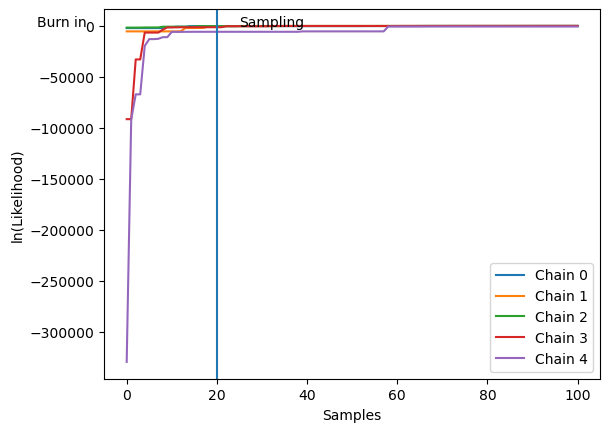

In [50]:
for i in range(nchains): # For each chain
    plt.plot(D.chains[i].likelihood)#, 'o', ms = 2)

plt.ylabel('ln(Likelihood)')
plt.xlabel('Samples')

plt.legend(['Chain 0', 'Chain 1', 'Chain 2', 'Chain 3', 'Chain 4'])
plt.axvline(nburn)
plt.text(nburn - 40,-200,'Burn in') 
plt.text(nburn + 5,-200,'Sampling')

#### Plot parameter estimates

In [97]:
fname = os.path.join(P.workspace, M.modelname + '_pars.dat')
B = np.loadtxt(fname)[nburn*nchains:,1:]
A = B.reshape((nsamples-nburn, nchains, npars))

Text(0, 0.5, 'control point z (m)')

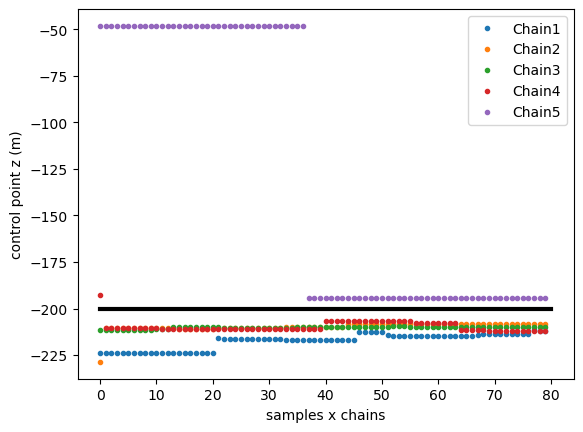

In [106]:
colors = ['b','c','r','g', 'y']
for i in range(npars-1,npars):
    for j in range(nchains):
        plt.plot(A[:,j,i], 'o',ms=3)
plt.plot((0,80),(-200, -200), color = 'black', lw = 3)
plt.legend(['Chain1', 'Chain2','Chain3','Chain4','Chain5'])
plt.xlabel('samples x chains')
plt.ylabel('control point z (m)')

Text(0, 0.5, 'Log HK')

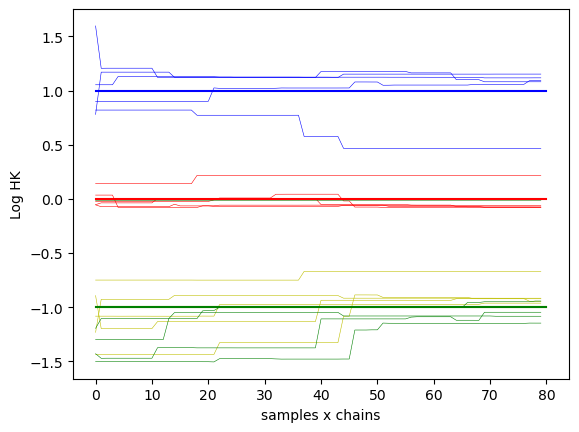

In [99]:
hk_ref = [1, 0.1, 10, 0.1]
vk_ref = [i/10 for i in hk_ref]
colors = ['r','y','b','g','c','y','m','b','c']

for i in range(npars-5):
    for j in range(nchains):
        plt.plot(A[:,j,i], color = colors[i], lw = 0.4) #ms=1.,        
for i in range(len(hk_ref)):
    plt.plot((0,80),(logfunc(hk_ref[i]),logfunc(hk_ref[i])), color = colors[i])

plt.xlabel('samples x chains')
plt.ylabel('Log HK')

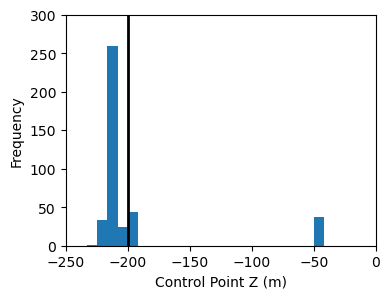

In [146]:
fig, ax = plt.subplots(1,1, figsize = (4,3))
for i in range(1):
    ax = plt.subplot(1,1,i+1)
    ax.hist(A[:,:,-1].flatten(), bins=30, range = (-250,0))
    plt.axvline(-200, color = 'black', lw = 2)
    ax.set_xlabel('Control Point Z (m)')
    if i == 0: ax.set_ylabel('Frequency')
    ax.set_ylim([0,300])
    ax.set_xlim([-250,0])
    if i != 0: ax.set_yticks([])

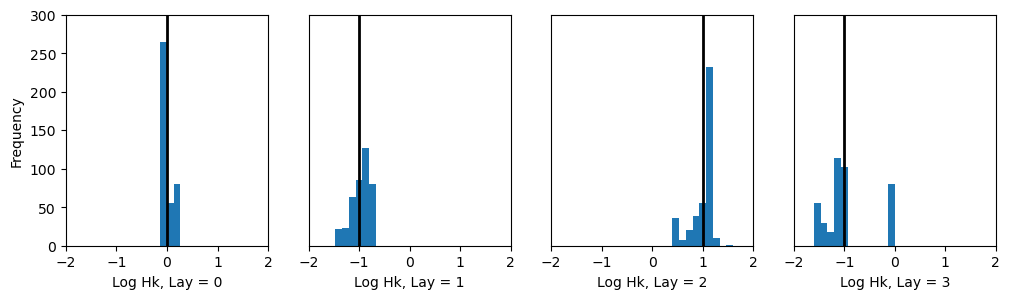

In [142]:
fig, ax = plt.subplots(1,4, figsize = (12,3))
for i in range(4):
    ax = plt.subplot(1,4,i+1)
    ax.hist(A[:,:,i].flatten(), bins=30, range = (-2,2))
    plt.axvline(logfunc(hk_ref[i]), color = 'black', lw = 2)
    ax.set_xlabel(f'Log Hk, Lay = {i}')
    if i == 0: ax.set_ylabel('Frequency')
    ax.set_ylim([0,300])
    ax.set_xlim([-2,2])
    if i != 0: ax.set_yticks([])

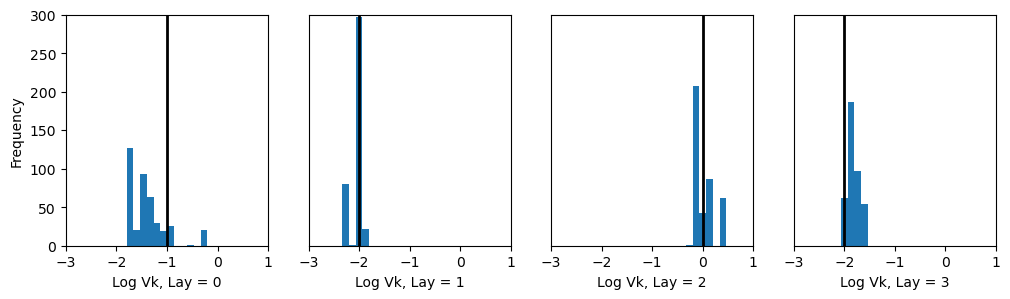

In [144]:
fig, ax = plt.subplots(1,4, figsize = (12,3))
for i in range(4):
    ax = plt.subplot(1,4,i+1)
    ax.hist(A[:,:,i+4].flatten(), bins=30, range = (-3,1))
    plt.axvline(logfunc(vk_ref[i]), color = 'black', lw = 2)
    ax.set_xlabel(f'Log Vk, Lay = {i}')
    if i == 0: ax.set_ylabel('Frequency')
    ax.set_ylim([0,300])
    ax.set_xlim([-3,1])
    if i != 0: ax.set_yticks([])

Text(0, 0.5, 'Log VK')

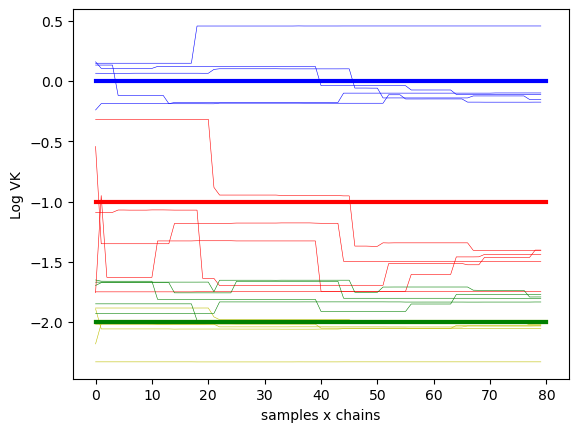

In [100]:
for i in range(npars-5,npars-1):
    for j in range(nchains):
        plt.plot(A[:,j,i],  lw = 0.4, color = colors[i-4])        
for i in range(len(vk_ref)):
    plt.plot((0,80),(logfunc(vk_ref[i]),logfunc(vk_ref[i])), color = colors[i], lw = 3)

plt.xlabel('samples x chains')
plt.ylabel('Log VK')

In [101]:
meanK = []
meanX = []
meanY = []
meanL = []
meanTheta = []
varK = []
varX = []
varY = []
varL = []
varTheta = []
for i in range(1,np.shape(B)[0]):
    meanK.append(np.mean(B[:i,0]))
    varK.append(np.var(B[:i,0]))
    meanX.append(np.mean(B[:i,1]))
    varX.append(np.var(B[:i,1]))
    meanY.append(np.mean(B[:i,2]))
    varY.append(np.var(B[:i,2]))
    meanL.append(np.mean(B[:i,3]))
    varL.append(np.var(B[:i,3]))
    meanTheta.append(np.mean(B[:i,4]))
    varTheta.append(np.var(B[:i,4]))
    


In [117]:
ax = plt.subplot(nmodels, 1, i+1)
        ax.set_title(M.modelname, size = 10) 

[0.0, -1.0, 1.0, -1.0, -1.0, -2.0, 0.0, -2.0, -125]

Text(0, 0.5, 'Frequency')

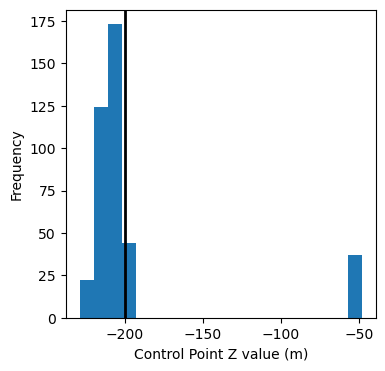

In [116]:
fig, ax = plt.subplots(3,3, figsize = (4,4))
for i in range(10):
    ax = plt.subplot(3,3,i+1)
    ax.hist(B[:,i], bins=20)
    plt.axvline(-200, color = 'black', lw = 2)
    plt.xlabel(f"{}'Control Point Z value (m)')
    plt.ylabel('Frequency')

Text(0, 0.5, 'Log Value')

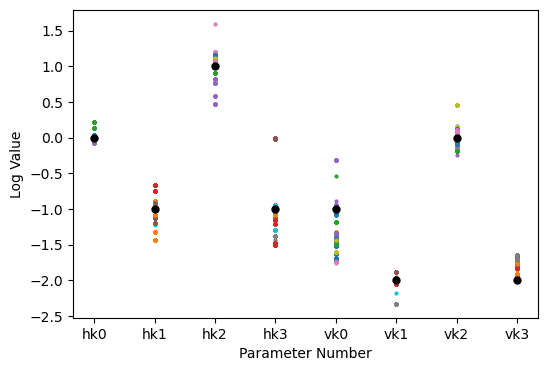

In [105]:
fig, ax = plt.subplots(1,1, figsize = (6,4))
for i in range(nsamples*nchains - nburn*nchains): 
    for j in range(npars-1):
        ax.plot(j, B[i,j],'o', ms = 2.)

for j in range(npars-1):
    ax.plot(j,Mean[j], 'o', ms = 5., color = 'black')
ax.set_xlabel('Parameter Number')
ax.set_xticks(np.arange(0,8,1))
ax.set_xticklabels(['hk0', 'hk1', 'hk2', 'hk3', 'vk0', 'vk1', 'vk2', 'vk3'])
ax.set_ylabel('Log Value')

### Compare predicted vs truth (PAST)

In [ ]:
# Load REALITY past
fname = "REF_past.csv"
csv_file = os.path.join(workspace, fname)
data_set = pd.read_csv(csv_file, header=0)
df = pd.DataFrame(data_set)
times_past = df.iloc[:,0]/365
times_past = times_past[::4] # resample every 4

reality_past = np.array(df.values) # turn df to array
reality_past = reality_past[:,1:nobs+1] # get rid of left column of times and nan columns on right
reality_past = reality_past[::4] # sample period every 4
reality_past = np.swapaxes(reality_past, 0, 1) # better to have obs as axis 0
print('reality past shape ', reality_past.shape) # 9 obs, 6 times

# Load REALITY past
fname = "REF_future.csv"
csv_file = os.path.join(workspace, fname)
data_set = pd.read_csv(csv_file, header=0)
df = pd.DataFrame(data_set)
times_future = df.iloc[:,0]/365
times_future = times_future[::4] # resample every 4

reality_future = np.array(df.values) # turn df to array
reality_future = reality_future[:,1:nobs+1] # get rid of left column of times and nan columns on right
reality_future = reality_future[::4] # sample period every 4
reality_future = np.swapaxes(reality_future, 0, 1) # better to have obs as axis 0
print('reality future shape ', reality_future.shape) # 9 obs, 6 times

In [ ]:
# Load PAST HEADS AT OBS POINTS
fname = '../results/' + modelname + '_hobs_past.pkl'
pickleoff = open(os.path.join(workspace, fname),'rb')
obs_past = pickle.load(pickleoff)
pickleoff.close()
obs_past = np.array(obs_past)
print('obs_past shape ', obs_past.shape) #(445, 9, 6)

# Load PREDICTED HEADS AT OBS POINTS
fname = '../results/' + modelname + '_hobs_pred.pkl'
pickleoff = open(os.path.join(workspace, fname),'rb')
obs_future = pickle.load(pickleoff)
pickleoff.close()
obs_future = np.array(obs_future)
obs_future = obs_future[:,:,::4]
print('obs_future shape', obs_future.shape) #(290, 9, 29)

### Plot reality vs past and predicted

In [ ]:
len(obs_past)

In [ ]:
fig = plt.figure(figsize=(10,8))
plt.suptitle(modelname, size = 14)

for n in range(nobs):   
    ax = plt.subplot(int(nobs/3),3,n+1,aspect='auto')
    ax.set_title('Obs %i' %(n))
    
    # PLOT PAST
    for i in range(len(obs_past)):
        ax.plot(times_past, obs_past[i][n], 'o', ms = 2 ) 
    ax.plot(times_past, reality_past[n], lw = 2, color = 'black') # Plot truth
    
    # PLOT FUTURE
    for i in range(len(obs_future)):
        ax.plot(times_future + 2, obs_future[i][n], 'o', ms = 2 ) 
    ax.plot(times_future + 2, reality_future[n], lw = 2, color = 'black') # Plot truth

    if n > (nobs-4): 
        ax.set_xlabel('Time (years)', size = 10)
        ax.set_xticks(ticks=[0, 1, 2, 3, 4, 5, 6, 7], labels=[0, 1, 2, 3, 4, 5, 6, 7],size = 10)
    if n == 0 or n == 3 or n == 6: ax.set_ylabel('Head (m)', size = 10)
    ax.axvline(2)
    #ax.set_ylim([0,80])
    

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

In [ ]:
fig = plt.figure(figsize=(10,8))
plt.suptitle(modelname, size = 14)

for n in range(nobs):   
    ax = plt.subplot(int(nobs/3), 3,n+1,aspect='auto')
    ax.set_title('Obs %i' %(n))
    
    ax.hist(obs_future[:,n,-1], bins = 15)
    ax.axvline(reality_future[n, -1], lw = 2, color = 'black') # Plot truth

    if n > (nobs-4): ax.set_xlabel('Predicted head (m)', size = 10)
    if n == 0 or n == 3 or n == 6: ax.set_ylabel('Frequency', size = 10)
    ax.set_xlim([reality_future[n, -1] - 10, reality_future[n, -1] + 10])
    #ax.set_xticks(ticks=[0, 1, 2, 3, 4, 5, 6, 7], labels=[0, 1, 2, 3, 4, 5, 6, 7],size = 10)
    
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

In [ ]:
help(flopy.discretization.VertexGrid)
Car = flopy.discretization.VertexGrid(vertices = self.vertices, cell2d = self.cell2d, top = self.top)

In [ ]:
Scrap Code

In [ ]:
#help(flopy.discretization.StructuredGrid)

#cell2dcar = mgs.get_gridprops_vertexgrid()
#lrc_list = mgs.get_lrc()
#node = mgs.get_node(lrc_list)

#verts = sg.verts
#xycenters = sg.xycenters
#xyzvertices = sg.xyzvertices

def convert_to_disu(mgs, idx, dztol):
    global d2d
    
    delr = mgs.delr
    delc = mgs.delc
    top = mgs.top
    botm = mgs.botm
    key = list(parameters.keys())[idx]
    staggered = parameters[key]['staggered']
    d2d = Dis2Disu(delr, delc, top, botm, staggered=staggered, dztol=dztol)
    
    return (d2d)

gridprops = vor.get_gridprops_vertexgrid()
vgrid = flopy.discretization.VertexGrid(**gridprops, nlay=1)
ibd = np.zeros(vgrid.ncpl, dtype=int)
gi = flopy.utils.GridIntersect(vgrid)

# identify cells on left edge
line = LineString([(P.x0, P.y0), (P.x0, P.y1)])
cells0 = gi.intersect(line)["cellids"]
cells0 = np.array(list(cells0))
ibd[cells0] = 1

# identify cells on right edge
line = LineString([(P.x1, P.y0), (P.x1, P.y1)])
cells1 = gi.intersect(line)["cellids"]
cells1 = np.array(list(cells1))
ibd[cells1] = 2

# identify cell
for i in P.xypumpbores:
    point = Point((i[0], i[1]))
cells2 = gi.intersect(point)["cellids"]
cells2 = np.array(list(cells2))
ibd[cells2] = 3

if True:
    fig = plt.figure(figsize=(7, 7))
    ax = plt.subplot(1, 1, 1, aspect="equal")
    pmv = flopy.plot.PlotMapView(modelgrid=vgrid)
    pmv.plot_array(ibd, alpha = 0.6)
    vor.plot(ax=ax, edgecolor='black', lw = 0.5)

In [ ]:
'''from flopy.export import vtk
from pathlib import Path
from tempfile import TemporaryDirectory

nam_file = "CV.nam"
ml = flopy.modflow.Modflow.load(nam_file, model_ws=P.workspace, check=False)

tempdir = TemporaryDirectory()
workspace = Path(tempdir.name)

output_dir = workspace / "arrays_test"
output_dir.mkdir(exist_ok=True)

output_dir'''

In [ ]:
# Plot observations
colors = ['black', 'red', 'green', 'purple', 'orange']
marker_styles = ['s', 's', 's', 'o', 'o', 'o'] #['s', '^', 'p', 's', '^', 'p']    
line_styles = ['dashed', 'dashed','dashed','dotted', 'dotted','dotted','solid']  
fill_color = ['red', 'green', 'purple', 'white', 'white', 'white']
#modelnames = [M.modelname for M in models]

 
#---------- STEADY -------------
models = [M]
fig = plt.figure(figsize = (12,3))
fig.suptitle('Steady state heads')
    
for ob in range(P.nobs): # New figure for each obs bore (OB1, OB2, OB3, OB4)
    ax = plt.subplot(1,5,ob+1)#, aspect = 'equal')
    ax.set_title(P.idobsbores[ob], size = 10) 

    for i, model in enumerate(models): # colored line for each model
        for z in range(len(P.zobs)): # New figure for each obs bore (OB1, OB2, OB3, OB4)
            ax.plot(z, model.hobs_steady[ob,z][0], 'o', c = colors[i],#, marker = marker_styles[i], s = 20,)
                    label = M.modelname)
    
    #ax.set_xlim([10,30])
    ax.set_ylabel('Obs Depth (m)')
    ax.set_xticks([0,1,2,3,4])
    ax.set_xticklabels(P.zobs)
    ax.set_ylim([-20,10])
    if ob > 0: ax.set_yticks([])
    #ax.set_yticks([30, 40, 50, 60])
    if ob == 0: ax.set_ylabel('Head (m)')
    
            
handles, labels = plt.gca().get_legend_handles_labels()
ax = plt.subplot(1,5,5, aspect = 'equal')
ax.set_axis_off()
ax.legend(handles=handles)
plt.show()

In [ ]:
#for attribute, value in M.__dict__.items(): print(attribute)

In [ ]:
"""workspace = 'vtk_files'
if not os.path.isdir(workspace):
    os.makedirs(workspace, exist_ok=True)

model_output_dir = os.path.join(workspace, "model_output_test")
M.gwf.export(model_output_dir, fmt="vtk")

from flopy.export import vtk
fname = '{}.hds'.format(M.modelname)
print(os.path.join(P.workspace, fname))
hds = flopy.utils.binaryfile.HeadFile(os.path.join(P.workspace, fname))  


vtkobj = vtk.Vtk(M.gwf, xml=True, pvd=True, vertical_exageration=2)
vtkobj.add_heads(hds)
vtkobj.write(os.path.join(workspace, "heads_output_test", "KW.vtu"))"""